# EE379K Lab 7

## Irfan Hasan, Peter Zhang

# Question 1

## Part 0

fit a model for the dataset from https://www.kaggle.com/c/GiveMeSomeCredit/data

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

Data dictionary<br>
<ul>
<li><b>SeriousDlqin2yrs:</b> Person experienced 90 days past due delinquency or worse
<li><b>RevolvingUtilizationOfUnsecuredLines:</b> Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits
<li><b>age:</b> Age of borrower in years
<li><b>NumberOfTime30-59DaysPastDueNotWorse:</b> Number of times borrower has been 30-59 days past due but no worse in the last 2 years.
<li><b>DebtRatio:</b> Monthly debt payments, alimony,living costs divided by monthy gross income
<li><b>MonthlyIncome:</b> Monthly income
<li><b>NumberOfOpenCreditLinesAndLoans:</b> Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)
<li><b>NumberOfTimes90DaysLate:</b> Number of times borrower has been 90 days or more past due.
<li><b>NumberRealEstateLoansOrLines:</b> Number of mortgage and real estate loans including home equity lines of credit
<li><b>NumberOfTime60-89DaysPastDueNotWorse:</b> Number of times borrower has been 60-89 days past due but no worse in the last 2 years.
<li><b>NumberOfDependents:</b> Number of dependents in family excluding themselves (spouse, children etc.)
</ul>

In [156]:
# read in data
train = pd.read_csv("cs-training.csv")
test = pd.read_csv("cs-test.csv")

# drop id
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)

# fill missing values with 0
train = train.fillna(0)
test = test.fillna(0)

# setup training, testing, and final data
test = test.drop('SeriousDlqin2yrs', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    train.drop('SeriousDlqin2yrs', axis=1),
    train['SeriousDlqin2yrs'],
    test_size=0.15
)

# log transform data
test = np.log1p(test)
X_train = np.log1p(X_train)
X_test = np.log1p(X_test)

In [4]:
X_train.describe().transpose()

count      mean       std  min  \
RevolvingUtilizationOfUnsecuredLines  127500.0  0.258415  0.385907  0.0   
age                                   127500.0  3.934662  0.293154  0.0   
NumberOfTime30-59DaysPastDueNotWorse  127500.0  0.147452  0.392636  0.0   
DebtRatio                             127500.0  1.526248  2.628246  0.0   
MonthlyIncome                         127500.0  6.740457  3.561179  0.0   
NumberOfOpenCreditLinesAndLoans       127500.0  2.087353  0.598534  0.0   
NumberOfTimes90DaysLate               127500.0  0.057331  0.293497  0.0   
NumberRealEstateLoansOrLines          127500.0  0.573541  0.499633  0.0   
NumberOfTime60-89DaysPastDueNotWorse  127500.0  0.048065  0.265967  0.0   
NumberOfDependents                    127500.0  0.394666  0.527868  0.0   

                                           25%       50%       75%        max  
RevolvingUtilizationOfUnsecuredLines  0.029639  0.143577  0.445503  10.833859  
age                                   3.737670  3.970292  4.158883   4.700480  
NumberOfTime30-59DaysPastDueNotWorse  0.000000  0.000000  0.000000   4.595120  
DebtRatio                             0.161201  0.312168  0.625499  12.696011  
MonthlyIncome                         7.332369  8.376551  8.909370  14.917036  
NumberOfOpenCreditLinesAndLoans       1.791759  2.197225  2.484907   4.060443  
NumberOfTimes90DaysLate               0.000000  0.000000  0.000000   4.595120  
NumberRealEstateLoansOrLines          0.000000  0.693147  1.098612   3.496508  
NumberOfTime60-89DaysPastDueNotWorse  0.000000  0.000000  0.000000   4.595120  
NumberOfDependents                    0.000000  0.000000  0.693147   3.044522

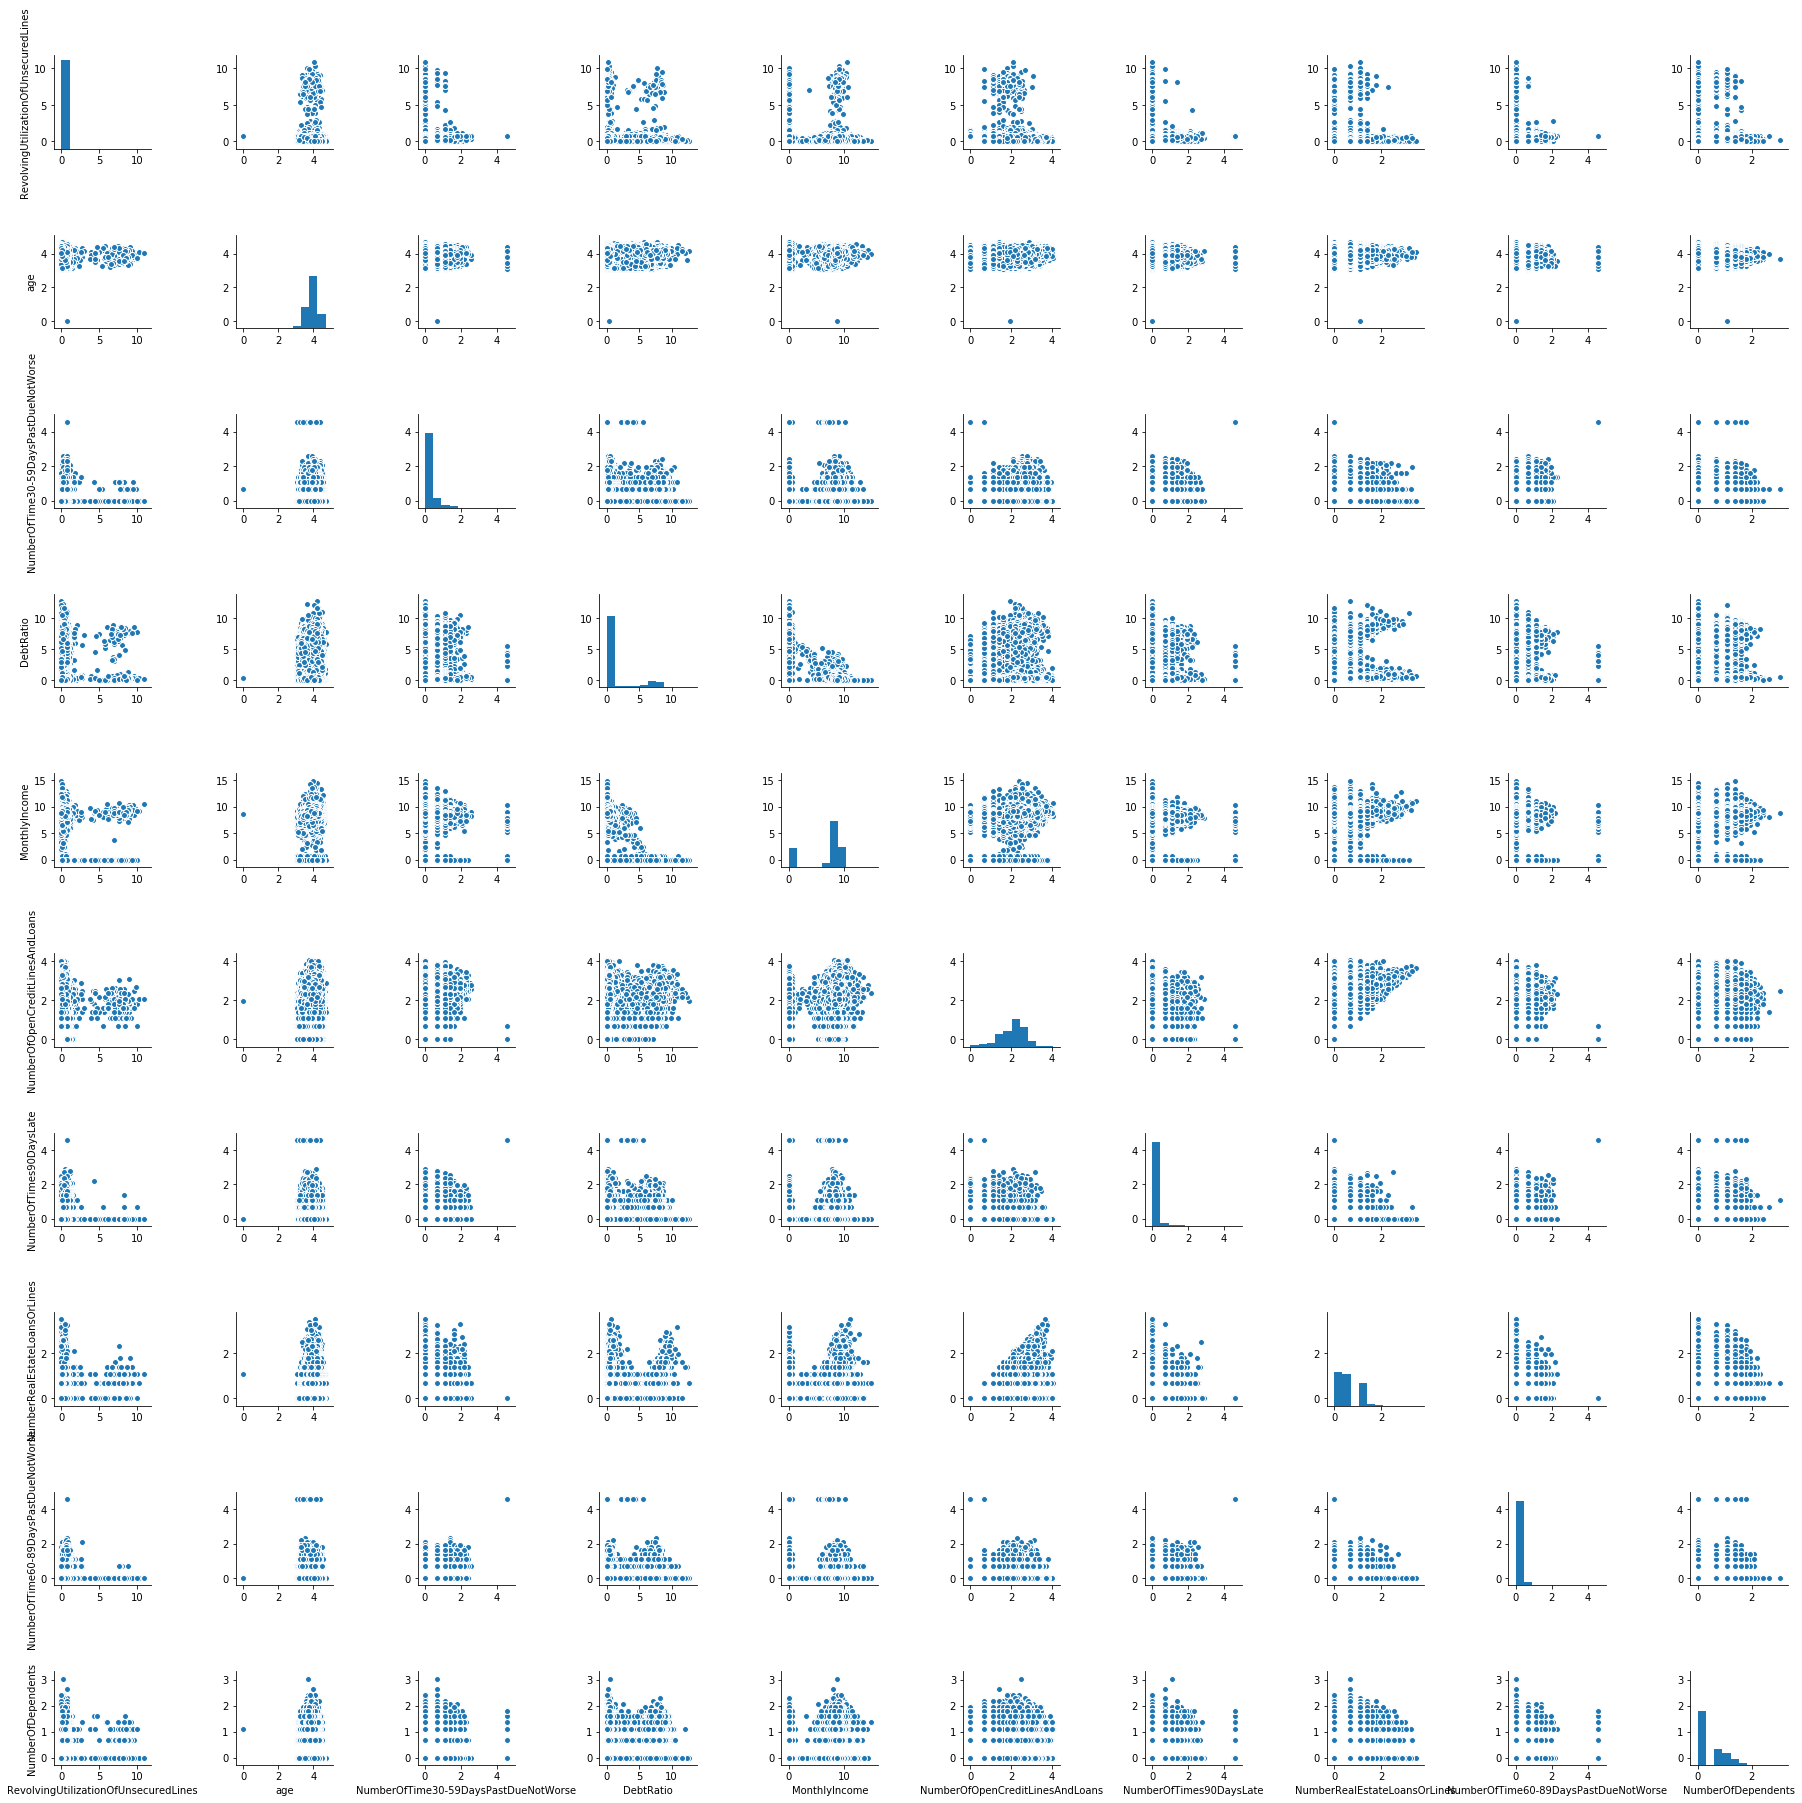

In [5]:
sns.pairplot(X_train)

In [13]:
def modelfit(alg, X_train, y_train, X_test, y_test):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=5,
        metrics='auc', early_stopping_rounds=50)
    alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y_test.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob)
    
    xgb.plot_importance(alg)
    plt.show()


Model Report
Accuracy : 0.9378
AUC Score (Train): 0.860208


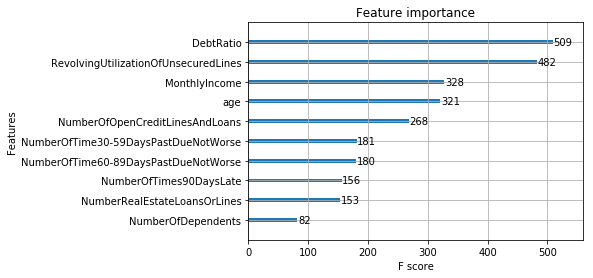

In [7]:
clf = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
)
modelfit(clf, X_train, y_train, X_test, y_test)

In [8]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=95,
       n_jobs=1, nthread=3, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [3]:
clf = xgb.XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    n_estimators=95,
    objective='binary:logistic',
    subsample=0.8
)

In [4]:
# tune max_depth and child weight
params = {
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 7, 13]
}
gsearch = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=4, scoring='roc_auc', verbose=2)
gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   5.5s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   5.5s
[CV] .................. max_depth=5, min_child_weight=1, total=   5.5s
[CV] max_depth=5, min_child_weight=7 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   5.5s
[CV] max_depth=5, min_child_weight=7 .................................
[CV] max_depth=5, min_child_weight=7 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   5.4s
[CV] max_depth=5,

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.2min


[CV] .................. max_depth=9, min_child_weight=1, total=  11.9s
[CV] max_depth=9, min_child_weight=7 .................................
[CV] .................. max_depth=9, min_child_weight=7, total=  11.7s
[CV] max_depth=9, min_child_weight=7 .................................
[CV] .................. max_depth=9, min_child_weight=7, total=  11.1s
[CV] max_depth=9, min_child_weight=13 ................................
[CV] .................. max_depth=9, min_child_weight=7, total=  11.0s
[CV] max_depth=9, min_child_weight=13 ................................
[CV] .................. max_depth=9, min_child_weight=7, total=  10.0s
[CV] max_depth=9, min_child_weight=13 ................................
[CV] .................. max_depth=9, min_child_weight=7, total=  10.9s
[CV] max_depth=9, min_child_weight=13 ................................
[CV] ................. max_depth=9, min_child_weight=13, total=  11.7s
[CV] max_depth=9, min_child_weight=13 ................................
[CV] .

[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=95,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [5, 7, 9], 'min_child_weight': [1, 7, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [6]:
gsearch.best_params_, gsearch.best_score_

({'max_depth': 5, 'min_child_weight': 7}, 0.86470393238569487)

In [8]:
# fine tune max_depth, min_child_weight
# first fine tune param: [4, 5, 6], [6, 7, 9, 11]; got [5, 11] with .8650
params = {
    'max_depth': [5],
    'min_child_weight': [10, 11, 12]
}
gsearch = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=4, scoring='roc_auc', verbose=2)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] ................. max_depth=5, min_child_weight=10, total=   5.9s
[CV] max_depth=5, min_child_weight=10 ................................
[CV] ................. max_depth=5, min_child_weight=10, total=   6.0s
[CV] ................. max_depth=5, min_child_weight=10, total=   5.9s
[CV] max_depth=5, min_child_weight=11 ................................
[CV] max_depth=5, min_child_weight=11 ................................
[CV] ................. max_depth=5, min_child_weight=10, total=   6.0s
[CV] max_depth=5, min_child_weight=11 ................................
[CV] ................. max_depth=5, min_child_weight=10, total=   5.5s
[CV] max_depth=5,

[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   24.2s finished


({'max_depth': 5, 'min_child_weight': 11}, 0.8650315945141499)


Model Report
Accuracy : 0.9375
AUC Score (Train): 0.866864


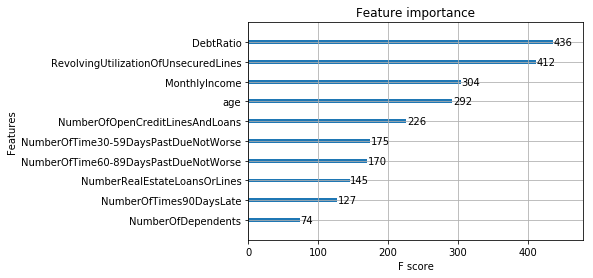

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=11, missing=None, n_estimators=94,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [157]:
# reset clf
clf = xgb.XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=11,
    n_estimators=1000,
    objective='binary:logistic',
    subsample=0.8
)
modelfit(clf, X_train, y_train, X_test, y_test)
clf

In [11]:
'''
    tune subsample and colsample
    first tune: 
        'colsample_bytree': [1, 0.8, 0.6, 0.4],
        'subsample': [1, 0.8, 0.6, 0.4]
        0.6, 0.8, score: .86505
'''
params = {
    'colsample_bytree': [0.7, 0.6, 0.5],
    'subsample': [0.9, 0.8, 0.7]
}
gsearch = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=4, scoring='roc_auc', verbose=2)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] subsample=0.9, colsample_bytree=0.7 .............................
[CV] subsample=0.9, colsample_bytree=0.7 .............................
[CV] subsample=0.9, colsample_bytree=0.7 .............................
[CV] subsample=0.9, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.9, colsample_bytree=0.7, total=   5.7s
[CV] .............. subsample=0.9, colsample_bytree=0.7, total=   5.7s
[CV] subsample=0.9, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.9, colsample_bytree=0.7, total=   5.7s
[CV] subsample=0.8, colsample_bytree=0.7 .............................
[CV] subsample=0.8, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.9, colsample_bytree=0.7, total=   5.7s
[CV] subsample=0.8, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.9, colsample_bytree=0.7, total=   5.6s
[CV] subsample=0.

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   49.2s


[CV] .............. subsample=0.9, colsample_bytree=0.5, total=   4.8s
[CV] subsample=0.8, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.9, colsample_bytree=0.5, total=   4.8s
[CV] subsample=0.8, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.8, colsample_bytree=0.5, total=   4.9s
[CV] subsample=0.8, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.8, colsample_bytree=0.5, total=   4.0s
[CV] subsample=0.7, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.8, colsample_bytree=0.5, total=   4.0s
[CV] subsample=0.7, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.8, colsample_bytree=0.5, total=   4.1s
[CV] subsample=0.7, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.8, colsample_bytree=0.5, total=   4.0s
[CV] subsample=0.7, colsample_bytree=0.5 .............................
[CV] .

[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.1min finished


({'colsample_bytree': 0.6, 'subsample': 0.7}, 0.8652214293027356)

In [16]:
'''
tune learning rate
'''
params = {
    'learning_rate': [0.1, 0.05, 0.01]
}
gsearch = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=4, scoring='roc_auc', verbose=2)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] learning_rate=0.1 ...............................................
[CV] learning_rate=0.1 ...............................................
[CV] learning_rate=0.1 ...............................................
[CV] learning_rate=0.1 ...............................................
[CV] ................................ learning_rate=0.1, total=   4.6s
[CV] learning_rate=0.1 ...............................................
[CV] ................................ learning_rate=0.1, total=   4.6s
[CV] ................................ learning_rate=0.1, total=   4.6s
[CV] learning_rate=0.05 ..............................................
[CV] ................................ learning_rate=0.1, total=   4.7s
[CV] learning_rate=0.05 ..............................................
[CV] learning_rate=0.05 ..............................................
[CV] ................................ learning_rate=0.1, total=   4.7s
[CV] learning_rat

[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   20.3s finished


({'learning_rate': 0.1}, 0.8652214293027356)


Model Report
Accuracy : 0.9395
AUC Score (Train): 0.856473


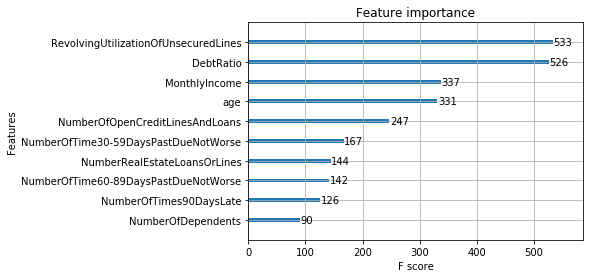

In [151]:
# final clf
clf = xgb.XGBClassifier(
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=11,
    n_estimators=1000,
    objective='binary:logistic',
    subsample=0.7
)
modelfit(clf, X_train, y_train, X_test, y_test)

In [152]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=11, missing=None, n_estimators=109,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [153]:
sub1 = pd.DataFrame()
sub1['Probability'] = clf.predict_proba(test)[:,1]
sub1.insert(0, 'id', range(1, 1+len(sub1)))
sub1.head()

id  Probability
0   1     0.066790
1   2     0.052954
2   3     0.015217
3   4     0.066142
4   5     0.101882

In [154]:
sub1.to_csv('submission2.csv', index=False)

The submission scored 0.8676 on private LB. 

## Part 1

Model interpretability: What is the effect of MonthlyIncome to the prediction? Quantify as much as you can how 1000, 2000 or 3000 extra per month affect the probability of delinquency. Do this by fitting a simple model on the dataset and using your best model.

In [62]:
# read in data
train = pd.read_csv("cs-training.csv")

# drop id
train = train.drop('Unnamed: 0', axis=1)

# fill missing values with 0
train = train.fillna(0)

# add 3000 to monthly income 
train_3000 = train.copy()
train_3000['MonthlyIncome'] += 3000 * train_3000['SeriousDlqin2yrs']

# split to X y
X_train = train.drop('SeriousDlqin2yrs', axis=1)
y_train = train['SeriousDlqin2yrs']
X_train3000 = train_3000.drop('SeriousDlqin2yrs', axis=1)

# log
X_train = np.log1p(X_train)
X_train3000 = np.log1p(X_train3000)

X_train.head()

RevolvingUtilizationOfUnsecuredLines       age  \
0                              0.568789  3.828641   
1                              0.671490  3.713572   
2                              0.505721  3.663562   
3                              0.210107  3.433987   
4                              0.645657  3.912023   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                              1.098612   0.589442       9.118335   
1                              0.000000   0.115002       7.863651   
2                              0.693147   0.081684       8.020599   
3                              0.000000   0.035415       8.101981   
4                              0.693147   0.024620      11.060196   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                         2.639057                 0.000000   
1                         1.609438                 0.000000   
2                         1.098612                 0.693147   
3                         1.791759                 0.000000   
4                         2.079442                 0.000000   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                      1.945910                                   0.0   
1                      0.000000                                   0.0   
2                      0.000000                                   0.0   
3                      0.000000                                   0.0   
4                      0.693147                                   0.0   

   NumberOfDependents  
0            1.098612  
1            0.693147  
2            0.000000  
3            0.000000  
4            0.000000

In [52]:
from sklearn.feature_selection import SelectFromModel
lr = LogisticRegression().fit(X_train, y_train)
lr3000 = LogisticRegression().fit(X_train3000, y_train)

sfm = SelectFromModel(lr, prefit=True)
sfm3000 = SelectFromModel(lr3000, prefit=True)

print 'Original:'
print lr.coef_
print sfm.get_support()
print 'Adding $3000:'
print lr3000.coef_
print sfm3000.get_support()

Original:
[[ 0.53156272 -1.07325208  1.14402473  0.05021117  0.04378993 -0.05302794
   1.46767914  0.00459053  0.66385476  0.15230493]]
[ True  True  True False False False  True False  True False]
Adding $3000:
[[ 0.48602366 -1.8401808   1.17645854  1.84369016  1.92135964 -0.50635672
   1.44147247 -0.83963895  0.79701426 -0.17587696]]
[False  True  True  True  True False  True False False False]


From the logistic regression coef, the increse in 'MonthlyIncome' dramatically increased the coefs of 'DebtRatio' and 'MonthlyIncome', which could mean that these two variables have a close relation.

Before adding $3000 to 'MonthlyIncome', the most importance features determined by Logistic Regression are: <br>
<ul>
    <li>RevolvingUtilizationOfUnsecuredLines
    <li>age
    <li>NumberOfTime30-59DaysPastDueNotWorse
    <li>NumberOfTimes90DaysLate
    <li>NumberOfTime60-89DaysPastDueNotWorse
</ul>
After, the new features are: <br>
<ul>
    <li>age
    <li>NumberOfTime30-59DaysPastDueNotWorse
    <li>DebtRatio
    <li>MonthlyIncome
    <li>NumberOfTimes90DaysLate
</ul>

In [63]:
# use xgb model to check the feature importance
clf = xgb.XGBClassifier(
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=11,
    n_estimators=95,
    objective='binary:logistic',
    subsample=0.7
)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=.15)
X_train3000, X_test3000, y_train3000, y_test3000 = train_test_split(X_train3000, y_train, test_size=0.15)


Model Report
Accuracy : 0.9401
AUC Score (Train): 0.876524


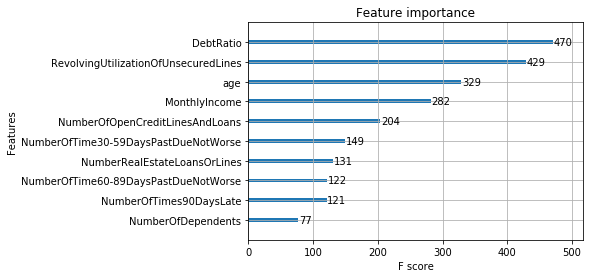

In [64]:
modelfit(clf, X_train1, y_train1, X_train1, y_train1)


Model Report
Accuracy : 0.9609
AUC Score (Train): 0.960396


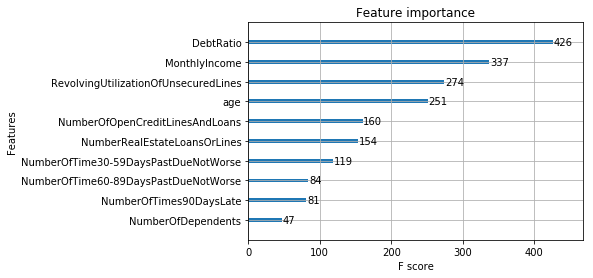

In [65]:
modelfit(clf, X_train3000, y_train3000, X_train3000, y_train3000)

The increase in 'MonthlyIncome' increase its F score while other other features stayed the same. XGBoost model did agree with Logistic Regression model in some ways, where both indicated 'MontlyIncome', 'DebtRatio', and 'age' as important features in datasets with a $3000 increase.

From the two models, I predict that 'MonthlyIncome' is an important feature for predicting the delinquency.

## Part 2

What is the most important variable in predicting delinquency? What is the most important pair of variables? Make a data science argument supported by data.

The most important variable in predicting delinquency could either be 'DebtRatio' or RevolvingUtilizationOfUnsecuredLines'. Looking at the feature importance graphs when tuning the XGBoost model,
these two variables have the highest scores compare to other variables.

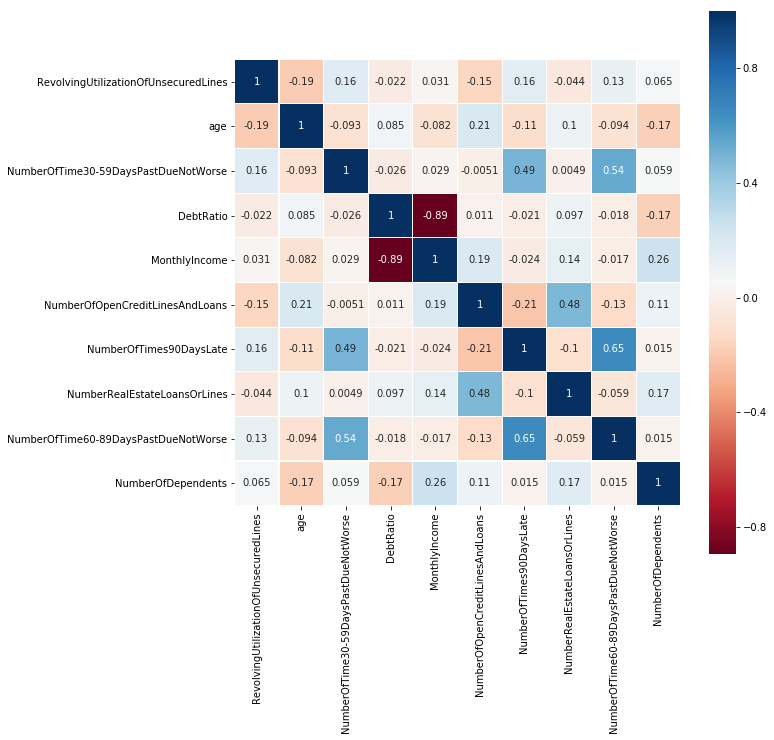

In [160]:
plt.figure(figsize=(10, 10))
sns.heatmap(X_train.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)

The most important pair of variables is ('MonthlyIncome', 'DebtRatio').

Looking at the correlation graph, we see that there are several pairs of variables that have high correlation scores: 'MonthlyIncome' and 'DebtRatio', a combination between 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', and 'NumberOfTimes30-59DaysPastDueNotWorse', and 'NumberRealEstateLoansOrLines' and 'NumberOfOpenCreditLinesAndLoans'.

To determine which one of the pair is most important, I went back and referenced the feature importance graph from XGBoost, and saw that 'MonthlyIncome' and 'DebtRatio' have the highest F scores compare to the rest; therefore, 'MonthlyIncome' and 'DebtRatio' would be the most important variable pair.

# Part 3

The Age Discrimination in Employment Act (ADEA) forbids age discrimination against people who are age 40 or older. Does your good model (from part 0 above) discriminate against older people? Make the best argument you can.

In [76]:
# read in data
train = pd.read_csv("cs-training.csv")

# drop id
train = train.drop('Unnamed: 0', axis=1)

# fill missing values with 0
train = train.fillna(0)

young_train = train[train['age']<40]
old_train = train[train['age']>=40]

In [77]:
young_train.describe().transpose()

count         mean          std  min  \
SeriousDlqin2yrs                      32004.0     0.105299     0.306944  0.0   
RevolvingUtilizationOfUnsecuredLines  32004.0     7.870040   253.108801  0.0   
age                                   32004.0    32.488814     4.708365  0.0   
NumberOfTime30-59DaysPastDueNotWorse  32004.0     0.837958     7.477345  0.0   
DebtRatio                             32004.0   196.264406  1443.113102  0.0   
MonthlyIncome                         32004.0  4149.188383  4733.247505  0.0   
NumberOfOpenCreditLinesAndLoans       32004.0     6.463130     4.205757  0.0   
NumberOfTimes90DaysLate               32004.0     0.717379     7.481032  0.0   
NumberRealEstateLoansOrLines          32004.0     0.666979     0.963488  0.0   
NumberOfTime60-89DaysPastDueNotWorse  32004.0     0.663761     7.469378  0.0   
NumberOfDependents                    32004.0     0.741751     1.101404  0.0   

                                              25%          50%          75%  \
SeriousDlqin2yrs                         0.000000     0.000000     0.000000   
RevolvingUtilizationOfUnsecuredLines     0.072848     0.352177     0.876149   
age                                     29.000000    33.000000    37.000000   
NumberOfTime30-59DaysPastDueNotWorse     0.000000     0.000000     0.000000   
DebtRatio                                0.132654     0.312237     0.644331   
MonthlyIncome                         1601.000000  3500.000000  5700.000000   
NumberOfOpenCreditLinesAndLoans          3.000000     6.000000     9.000000   
NumberOfTimes90DaysLate                  0.000000     0.000000     0.000000   
NumberRealEstateLoansOrLines             0.000000     0.000000     1.000000   
NumberOfTime60-89DaysPastDueNotWorse     0.000000     0.000000     0.000000   
NumberOfDependents                       0.000000     0.000000     1.000000   

                                           max  
SeriousDlqin2yrs                           1.0  
RevolvingUtilizationOfUnsecuredLines   22198.0  
age                                       39.0  
NumberOfTime30-59DaysPastDueNotWorse      98.0  
DebtRatio                             220516.0  
MonthlyIncome                         251608.0  
NumberOfOpenCreditLinesAndLoans           48.0  
NumberOfTimes90DaysLate                   98.0  
NumberRealEstateLoansOrLines              21.0  
NumberOfTime60-89DaysPastDueNotWorse      98.0  
NumberOfDependents                        10.0

In [78]:
old_train.describe().transpose()

count         mean           std  \
SeriousDlqin2yrs                      117996.0     0.056409      0.230710   
RevolvingUtilizationOfUnsecuredLines  117996.0     5.554366    248.836815   
age                                   117996.0    57.667285     11.666981   
NumberOfTime30-59DaysPastDueNotWorse  117996.0     0.307951      2.668950   
DebtRatio                             117996.0   395.517774   2169.270838   
MonthlyIncome                         117996.0  5673.329715  14605.524417   
NumberOfOpenCreditLinesAndLoans       117996.0     8.992407      5.244122   
NumberOfTimes90DaysLate               117996.0     0.143539      2.616953   
NumberRealEstateLoansOrLines          117996.0     1.113512      1.152500   
NumberOfTime60-89DaysPastDueNotWorse  117996.0     0.125555      2.598977   
NumberOfDependents                    117996.0     0.736237      1.108542   

                                       min          25%          50%  \
SeriousDlqin2yrs                       0.0     0.000000     0.000000   
RevolvingUtilizationOfUnsecuredLines   0.0     0.025241     0.121424   
age                                   40.0    48.000000    56.000000   
NumberOfTime30-59DaysPastDueNotWorse   0.0     0.000000     0.000000   
DebtRatio                              0.0     0.189549     0.380595   
MonthlyIncome                          0.0  1500.000000  4700.000000   
NumberOfOpenCreditLinesAndLoans        0.0     5.000000     8.000000   
NumberOfTimes90DaysLate                0.0     0.000000     0.000000   
NumberRealEstateLoansOrLines           0.0     0.000000     1.000000   
NumberOfTime60-89DaysPastDueNotWorse   0.0     0.000000     0.000000   
NumberOfDependents                     0.0     0.000000     0.000000   

                                             75%        max  
SeriousDlqin2yrs                         0.00000        1.0  
RevolvingUtilizationOfUnsecuredLines     0.46821    50708.0  
age                                     65.00000      109.0  
NumberOfTime30-59DaysPastDueNotWorse     0.00000       98.0  
DebtRatio                                1.00000   329664.0  
MonthlyIncome                         7900.00000  3008750.0  
NumberOfOpenCreditLinesAndLoans         12.00000       58.0  
NumberOfTimes90DaysLate                  0.00000       98.0  
NumberRealEstateLoansOrLines             2.00000       54.0  
NumberOfTime60-89DaysPastDueNotWorse     0.00000       98.0  
NumberOfDependents                       1.00000       20.0

In [82]:
# split to X y
X_young = young_train.drop('SeriousDlqin2yrs', axis=1)
y_young = young_train['SeriousDlqin2yrs']
X_old, X_oldt, y_old, y_oldt = train_test_split(
    old_train.drop('SeriousDlqin2yrs', axis=1),
    old_train['SeriousDlqin2yrs'],
    test_size=.73
)

print X_young.shape, X_old.shape

# log
X_young = np.log1p(X_young)
X_old = np.log1p(X_old)

 (32004, 10) (31858, 10)


In [80]:
clf = xgb.XGBClassifier(
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=11,
    n_estimators=95,
    objective='binary:logistic',
    subsample=0.7
)

In [83]:
print 'Young people: ', cross_val_score(estimator=clf, X=X_young, y=y_young, cv=5, scoring='roc_auc', n_jobs=3).mean()
print 'Old people: ', cross_val_score(estimator=clf, X=X_old, y=y_old, cv=5, scoring='roc_auc', n_jobs=3).mean()

Young people:  0.836853048292
Old people:  0.861163860723



Model Report
Accuracy : 0.9088
AUC Score (Train): 0.862857


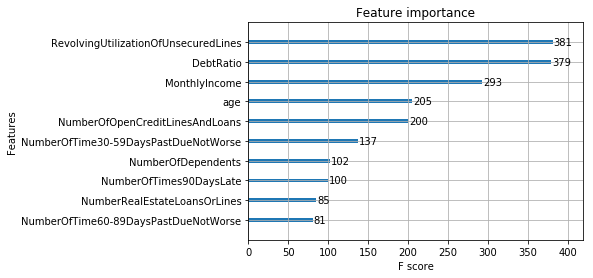

In [84]:
modelfit(clf, X_young, y_young, X_young, y_young)


Model Report
Accuracy : 0.9485
AUC Score (Train): 0.876807


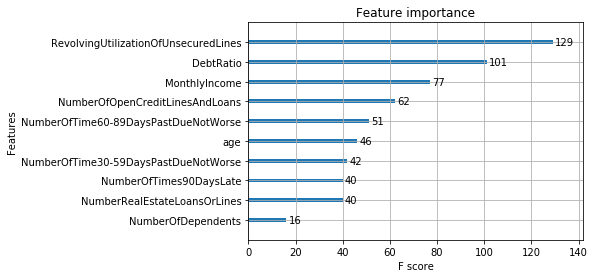

In [86]:
modelfit(clf, X_old, y_old, X_old, y_old)

I believe the model does not discreminate against old people, but 'age' is an important feature to consider when making predictions.

From the dataset, there are 3 times more people who are over 40 than people who are under 40. Running cross validation on the two groups with almost equal amount of data, the scores show that our model performs better on people who are
over 40.

From the feature importance graphs, there are changes to features' ranking, which is understandable as in real life situations, certain features will become more important than others in different age groups. 

# Part 4

Your manager asks if the number of dependents in the family (spouse, no of children) has an effect on loan delinquency. What do the data say? Calculate a p-value to express how confident you are.

In [161]:
# read in data
train = pd.read_csv("cs-training.csv")

# drop id
train = train.drop('Unnamed: 0', axis=1)

# fill missing values with 0
train = train.fillna(0)

X = train.drop('SeriousDlqin2yrs', axis=1)
y = train['SeriousDlqin2yrs']

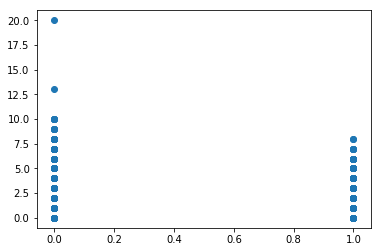

In [163]:
plt.scatter(y, X['NumberOfDependents'])

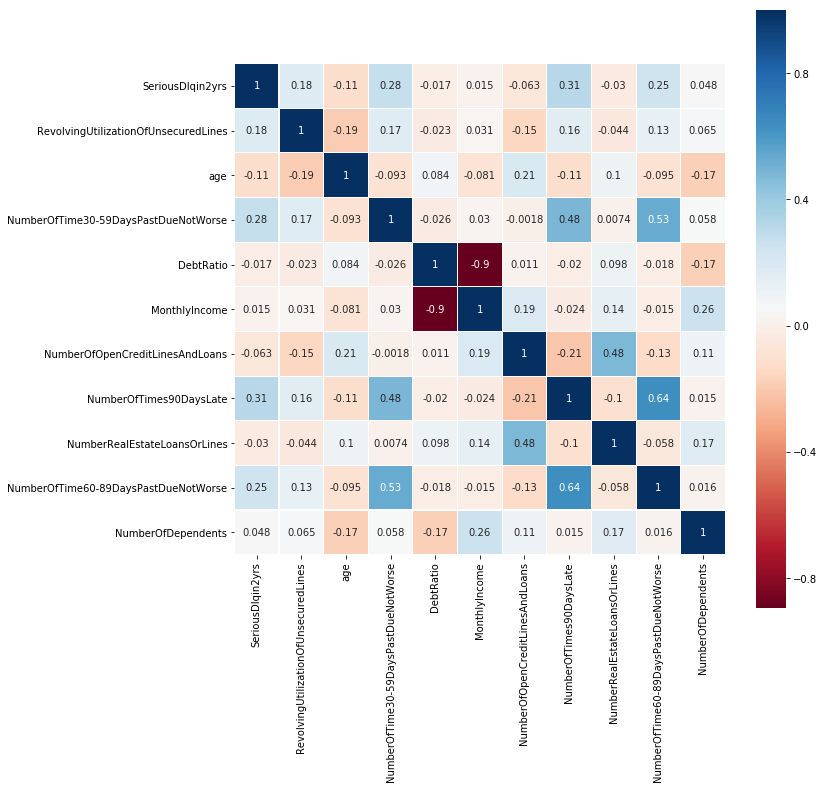

In [164]:
plt.figure(figsize=(11, 11))
sns.heatmap(np.log1p(train).astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)

From the scatter plot, we can see some people will higher number of dependent do not have any deliquencies. And from the correlation graph, the value is somewhat high, indicating there is a relationship between deliquency and number of dependent, but the relationship is not clear.

In [211]:
dq = train[train['SeriousDlqin2yrs']==1]
ndq = train[train['SeriousDlqin2yrs']==0]
print dq.shape[0], ',', ndq.shape[0]

10026 , 139974


In [229]:
d = pd.DataFrame(train['NumberOfDependents'].value_counts())
d.insert(0, 'prob', d['NumberOfDependents']/d['NumberOfDependents'].sum())
d

prob  NumberOfDependents
0.0   0.605507               90826
1.0   0.175440               26316
2.0   0.130147               19522
3.0   0.063220                9483
4.0   0.019080                2862
5.0   0.004973                 746
6.0   0.001053                 158
7.0   0.000340                  51
8.0   0.000160                  24
9.0   0.000033                   5
10.0  0.000033                   5
13.0  0.000007                   1
20.0  0.000007                   1

In [218]:
dq_count = pd.DataFrame(dq['NumberOfDependents'].value_counts())
dq_count.insert(0, 'pro', dq_count['NumberOfDependents']/dq_count['NumberOfDependents'].sum())
dq_count

pro  NumberOfDependents
0.0  0.526032                5274
1.0  0.192998                1935
2.0  0.157989                1584
3.0  0.083483                 837
4.0  0.029623                 297
5.0  0.006782                  68
6.0  0.002394                  24
7.0  0.000499                   5
8.0  0.000199                   2

In [219]:
ndq_count = pd.DataFrame(ndq['NumberOfDependents'].value_counts())
ndq_count.insert(0, 'pro', ndq_count['NumberOfDependents']/ndq_count['NumberOfDependents'].sum())
ndq_count

pro  NumberOfDependents
0.0   0.611199               85552
1.0   0.174182               24381
2.0   0.128152               17938
3.0   0.061769                8646
4.0   0.018325                2565
5.0   0.004844                 678
6.0   0.000957                 134
7.0   0.000329                  46
8.0   0.000157                  22
9.0   0.000036                   5
10.0  0.000036                   5
13.0  0.000007                   1
20.0  0.000007                   1

Splitting up the data based on deliquency, we see that the probabilities for people who have deliquency and who do not have deliquency are very similiar, except the percentage of people who do not have dependents.

In [220]:
count = pd.DataFrame(train['SeriousDlqin2yrs'].value_counts())
count.insert(0, 'prob', count['SeriousDlqin2yrs']/count['SeriousDlqin2yrs'].sum())
count

prob  SeriousDlqin2yrs
0  0.93316            139974
1  0.06684             10026

Let's assume that there is no relationship between deliquency and number of dependent. Then using the training data, the probability of a deliquency showing up is about 6.68%. We take number of people who have 0 dependent, which is a total of 90826 and 5274 of them have deliquency.

In [236]:
from scipy.stats import binom_test
binom_test(5274, 90826, 0.06684, alternative='less')

1.6197041801951215e-27

The binomial test produced a very small number, which makes me believe that our assumption wrong, therefore, there is some kind of relationship between deliquency and number of dependent, but we are unsure how strong it is.

## Question 3

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

In [3]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [4]:
  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-

In [5]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x125c5b7b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
tensors=tensors_to_log, every_n_iter=50)

In [7]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.10340805 0.1046673  0.10792854 0.10241526 0.09476409 0.11678499
  0.08799934 0.09075013 0.09936064 0.09192161]
 [0.09148742 0.1034647  0.11594787 0.09394243 0.09222607 0.10238598
  0.09230752 0.09613759 0.10970077 0.10239963]
 [0.10022802 0.10619697 0.11899851 0.09998132 0.0897824  0.10304718
  0.08310909 0.09226625 0.11087899 0.09551117]
 [0.0983803  0.09993235 0.12047771 0.10126034 0.09386393 0.10397787
  0.09000454 0.08517179 0.11165214 0.09527897]
 [0.09631503 0.10334273 0.11325704 0.09551795 0.09177224 0.10038143
  0.11010982 0.09544004 0.09928252 0.09458118]
 [0.10842697 0.10006838 0.11714632 0.10008872 0.08651396 0.10423867
  0.0

INFO:tensorflow:loss = 2.3129385, step = 1
INFO:tensorflow:probabilities = [[0.11024278 0.09779374 0.10839624 0.09778315 0.09629655 0.09986471
  0.09455103 0.08203356 0.11356463 0.09947372]
 [0.0889169  0.09904657 0.11848844 0.10435548 0.10464639 0.10315205
  0.08864219 0.09891964 0.09469504 0.09913725]
 [0.10464139 0.10046645 0.11564769 0.08740784 0.09479567 0.10798626
  0.10479455 0.08589713 0.09942752 0.09893551]
 [0.09567317 0.10454635 0.10548061 0.09346623 0.0960162  0.10239951
  0.09280993 0.10780246 0.10316323 0.09864235]
 [0.10483358 0.10669618 0.11098123 0.08411569 0.08968274 0.10734446
  0.09475205 0.09652898 0.10502702 0.10003813]
 [0.10283121 0.10296622 0.10382885 0.09805571 0.09733398 0.09802319
  0.09816051 0.09427581 0.10271584 0.10180874]
 [0.09550109 0.09940436 0.10801393 0.10699902 0.0975204  0.10228781
  0.09724147 0.09577841 0.09896877 0.09828474]
 [0.09803952 0.09226768 0.11050239 0.09622475 0.10230912 0.10591188
  0.10116077 0.09385975 0.09282765 0.10689648]
 [0.0

INFO:tensorflow:global_step/sec: 4.5967
INFO:tensorflow:probabilities = [[0.10439815 0.09049791 0.11872189 0.09865622 0.10745963 0.10697012
  0.09050713 0.08521008 0.11170361 0.08587522]
 [0.11604197 0.08879447 0.10441484 0.10016945 0.09469285 0.10738476
  0.08401155 0.08916022 0.10224614 0.11308376]
 [0.10175122 0.09840906 0.10944205 0.10376868 0.09950631 0.09248149
  0.09275126 0.0929015  0.10966107 0.0993273 ]
 [0.12028014 0.09664793 0.10506681 0.09395707 0.09200948 0.11114872
  0.0962752  0.08829761 0.10680481 0.08951227]
 [0.10408682 0.091361   0.10147577 0.10268243 0.10125214 0.10885561
  0.098157   0.09279364 0.10188185 0.09745375]
 [0.09862506 0.10268484 0.09821587 0.1046337  0.10315432 0.09576915
  0.10004622 0.0917035  0.10968287 0.09548446]
 [0.10688341 0.09535896 0.1087105  0.10326751 0.09964378 0.09635785
  0.09677053 0.08798493 0.10609857 0.09892402]
 [0.09695822 0.09430903 0.10339795 0.11176456 0.09067137 0.10945176
  0.09203068 0.08621541 0.1113726  0.10382846]
 [0.0964

INFO:tensorflow:loss = 2.2819083, step = 101 (21.757 sec)
INFO:tensorflow:probabilities = [[0.10144583 0.10570185 0.10952151 0.09630485 0.10168239 0.09818215
  0.09579086 0.09321302 0.1022147  0.0959428 ]
 [0.1007319  0.10480365 0.10864896 0.09584135 0.08410892 0.10383278
  0.09431467 0.09252713 0.11276335 0.10242733]
 [0.09873013 0.10534749 0.1215602  0.10451624 0.09885601 0.09535056
  0.08033475 0.08633049 0.10218277 0.10679141]
 [0.1219416  0.08384529 0.11690407 0.11555616 0.0924771  0.09217551
  0.08994836 0.08593396 0.10430159 0.09691647]
 [0.11986569 0.08376496 0.1030516  0.11622512 0.09390817 0.10246869
  0.08562028 0.09155662 0.10198406 0.10155478]
 [0.09347077 0.11048861 0.10912526 0.09893619 0.09995621 0.09853908
  0.09369116 0.08820906 0.10751136 0.10007227]
 [0.10219319 0.11683392 0.10749947 0.10038052 0.09303366 0.09434817
  0.08549975 0.08920455 0.11360619 0.09740053]
 [0.09926697 0.0964006  0.10863675 0.09920575 0.09270516 0.09154209
  0.09839231 0.09034508 0.11512604 0.

INFO:tensorflow:global_step/sec: 4.16321
INFO:tensorflow:probabilities = [[0.09677769 0.10957409 0.10406161 0.10436291 0.08946693 0.10116852
  0.09213044 0.09417338 0.1020494  0.10623509]
 [0.1091082  0.10383366 0.1099135  0.10176934 0.09402153 0.09888393
  0.09979961 0.08065012 0.10169937 0.10032076]
 [0.09835143 0.1103575  0.10787027 0.09657983 0.09101676 0.09420135
  0.0983098  0.10104242 0.10633456 0.0959361 ]
 [0.09915686 0.11155069 0.11654375 0.08952987 0.09885188 0.08890294
  0.08872814 0.09622435 0.1068579  0.10365361]
 [0.10840434 0.09696328 0.10408045 0.10313959 0.0994782  0.10745081
  0.09226026 0.09940178 0.09624353 0.09257776]
 [0.10137376 0.11084408 0.10884499 0.10087233 0.09854652 0.1031826
  0.09075879 0.08780179 0.10313831 0.09463679]
 [0.0926123  0.10769483 0.1133065  0.10060182 0.0932327  0.10531162
  0.0815309  0.09573954 0.10596042 0.10400933]
 [0.10606775 0.10472805 0.10597906 0.10767742 0.09992218 0.0959212
  0.08899221 0.09467031 0.10331365 0.09272809]
 [0.10303

INFO:tensorflow:loss = 2.2627547, step = 201 (24.020 sec)
INFO:tensorflow:probabilities = [[0.09618356 0.10615505 0.10713209 0.10523342 0.09936278 0.09982724
  0.10202026 0.08597402 0.10654985 0.09156182]
 [0.10207306 0.10615481 0.09905975 0.09726561 0.10036364 0.10207708
  0.09886196 0.09857883 0.0991693  0.09639603]
 [0.11238708 0.09433025 0.10623319 0.09862413 0.09151071 0.11018694
  0.09554452 0.08802422 0.09142062 0.11173838]
 [0.10066158 0.09568229 0.11085201 0.10183966 0.10664346 0.09855595
  0.08788616 0.08886939 0.10804144 0.100968  ]
 [0.10618278 0.09299462 0.10330722 0.10041551 0.09466507 0.10527737
  0.10074686 0.08750682 0.10960087 0.09930286]
 [0.09818098 0.09164409 0.10369861 0.10524479 0.10542092 0.11353368
  0.09718517 0.10035702 0.09428378 0.09045096]
 [0.10632686 0.0909935  0.1067104  0.09582394 0.10100652 0.09923308
  0.0909253  0.09418975 0.11445595 0.1003347 ]
 [0.10242043 0.10745557 0.11126897 0.10177651 0.09547332 0.10058981
  0.08790236 0.09410714 0.11316733 0.

INFO:tensorflow:global_step/sec: 4.32074
INFO:tensorflow:probabilities = [[0.10168485 0.09785663 0.10312867 0.10614568 0.09782489 0.10140417
  0.09006122 0.08713762 0.12242556 0.09233066]
 [0.10943291 0.09710839 0.10480904 0.10161015 0.09509833 0.09286775
  0.1140808  0.08304363 0.10344364 0.09850535]
 [0.12025442 0.08556633 0.10338236 0.09358984 0.10205444 0.08688238
  0.09278998 0.10297712 0.11337198 0.09913111]
 [0.10657776 0.10460635 0.11321197 0.09929348 0.09308883 0.10394119
  0.08497247 0.0897904  0.10967883 0.09483868]
 [0.11056639 0.09713481 0.10953012 0.09661834 0.0782104  0.09092085
  0.09960349 0.10535829 0.12241165 0.0896457 ]
 [0.10794624 0.09621607 0.10948721 0.10097256 0.09347956 0.0921758
  0.10524932 0.08655763 0.11056461 0.09735098]
 [0.10554533 0.07522907 0.11984572 0.10564716 0.10443017 0.11173809
  0.09265145 0.08722512 0.10616574 0.09152213]
 [0.1076996  0.08501782 0.09186298 0.10439894 0.11019605 0.08606546
  0.09091058 0.08956208 0.11696911 0.11731747]
 [0.1142

INFO:tensorflow:loss = 2.2531412, step = 301 (23.145 sec)
INFO:tensorflow:probabilities = [[0.11437406 0.10475096 0.0948057  0.10867404 0.09009029 0.09721696
  0.09760712 0.09242754 0.10478695 0.09526631]
 [0.09969223 0.11348764 0.10229353 0.10289598 0.09971678 0.09583583
  0.09109527 0.08557403 0.11950954 0.08989912]
 [0.10380707 0.10168959 0.10861776 0.11179943 0.08587513 0.1044986
  0.093119   0.08635335 0.10652334 0.09771673]
 [0.11671456 0.08784715 0.1240799  0.11961256 0.08201814 0.09033334
  0.08888566 0.08997782 0.11115853 0.08937234]
 [0.10667073 0.10851286 0.09934361 0.09837355 0.09832851 0.09802696
  0.09770479 0.08913517 0.10338869 0.10051512]
 [0.09421415 0.09462291 0.12177258 0.11193989 0.09468013 0.09205407
  0.09056108 0.09356158 0.11565765 0.09093595]
 [0.1107647  0.09665379 0.11327894 0.10427698 0.08555878 0.10165019
  0.10006091 0.09231336 0.10235081 0.09309153]
 [0.11568394 0.10017248 0.09379189 0.10749738 0.10121548 0.08056077
  0.10639192 0.09187489 0.11199578 0.0

INFO:tensorflow:global_step/sec: 4.3529
INFO:tensorflow:probabilities = [[0.12266829 0.07885424 0.10240205 0.10058234 0.09249495 0.08938071
  0.12402227 0.09726851 0.0958593  0.09646732]
 [0.10941374 0.09651083 0.1015738  0.11616349 0.0925047  0.10227876
  0.09734747 0.08917997 0.10322344 0.09180383]
 [0.11160962 0.09414607 0.09979624 0.09845369 0.09860179 0.10072083
  0.09445215 0.10060558 0.10556161 0.09605244]
 [0.09839854 0.08954056 0.09625117 0.10083323 0.09912779 0.09755164
  0.0990724  0.11201781 0.1099605  0.09724636]
 [0.09823624 0.12072567 0.09839491 0.12146044 0.09562023 0.08327482
  0.08673259 0.09617864 0.10459443 0.09478199]
 [0.09093828 0.10402104 0.1035111  0.11116242 0.09450812 0.10357028
  0.08301269 0.09283463 0.11250825 0.10393308]
 [0.09792864 0.11576366 0.0976156  0.10267782 0.09409885 0.09771252
  0.09075082 0.08772909 0.11720155 0.09852143]
 [0.10960419 0.10305402 0.09791611 0.09707018 0.10911357 0.09254844
  0.09178892 0.09671069 0.10273933 0.09945466]
 [0.1057

INFO:tensorflow:loss = 2.2224905, step = 401 (22.974 sec)
INFO:tensorflow:probabilities = [[0.10286327 0.10401256 0.09861305 0.10554026 0.10077483 0.0890796
  0.10824092 0.08899707 0.10074126 0.10113718]
 [0.09626684 0.09425768 0.09656473 0.10657493 0.09501886 0.09989012
  0.10556828 0.09293669 0.11249878 0.10042304]
 [0.10571609 0.10066242 0.10718922 0.0891653  0.10334363 0.09812323
  0.09925292 0.09200435 0.1043262  0.1002166 ]
 [0.11147125 0.08003769 0.11302827 0.10654656 0.09924759 0.08870957
  0.11138748 0.08860492 0.09492171 0.106045  ]
 [0.09961247 0.08499213 0.11283773 0.10437801 0.08910431 0.09334071
  0.0914567  0.09096422 0.12834078 0.10497295]
 [0.08828407 0.11729009 0.1125598  0.09812119 0.08843462 0.09038948
  0.10335275 0.08403889 0.12659161 0.0909375 ]
 [0.09250374 0.11766495 0.11740245 0.09427942 0.09592049 0.10059503
  0.08425238 0.09152499 0.10838162 0.09747496]
 [0.10528007 0.09650984 0.10146108 0.09288242 0.10367434 0.09864365
  0.1007892  0.10436689 0.10137662 0.0

INFO:tensorflow:global_step/sec: 4.28829
INFO:tensorflow:probabilities = [[0.09995294 0.09116223 0.12328498 0.10903787 0.08515823 0.08651739
  0.09560005 0.11398453 0.09908038 0.09622145]
 [0.10008346 0.10132159 0.11567571 0.12106889 0.09310488 0.09058339
  0.07843295 0.09562787 0.10350299 0.10059824]
 [0.10809798 0.09339941 0.11726744 0.10612293 0.09547665 0.08697794
  0.10003144 0.08733593 0.10401425 0.10127602]
 [0.11498194 0.08308553 0.10809216 0.08729368 0.09821591 0.10380989
  0.10333668 0.09333088 0.10166898 0.10618437]
 [0.10223672 0.08545019 0.09579354 0.09057274 0.11029466 0.10448003
  0.10190488 0.09029049 0.10943312 0.10954365]
 [0.1410163  0.08124463 0.1070938  0.10090408 0.08768127 0.10070246
  0.09886937 0.08840704 0.10313947 0.09094147]
 [0.12801991 0.09080727 0.09988166 0.10079944 0.08315717 0.1168402
  0.10618139 0.080766   0.10197032 0.09157667]
 [0.09736627 0.08994053 0.11717965 0.11934261 0.07965568 0.09473954
  0.09357655 0.10046659 0.12083969 0.08689292]
 [0.1141

INFO:tensorflow:loss = 2.218188, step = 501 (23.321 sec)
INFO:tensorflow:probabilities = [[0.15426278 0.07294532 0.08897395 0.09105151 0.09954177 0.10579082
  0.09970521 0.10137348 0.0901743  0.09618092]
 [0.10785303 0.08155135 0.09704088 0.10240754 0.1063006  0.08961327
  0.10369849 0.10479926 0.11232789 0.09440774]
 [0.09830544 0.08809099 0.09768896 0.10326432 0.09789018 0.0875421
  0.09093584 0.11450201 0.11203226 0.10974795]
 [0.10435874 0.08803249 0.10096296 0.11828553 0.09441872 0.10158744
  0.09496221 0.08631334 0.10938379 0.10169487]
 [0.14829233 0.06789255 0.10115386 0.08115506 0.0973405  0.09982938
  0.122979   0.08692633 0.10875062 0.08568042]
 [0.10445119 0.123566   0.09152249 0.1022866  0.09962448 0.09796713
  0.08416161 0.09470309 0.10589403 0.09582338]
 [0.11368759 0.1020009  0.09630163 0.08837499 0.10860757 0.09600571
  0.0975236  0.08562525 0.11301875 0.098854  ]
 [0.1224274  0.09321923 0.09817567 0.11535411 0.09732846 0.1067221
  0.09890336 0.08868045 0.09752918 0.081

INFO:tensorflow:global_step/sec: 4.33597
INFO:tensorflow:probabilities = [[0.11194893 0.07821617 0.09586777 0.11334402 0.08901491 0.10646085
  0.09920356 0.10329547 0.10735447 0.09529392]
 [0.11077199 0.10206024 0.10478153 0.1253989  0.07336321 0.09604254
  0.1028895  0.08894163 0.1087418  0.08700865]
 [0.0902236  0.09050336 0.10547039 0.08384284 0.09733861 0.11046398
  0.1035765  0.10081084 0.1073638  0.11040607]
 [0.12888777 0.06835347 0.10946847 0.10090075 0.09887649 0.09345213
  0.10430395 0.07543962 0.11430654 0.10601078]
 [0.13575655 0.08191758 0.11049141 0.11117876 0.09231422 0.09733961
  0.0992885  0.08372333 0.09343909 0.09455092]
 [0.12841928 0.07698288 0.12319348 0.10463234 0.08447384 0.09475814
  0.0932401  0.10058971 0.09844988 0.09526042]
 [0.11902938 0.09675623 0.09989461 0.11112747 0.08212766 0.09063689
  0.09613495 0.09948411 0.10601433 0.09879427]
 [0.06929826 0.14992404 0.1038481  0.09372558 0.09611508 0.09623726
  0.08302618 0.0879515  0.12553057 0.09434345]
 [0.100

INFO:tensorflow:loss = 2.18636, step = 601 (23.061 sec)
INFO:tensorflow:probabilities = [[0.10675837 0.09692629 0.12414771 0.09479193 0.11296446 0.08722365
  0.09697458 0.087326   0.09635381 0.09653322]
 [0.12661307 0.08626673 0.10626195 0.11198857 0.08841759 0.08715753
  0.11519888 0.07371173 0.09520491 0.10917901]
 [0.10983346 0.07227152 0.12163305 0.12092905 0.08479705 0.10398572
  0.08754246 0.09795596 0.09869435 0.10235736]
 [0.09465185 0.09570023 0.14072968 0.1001862  0.07972485 0.11412101
  0.09796978 0.08637123 0.10088791 0.08965725]
 [0.11524668 0.07628945 0.11807387 0.11305302 0.08889946 0.08855928
  0.08688061 0.09107574 0.11806479 0.10385714]
 [0.10590797 0.09417487 0.12256721 0.10593088 0.08759855 0.11370567
  0.08709043 0.07953619 0.12416176 0.07932641]
 [0.12736098 0.07194552 0.12439856 0.11322916 0.09507646 0.09593105
  0.09239753 0.08235101 0.09395665 0.10335309]
 [0.12497854 0.08734845 0.10235865 0.08749282 0.09597905 0.10804764
  0.12186712 0.09146084 0.09954265 0.08

INFO:tensorflow:global_step/sec: 4.48081
INFO:tensorflow:probabilities = [[0.11069254 0.07128948 0.10288922 0.11384688 0.11912455 0.11473081
  0.0850617  0.08054066 0.105326   0.09649819]
 [0.1079858  0.09825777 0.1090405  0.09574097 0.10270637 0.09887595
  0.10757119 0.08247298 0.11668292 0.08066551]
 [0.12130341 0.08949536 0.12108068 0.1177802  0.07289961 0.06662407
  0.10465469 0.08219285 0.11665592 0.10731325]
 [0.1043341  0.0944714  0.09104609 0.09002449 0.12940823 0.09898034
  0.10269215 0.09081204 0.10071581 0.09751533]
 [0.10558258 0.09251861 0.09799062 0.09288258 0.09331075 0.09000169
  0.09076481 0.09980077 0.12620708 0.11094053]
 [0.10174049 0.07760708 0.10563907 0.09565149 0.1030754  0.08949787
  0.10250089 0.09891131 0.11910139 0.10627498]
 [0.10339757 0.06183758 0.11330549 0.11429554 0.09394137 0.10449992
  0.10525725 0.10487036 0.11081738 0.08777755]
 [0.10497373 0.07943981 0.10726181 0.10130347 0.09482917 0.09249651
  0.10749152 0.0789143  0.12875487 0.10453481]
 [0.149

INFO:tensorflow:loss = 2.1380353, step = 701 (22.319 sec)
INFO:tensorflow:probabilities = [[0.1288955  0.06530639 0.11228281 0.12121961 0.08453032 0.10987404
  0.09606735 0.07873374 0.09376378 0.10932641]
 [0.09050977 0.13575193 0.11766846 0.08605267 0.10331383 0.10351805
  0.09219478 0.0877198  0.09771301 0.08555774]
 [0.10094772 0.1258592  0.11134858 0.0997453  0.08105228 0.1028279
  0.07859305 0.08177034 0.13638917 0.08146649]
 [0.07546806 0.14536995 0.10290084 0.10685245 0.08634804 0.09879179
  0.08138423 0.08429543 0.11906146 0.09952775]
 [0.08357667 0.1273927  0.0912241  0.10558304 0.09106161 0.10046624
  0.0791003  0.08806905 0.12392113 0.10960513]
 [0.10119461 0.07660443 0.11208097 0.09087083 0.11393632 0.10419846
  0.10789901 0.09187344 0.0927034  0.10863845]
 [0.1458231  0.06168184 0.11565442 0.13258101 0.07698064 0.09833751
  0.09415848 0.08782953 0.08489544 0.10205811]
 [0.10114923 0.06945574 0.10355084 0.10788777 0.09304221 0.08149333
  0.10083574 0.10120796 0.11834437 0.1

INFO:tensorflow:global_step/sec: 4.45214
INFO:tensorflow:probabilities = [[0.10851265 0.09101618 0.10252017 0.13238233 0.08502721 0.0902154
  0.0712593  0.10947371 0.10868493 0.10090808]
 [0.1130539  0.09215001 0.10945961 0.09936804 0.0888713  0.07733729
  0.1158917  0.09269856 0.12606677 0.08510284]
 [0.14193338 0.07751561 0.08132912 0.12325881 0.0737565  0.08375807
  0.11473309 0.10252932 0.09575321 0.10543292]
 [0.07822975 0.14021778 0.1090346  0.09691897 0.0850077  0.08712446
  0.10132265 0.09335028 0.11926151 0.08953231]
 [0.08676651 0.07980265 0.1385981  0.10798115 0.07916855 0.09770474
  0.0946605  0.08201704 0.13204953 0.10125127]
 [0.09124094 0.09411179 0.09469225 0.07945027 0.08419261 0.08487974
  0.09446749 0.11702427 0.1594543  0.10048641]
 [0.11024655 0.09967144 0.1029081  0.09661047 0.08978999 0.10354613
  0.09291412 0.09528128 0.12095681 0.08807512]
 [0.11045402 0.10641082 0.10587699 0.10249832 0.09152368 0.07786117
  0.11835984 0.08463179 0.10605179 0.0963316 ]
 [0.0929

INFO:tensorflow:loss = 2.0960898, step = 801 (22.465 sec)
INFO:tensorflow:probabilities = [[0.0782503  0.15398043 0.11885635 0.11128608 0.07808618 0.09186045
  0.07770912 0.07550577 0.12353679 0.09092853]
 [0.12090018 0.05966677 0.11011346 0.10194554 0.10508248 0.07941618
  0.09969514 0.09955952 0.1184111  0.1052096 ]
 [0.13013643 0.06092056 0.08337387 0.12526084 0.09384191 0.10179573
  0.08647075 0.09637077 0.11863932 0.10318977]
 [0.08608477 0.09355452 0.08762449 0.10321135 0.10367436 0.10209794
  0.08701737 0.11228795 0.11622132 0.10822584]
 [0.10980882 0.09293769 0.13302861 0.13941106 0.06717355 0.09600791
  0.08519021 0.06780722 0.11365996 0.09497499]
 [0.09000731 0.12545381 0.10553178 0.10269801 0.09264852 0.10837634
  0.09800621 0.07894149 0.11520723 0.08312937]
 [0.10519288 0.08818141 0.0904903  0.10425354 0.08911094 0.10027443
  0.10450449 0.09690052 0.14082251 0.08026897]
 [0.11711996 0.08983528 0.10277721 0.11556271 0.08241673 0.09080812
  0.08145536 0.09647254 0.12240839 0.

INFO:tensorflow:global_step/sec: 4.44307
INFO:tensorflow:probabilities = [[0.10012051 0.13815697 0.10138695 0.11499164 0.08715466 0.08262362
  0.08555989 0.0864369  0.11086375 0.09270515]
 [0.08016135 0.07424937 0.186414   0.09627732 0.08482774 0.09921288
  0.10841168 0.07908061 0.09064255 0.10072251]
 [0.13358575 0.05698394 0.14106864 0.1084043  0.12315544 0.08226719
  0.10703932 0.08325601 0.07476075 0.0894787 ]
 [0.14206354 0.07325368 0.12966864 0.11613823 0.08984312 0.07648036
  0.08368944 0.08258885 0.11229528 0.09397886]
 [0.07690441 0.09257073 0.1460528  0.12474203 0.09046762 0.07590313
  0.09883595 0.08990954 0.10290148 0.10171229]
 [0.0997702  0.08991653 0.09894102 0.08946738 0.11043177 0.07821064
  0.10555587 0.09491752 0.12483118 0.10795789]
 [0.07833885 0.11120447 0.11061492 0.1003112  0.07899629 0.08902021
  0.0864843  0.08764131 0.16031526 0.09707329]
 [0.18926296 0.06232851 0.11536498 0.10280183 0.08009393 0.07195498
  0.08572639 0.07425306 0.13685207 0.08136131]
 [0.075

INFO:tensorflow:loss = 2.0280225, step = 901 (22.501 sec)
INFO:tensorflow:probabilities = [[0.09859669 0.0633532  0.20072412 0.16106072 0.08227146 0.09459386
  0.09342337 0.06216368 0.0830393  0.06077364]
 [0.23510164 0.03952212 0.08783623 0.11560267 0.09169618 0.10685663
  0.11379238 0.06179759 0.09333274 0.0544618 ]
 [0.12843859 0.07339758 0.13395344 0.08099345 0.10928628 0.0916566
  0.11606259 0.07289696 0.11590665 0.07740786]
 [0.12086967 0.09362861 0.16334026 0.10414261 0.0857626  0.06639554
  0.09951949 0.07345422 0.10656545 0.08632159]
 [0.13585128 0.06665817 0.10533284 0.11725848 0.07583515 0.09439763
  0.1066972  0.09103301 0.10783487 0.09910139]
 [0.11164914 0.09773449 0.10198572 0.09938733 0.06396869 0.11881406
  0.08286646 0.10913621 0.11834688 0.09611107]
 [0.09796795 0.09297201 0.10726069 0.08498383 0.10803555 0.08787052
  0.07501042 0.11807303 0.10168932 0.1261366 ]
 [0.13309912 0.07748616 0.19328079 0.11330366 0.07520717 0.07962567
  0.08696377 0.07243053 0.08852971 0.0

INFO:tensorflow:global_step/sec: 4.4266
INFO:tensorflow:probabilities = [[0.0967782  0.06094777 0.07684503 0.10001975 0.11877859 0.09299065
  0.08702129 0.13344207 0.09974292 0.13343364]
 [0.1466211  0.03849206 0.18311465 0.13733086 0.05096281 0.06919461
  0.08304179 0.10883834 0.07365321 0.1087506 ]
 [0.08544327 0.11022335 0.07891669 0.10829587 0.07888238 0.09469809
  0.09072439 0.09435628 0.16450132 0.09395836]
 [0.05898737 0.18649927 0.09725713 0.09534188 0.07739694 0.07146417
  0.09266149 0.08065712 0.12727621 0.11245845]
 [0.07040612 0.08170698 0.0915048  0.07348853 0.10139526 0.07460665
  0.07410845 0.16753787 0.12064231 0.14460303]
 [0.3537708  0.02862224 0.06142474 0.13681605 0.04837206 0.07999154
  0.11596286 0.05364286 0.07145592 0.04994101]
 [0.12625442 0.11853468 0.0995873  0.09981539 0.08002919 0.12321287
  0.08135111 0.07436569 0.13530713 0.06154222]
 [0.07389316 0.15605111 0.13198462 0.08857112 0.09428418 0.07714619
  0.07116091 0.07028971 0.16145694 0.07516206]
 [0.2354

INFO:tensorflow:loss = 2.005935, step = 1001 (22.591 sec)
INFO:tensorflow:probabilities = [[0.09109811 0.11329579 0.07965338 0.0881157  0.10169388 0.08063329
  0.07189639 0.12727845 0.13278933 0.11354572]
 [0.06129793 0.1510605  0.11669163 0.11949256 0.06356408 0.08859739
  0.10216997 0.10361255 0.11571325 0.0778001 ]
 [0.12225606 0.06844195 0.05694756 0.0861972  0.08833314 0.09503934
  0.07949572 0.1279944  0.12960729 0.14568733]
 [0.14053497 0.08227696 0.08890334 0.11267954 0.10682663 0.09339877
  0.12437446 0.08479923 0.09382471 0.07238138]
 [0.08173374 0.08722129 0.0694557  0.12957674 0.08883339 0.07297103
  0.07677605 0.149296   0.1250857  0.11905029]
 [0.08770406 0.09945862 0.09166557 0.07660339 0.12136912 0.08816014
  0.10087288 0.10486522 0.11579012 0.1135108 ]
 [0.10303607 0.10619298 0.08183277 0.12089993 0.10527609 0.09738143
  0.13178566 0.06533599 0.11438571 0.07387341]
 [0.29289946 0.04037583 0.07363176 0.09465751 0.06955351 0.11186538
  0.11162499 0.05207088 0.08304991 0.

INFO:tensorflow:global_step/sec: 4.44838
INFO:tensorflow:probabilities = [[0.08142725 0.05794862 0.12098832 0.10924987 0.11680801 0.05790287
  0.21274479 0.0705462  0.08174782 0.09063622]
 [0.09973863 0.04454589 0.19472991 0.08774028 0.11064913 0.1015809
  0.10643196 0.0734698  0.07170527 0.10940816]
 [0.07936608 0.05625001 0.09773984 0.08394396 0.11653831 0.06541806
  0.11643065 0.11480185 0.10395178 0.16555952]
 [0.09588715 0.08435443 0.08510847 0.16156712 0.08622724 0.08434816
  0.07574971 0.11989382 0.10708319 0.09978061]
 [0.07237116 0.06039164 0.13295771 0.08773983 0.08629137 0.07778644
  0.17175923 0.07460546 0.10910004 0.12699714]
 [0.06815311 0.2290531  0.09953343 0.09343268 0.07092909 0.09613191
  0.06452382 0.08831484 0.10797729 0.0819507 ]
 [0.17357787 0.06898529 0.08999054 0.08625668 0.08005608 0.11642986
  0.11765774 0.07903445 0.12261193 0.0653996 ]
 [0.07570562 0.16612339 0.07937355 0.09973619 0.08311024 0.08067109
  0.1016661  0.10062543 0.11101367 0.1019747 ]
 [0.0900

INFO:tensorflow:loss = 1.841671, step = 1101 (22.481 sec)
INFO:tensorflow:probabilities = [[0.13292387 0.0741718  0.05692516 0.05155906 0.09490388 0.13427044
  0.10613836 0.13394544 0.1046437  0.11051839]
 [0.21889502 0.01730173 0.06834228 0.11167662 0.08432162 0.08438736
  0.15265583 0.05918664 0.06885222 0.13438068]
 [0.10753061 0.02750451 0.18367034 0.07547475 0.06123047 0.05248511
  0.30582368 0.04390316 0.08109648 0.06128087]
 [0.04680619 0.08957521 0.09028121 0.11780328 0.12729959 0.10260376
  0.06465426 0.09750933 0.14639296 0.11707418]
 [0.05331182 0.11632382 0.10820317 0.12377249 0.09278832 0.06324904
  0.11691071 0.08488616 0.12478417 0.11577028]
 [0.130177   0.04726086 0.08821549 0.11541726 0.07083607 0.15159175
  0.08901349 0.07078379 0.12739709 0.10930718]
 [0.06279974 0.1746911  0.08375605 0.10676451 0.09021337 0.07905285
  0.09931514 0.08586671 0.11365527 0.10388523]
 [0.09865565 0.04085476 0.08686654 0.15515831 0.07591273 0.126828
  0.1295769  0.07364462 0.11153403 0.10

INFO:tensorflow:global_step/sec: 4.46522
INFO:tensorflow:probabilities = [[0.04997249 0.24912563 0.10889398 0.07560878 0.10240586 0.07290612
  0.04742293 0.09681675 0.13002789 0.06681954]
 [0.06311321 0.05126422 0.08666878 0.0549514  0.09896176 0.14228578
  0.04671106 0.21886772 0.07358277 0.1635933 ]
 [0.02602392 0.34423158 0.12118021 0.07529514 0.07689589 0.05697086
  0.04983945 0.05793924 0.1026936  0.08893015]
 [0.06215965 0.04990506 0.10535255 0.07771824 0.15164396 0.07968009
  0.21495622 0.07068127 0.08373161 0.10417145]
 [0.2627824  0.01822536 0.10292564 0.05971804 0.1372471  0.08416722
  0.15891854 0.05442104 0.04482162 0.07677301]
 [0.05561532 0.09967415 0.08903894 0.06513471 0.1231105  0.07655829
  0.12111937 0.08469524 0.11441116 0.17064232]
 [0.46265414 0.02435024 0.08807679 0.05671696 0.0332156  0.07014992
  0.10678373 0.03937356 0.05207815 0.06660087]
 [0.05973335 0.06729213 0.20219901 0.1131999  0.08969186 0.0661279
  0.19491987 0.04639223 0.09174918 0.06869461]
 [0.0845

INFO:tensorflow:loss = 1.7322358, step = 1201 (22.395 sec)
INFO:tensorflow:probabilities = [[0.0472455  0.10471644 0.07229584 0.12436946 0.12492023 0.05843186
  0.0523934  0.18390837 0.10644001 0.12527896]
 [0.03510195 0.10040312 0.10817626 0.11341523 0.10566011 0.08590724
  0.12846299 0.06328546 0.12288762 0.1367001 ]
 [0.05455986 0.17274739 0.07879533 0.08249405 0.11384489 0.06086867
  0.07230688 0.09180761 0.15897238 0.11360291]
 [0.12043976 0.03559415 0.05539578 0.06857961 0.1149637  0.06613078
  0.1166797  0.12055977 0.11475573 0.186901  ]
 [0.05728973 0.02419227 0.26068363 0.227443   0.05081819 0.06290154
  0.08166295 0.07008047 0.09631133 0.06861692]
 [0.13380097 0.04387635 0.10362744 0.0785239  0.16552229 0.108827
  0.10358074 0.06199437 0.09668209 0.10356483]
 [0.31591973 0.03076361 0.11069708 0.05998554 0.14856064 0.08194672
  0.06748053 0.06574536 0.04879578 0.07010496]
 [0.02941025 0.33338234 0.0724033  0.07053611 0.0515198  0.09298258
  0.05487249 0.07752024 0.14817327 0.0

INFO:tensorflow:global_step/sec: 4.45475
INFO:tensorflow:probabilities = [[0.08254364 0.0906982  0.05826085 0.04462856 0.091694   0.10874952
  0.09236284 0.10838987 0.18117192 0.14150053]
 [0.0589955  0.06143437 0.09051433 0.12666021 0.04557312 0.15477523
  0.03930821 0.08238377 0.29330564 0.04704953]
 [0.17085981 0.115242   0.10948817 0.09064648 0.06784707 0.10274634
  0.07240988 0.08329201 0.09620563 0.09126256]
 [0.09723994 0.06949499 0.18892713 0.08989219 0.0760157  0.05964891
  0.22287284 0.02998498 0.08458273 0.08134063]
 [0.10768589 0.05646943 0.05225963 0.11537177 0.08919562 0.12489682
  0.07680546 0.10768154 0.15182683 0.11780704]
 [0.05239651 0.03690988 0.26661986 0.12683396 0.12065555 0.07184251
  0.09173169 0.08048441 0.0777356  0.07479005]
 [0.5555482  0.00768464 0.07538215 0.10784518 0.04250578 0.06003485
  0.0401896  0.04218229 0.0311396  0.03748776]
 [0.2293314  0.02950444 0.09784832 0.10727868 0.09798967 0.07401065
  0.1050338  0.06185596 0.08638886 0.11075819]
 [0.113

INFO:tensorflow:loss = 1.6157604, step = 1301 (22.448 sec)
INFO:tensorflow:probabilities = [[0.08541434 0.02945326 0.12424324 0.05995975 0.23611271 0.08145754
  0.06574155 0.13491702 0.07020286 0.11249766]
 [0.0339073  0.04853198 0.06681044 0.11770505 0.0890215  0.06100496
  0.08607412 0.14303076 0.17328323 0.18063065]
 [0.03417996 0.04990932 0.05555651 0.05290587 0.20248964 0.05715254
  0.16392508 0.12762888 0.08718266 0.16906957]
 [0.2378431  0.03124081 0.08363719 0.0432062  0.14185442 0.09052157
  0.13095215 0.07984204 0.10534255 0.05556003]
 [0.14390366 0.02020279 0.06246544 0.25636458 0.04854531 0.17315881
  0.05602017 0.07000609 0.10535061 0.06398247]
 [0.11007839 0.0397197  0.06140528 0.12452757 0.06015791 0.17569512
  0.12734677 0.08357645 0.15513207 0.06236077]
 [0.08125932 0.0168867  0.18148428 0.23220675 0.06476574 0.11404205
  0.16057494 0.03208861 0.04473504 0.07195655]
 [0.04128332 0.17319942 0.15154272 0.09808476 0.07208415 0.09274806
  0.12122876 0.0803664  0.09544045 0

INFO:tensorflow:global_step/sec: 4.53471
INFO:tensorflow:probabilities = [[0.07464162 0.08150756 0.22604536 0.15183684 0.06161523 0.06195344
  0.1582171  0.02087671 0.12133684 0.04196939]
 [0.06786671 0.03084938 0.25784323 0.09689388 0.08389192 0.11619248
  0.20122369 0.02152413 0.09318276 0.03053177]
 [0.11126229 0.00637947 0.02685472 0.06882206 0.07912956 0.04729434
  0.13303557 0.2175569  0.0608642  0.24880093]
 [0.04531141 0.03242594 0.27090582 0.09524038 0.09843399 0.06547499
  0.29109877 0.01312371 0.06196542 0.02601957]
 [0.02608599 0.15942957 0.05794283 0.09647809 0.17012706 0.05469445
  0.12332866 0.07037579 0.126811   0.11472661]
 [0.0834325  0.01318095 0.05999151 0.07898168 0.09667525 0.08711683
  0.04785396 0.31654733 0.06742325 0.14879678]
 [0.02814144 0.06451331 0.06096331 0.126605   0.08779355 0.06560722
  0.08292132 0.12708181 0.13120294 0.22517006]
 [0.05032108 0.01285032 0.04495597 0.28562486 0.06701693 0.12641448
  0.10396507 0.1368073  0.05436396 0.11768007]
 [0.018

INFO:tensorflow:loss = 1.502871, step = 1401 (22.052 sec)
INFO:tensorflow:probabilities = [[0.02487111 0.33523348 0.09404515 0.12299636 0.06660365 0.06830448
  0.06416914 0.05172038 0.09960858 0.07244759]
 [0.01884755 0.04030537 0.05517947 0.12158838 0.06924522 0.05163088
  0.02347058 0.41615278 0.10694313 0.09663662]
 [0.02366713 0.10910445 0.03838526 0.07303467 0.15572974 0.04809816
  0.0511211  0.19310902 0.08756722 0.22018327]
 [0.05360717 0.03849463 0.04085973 0.27142558 0.04196496 0.19642392
  0.03047357 0.10648236 0.18199557 0.0382725 ]
 [0.04447188 0.03281501 0.0516715  0.08565976 0.27484784 0.05375457
  0.03960791 0.15553692 0.06098524 0.20064941]
 [0.55510354 0.0036374  0.09067861 0.12087274 0.02783203 0.07773326
  0.05068    0.02171334 0.0271291  0.02461999]
 [0.3866301  0.00288529 0.0699147  0.10438231 0.01622855 0.15844424
  0.16151035 0.03962294 0.04178866 0.01859292]
 [0.01889646 0.19252841 0.10872105 0.11224746 0.13917123 0.08360728
  0.17242977 0.04142952 0.07505239 0.

INFO:tensorflow:global_step/sec: 4.54052
INFO:tensorflow:probabilities = [[0.02739805 0.33721375 0.08531658 0.10158896 0.04375029 0.08216617
  0.13558723 0.02374621 0.09826699 0.06496575]
 [0.02290033 0.13365133 0.03912772 0.09956974 0.08280946 0.09621758
  0.03064429 0.2603315  0.09071732 0.14403072]
 [0.0771021  0.00175647 0.20882356 0.34205395 0.03670018 0.10471721
  0.05904994 0.01137147 0.14705132 0.01137376]
 [0.57513684 0.00970184 0.02340641 0.06679138 0.01934047 0.1336772
  0.11428657 0.00364951 0.02328339 0.03072638]
 [0.09156737 0.00161235 0.01526913 0.01997561 0.2929536  0.06654935
  0.11815803 0.14195865 0.02434772 0.22760817]
 [0.05949309 0.00882353 0.02919486 0.07394735 0.10964565 0.09972882
  0.03996046 0.42397273 0.04387888 0.11135461]
 [0.02188294 0.00803712 0.03249012 0.03038409 0.24901208 0.0769108
  0.09936137 0.07748017 0.04666958 0.35777175]
 [0.11424096 0.00865122 0.03303882 0.01536478 0.48413852 0.07288124
  0.02743928 0.0925532  0.04536464 0.10632729]
 [0.04613

INFO:tensorflow:loss = 1.1902196, step = 1501 (22.024 sec)
INFO:tensorflow:probabilities = [[0.7497852  0.00127816 0.01335916 0.07638632 0.00758259 0.08810712
  0.01111625 0.00995432 0.01421607 0.02821491]
 [0.16861588 0.0037114  0.10518344 0.27632883 0.00766755 0.06898166
  0.08593234 0.15995114 0.05206052 0.07156723]
 [0.0215165  0.02437206 0.0185648  0.1032948  0.02091153 0.0395566
  0.01691203 0.5084455  0.07716729 0.16925898]
 [0.05825727 0.00748997 0.04493793 0.03951852 0.45349377 0.03913384
  0.04655865 0.02964284 0.03087777 0.25008935]
 [0.6694293  0.0003247  0.06964578 0.04735116 0.01480487 0.03448494
  0.10287765 0.00857155 0.03859194 0.01391803]
 [0.00935627 0.04573295 0.01767077 0.04437613 0.10200536 0.06239239
  0.03036531 0.30576247 0.1151359  0.2672025 ]
 [0.24023376 0.00348087 0.07089537 0.14406593 0.02679305 0.26212165
  0.03994266 0.10063411 0.03410404 0.07772852]
 [0.01846982 0.00353652 0.0484251  0.02302817 0.14254561 0.03135553
  0.572991   0.02517415 0.04779424 0.

INFO:tensorflow:global_step/sec: 4.54414
INFO:tensorflow:probabilities = [[0.00102079 0.01862369 0.87685984 0.06363723 0.00158317 0.01009908
  0.00663843 0.00151759 0.01906202 0.00095803]
 [0.00667205 0.28496978 0.10727908 0.07063241 0.03700827 0.09358495
  0.19450189 0.01142036 0.13111208 0.06281916]
 [0.01323296 0.01347341 0.04415385 0.01422226 0.5830883  0.08380952
  0.03221821 0.06468526 0.04605021 0.10506599]
 [0.6825159  0.0021362  0.02111945 0.06034681 0.01289236 0.10699651
  0.01759    0.02978957 0.04468126 0.02193194]
 [0.11576793 0.01678863 0.03233799 0.21695027 0.04298985 0.05778557
  0.26055378 0.03318733 0.14089982 0.08273879]
 [0.02020608 0.02335056 0.04049668 0.01917717 0.2783543  0.13856605
  0.03567337 0.11369183 0.1015512  0.22893281]
 [0.00550482 0.6485868  0.05809217 0.05778238 0.03402182 0.02108173
  0.0269592  0.03833815 0.05862156 0.05101134]
 [0.66931885 0.00036676 0.12131951 0.09700668 0.00784223 0.04222544
  0.03430134 0.00994913 0.00933801 0.00833206]
 [0.375

INFO:tensorflow:loss = 1.0416082, step = 1601 (22.007 sec)
INFO:tensorflow:probabilities = [[0.5560194  0.00356753 0.04767298 0.07921168 0.01782185 0.13006319
  0.07343192 0.01501162 0.04333613 0.03386362]
 [0.01569215 0.00448328 0.01211639 0.04496036 0.0413929  0.38714978
  0.01702071 0.38726738 0.0399851  0.04993194]
 [0.08580286 0.03668729 0.08683843 0.06073094 0.03865559 0.3661127
  0.04291291 0.04720325 0.18781143 0.04724457]
 [0.03709555 0.20265287 0.04285084 0.06288098 0.07588288 0.18519357
  0.07794282 0.04169594 0.15721303 0.1165916 ]
 [0.00104359 0.8147215  0.01179479 0.03165924 0.006507   0.01265776
  0.00663068 0.02201818 0.04750907 0.0454582 ]
 [0.00703393 0.02831678 0.03132694 0.10037894 0.13854711 0.03168533
  0.05279921 0.22379197 0.12467307 0.26144674]
 [0.04494005 0.03565985 0.04275938 0.04113911 0.07341988 0.2427907
  0.13283513 0.12717156 0.1609545  0.09832983]
 [0.00265728 0.79980856 0.01997578 0.04002903 0.01653757 0.02389368
  0.02446341 0.0148135  0.03290409 0.0

INFO:tensorflow:global_step/sec: 4.47285
INFO:tensorflow:probabilities = [[0.10274696 0.00356323 0.02834608 0.2085559  0.00851837 0.5745803
  0.00945202 0.02427893 0.01508781 0.02487032]
 [0.0104096  0.00817355 0.01146589 0.07619251 0.05777589 0.05399624
  0.02263536 0.46570966 0.04236952 0.25127184]
 [0.00744952 0.18430543 0.04726704 0.12588619 0.05064487 0.08290419
  0.0554776  0.02924863 0.35483274 0.06198369]
 [0.2686938  0.00661204 0.07312748 0.061419   0.0807542  0.07290425
  0.16252542 0.05114428 0.03597686 0.18684264]
 [0.03344139 0.01683544 0.02308195 0.0315701  0.02687018 0.03940301
  0.00687366 0.6881447  0.08155975 0.05221992]
 [0.12267322 0.0017994  0.06868114 0.04307953 0.2600261  0.03903998
  0.3041751  0.04084847 0.04313522 0.07654182]
 [0.00093179 0.67944914 0.02263605 0.08757172 0.0113798  0.02263152
  0.0278312  0.00879863 0.08225289 0.05651717]
 [0.02891136 0.02049736 0.0524262  0.0527885  0.16417699 0.05700085
  0.05432368 0.04569038 0.16530441 0.35888025]
 [0.0052

INFO:tensorflow:loss = 0.9204549, step = 1701 (22.356 sec)
INFO:tensorflow:probabilities = [[0.06799506 0.00233079 0.00686437 0.13273557 0.00259865 0.63078547
  0.00404811 0.05766382 0.03104395 0.06393417]
 [0.02414972 0.00008262 0.00635548 0.00671447 0.7961761  0.02169374
  0.02010687 0.03234294 0.04514797 0.04723014]
 [0.00528429 0.00156751 0.08812133 0.00632919 0.01774361 0.00928069
  0.81601477 0.0094263  0.03218642 0.01404593]
 [0.00271202 0.00317668 0.00045091 0.00867585 0.05852027 0.00518449
  0.0022265  0.7144148  0.01059341 0.19404523]
 [0.24057549 0.00040858 0.05273157 0.00994208 0.041632   0.0520169
  0.56978685 0.0029361  0.01507357 0.01489682]
 [0.00316862 0.79247135 0.02752534 0.03365667 0.0152727  0.02198806
  0.01056419 0.02172074 0.05972858 0.01390364]
 [0.02619002 0.01935749 0.51327515 0.21041253 0.02024449 0.06361721
  0.07470878 0.02359784 0.03205027 0.01654616]
 [0.08250435 0.00177917 0.02505045 0.02949937 0.50383806 0.0806516
  0.03805775 0.10668037 0.04518838 0.0

INFO:tensorflow:global_step/sec: 4.42579
INFO:tensorflow:probabilities = [[0.1391157  0.00428934 0.04465593 0.00920402 0.3900062  0.09138691
  0.02214196 0.15552704 0.04234415 0.10132866]
 [0.01451868 0.00019803 0.03054628 0.00702301 0.42762017 0.02573208
  0.0148584  0.10384687 0.01243355 0.36322296]
 [0.00624791 0.72050345 0.03272075 0.0357331  0.01869928 0.0212989
  0.02191917 0.02561373 0.09191211 0.02535155]
 [0.07268091 0.01081542 0.054778   0.06469185 0.1896984  0.13318975
  0.14853111 0.04751598 0.03565335 0.24244526]
 [0.00025721 0.94513583 0.00444109 0.00597916 0.00475753 0.00506654
  0.00315263 0.00464349 0.01935674 0.00720984]
 [0.10865758 0.01071377 0.03097523 0.17099127 0.02051983 0.374355
  0.13043523 0.01581481 0.07120787 0.06632937]
 [0.00144745 0.84891486 0.0086102  0.02782664 0.00351737 0.01966839
  0.01431842 0.02091931 0.04282265 0.01195468]
 [0.00789648 0.04262086 0.56928694 0.13863096 0.01400877 0.02867555
  0.02384347 0.04979372 0.09771185 0.02753145]
 [0.002156

INFO:tensorflow:loss = 0.91313297, step = 1801 (22.597 sec)
INFO:tensorflow:probabilities = [[0.01111394 0.16245905 0.10892092 0.19589616 0.0315296  0.08524948
  0.03741746 0.17591935 0.12867305 0.06282102]
 [0.09862752 0.00599574 0.3725783  0.33634576 0.01216009 0.06584476
  0.01916618 0.01192995 0.05956691 0.0177848 ]
 [0.03503502 0.00807308 0.02214552 0.01428468 0.13307215 0.02243125
  0.07426702 0.0822434  0.04888521 0.5595627 ]
 [0.19417246 0.00461494 0.05009251 0.02113575 0.02611625 0.05080154
  0.6221645  0.00465848 0.01057354 0.01567005]
 [0.07496156 0.00070382 0.02046194 0.58240044 0.00524485 0.1335532
  0.00328982 0.03023584 0.08110728 0.06804131]
 [0.04196749 0.00920239 0.4674327  0.10230112 0.04667979 0.07839467
  0.04581257 0.0123185  0.15480863 0.04108217]
 [0.01067353 0.18124266 0.0518259  0.09865192 0.02355929 0.06778795
  0.0037261  0.27735347 0.18355022 0.10162894]
 [0.8450055  0.00011894 0.00208045 0.00093768 0.09791189 0.02710045
  0.00972676 0.00099721 0.01285572 0

INFO:tensorflow:global_step/sec: 4.40004
INFO:tensorflow:probabilities = [[0.00793049 0.00358338 0.0429353  0.72811854 0.00011223 0.02648482
  0.00024082 0.1343366  0.0412413  0.01501649]
 [0.00025913 0.00004588 0.00007273 0.00577492 0.00221094 0.00110964
  0.00004409 0.97230035 0.00052083 0.01766146]
 [0.00380146 0.01274033 0.05095641 0.03480811 0.1962441  0.01851715
  0.02945325 0.28898892 0.09601743 0.26847282]
 [0.00842674 0.3821334  0.20430079 0.0345014  0.05172238 0.01805612
  0.0073965  0.02318465 0.25834674 0.01193127]
 [0.01776463 0.00085199 0.8280178  0.04474286 0.00854229 0.0156637
  0.04987675 0.00272348 0.01151147 0.02030513]
 [0.02888563 0.00120963 0.04921367 0.6050667  0.00141962 0.27834606
  0.00337645 0.00312155 0.0286416  0.00071913]
 [0.45883515 0.00125104 0.05157639 0.18335226 0.0069827  0.18265113
  0.03830515 0.00475825 0.05972679 0.01256108]
 [0.06986406 0.00061769 0.00158012 0.00778789 0.04671361 0.03128674
  0.005098   0.6907522  0.01987026 0.12642935]
 [0.0687

INFO:tensorflow:loss = 0.8451332, step = 1901 (22.726 sec)
INFO:tensorflow:probabilities = [[0.02750855 0.02707552 0.02474612 0.01633226 0.05926264 0.05461015
  0.59138185 0.00066276 0.08938063 0.10903958]
 [0.01689045 0.00080849 0.50913084 0.37434378 0.00334049 0.0260537
  0.02404328 0.00820291 0.03349961 0.00368643]
 [0.02458743 0.03790058 0.05972651 0.10455002 0.01841649 0.08202147
  0.03585608 0.38726828 0.08610212 0.16357099]
 [0.00640799 0.00001716 0.00325642 0.00117293 0.8365218  0.03669624
  0.06877283 0.00793871 0.01537343 0.02384245]
 [0.00912367 0.00853947 0.21127965 0.04399842 0.05152213 0.10531405
  0.08068526 0.09998725 0.15253595 0.2370141 ]
 [0.00329624 0.01150068 0.00179647 0.00683895 0.07091164 0.04311779
  0.00191394 0.555861   0.07753246 0.2272309 ]
 [0.0840667  0.00047199 0.00238751 0.07686119 0.03118927 0.6000193
  0.013557   0.03493234 0.07740522 0.07910939]
 [0.02213007 0.00173906 0.43642545 0.01281112 0.07342146 0.0131825
  0.4164647  0.00094078 0.0158924  0.00

INFO:tensorflow:global_step/sec: 4.45732
INFO:tensorflow:probabilities = [[0.00856205 0.00005163 0.02087459 0.9143457  0.00014626 0.02104628
  0.00847921 0.01892775 0.00562266 0.00194365]
 [0.03979175 0.00085951 0.01732091 0.36997512 0.00307658 0.39577985
  0.01569822 0.02128031 0.12113041 0.01508739]
 [0.10279907 0.02291466 0.05379542 0.01067986 0.3317296  0.10779809
  0.12496479 0.0353378  0.0808426  0.12913819]
 [0.00432709 0.0673705  0.00868715 0.04092988 0.0931251  0.02772978
  0.04074515 0.03362473 0.13686608 0.5465945 ]
 [0.11632368 0.0000061  0.49871656 0.00057328 0.33044517 0.00226514
  0.03973205 0.00096189 0.00715757 0.00381851]
 [0.10070932 0.00025907 0.00634833 0.00341326 0.08694877 0.03678912
  0.04209553 0.5155902  0.01345335 0.19439298]
 [0.01515322 0.00664917 0.1234725  0.01707081 0.10978542 0.02583203
  0.3163571  0.03889658 0.12508182 0.22170134]
 [0.00761488 0.00040131 0.0047636  0.00250709 0.00970003 0.00951848
  0.95220673 0.00009714 0.00363368 0.00955707]
 [0.000

INFO:tensorflow:loss = 0.7534499, step = 2001 (22.434 sec)
INFO:tensorflow:probabilities = [[0.00233338 0.00631784 0.01391325 0.89625067 0.00051273 0.01990834
  0.00511864 0.01897933 0.02851861 0.00814721]
 [0.02359792 0.01200257 0.01172232 0.04024947 0.1300322  0.02385683
  0.01823725 0.1506947  0.09974606 0.4898606 ]
 [0.03016031 0.02445103 0.03593913 0.01232942 0.09997274 0.16450347
  0.06945069 0.07365598 0.30516797 0.18436925]
 [0.00151275 0.05966374 0.01908942 0.09003694 0.14783883 0.09218322
  0.01209764 0.11312456 0.05067586 0.41377714]
 [0.9836353  0.00000023 0.00006512 0.00228719 0.00001879 0.013152
  0.00042231 0.00002706 0.00032618 0.00006587]
 [0.08260617 0.00017057 0.03558551 0.18619867 0.02418373 0.31391087
  0.03233746 0.02798948 0.03948588 0.2575317 ]
 [0.11679435 0.0222526  0.05870197 0.01702121 0.05444674 0.13962965
  0.03980968 0.02091889 0.42710853 0.10331629]
 [0.0086466  0.02957161 0.03983581 0.67087144 0.00759393 0.05809301
  0.00184573 0.03717268 0.11726907 0.0

INFO:tensorflow:global_step/sec: 4.50548
INFO:tensorflow:probabilities = [[0.01462313 0.10939672 0.15245123 0.37892306 0.05365488 0.05385322
  0.00425323 0.07870252 0.09287301 0.06126898]
 [0.00745804 0.13597131 0.02123463 0.05129945 0.1531989  0.1488433
  0.03035285 0.03946152 0.34452632 0.06765368]
 [0.01150134 0.00157606 0.33719674 0.16606861 0.02926612 0.03919686
  0.08385839 0.19795097 0.06785155 0.06553334]
 [0.00444649 0.00088877 0.00570876 0.01246108 0.14680342 0.01150972
  0.00715853 0.06383709 0.02463446 0.72255164]
 [0.00929114 0.00006509 0.11910076 0.7630296  0.00075596 0.01141638
  0.01355303 0.00387142 0.06400678 0.01490993]
 [0.00092145 0.718064   0.01938629 0.08010858 0.02308434 0.02103072
  0.05358583 0.00934586 0.05214012 0.0223328 ]
 [0.00087927 0.00130253 0.01338701 0.00166269 0.00741093 0.00338304
  0.9661551  0.00033893 0.00263718 0.00284336]
 [0.9826331  0.00000021 0.00398586 0.00194966 0.00001912 0.00399525
  0.00618549 0.00019218 0.00081274 0.00022651]
 [0.0013

INFO:tensorflow:loss = 0.8301006, step = 2101 (22.196 sec)
INFO:tensorflow:probabilities = [[0.00004614 0.9722589  0.0085736  0.00246929 0.00097393 0.00070234
  0.00325868 0.00057904 0.01054255 0.0005955 ]
 [0.12804636 0.00160341 0.00263615 0.09079406 0.00255979 0.65044445
  0.0026298  0.016007   0.0879328  0.01734611]
 [0.04535576 0.03408394 0.24153098 0.54582983 0.00125659 0.02892089
  0.05567724 0.02167848 0.00526207 0.02040419]
 [0.00370496 0.0246524  0.07211675 0.49562976 0.01544989 0.07947142
  0.14806941 0.08790201 0.01532216 0.05768123]
 [0.02477172 0.00777342 0.084791   0.01771059 0.02305719 0.02325062
  0.7205492  0.00280595 0.03884592 0.05644434]
 [0.05240995 0.00185645 0.03550812 0.0129773  0.01468781 0.07292396
  0.0253664  0.00936081 0.71763635 0.0572728 ]
 [0.02244645 0.0169632  0.60925424 0.00980468 0.09205709 0.08623356
  0.01019662 0.00841876 0.06004637 0.08457901]
 [0.02811769 0.01571232 0.1754642  0.15479237 0.05646097 0.1572683
  0.00897763 0.0134983  0.32528728 0.

INFO:tensorflow:global_step/sec: 4.49879
INFO:tensorflow:probabilities = [[0.00943616 0.00059985 0.00448073 0.10069967 0.00077741 0.73519707
  0.00414517 0.00327107 0.13647725 0.00491556]
 [0.14510383 0.00022565 0.00172125 0.2037848  0.00004648 0.5966561
  0.00349187 0.02168387 0.02315382 0.00413238]
 [0.00295589 0.00082737 0.04810243 0.00559842 0.61507195 0.00910201
  0.03847208 0.02103059 0.01023189 0.2486073 ]
 [0.01789138 0.00049579 0.03710314 0.00375529 0.53152937 0.04254322
  0.03709865 0.0118441  0.04466148 0.27307752]
 [0.00256973 0.00219325 0.7873432  0.03420251 0.02200134 0.00221863
  0.12244131 0.00196001 0.02081399 0.00425599]
 [0.01078478 0.00000615 0.8208707  0.00250177 0.00049109 0.00677283
  0.1561852  0.00004504 0.00128124 0.0010612 ]
 [0.07172198 0.00034946 0.08875135 0.02648388 0.26553914 0.05516007
  0.26008394 0.01010621 0.03813411 0.18366978]
 [0.9422606  0.00000293 0.00542772 0.04246522 0.0000299  0.00284424
  0.00066941 0.0037831  0.00179229 0.00072446]
 [0.0046

INFO:tensorflow:loss = 0.64825857, step = 2201 (22.228 sec)
INFO:tensorflow:probabilities = [[0.00223572 0.00466685 0.88140315 0.02777895 0.0010263  0.00723407
  0.04980806 0.00406349 0.02071609 0.00106727]
 [0.10507364 0.00000598 0.00377267 0.00052525 0.5512744  0.04333901
  0.07692052 0.0042475  0.02984159 0.1849994 ]
 [0.68837553 0.00041644 0.03182195 0.05059123 0.0052444  0.09770694
  0.03631437 0.01663328 0.02387215 0.04902374]
 [0.03701171 0.0527237  0.01179448 0.07204907 0.1743232  0.09392073
  0.07488016 0.05762293 0.3394133  0.08626074]
 [0.00158615 0.78257924 0.02284801 0.02990698 0.00744773 0.02144777
  0.02831189 0.01055343 0.07686588 0.01845296]
 [0.01644726 0.02091021 0.06800924 0.00642149 0.6033416  0.01107397
  0.07316759 0.04463581 0.08488924 0.07110354]
 [0.00239151 0.00585163 0.00398404 0.00522658 0.5839315  0.01347427
  0.03742753 0.0106294  0.05157055 0.28551295]
 [0.00299456 0.01877557 0.23488162 0.4237249  0.0058923  0.04058265
  0.02344637 0.01244681 0.21117257 

INFO:tensorflow:global_step/sec: 4.51938
INFO:tensorflow:probabilities = [[0.19712967 0.00249772 0.12028913 0.11134304 0.00964628 0.09257127
  0.04497181 0.00691424 0.3585002  0.05613669]
 [0.00547077 0.00097556 0.00109128 0.00433058 0.2901577  0.00552182
  0.00728436 0.13204806 0.03765143 0.5154684 ]
 [0.01172304 0.00211266 0.01585684 0.04936957 0.02415219 0.10294443
  0.0252731  0.01922624 0.5819833  0.1673585 ]
 [0.09876238 0.00000594 0.19223963 0.02001942 0.16305347 0.0085919
  0.02538264 0.02660293 0.00810675 0.4572349 ]
 [0.09299432 0.00015505 0.00033012 0.16783626 0.00143267 0.671766
  0.00163734 0.01736672 0.02963023 0.01685138]
 [0.07335326 0.00167319 0.19100678 0.00787323 0.362303   0.00682123
  0.14454448 0.08894214 0.01311503 0.11036767]
 [0.01804796 0.00005987 0.0017895  0.00392761 0.00555423 0.12487247
  0.00058969 0.12425853 0.62578857 0.09511165]
 [0.00022048 0.09005634 0.7908652  0.06087913 0.00358743 0.00290385
  0.0107678  0.00995229 0.02611429 0.00465319]
 [0.004228

INFO:tensorflow:loss = 0.59301394, step = 2301 (22.127 sec)
INFO:tensorflow:probabilities = [[0.0537138  0.00005899 0.00109043 0.00567301 0.19627276 0.06255814
  0.00832173 0.25353447 0.00241534 0.41636136]
 [0.00632509 0.675157   0.06542423 0.00910215 0.02440723 0.03063531
  0.05210597 0.00322736 0.11993213 0.01368351]
 [0.00183763 0.0004066  0.00043943 0.02649847 0.00039954 0.03103959
  0.00011946 0.89858115 0.00650849 0.03416957]
 [0.00006493 0.0006699  0.96775794 0.01791907 0.00017465 0.00026042
  0.00498842 0.00018464 0.00779461 0.00018539]
 [0.00031548 0.9530089  0.00264155 0.00723623 0.00089834 0.00315427
  0.00214665 0.00928613 0.01492023 0.00639219]
 [0.00316058 0.00066059 0.0019515  0.83956736 0.0011624  0.05064645
  0.00134955 0.00722823 0.09281023 0.00146303]
 [0.00025962 0.0000526  0.00040299 0.00805138 0.03016571 0.01337702
  0.00118284 0.8440083  0.00350827 0.09899126]
 [0.00355327 0.00999755 0.062678   0.0091888  0.01165331 0.05108749
  0.04361398 0.00324623 0.791119   

INFO:tensorflow:global_step/sec: 4.48142
INFO:tensorflow:probabilities = [[0.3756884  0.00008552 0.35682297 0.02472563 0.04438064 0.03410807
  0.04078    0.04046103 0.03585545 0.04709237]
 [0.01241337 0.00051696 0.00318429 0.8366729  0.00007754 0.02568208
  0.00000363 0.00884735 0.1101959  0.0024061 ]
 [0.00544169 0.00336202 0.03898627 0.75981605 0.00083442 0.04451311
  0.00109212 0.01774151 0.09265599 0.03555688]
 [0.00331353 0.00720919 0.01896886 0.01332425 0.10858079 0.01235114
  0.01021197 0.09936012 0.10761391 0.61906624]
 [0.00448199 0.00006933 0.00042708 0.00365671 0.18736161 0.0090117
  0.00134499 0.00603875 0.01790783 0.7697    ]
 [0.00090355 0.00083037 0.00138526 0.01451508 0.0024928  0.0066826
  0.00002699 0.89100635 0.04939232 0.03276471]
 [0.00116662 0.00312668 0.00078977 0.00776683 0.00123679 0.00975402
  0.00007161 0.9554296  0.00664793 0.0140101 ]
 [0.26578924 0.00005799 0.08662941 0.01214912 0.19192578 0.07826803
  0.23486714 0.05549848 0.05118583 0.02362895]
 [0.00096

INFO:tensorflow:loss = 0.60924035, step = 2401 (22.319 sec)
INFO:tensorflow:probabilities = [[0.00717259 0.2588159  0.01187147 0.26218277 0.00194013 0.04943998
  0.00513818 0.22151077 0.13374111 0.04818707]
 [0.00576326 0.00043849 0.0011747  0.00235793 0.22701813 0.03112891
  0.01164661 0.11628886 0.00898919 0.5951939 ]
 [0.00314943 0.03273134 0.6582046  0.08376816 0.03633266 0.01263706
  0.12638436 0.00626389 0.03302886 0.00749966]
 [0.00082315 0.00014633 0.00026809 0.00450027 0.07947837 0.02455036
  0.00277893 0.0296849  0.04517683 0.81259274]
 [0.00017336 0.00001663 0.00810249 0.00016872 0.00632972 0.00056902
  0.98292345 0.0000063  0.00076836 0.00094186]
 [0.0021313  0.00028803 0.07618211 0.7341872  0.00199398 0.10291124
  0.00426341 0.03421835 0.04278165 0.00104268]
 [0.00105204 0.03644048 0.03302468 0.00620918 0.06362834 0.04796577
  0.0119586  0.04495684 0.6810351  0.07372887]
 [0.67508775 0.00021604 0.04247307 0.01172622 0.00910061 0.12208628
  0.03789596 0.06297704 0.02157174 

INFO:tensorflow:global_step/sec: 4.53536
INFO:tensorflow:probabilities = [[0.05967975 0.06472316 0.00815788 0.00856312 0.28080213 0.3176778
  0.09539641 0.0125687  0.08789345 0.06453759]
 [0.00024218 0.91238874 0.01898551 0.00295261 0.00099115 0.00182249
  0.0036695  0.00318103 0.05375155 0.00201529]
 [0.01772857 0.00292742 0.00838279 0.06639399 0.01602666 0.03560242
  0.00473686 0.72796065 0.01422563 0.106015  ]
 [0.00032331 0.00056169 0.00127244 0.00179367 0.00081132 0.00410886
  0.00002412 0.94333476 0.01271855 0.03505131]
 [0.01104947 0.00012074 0.03509564 0.00161686 0.01791085 0.01118519
  0.89168084 0.00062933 0.02913827 0.00157288]
 [0.00026145 0.88776416 0.00897334 0.0192091  0.00484328 0.01209121
  0.01762833 0.00782624 0.03023366 0.01116917]
 [0.00159592 0.12164157 0.5767538  0.17111766 0.00182451 0.01153255
  0.0532794  0.01453586 0.0239476  0.02377115]
 [0.01989395 0.00590192 0.0030706  0.01233374 0.00560954 0.3274582
  0.00063801 0.00655647 0.6016505  0.01688705]
 [0.95725

INFO:tensorflow:loss = 0.53189385, step = 2501 (22.048 sec)
INFO:tensorflow:probabilities = [[0.78540736 0.0000795  0.01362293 0.03951813 0.00020568 0.13867736
  0.00531609 0.00222414 0.0080037  0.00694501]
 [0.00001112 0.97328705 0.00089707 0.00870717 0.00066862 0.00057998
  0.00393999 0.00071711 0.00729608 0.00389591]
 [0.00582566 0.00005666 0.00184449 0.00013355 0.00236178 0.00251631
  0.9830142  0.00003753 0.00327379 0.00093593]
 [0.10575141 0.00000458 0.05849111 0.00204528 0.64981073 0.06875145
  0.04519937 0.00564093 0.00477761 0.05952765]
 [0.03547294 0.0001846  0.5915832  0.34718943 0.00000214 0.00718193
  0.00308686 0.00028208 0.0149972  0.00001965]
 [0.004936   0.19448817 0.01677613 0.05120584 0.00452126 0.07099748
  0.01387463 0.0102199  0.62218934 0.01079133]
 [0.00420644 0.00035854 0.00159951 0.05565359 0.08227287 0.03284494
  0.0059895  0.5627327  0.01291858 0.24142341]
 [0.00509947 0.00226319 0.189652   0.1152954  0.00005696 0.01784223
  0.00083968 0.00010155 0.6682961  

INFO:tensorflow:global_step/sec: 4.54546
INFO:tensorflow:probabilities = [[0.11771055 0.00097586 0.00058994 0.00479264 0.17857887 0.18283035
  0.02130328 0.23778884 0.04694388 0.20848584]
 [0.00258825 0.00000479 0.00450912 0.00068682 0.68738776 0.00544546
  0.02766548 0.00103403 0.00095532 0.269723  ]
 [0.0008208  0.00037295 0.01100319 0.8205997  0.00206859 0.04330955
  0.00221377 0.02613127 0.05258631 0.04089386]
 [0.75784487 0.00005671 0.05128701 0.01325604 0.00208506 0.09008228
  0.00513712 0.00299373 0.07415761 0.00309969]
 [0.8171589  0.00001081 0.04049317 0.01618867 0.0008608  0.01428464
  0.06938729 0.00239374 0.01214004 0.02708193]
 [0.01295806 0.4457354  0.06003943 0.05791981 0.00493155 0.10578373
  0.09638666 0.01084358 0.18048492 0.0249169 ]
 [0.00126671 0.0000011  0.93262887 0.06535839 0.0000032  0.00018936
  0.00013825 0.00003856 0.00036954 0.00000599]
 [0.0001379  0.95290637 0.00291012 0.00622358 0.000804   0.0014976
  0.00218767 0.00626102 0.02040457 0.00666722]
 [0.0122

INFO:tensorflow:loss = 0.59390837, step = 2601 (22.006 sec)
INFO:tensorflow:probabilities = [[0.00010834 0.00013827 0.00002632 0.0068323  0.00462366 0.00108731
  0.00003627 0.6662974  0.0016983  0.31915182]
 [0.00187464 0.00000748 0.000233   0.00312854 0.01396957 0.03267507
  0.00249926 0.00933265 0.8155633  0.12071647]
 [0.00023786 0.8757652  0.00736758 0.03435238 0.00194154 0.01581173
  0.02869819 0.00214381 0.02536533 0.0083164 ]
 [0.00003537 0.9897423  0.00097784 0.0023455  0.00032698 0.00041885
  0.00059418 0.00057523 0.00386643 0.00111729]
 [0.01782494 0.00096917 0.01225206 0.5356573  0.00205227 0.31173956
  0.01175391 0.00103239 0.1025878  0.00413066]
 [0.00413651 0.567166   0.03714599 0.03252375 0.01885152 0.01802632
  0.00213599 0.00532912 0.31232077 0.00236413]
 [0.00089238 0.00487813 0.07252316 0.02797117 0.00035597 0.00745192
  0.01324828 0.00013733 0.8720081  0.0005336 ]
 [0.00003152 0.00080548 0.94472116 0.01828943 0.0000346  0.00011109
  0.02962533 0.00002319 0.00626152 

INFO:tensorflow:Saving checkpoints for 2671 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:global_step/sec: 4.4934
INFO:tensorflow:probabilities = [[0.6377959  0.00000955 0.16156967 0.11170622 0.00018459 0.01494136
  0.01495725 0.04693611 0.01010529 0.00179401]
 [0.00178308 0.02583152 0.00097497 0.03926141 0.12454918 0.06458953
  0.00679778 0.01327849 0.0523847  0.6705494 ]
 [0.00001931 0.98188525 0.00457247 0.00418477 0.00058378 0.00080063
  0.00112387 0.002117   0.00218369 0.00252927]
 [0.8675726  0.00000149 0.00033376 0.00735316 0.00001381 0.12023855
  0.00009361 0.00343738 0.00058859 0.00036714]
 [0.0015951  0.00241839 0.03292345 0.01455565 0.00177671 0.01090948
  0.0718675  0.00139622 0.84437984 0.01817767]
 [0.00855291 0.01597973 0.00465787 0.03249549 0.02131493 0.58485687
  0.00945534 0.00472338 0.20241408 0.11554933]
 [0.00174108 0.00016025 0.00056772 0.00133518 0.85038286 0.01730118
  0.00162428 0.02647596 0.01788818 0.08252326]
 [0.00016993 0.0010895  0.00008621 0.

INFO:tensorflow:loss = 0.3934209, step = 2701 (22.253 sec)
INFO:tensorflow:probabilities = [[0.709262   0.00000945 0.0058803  0.0001244  0.04304346 0.05608318
  0.18203714 0.00050774 0.00129919 0.0017531 ]
 [0.00214996 0.00270837 0.00052174 0.00889215 0.00825273 0.01024379
  0.00199151 0.64817756 0.00747624 0.30958584]
 [0.00869638 0.00003054 0.00172285 0.4695423  0.00004678 0.04105061
  0.00009028 0.4494533  0.01187589 0.01749101]
 [0.00804821 0.00650078 0.00328355 0.14492103 0.00110101 0.60454154
  0.00071555 0.10425898 0.09560334 0.03102601]
 [0.00083207 0.00025013 0.00174529 0.00949406 0.03281044 0.03171401
  0.00172448 0.00089974 0.9093708  0.01115903]
 [0.98160595 0.00000001 0.00003529 0.00004382 0.00000231 0.01545513
  0.00234882 0.00000059 0.00050482 0.00000322]
 [0.9904744  0.00000003 0.00003492 0.00035572 0.00000492 0.00880449
  0.00010173 0.0000515  0.00016503 0.00000722]
 [0.9804028  0.00000117 0.00065478 0.00620709 0.00000338 0.00905335
  0.00018722 0.00004315 0.00324722 0

INFO:tensorflow:global_step/sec: 4.46929
INFO:tensorflow:probabilities = [[0.0112548  0.00001984 0.00004137 0.00084424 0.02274051 0.00282248
  0.00003572 0.84992313 0.01263529 0.09968264]
 [0.00092739 0.00000132 0.00001906 0.00001631 0.02254908 0.0031645
  0.00007341 0.03137595 0.00560054 0.93627244]
 [0.02282074 0.00413736 0.00744789 0.00224767 0.5054325  0.02666162
  0.05750684 0.1155938  0.04921361 0.20893793]
 [0.00001749 0.9852046  0.00385359 0.00027182 0.00027232 0.00055329
  0.00463629 0.00011303 0.00472863 0.00034904]
 [0.00154795 0.00356277 0.00053958 0.00695436 0.02520023 0.00641354
  0.00018618 0.86927456 0.00560972 0.08071118]
 [0.00460981 0.05246446 0.00575294 0.01171161 0.08030449 0.01269165
  0.00083851 0.2898914  0.0314572  0.510278  ]
 [0.00003988 0.00000096 0.9979031  0.00127681 0.00000078 0.00041839
  0.00005521 0.00000005 0.00030456 0.00000024]
 [0.00257273 0.00100231 0.00089503 0.4325268  0.00006261 0.09307569
  0.00000603 0.07008243 0.39182693 0.00794958]
 [0.0230

INFO:tensorflow:loss = 0.4933603, step = 2801 (22.369 sec)
INFO:tensorflow:probabilities = [[0.03437166 0.00029598 0.00474788 0.610122   0.0006647  0.14161053
  0.17344649 0.01391884 0.01796622 0.00285573]
 [0.0004453  0.7228712  0.02875438 0.01592768 0.05669115 0.00075469
  0.01048839 0.10540298 0.02317963 0.03548461]
 [0.00000189 0.99544394 0.00017828 0.00098894 0.00008449 0.00007695
  0.00015119 0.00066853 0.00161084 0.00079496]
 [0.00076397 0.00153759 0.04170253 0.9321069  0.00016088 0.00217056
  0.00010068 0.00018672 0.02071097 0.00055929]
 [0.00004156 0.00617639 0.00009265 0.00026826 0.00081872 0.00040557
  0.00002521 0.90563303 0.00879994 0.07773861]
 [0.996053   0.         0.00003715 0.00084325 0.00000004 0.00300047
  0.00001908 0.00004138 0.00000477 0.00000081]
 [0.00148292 0.00005593 0.00698189 0.00029115 0.67328095 0.00084892
  0.13107097 0.01073889 0.01720206 0.15804635]
 [0.00266414 0.00650955 0.01164068 0.00454658 0.01712654 0.00472527
  0.9426557  0.00035898 0.00790538 0

INFO:tensorflow:global_step/sec: 4.32344
INFO:tensorflow:probabilities = [[0.0229696  0.02303443 0.01163918 0.04631253 0.0061641  0.02981299
  0.00224381 0.07487253 0.6669867  0.11596408]
 [0.01151143 0.02253695 0.06528568 0.02290288 0.00630898 0.04744583
  0.03247484 0.00436763 0.69826794 0.08889782]
 [0.00309645 0.0562426  0.01542702 0.00374778 0.0015911  0.07446534
  0.00243585 0.00623814 0.82486606 0.01188965]
 [0.00717986 0.00184869 0.00300051 0.00126189 0.27857262 0.24990359
  0.06049352 0.04930172 0.17440052 0.17403701]
 [0.00039818 0.00093776 0.00977568 0.00472911 0.755506   0.00444577
  0.07534228 0.01111717 0.05561792 0.08213013]
 [0.00138242 0.00018826 0.96288854 0.01800596 0.00358018 0.00036693
  0.00738805 0.0002292  0.00486343 0.00110696]
 [0.01744904 0.00000026 0.00144518 0.00010107 0.95321083 0.0011837
  0.00442407 0.0005184  0.00083485 0.02083253]
 [0.01658195 0.00000225 0.73301655 0.02622211 0.06934781 0.00168108
  0.1406427  0.0015095  0.0025231  0.00847295]
 [0.0005

INFO:tensorflow:loss = 0.4893111, step = 2901 (23.135 sec)
INFO:tensorflow:probabilities = [[0.00257264 0.01911381 0.00204079 0.00434373 0.778317   0.06360864
  0.01075327 0.00519475 0.04609603 0.06795927]
 [0.00037337 0.00000898 0.00018077 0.00026868 0.08467089 0.00053566
  0.00011002 0.03050423 0.00851445 0.874833  ]
 [0.00000705 0.00000703 0.00000134 0.00028558 0.00002021 0.00002995
  0.00000018 0.9945833  0.00021701 0.0048483 ]
 [0.00058702 0.00058232 0.00013563 0.00416459 0.00097472 0.0049481
  0.00002704 0.8131434  0.00253889 0.17289838]
 [0.56280035 0.00041523 0.10261819 0.03822426 0.00197154 0.18158068
  0.04634471 0.00502742 0.05054424 0.01047335]
 [0.00005485 0.00002199 0.00093685 0.9825501  0.00000097 0.01069354
  0.00000273 0.00000953 0.00571807 0.00001137]
 [0.78982615 0.00000027 0.00006254 0.00052288 0.00013367 0.20804058
  0.00027209 0.0001607  0.00010894 0.00087211]
 [0.975669   0.00000018 0.00728886 0.00062861 0.00004703 0.01113956
  0.00496446 0.00003367 0.00022245 0.

INFO:tensorflow:global_step/sec: 4.41202
INFO:tensorflow:probabilities = [[0.00028514 0.00010668 0.00020306 0.00123753 0.0042019  0.00256493
  0.00010873 0.31393653 0.02573103 0.65162444]
 [0.00441318 0.00001302 0.00021825 0.00004497 0.8996622  0.00241485
  0.03994081 0.01196226 0.00378883 0.03754172]
 [0.00748812 0.00000322 0.02265074 0.00028965 0.00834395 0.00042921
  0.95745414 0.00001571 0.00086207 0.00246323]
 [0.00191046 0.3965993  0.03111597 0.08298334 0.0047477  0.03481958
  0.0079873  0.03251947 0.38169408 0.02562278]
 [0.00273326 0.00000012 0.04430328 0.00000706 0.00011562 0.00069341
  0.95200497 0.00000042 0.00010525 0.0000366 ]
 [0.00146743 0.0011956  0.00006824 0.00676945 0.08243158 0.01083622
  0.00010222 0.16178107 0.04907362 0.6862746 ]
 [0.00002552 0.97563154 0.00039615 0.0015936  0.00026761 0.00095074
  0.00013775 0.0010717  0.01725439 0.00267088]
 [0.0022349  0.00005819 0.13078006 0.00106214 0.28766814 0.01003191
  0.01113263 0.00550052 0.23559445 0.3159371 ]
 [0.994

INFO:tensorflow:loss = 0.58987665, step = 3001 (22.660 sec)
INFO:tensorflow:probabilities = [[0.01116362 0.00015261 0.38804865 0.0010934  0.00063025 0.0413954
  0.52724135 0.00002463 0.0299675  0.00028256]
 [0.00000688 0.9936334  0.0010761  0.00046178 0.00016948 0.00075911
  0.00019264 0.00063306 0.00258921 0.00047829]
 [0.900474   0.00000001 0.00319753 0.00013303 0.00446027 0.00889668
  0.08249151 0.0000639  0.00023956 0.00004346]
 [0.00027135 0.00025238 0.00016647 0.02114293 0.38201797 0.02370526
  0.00075142 0.01292274 0.02068986 0.53807956]
 [0.00028839 0.00082543 0.00086    0.01213782 0.09214902 0.01039278
  0.00270514 0.04204428 0.01844644 0.8201506 ]
 [0.00200379 0.0001153  0.02149517 0.00040677 0.00259192 0.00294921
  0.9663082  0.00001127 0.00375707 0.00036134]
 [0.00103347 0.0000001  0.03069961 0.00004671 0.00896338 0.00039549
  0.95626193 0.00012843 0.00190105 0.00056975]
 [0.00328236 0.16477697 0.01071315 0.41620108 0.00849444 0.15578887
  0.04464097 0.01903659 0.12151434 0

INFO:tensorflow:global_step/sec: 4.59182
INFO:tensorflow:probabilities = [[0.00016658 0.00003332 0.00051523 0.49349797 0.00024822 0.00963163
  0.0002548  0.4393475  0.05286194 0.00344284]
 [0.00010625 0.00000741 0.00005963 0.00000461 0.99089724 0.00089832
  0.00151702 0.00032733 0.00069262 0.00548948]
 [0.00066626 0.02546877 0.07184015 0.05489334 0.00403156 0.00228872
  0.00357578 0.61093587 0.103961   0.12233846]
 [0.22146764 0.00000079 0.10778607 0.04994817 0.00001326 0.20192541
  0.0065772  0.00011336 0.4113735  0.0007947 ]
 [0.00013412 0.9811421  0.0024479  0.00276219 0.00129915 0.00079534
  0.00097869 0.00125443 0.00795428 0.00123191]
 [0.15382631 0.00000122 0.00103192 0.00037616 0.00965009 0.7001172
  0.001422   0.00537803 0.12441561 0.00378144]
 [0.00005412 0.9735743  0.01251165 0.00140071 0.00046193 0.00054006
  0.00042474 0.00047123 0.0101867  0.00037468]
 [0.02236215 0.00608237 0.01714856 0.1023303  0.00035534 0.8368496
  0.00450939 0.00068243 0.00913464 0.00054524]
 [0.02100

INFO:tensorflow:loss = 0.4050074, step = 3101 (21.786 sec)
INFO:tensorflow:probabilities = [[0.00614866 0.00000578 0.9679873  0.00066336 0.00022619 0.00006911
  0.02456884 0.00000071 0.00013894 0.00019104]
 [0.00034455 0.9175881  0.01527127 0.01214637 0.00682652 0.00198728
  0.00222501 0.01293054 0.02687454 0.00380581]
 [0.000785   0.00000801 0.01918839 0.9615106  0.00006873 0.00589454
  0.00053164 0.00006794 0.01189488 0.00005028]
 [0.0713938  0.00031987 0.00105779 0.02549645 0.00111735 0.83332443
  0.00811204 0.0015361  0.04400095 0.01364123]
 [0.7691043  0.00001155 0.03185157 0.004366   0.0013216  0.08188929
  0.10653032 0.00154567 0.00231335 0.0010663 ]
 [0.00103441 0.0005026  0.00094998 0.00168342 0.84147376 0.0062982
  0.0143113  0.01505635 0.01594806 0.10274187]
 [0.25183862 0.00005449 0.00253471 0.09263916 0.00090135 0.56267524
  0.00822143 0.00304544 0.0737055  0.00438412]
 [0.979404   0.00000009 0.00007362 0.00052324 0.00000098 0.01941839
  0.00005379 0.00045402 0.00006382 0.

INFO:tensorflow:global_step/sec: 4.51333
INFO:tensorflow:probabilities = [[0.00000769 0.00280704 0.01321537 0.49241015 0.00293004 0.03490967
  0.00014402 0.22499546 0.02887722 0.19970326]
 [0.02165193 0.00312881 0.00554049 0.06880833 0.08081056 0.20107669
  0.04894773 0.0474964  0.19730529 0.3252338 ]
 [0.00034032 0.00002306 0.00000996 0.00017595 0.0107174  0.0009237
  0.00002996 0.0363603  0.00277878 0.9486405 ]
 [0.00215822 0.00730364 0.01994782 0.00685829 0.00046482 0.01574285
  0.00429721 0.0036732  0.9309313  0.00862274]
 [0.00296265 0.02375562 0.00469335 0.02730043 0.0006245  0.07853829
  0.00089615 0.0021588  0.8585954  0.00047478]
 [0.00077765 0.00194221 0.14616448 0.03368483 0.06275284 0.01327774
  0.11723705 0.0005712  0.5582727  0.06531924]
 [0.0129351  0.00007941 0.00224871 0.00253644 0.00004364 0.94169736
  0.0057758  0.00000465 0.03467227 0.00000673]
 [0.00006773 0.000586   0.00015092 0.0002061  0.8376385  0.00092365
  0.00605551 0.00090264 0.00632007 0.14714885]
 [0.0000

INFO:tensorflow:loss = 0.43227923, step = 3201 (22.154 sec)
INFO:tensorflow:probabilities = [[0.8447112  0.00000215 0.00046349 0.00077938 0.00017088 0.1369468
  0.01564692 0.00004066 0.00116694 0.00007163]
 [0.00152783 0.00053432 0.02307421 0.00269667 0.05355633 0.00360369
  0.89956284 0.00163525 0.0115427  0.00226613]
 [0.01764798 0.03975041 0.01117476 0.00795936 0.33995304 0.18115531
  0.04344737 0.03051004 0.19030638 0.13809527]
 [0.00012905 0.00000361 0.0000201  0.00801938 0.00208906 0.00909186
  0.00005838 0.9672108  0.0009511  0.0124267 ]
 [0.00062491 0.00236359 0.00025941 0.00323783 0.01861779 0.00596207
  0.00105772 0.01896523 0.07544211 0.8734693 ]
 [0.5614187  0.00001056 0.0213333  0.00644638 0.00261599 0.02901746
  0.0013676  0.2676192  0.00773167 0.10243909]
 [0.989026   0.         0.00012864 0.00020181 0.00000348 0.00983746
  0.0003888  0.00034533 0.00006125 0.00000717]
 [0.00065678 0.00014912 0.00064568 0.992478   0.00004636 0.0024194
  0.00003947 0.00211686 0.00064777 0.

INFO:tensorflow:global_step/sec: 4.53787
INFO:tensorflow:probabilities = [[0.00084142 0.18215935 0.6308288  0.05933911 0.00004386 0.00125723
  0.00058963 0.00016857 0.12453702 0.0002351 ]
 [0.01848732 0.00007352 0.00442746 0.00607972 0.00003887 0.0010002
  0.00002632 0.95854753 0.00803596 0.00328318]
 [0.00014768 0.00001848 0.00202208 0.980626   0.00000109 0.0071939
  0.00000198 0.00018538 0.00978151 0.00002194]
 [0.00087406 0.31053993 0.00874493 0.0593256  0.00639358 0.04119636
  0.00112992 0.01829737 0.5162228  0.03727553]
 [0.92428845 0.00000069 0.00182666 0.00079228 0.00035529 0.02596063
  0.0020076  0.00302536 0.02820056 0.01354254]
 [0.00041431 0.00014994 0.97833055 0.01726919 0.00006653 0.00048866
  0.00133414 0.00022163 0.00166162 0.0000635 ]
 [0.99806255 0.0000001  0.00009251 0.00010108 0.00000921 0.00049043
  0.0002511  0.00025949 0.00004475 0.0006889 ]
 [0.00244565 0.00161304 0.00018439 0.00557032 0.03767681 0.00946125
  0.00110372 0.08444112 0.10837585 0.7491278 ]
 [0.00237

INFO:tensorflow:loss = 0.414432, step = 3301 (22.030 sec)
INFO:tensorflow:probabilities = [[0.00037513 0.00058709 0.00014779 0.00043699 0.8054818  0.00340359
  0.00143953 0.00681789 0.00632651 0.17498362]
 [0.00398941 0.00127189 0.01033092 0.00455869 0.28736228 0.01657911
  0.5674014  0.01165181 0.03224134 0.06461307]
 [0.9203808  0.00000008 0.00086338 0.00003513 0.00093177 0.04034348
  0.00930831 0.00047366 0.02363692 0.00402643]
 [0.00032153 0.00000349 0.00017132 0.00062125 0.00003377 0.00342867
  0.0000076  0.0005464  0.99267733 0.00218862]
 [0.13750459 0.00000989 0.01715972 0.00086982 0.00233837 0.10753099
  0.71612954 0.00122075 0.01466748 0.0025689 ]
 [0.00026731 0.13381892 0.7361542  0.00945152 0.00026337 0.00181684
  0.10803015 0.00007279 0.01002379 0.00010113]
 [0.00017719 0.00001397 0.00013262 0.00010782 0.9679481  0.0017934
  0.01722946 0.00115135 0.00172215 0.00972392]
 [0.00109962 0.00991349 0.7336643  0.0155742  0.01499567 0.02215431
  0.16614822 0.00710098 0.02418051 0.0

INFO:tensorflow:global_step/sec: 4.52579
INFO:tensorflow:probabilities = [[0.00292076 0.00000722 0.0157418  0.00342557 0.00131896 0.91106546
  0.00134844 0.00003236 0.06376451 0.00037487]
 [0.02903297 0.00000024 0.00708386 0.0003266  0.01036038 0.00052405
  0.00376284 0.00185191 0.01132082 0.93573636]
 [0.00025501 0.12095688 0.01540247 0.2133945  0.04999101 0.03895805
  0.00796588 0.01712603 0.4749962  0.06095391]
 [0.997336   0.         0.00005092 0.00069742 0.         0.00160892
  0.00000292 0.0000573  0.00020858 0.00003793]
 [0.00034682 0.00273387 0.00347724 0.4117432  0.00308065 0.06207595
  0.00134204 0.253172   0.0601753  0.20185296]
 [0.00000266 0.99764925 0.00020987 0.00010789 0.00005401 0.00005182
  0.00002877 0.00014902 0.00154875 0.00019799]
 [0.00015793 0.00927711 0.9805847  0.00809998 0.00000195 0.00017064
  0.00073938 0.00000071 0.00096672 0.00000077]
 [0.00009466 0.00053918 0.00143896 0.07278508 0.00048199 0.00010866
  0.00000151 0.9112003  0.00155329 0.01179639]
 [0.875

INFO:tensorflow:loss = 0.425642, step = 3401 (22.095 sec)
INFO:tensorflow:probabilities = [[0.00004847 0.9767085  0.00158023 0.0018305  0.00068862 0.003899
  0.00162615 0.00229678 0.00838239 0.00293947]
 [0.00019157 0.97880805 0.00331784 0.00447621 0.00132596 0.00109133
  0.00150086 0.00241924 0.00345242 0.00341649]
 [0.00011965 0.98755753 0.00555714 0.00084184 0.00076481 0.000624
  0.00093311 0.00019513 0.003311   0.00009585]
 [0.98462486 0.00000012 0.00582526 0.00015287 0.00000154 0.00658812
  0.00050273 0.00011095 0.00214115 0.00005239]
 [0.00927715 0.00000461 0.00310785 0.00345132 0.06149075 0.00231386
  0.00298709 0.10235702 0.00329727 0.81171316]
 [0.00003065 0.00000149 0.00000074 0.00001678 0.0005203  0.00077378
  0.00000061 0.9922397  0.00040911 0.00600687]
 [0.12492368 0.00006234 0.04592936 0.08975843 0.00087043 0.01768267
  0.03421229 0.00044507 0.67938364 0.00673207]
 [0.00109296 0.00005495 0.00046237 0.90651953 0.00024713 0.03233643
  0.00072314 0.01264344 0.0395524  0.0063

INFO:tensorflow:global_step/sec: 4.40456
INFO:tensorflow:probabilities = [[0.00043671 0.00000114 0.0000036  0.00016728 0.0000202  0.00024205
  0.000003   0.9975636  0.00003992 0.00152243]
 [0.01737074 0.00195217 0.25905964 0.70001996 0.00001926 0.01197406
  0.00095618 0.0002565  0.00817637 0.0002151 ]
 [0.00030247 0.00001025 0.00046517 0.00171868 0.00003201 0.00055064
  0.00000862 0.9922233  0.00236441 0.0023245 ]
 [0.04986118 0.0002719  0.00084062 0.17471127 0.00124544 0.2718445
  0.00007728 0.00250379 0.4940488  0.00459511]
 [0.00099206 0.00003436 0.00458263 0.02877266 0.05629681 0.00440295
  0.00157435 0.01839883 0.014326   0.87061936]
 [0.01199753 0.00001091 0.01714211 0.00103403 0.5649949  0.0059923
  0.1727055  0.00110896 0.02739642 0.19761743]
 [0.00013175 0.00139666 0.9360844  0.01942    0.00005714 0.00052388
  0.04090481 0.0000229  0.00143259 0.00002577]
 [0.0025814  0.00317323 0.00036348 0.01601105 0.0460685  0.01225907
  0.00228857 0.13831294 0.01301222 0.7659296 ]
 [0.00295

INFO:tensorflow:loss = 0.5314039, step = 3501 (22.704 sec)
INFO:tensorflow:probabilities = [[0.03991284 0.000001   0.7049138  0.00031319 0.07621651 0.00171485
  0.14238587 0.00049381 0.01146202 0.02258619]
 [0.9191887  0.00000008 0.0004206  0.01442849 0.00000568 0.05902723
  0.00113725 0.00059972 0.00291854 0.00227375]
 [0.00001012 0.00000006 0.99945027 0.00045765 0.00000035 0.00001817
  0.00000524 0.00000749 0.00004894 0.00000171]
 [0.00002914 0.00003808 0.9983935  0.00014805 0.0000085  0.00003778
  0.00048242 0.00001738 0.000833   0.00001232]
 [0.0101777  0.15643479 0.02911444 0.03522708 0.01811426 0.2271095
  0.38846853 0.00098728 0.12833174 0.00603465]
 [0.00024115 0.00000434 0.00024798 0.00000382 0.95166236 0.00126694
  0.04093797 0.00019973 0.00140105 0.0040346 ]
 [0.00009728 0.00000293 0.000033   0.0000178  0.888773   0.00059681
  0.00443983 0.0051688  0.00719999 0.09367054]
 [0.00011859 0.00006229 0.0010835  0.99084926 0.00000474 0.00278046
  0.0000134  0.00016558 0.00488993 0.

INFO:tensorflow:global_step/sec: 4.44184
INFO:tensorflow:probabilities = [[0.00329436 0.00003377 0.01165387 0.06076349 0.00538212 0.01950059
  0.00024053 0.05032914 0.7717053  0.07709686]
 [0.00000241 0.00000368 0.9956905  0.00205156 0.0000003  0.00004794
  0.00020594 0.00000003 0.00199672 0.00000094]
 [0.00006958 0.00010827 0.00085346 0.00118698 0.03644337 0.00157894
  0.00033723 0.03990448 0.01897413 0.9005435 ]
 [0.00017425 0.0031853  0.00014195 0.01900424 0.05239352 0.02768038
  0.00016048 0.02838355 0.0645261  0.80435026]
 [0.0056205  0.00001903 0.0013561  0.9885716  0.0000002  0.00409662
  0.00000762 0.00001682 0.00030801 0.00000345]
 [0.02648677 0.01168951 0.42605782 0.15486038 0.01112468 0.00151324
  0.10709433 0.00689605 0.20949617 0.04478106]
 [0.00256361 0.04784536 0.03993921 0.01360667 0.00581679 0.03275447
  0.00103896 0.00654831 0.8314797  0.01840692]
 [0.993008   0.00000004 0.00008119 0.00103067 0.00000263 0.00571201
  0.00003681 0.00006578 0.00005904 0.00000381]
 [0.045

INFO:tensorflow:loss = 0.40236598, step = 3601 (22.521 sec)
INFO:tensorflow:probabilities = [[0.00027863 0.00038313 0.98880476 0.00595152 0.00006604 0.00258874
  0.00055544 0.00002425 0.00101262 0.00033495]
 [0.9982169  0.00000001 0.00004913 0.00009489 0.00000013 0.00148464
  0.0000297  0.00000032 0.00012343 0.00000085]
 [0.00082945 0.34559524 0.0044645  0.08782263 0.0009108  0.01107549
  0.00031708 0.00261986 0.53985125 0.00651365]
 [0.00045605 0.01001756 0.00236786 0.1021721  0.01089178 0.05617101
  0.00033522 0.64196116 0.0202146  0.15541258]
 [0.00601759 0.0014842  0.01665921 0.05104848 0.00257311 0.0030175
  0.00059975 0.02832048 0.40767947 0.4826002 ]
 [0.00063049 0.00921113 0.15496682 0.00684857 0.00068548 0.00796908
  0.8181622  0.00005424 0.00139651 0.00007549]
 [0.00297689 0.00031511 0.00028607 0.00271438 0.10157064 0.00362357
  0.0008186  0.01309854 0.01783984 0.8567564 ]
 [0.00055666 0.00000299 0.00034534 0.99127614 0.00000965 0.00223636
  0.00000333 0.00051126 0.00487044 0

INFO:tensorflow:global_step/sec: 4.40333
INFO:tensorflow:probabilities = [[0.00270541 0.00059776 0.01945293 0.00145787 0.00256103 0.00135789
  0.9602207  0.00012082 0.01083614 0.00068952]
 [0.00033573 0.00000094 0.9777019  0.00021251 0.00016277 0.00134005
  0.00884295 0.00028741 0.01094243 0.00017332]
 [0.00022435 0.9321906  0.00288353 0.00268472 0.00082859 0.001004
  0.00095314 0.00310399 0.05452177 0.00160521]
 [0.42624596 0.00006039 0.00141224 0.00759245 0.00123663 0.42909965
  0.05968915 0.02787774 0.03051511 0.01627064]
 [0.03731019 0.00249745 0.12891881 0.00779209 0.1316863  0.14310215
  0.52579767 0.00032577 0.01514347 0.00742601]
 [0.00087663 0.00015331 0.00283278 0.9097251  0.00001385 0.07377021
  0.0000676  0.00041229 0.01198029 0.00016792]
 [0.00279431 0.00018201 0.01878922 0.01310878 0.00090491 0.02514912
  0.00060456 0.00389818 0.92265725 0.01191159]
 [0.00000711 0.00001329 0.00002507 0.00102156 0.00000301 0.0000353
  0.00000022 0.9972121  0.0000988  0.00158354]
 [0.000114

INFO:tensorflow:loss = 0.4137069, step = 3701 (22.705 sec)
INFO:tensorflow:probabilities = [[0.00034173 0.00000243 0.00005904 0.9847788  0.0000004  0.01329298
  0.00000007 0.00026437 0.00123585 0.00002429]
 [0.00007381 0.00000042 0.01398694 0.00002439 0.01606004 0.00010926
  0.9689246  0.0001355  0.00058086 0.00010418]
 [0.02899314 0.00000423 0.00913771 0.00039771 0.00039942 0.00082387
  0.9546093  0.00001531 0.00509153 0.00052799]
 [0.00001328 0.00760658 0.0000914  0.18391797 0.00635392 0.00140038
  0.00004467 0.65918446 0.08406207 0.0573253 ]
 [0.03792844 0.00022805 0.05070502 0.00354757 0.00497141 0.07167625
  0.45404875 0.00014856 0.3754423  0.0013036 ]
 [0.00188487 0.12028497 0.00534895 0.63062507 0.00911401 0.12315407
  0.00537791 0.00585507 0.06742866 0.03092649]
 [0.0043031  0.00000028 0.00439919 0.00002615 0.00175885 0.0691978
  0.91696596 0.00000013 0.00329326 0.00005525]
 [0.01028617 0.04461286 0.04704836 0.78860986 0.00022878 0.0546617
  0.00399293 0.00306553 0.0461109  0.0

INFO:tensorflow:global_step/sec: 4.38377
INFO:tensorflow:probabilities = [[0.00149784 0.00002453 0.0002104  0.00377769 0.00057887 0.00150049
  0.00006719 0.00769169 0.700256   0.28439534]
 [0.0293586  0.00028274 0.46288317 0.01164354 0.25896686 0.00232262
  0.09465595 0.00957504 0.01192336 0.11838807]
 [0.00148139 0.00051043 0.00143066 0.0002741  0.9264612  0.00157703
  0.00658205 0.00837945 0.0075147  0.04578901]
 [0.00026788 0.0000012  0.0017191  0.00037179 0.00951397 0.00007191
  0.00009996 0.00718888 0.00044023 0.98032504]
 [0.12942629 0.00064041 0.15302181 0.03540342 0.00543625 0.41374457
  0.10360529 0.05430261 0.10426441 0.000155  ]
 [0.000097   0.00865534 0.00177379 0.96539825 0.00001053 0.01231959
  0.00013127 0.00227354 0.00760249 0.00173821]
 [0.00155222 0.00000092 0.03285221 0.00023175 0.01450527 0.00034687
  0.9495693  0.00015424 0.0005492  0.00023812]
 [0.00001942 0.00000531 0.9965333  0.00170596 0.00002165 0.00000325
  0.00164935 0.0000011  0.00003724 0.00002333]
 [0.000

INFO:tensorflow:loss = 0.38979658, step = 3801 (22.809 sec)
INFO:tensorflow:probabilities = [[0.00044848 0.00251446 0.0002343  0.00297381 0.00003467 0.96890545
  0.00080135 0.00003496 0.02403647 0.00001596]
 [0.00112094 0.0033494  0.00054197 0.01045258 0.5969825  0.01046143
  0.00216707 0.11198745 0.01865354 0.24428305]
 [0.0248317  0.00017626 0.00167777 0.045323   0.00282852 0.6568745
  0.00608581 0.00056371 0.2583094  0.00332929]
 [0.01289162 0.00087083 0.02152746 0.00131573 0.0043648  0.0033361
  0.9460495  0.00009443 0.00297735 0.0065721 ]
 [0.0000988  0.00017086 0.16845231 0.00096767 0.00314372 0.00304604
  0.8209922  0.00000635 0.00298858 0.00013353]
 [0.00113335 0.00101721 0.01446654 0.03821978 0.00139746 0.0455424
  0.01664729 0.00009021 0.8756604  0.00582528]
 [0.00000072 0.00000001 0.00000014 0.00000534 0.00000177 0.00000992
  0.         0.9996099  0.0000069  0.0003654 ]
 [0.00094924 0.09972283 0.7100742  0.0684364  0.00624755 0.00166316
  0.08377121 0.00028705 0.02810664 0.0

INFO:tensorflow:global_step/sec: 4.4379
INFO:tensorflow:probabilities = [[0.00544898 0.00002416 0.01270574 0.00038599 0.28558084 0.00450592
  0.02141908 0.21996826 0.0414377  0.40852323]
 [0.00027654 0.00003274 0.00024104 0.0003843  0.00927792 0.00009471
  0.0000682  0.07678535 0.0041517  0.9086874 ]
 [0.03261328 0.00002225 0.13389254 0.81396055 0.00000016 0.0077794
  0.00041564 0.00098941 0.01021968 0.00010714]
 [0.00000079 0.00013159 0.0023601  0.0000559  0.00979552 0.00003852
  0.987386   0.00000056 0.00016037 0.0000707 ]
 [0.01836804 0.00043728 0.01118741 0.03548633 0.00208667 0.06786107
  0.00475372 0.00096541 0.78602487 0.07282924]
 [0.00389612 0.00054751 0.00005935 0.00890045 0.0000182  0.41131392
  0.00005105 0.5234466  0.03436596 0.0174008 ]
 [0.00000458 0.00000022 0.00000078 0.0002755  0.00000044 0.00001079
  0.00000001 0.9962774  0.00001567 0.00341457]
 [0.00005318 0.98115736 0.00278396 0.0051795  0.00039127 0.00016899
  0.00042796 0.00323284 0.00471773 0.00188718]
 [0.00013

INFO:tensorflow:loss = 0.49112415, step = 3901 (22.540 sec)
INFO:tensorflow:probabilities = [[0.9951109  0.00000004 0.00007097 0.00028856 0.00000531 0.00389768
  0.00054688 0.00003455 0.00003769 0.00000739]
 [0.00275173 0.00000562 0.00000579 0.00207202 0.00000748 0.99146175
  0.00002724 0.00033512 0.00330041 0.00003278]
 [0.00000238 0.00000378 0.00000184 0.00020984 0.00304798 0.0000084
  0.00000409 0.94840693 0.000451   0.0478637 ]
 [0.00001623 0.00031842 0.00002253 0.00114996 0.0165571  0.0021428
  0.00001075 0.04043583 0.004885   0.9344614 ]
 [0.00000654 0.00000279 0.00000587 0.00602105 0.00015434 0.00019858
  0.00000075 0.98543775 0.00003011 0.00814214]
 [0.990888   0.00000001 0.00064071 0.00018469 0.00000625 0.00518002
  0.00009119 0.00016606 0.00238511 0.00045802]
 [0.0285089  0.00004463 0.00010457 0.04933419 0.00003649 0.9100173
  0.00049348 0.00057195 0.00994977 0.00093874]
 [0.38263708 0.00044434 0.13852856 0.02981719 0.00781329 0.15423454
  0.07910981 0.00816737 0.18395026 0.0

INFO:tensorflow:global_step/sec: 4.3386
INFO:tensorflow:probabilities = [[0.00102555 0.00000854 0.00006822 0.9967444  0.00000011 0.00183503
  0.00001107 0.00005064 0.00024778 0.00000874]
 [0.9855598  0.00000038 0.00152691 0.00007746 0.00000783 0.00269316
  0.00214907 0.000005   0.00791799 0.00006236]
 [0.04271042 0.00008304 0.02798748 0.00082684 0.00014451 0.01750815
  0.91046673 0.00000312 0.00026749 0.00000224]
 [0.00946344 0.0006202  0.50800055 0.42066187 0.00612789 0.01338159
  0.01633256 0.00715172 0.01459681 0.00366335]
 [0.9029282  0.00001242 0.0041607  0.00268249 0.0004405  0.0450474
  0.02524606 0.00235539 0.0091912  0.00793576]
 [0.03865517 0.037523   0.03242411 0.00636524 0.29823062 0.2356996
  0.12976807 0.01845768 0.15236133 0.05051519]
 [0.9947066  0.         0.00121043 0.00067293 0.0000007  0.00063319
  0.00274115 0.00000564 0.00002707 0.00000239]
 [0.00015947 0.9719658  0.00393379 0.00345563 0.00221147 0.00154095
  0.00621815 0.00180127 0.00735156 0.00136193]
 [0.004779

INFO:tensorflow:loss = 0.4640412, step = 4001 (23.049 sec)
INFO:tensorflow:probabilities = [[0.09241208 0.00017042 0.00128788 0.0000818  0.29037738 0.08712257
  0.18845142 0.00406437 0.3212905  0.01474159]
 [0.00059386 0.00036504 0.02594928 0.00247004 0.01836153 0.00163664
  0.93602663 0.0000255  0.01347885 0.00109254]
 [0.0163011  0.00138836 0.02119192 0.00590291 0.02144523 0.08297414
  0.71126884 0.00013533 0.13399754 0.00539456]
 [0.00071642 0.008136   0.00108393 0.02426641 0.06098244 0.00987802
  0.00191179 0.02631925 0.01977012 0.84693563]
 [0.0005145  0.00000044 0.00003665 0.0003896  0.00002028 0.00103259
  0.00000242 0.99698883 0.00010516 0.00090952]
 [0.8812722  0.00032372 0.0040333  0.00440403 0.0003057  0.02415946
  0.00418793 0.00659475 0.05956019 0.01515867]
 [0.00264177 0.00004544 0.00062027 0.00026433 0.00001796 0.00227899
  0.00000413 0.9477262  0.02841262 0.01798823]
 [0.00052637 0.00025863 0.00317595 0.9157353  0.00000161 0.07361712
  0.00005446 0.00003808 0.00656832 0

INFO:tensorflow:global_step/sec: 3.95355
INFO:tensorflow:probabilities = [[0.99968755 0.         0.00003734 0.00001591 0.0000001  0.000229
  0.00001986 0.00000034 0.00000939 0.00000047]
 [0.0106413  0.00025924 0.00669674 0.00505761 0.03827978 0.31775504
  0.00075465 0.00526723 0.3294625  0.2858259 ]
 [0.07180152 0.03830085 0.0805148  0.01394323 0.12290092 0.15000696
  0.21752623 0.03702519 0.22311006 0.04487031]
 [0.00183811 0.02530056 0.00118021 0.01217976 0.18879555 0.01588088
  0.00226391 0.0077199  0.01856615 0.726275  ]
 [0.01808595 0.00447019 0.00055735 0.0286008  0.00023764 0.9137461
  0.00392298 0.00455262 0.02328771 0.00253872]
 [0.0002414  0.00026652 0.00033243 0.00318308 0.5313142  0.00558432
  0.00139633 0.01045227 0.00607715 0.44115242]
 [0.00000661 0.9937921  0.00117971 0.00048094 0.00012759 0.00009813
  0.00113088 0.00040481 0.00234725 0.00043203]
 [0.04486584 0.02283807 0.10365835 0.18664764 0.02682884 0.08990309
  0.255142   0.00533985 0.24659781 0.0181786 ]
 [0.033358

INFO:tensorflow:loss = 0.301819, step = 4101 (25.291 sec)
INFO:tensorflow:probabilities = [[0.01475888 0.00000001 0.00001793 0.6414169  0.00000001 0.34156024
  0.00000089 0.00090028 0.00131428 0.00003055]
 [0.00284348 0.00112825 0.00150461 0.00378028 0.00164017 0.39096633
  0.00119042 0.00150205 0.5934402  0.00200433]
 [0.00020866 0.00013385 0.00016584 0.00219868 0.01688139 0.00045456
  0.00010415 0.03926139 0.00195439 0.9386371 ]
 [0.00061666 0.00000352 0.00148399 0.0000635  0.9424931  0.00114754
  0.00098675 0.00340544 0.00144857 0.0483509 ]
 [0.01309159 0.00003638 0.00631535 0.00763883 0.00049151 0.92163837
  0.01857023 0.00002698 0.03204367 0.00014711]
 [0.0007723  0.00000007 0.0000027  0.00148381 0.0000138  0.9971123
  0.00001115 0.00000758 0.00051106 0.00008518]
 [0.00167432 0.00096626 0.00615222 0.00244037 0.07168675 0.3687819
  0.40526077 0.00001636 0.14168864 0.00133233]
 [0.00006109 0.00005967 0.00001635 0.00009893 0.62011325 0.05450821
  0.00090383 0.00153523 0.30201048 0.02

INFO:tensorflow:global_step/sec: 3.98772
INFO:tensorflow:probabilities = [[0.00068826 0.00896915 0.00460623 0.00189848 0.00016861 0.00114127
  0.00102861 0.00131991 0.9757186  0.00446096]
 [0.00081755 0.91131115 0.00188115 0.03885619 0.00016976 0.00232134
  0.00042907 0.00266668 0.03731253 0.00423454]
 [0.00002889 0.0000423  0.00005546 0.00085508 0.000132   0.00047597
  0.00000058 0.9857333  0.0005667  0.0121096 ]
 [0.00021475 0.00000058 0.00037486 0.00000298 0.00014553 0.00001197
  0.99895084 0.00000228 0.00017741 0.00011876]
 [0.4062236  0.00186418 0.0123944  0.08075278 0.00072186 0.08216293
  0.00280923 0.11084478 0.04710679 0.2551196 ]
 [0.00026932 0.00090404 0.00051028 0.06992556 0.06281501 0.03416988
  0.00033231 0.01446281 0.05221051 0.76440024]
 [0.00488376 0.00000402 0.00004661 0.00867972 0.00148699 0.8444985
  0.00016201 0.00193191 0.13689926 0.00140726]
 [0.00021058 0.04659685 0.12243617 0.28818384 0.03038169 0.0352443
  0.02312032 0.00648408 0.44324246 0.00409973]
 [0.00048

INFO:tensorflow:loss = 0.33503252, step = 4201 (25.088 sec)
INFO:tensorflow:probabilities = [[0.05686828 0.00000065 0.00717171 0.00035984 0.00122287 0.00191383
  0.9109138  0.0015079  0.00004321 0.01999791]
 [0.00427339 0.00001464 0.00001314 0.00021797 0.0017292  0.03138504
  0.00004188 0.06209625 0.00049307 0.89973545]
 [0.02288476 0.00001401 0.07723012 0.00551639 0.00080306 0.01703425
  0.87287873 0.00175279 0.00177209 0.00011378]
 [0.00022071 0.00005816 0.00034909 0.00009653 0.9000664  0.02416101
  0.00049588 0.00842511 0.02191481 0.04421233]
 [0.00000758 0.00353393 0.9719507  0.00383821 0.00033575 0.00024007
  0.01882807 0.00000261 0.00113346 0.00012968]
 [0.00006279 0.0000017  0.00063327 0.00068222 0.00002508 0.00642764
  0.00004385 0.00001595 0.99209446 0.00001307]
 [0.00003569 0.00010765 0.06552698 0.0051244  0.16004078 0.02131556
  0.08240262 0.58395106 0.00578161 0.07571366]
 [0.00022647 0.00000039 0.0097578  0.00000719 0.00100129 0.00055796
  0.9438557  0.00000887 0.0445522  

INFO:tensorflow:global_step/sec: 4.022
INFO:tensorflow:probabilities = [[0.00112749 0.00000324 0.00003744 0.05383635 0.00000477 0.9388603
  0.00000847 0.00079681 0.0051044  0.00022064]
 [0.00312135 0.00000729 0.00506959 0.00131481 0.00068414 0.00109385
  0.00007355 0.9144308  0.04308198 0.03112257]
 [0.00000161 0.9978929  0.00042902 0.00044066 0.00003226 0.00003396
  0.0000906  0.00008052 0.00078223 0.00021626]
 [0.00086162 0.00000084 0.0002039  0.9413063  0.00000072 0.05491623
  0.00000074 0.00023004 0.0023635  0.00011608]
 [0.00042843 0.9246187  0.00654528 0.0262777  0.00204348 0.00426619
  0.00155737 0.00926257 0.01255387 0.01244643]
 [0.00000906 0.00000076 0.00368855 0.01017725 0.00021218 0.0240249
  0.00018095 0.00022448 0.96141344 0.0000684 ]
 [0.00001933 0.00005416 0.00000325 0.00594204 0.60903794 0.00093668
  0.00004897 0.02267827 0.00516496 0.3561145 ]
 [0.00794389 0.00273689 0.01372539 0.07434713 0.00004327 0.89169896
  0.00371052 0.00003377 0.00575522 0.000005  ]
 [0.0001582

INFO:tensorflow:loss = 0.3225358, step = 4301 (24.848 sec)
INFO:tensorflow:probabilities = [[0.0000097  0.00000003 0.000006   0.00000028 0.9979321  0.0000217
  0.0010475  0.00030611 0.00012622 0.00055034]
 [0.00050478 0.00078359 0.00207517 0.05668086 0.0586805  0.02158564
  0.00042483 0.04789462 0.04141663 0.7699534 ]
 [0.01781954 0.00077059 0.01156537 0.6579301  0.00009769 0.2749628
  0.00592582 0.00003816 0.03050001 0.00038985]
 [0.01514082 0.00001637 0.01065684 0.000843   0.01639688 0.3338212
  0.52536756 0.00000164 0.09662518 0.00113058]
 [0.00010146 0.00052268 0.00039172 0.00027119 0.0413794  0.00074065
  0.00032137 0.03351913 0.02256101 0.90019137]
 [0.00044138 0.00001791 0.00000911 0.00038174 0.00580628 0.00065884
  0.00008293 0.23534055 0.00148781 0.7557734 ]
 [0.00066807 0.9476619  0.00606415 0.01041662 0.00246411 0.00405879
  0.00391745 0.00397191 0.01419992 0.00657714]
 [0.0005378  0.9374356  0.00272782 0.02022057 0.00081922 0.0039273
  0.00488853 0.00347609 0.01745083 0.008

INFO:tensorflow:global_step/sec: 4.49101
INFO:tensorflow:probabilities = [[0.9941731  0.00000015 0.00001598 0.00053004 0.00000014 0.00381522
  0.00004704 0.00044726 0.00033655 0.0006345 ]
 [0.00000156 0.000001   0.00000371 0.00065654 0.00707925 0.00016722
  0.00000147 0.0030453  0.00272137 0.98632264]
 [0.04235515 0.00000669 0.06415167 0.01181383 0.25486064 0.00599842
  0.01702601 0.02699791 0.08098646 0.49580324]
 [0.00168133 0.577403   0.01238682 0.0922209  0.0610659  0.09022872
  0.00974289 0.00916608 0.11950856 0.02659578]
 [0.2106376  0.0000063  0.23124242 0.01814894 0.00000665 0.31867653
  0.04299685 0.00963518 0.16826499 0.0003845 ]
 [0.00002176 0.00000841 0.00000627 0.00050285 0.00022487 0.00011578
  0.00000685 0.9959928  0.00011466 0.00300575]
 [0.00122015 0.00562988 0.00558239 0.97944987 0.0000001  0.00251127
  0.00000379 0.00456987 0.00099049 0.00004227]
 [0.00000565 0.00000012 0.00007487 0.0000047  0.9908311  0.0001511
  0.00018187 0.00000931 0.00007669 0.00866454]
 [0.0000

INFO:tensorflow:loss = 0.41791633, step = 4401 (22.273 sec)
INFO:tensorflow:probabilities = [[0.02540153 0.00010042 0.00043446 0.01998872 0.0015856  0.9215215
  0.00098969 0.00056441 0.01929107 0.0101226 ]
 [0.00064773 0.00057018 0.00293689 0.00092989 0.00106624 0.00513891
  0.07112586 0.00001196 0.9167133  0.00085907]
 [0.00025962 0.9493122  0.00891296 0.02236426 0.00084142 0.00077887
  0.00042463 0.00487768 0.01001735 0.00221089]
 [0.00819487 0.00008434 0.01752441 0.00015119 0.03786986 0.00542825
  0.39893496 0.0019243  0.52751905 0.00236885]
 [0.00001017 0.98459274 0.0008553  0.0002853  0.00048807 0.00198089
  0.00373212 0.00023139 0.00709452 0.00072953]
 [0.00341018 0.00036584 0.01099097 0.13748062 0.1279745  0.03584665
  0.02385806 0.16954362 0.11988781 0.3706417 ]
 [0.00000477 0.00000055 0.00000294 0.00146302 0.00000256 0.00004096
  0.00000012 0.9960569  0.00001784 0.00241026]
 [0.00063053 0.00007592 0.9413776  0.04719485 0.0002899  0.00030693
  0.00168083 0.00009228 0.00790541 0

INFO:tensorflow:global_step/sec: 4.26529
INFO:tensorflow:probabilities = [[0.00043874 0.00002571 0.00001089 0.00047723 0.0006471  0.00059035
  0.00001339 0.8603337  0.00023702 0.1372259 ]
 [0.00005366 0.9864731  0.00187629 0.00340427 0.00030248 0.00016637
  0.0002485  0.00146004 0.0055997  0.00041557]
 [0.04150323 0.00079916 0.00070245 0.00169634 0.00052379 0.9127807
  0.00118772 0.00335902 0.03288836 0.00455929]
 [0.00000174 0.99718297 0.00086785 0.00075417 0.00003818 0.00001709
  0.00010238 0.00023416 0.00069579 0.00010567]
 [0.61266476 0.00026165 0.03965517 0.01884023 0.06836901 0.14967997
  0.0345599  0.00910411 0.0438462  0.02301895]
 [0.00150745 0.00022922 0.6764257  0.20042826 0.00004797 0.04326793
  0.03121765 0.00000755 0.04673127 0.000137  ]
 [0.00012973 0.00159584 0.00005837 0.00182295 0.18550342 0.00494852
  0.00113424 0.01587097 0.00705054 0.78188545]
 [0.00000813 0.00000051 0.00002761 0.00039509 0.00000128 0.00006317
  0.0000002  0.997299   0.00005337 0.00215168]
 [0.1886

INFO:tensorflow:loss = 0.26661572, step = 4501 (23.440 sec)
INFO:tensorflow:probabilities = [[0.00004034 0.00000005 0.0000015  0.00001145 0.00081768 0.0001267
  0.0000008  0.9921036  0.00004767 0.00685014]
 [0.97114235 0.00000005 0.00043283 0.00006088 0.00006764 0.00438003
  0.02025759 0.0000686  0.00319962 0.00039049]
 [0.9938407  0.00000022 0.00009458 0.00004455 0.00000134 0.00242391
  0.00300137 0.00000502 0.00058551 0.00000271]
 [0.0029855  0.00000024 0.00703882 0.9265948  0.00000047 0.05478297
  0.00036666 0.00007045 0.008153   0.00000711]
 [0.2227417  0.00008798 0.00356208 0.00035606 0.07922439 0.4671682
  0.19587944 0.01178127 0.01246632 0.00673241]
 [0.00093637 0.00002975 0.01601557 0.9277382  0.00001775 0.01776373
  0.00007014 0.03624962 0.00100345 0.00017536]
 [0.00058835 0.86712277 0.05085155 0.00748826 0.00095399 0.00185546
  0.009479   0.00014101 0.0612502  0.00026945]
 [0.02388577 0.00310445 0.00400445 0.00222451 0.38244173 0.11735499
  0.30622092 0.00512245 0.13000447 0.

INFO:tensorflow:global_step/sec: 4.39345
INFO:tensorflow:probabilities = [[0.00053024 0.00000043 0.00006865 0.00001965 0.96590835 0.0020326
  0.00582222 0.00039173 0.00501803 0.02020816]
 [0.0021604  0.43705353 0.20700593 0.1019036  0.0164536  0.00508086
  0.00043197 0.01620898 0.21019252 0.00350861]
 [0.8787716  0.00000138 0.00019426 0.01061884 0.0008207  0.10814999
  0.00013805 0.00102342 0.00009569 0.0001861 ]
 [0.00000306 0.00000324 0.00001298 0.9938834  0.00000218 0.00536511
  0.0000001  0.00006003 0.00062959 0.00004026]
 [0.97633106 0.00000005 0.00006678 0.00018852 0.00000004 0.02302787
  0.00000469 0.0000039  0.00037623 0.00000095]
 [0.05993095 0.00008912 0.04919071 0.01534826 0.00933716 0.07082715
  0.72098106 0.00152412 0.07166579 0.00110571]
 [0.00648318 0.02469471 0.00272981 0.00102334 0.48647565 0.17847054
  0.05807051 0.00478225 0.21631193 0.02095797]
 [0.00386555 0.0152879  0.02579008 0.7242093  0.04020465 0.01164435
  0.00629908 0.00587803 0.06675426 0.1000667 ]
 [0.0185

INFO:tensorflow:loss = 0.36058316, step = 4601 (22.767 sec)
INFO:tensorflow:probabilities = [[0.0000007  0.00000029 0.00002971 0.0010284  0.00796643 0.00003799
  0.00000664 0.02842793 0.00184207 0.96065986]
 [0.00018259 0.00005037 0.00130397 0.9866584  0.00000645 0.00698482
  0.00006875 0.00005085 0.00462491 0.00006905]
 [0.00000727 0.00005986 0.00004963 0.9355607  0.00009116 0.01561097
  0.00001382 0.00110463 0.04703299 0.00046895]
 [0.05670548 0.00000773 0.00134911 0.4563055  0.0000097  0.45576012
  0.00076787 0.00542668 0.00762284 0.0160449 ]
 [0.00015058 0.00000189 0.00013172 0.00001988 0.876602   0.00012212
  0.00025743 0.00255515 0.00091796 0.11924128]
 [0.00387582 0.0402736  0.01577192 0.02657184 0.0756658  0.16395251
  0.5827748  0.0004024  0.08299154 0.00771965]
 [0.00051134 0.00299375 0.1359393  0.4280142  0.00004358 0.00120965
  0.00000973 0.40128016 0.01480697 0.01519133]
 [0.00028892 0.00001707 0.0000645  0.00008097 0.6361826  0.00229747
  0.00029674 0.00419243 0.0184732  

INFO:tensorflow:global_step/sec: 4.38069
INFO:tensorflow:probabilities = [[0.00002311 0.99306774 0.00372025 0.00031704 0.00004827 0.00002492
  0.00068202 0.00026624 0.00174089 0.0001094 ]
 [0.00004803 0.98288476 0.00343691 0.00159493 0.0002568  0.00021828
  0.00211393 0.00047252 0.00804163 0.00093218]
 [0.00009155 0.00008104 0.9638431  0.02762867 0.0011154  0.00022116
  0.00324977 0.0012232  0.00058727 0.00195887]
 [0.00033204 0.00000953 0.00075056 0.12358658 0.00017975 0.02507694
  0.00008382 0.0031412  0.81671256 0.03012708]
 [0.99806565 0.         0.00000781 0.00001272 0.00000004 0.00121811
  0.00061392 0.00000796 0.00006929 0.0000045 ]
 [0.00025343 0.9801089  0.00125371 0.00189064 0.00120731 0.00226146
  0.0011344  0.00100934 0.00904779 0.00183284]
 [0.9986505  0.         0.00005267 0.00007072 0.00000004 0.00108204
  0.00011422 0.000002   0.00002725 0.00000062]
 [0.98452526 0.00000001 0.00003301 0.00000366 0.00002462 0.00854098
  0.00674729 0.0001007  0.00000338 0.00002115]
 [0.033

INFO:tensorflow:loss = 0.48627838, step = 4701 (22.821 sec)
INFO:tensorflow:probabilities = [[0.9960567  0.         0.00000225 0.00000478 0.00000038 0.00385587
  0.00007884 0.00000007 0.00000111 0.00000002]
 [0.00010445 0.0000004  0.00106745 0.0000522  0.00313087 0.00004642
  0.99540484 0.00000724 0.00017407 0.00001213]
 [0.00160809 0.00094268 0.00547512 0.0015968  0.0228813  0.0135232
  0.00252039 0.0478167  0.41512465 0.48851103]
 [0.00000084 0.00000048 0.00000062 0.00000467 0.998733   0.00003259
  0.00008475 0.00026974 0.00003566 0.00083769]
 [0.00744507 0.00019067 0.00108814 0.01791636 0.00800591 0.02748426
  0.07766798 0.00016222 0.8495321  0.01050733]
 [0.0014738  0.0001581  0.00434518 0.00013617 0.00595205 0.00113838
  0.9705677  0.00008686 0.01506143 0.00108033]
 [0.00000001 0.00000223 0.9996451  0.00032813 0.         0.00000005
  0.00000468 0.00000001 0.00001974 0.        ]
 [0.00734107 0.00001837 0.00000221 0.00207072 0.00129538 0.98121303
  0.00054605 0.00000881 0.00692551 0

INFO:tensorflow:global_step/sec: 4.31053
INFO:tensorflow:probabilities = [[0.0000894  0.967676   0.00978955 0.00849271 0.00099504 0.00024314
  0.00110992 0.0022513  0.00883389 0.00051903]
 [0.00014756 0.00018088 0.0003194  0.00466917 0.00061241 0.00117839
  0.00001907 0.9789313  0.00147326 0.01246851]
 [0.00538439 0.05301839 0.10741014 0.16683908 0.0092711  0.06828538
  0.01624421 0.02577503 0.4675048  0.08026747]
 [0.00074239 0.01856098 0.0075248  0.2999622  0.00244466 0.01246063
  0.00021804 0.15905656 0.12087192 0.3781578 ]
 [0.00001802 0.         0.99995375 0.00002467 0.         0.00000008
  0.00000213 0.00000027 0.00000109 0.00000001]
 [0.00345346 0.00000744 0.48764145 0.47225443 0.00000166 0.02862787
  0.00251445 0.0001141  0.00533514 0.00005003]
 [0.00501639 0.00012294 0.00470859 0.00134984 0.01896129 0.00100301
  0.00251087 0.04061618 0.00871369 0.9169972 ]
 [0.00056401 0.01939193 0.0033759  0.01402354 0.00041054 0.00268498
  0.00008346 0.0073179  0.9391846  0.01296316]
 [0.000

INFO:tensorflow:loss = 0.35258377, step = 4801 (23.199 sec)
INFO:tensorflow:probabilities = [[0.9995116  0.         0.00001455 0.00003736 0.00000001 0.00039308
  0.00003154 0.00000003 0.00001171 0.00000008]
 [0.0087971  0.00012804 0.00001666 0.11681415 0.00396339 0.1302581
  0.00003957 0.01650482 0.12696816 0.59651   ]
 [0.0042253  0.00000088 0.00011183 0.0002741  0.00017194 0.00221184
  0.00000383 0.83842885 0.00289546 0.151676  ]
 [0.00006117 0.00012992 0.00374548 0.00003185 0.00138885 0.00061971
  0.9916089  0.00000251 0.00237376 0.00003779]
 [0.00000195 0.00000002 0.01096421 0.00001251 0.00076181 0.00000862
  0.9881811  0.00000122 0.000067   0.00000147]
 [0.0182124  0.00005649 0.00033314 0.0002235  0.00334433 0.87545836
  0.09319467 0.00000226 0.00913396 0.00004083]
 [0.00192434 0.00016844 0.00011351 0.00389766 0.03228903 0.0055475
  0.00003628 0.01629508 0.02068091 0.9190473 ]
 [0.00000997 0.00431082 0.97801447 0.01187222 0.00000676 0.00005731
  0.00376507 0.00016506 0.00178815 0.

INFO:tensorflow:global_step/sec: 4.44958
INFO:tensorflow:probabilities = [[0.08856723 0.00010921 0.05958578 0.0003282  0.02479293 0.03061701
  0.00865801 0.03224098 0.58415574 0.17094499]
 [0.00168256 0.00009125 0.00012903 0.9072201  0.0000446  0.07938413
  0.00015324 0.00024907 0.01075275 0.00029325]
 [0.00000873 0.00868595 0.00000445 0.00619036 0.07034997 0.00059809
  0.00007287 0.00072475 0.0149917  0.8983732 ]
 [0.9992461  0.         0.00000584 0.00028676 0.00000002 0.00042009
  0.00001052 0.00000152 0.00000918 0.00001998]
 [0.00005658 0.00008148 0.00849756 0.00028401 0.04170951 0.00048631
  0.9461826  0.00005796 0.00220158 0.00044241]
 [0.00047462 0.00000026 0.00074263 0.01953445 0.00001203 0.05441805
  0.00000165 0.00214671 0.91913474 0.00353477]
 [0.00297145 0.00000083 0.99563307 0.00058212 0.00000544 0.00005827
  0.00054892 0.00000549 0.00015589 0.0000385 ]
 [0.00000954 0.00000007 0.00001495 0.00000812 0.99796355 0.00008987
  0.00074345 0.00003008 0.00005798 0.00108245]
 [0.010

INFO:tensorflow:loss = 0.363416, step = 4901 (22.474 sec)
INFO:tensorflow:probabilities = [[0.00397141 0.00002472 0.01279178 0.09514258 0.00016183 0.00504866
  0.00001575 0.00164885 0.8723138  0.00888072]
 [0.00596071 0.00007338 0.00002053 0.00328272 0.01601906 0.3239575
  0.00036904 0.17523994 0.0265957  0.4484814 ]
 [0.00007448 0.00006187 0.0012924  0.00150402 0.00920939 0.00610846
  0.00076648 0.0000459  0.9786775  0.00225948]
 [0.00049024 0.00044051 0.00006634 0.0013354  0.00053735 0.01025596
  0.00000252 0.77050596 0.02151871 0.19484693]
 [0.00132535 0.00086196 0.05380494 0.00065619 0.00701367 0.01538698
  0.8844661  0.00001343 0.03597528 0.00049618]
 [0.0005479  0.00017478 0.00040115 0.00052671 0.0043675  0.00085516
  0.00008265 0.02360988 0.03102607 0.9384082 ]
 [0.00001187 0.99731976 0.000254   0.00059621 0.000082   0.00020977
  0.00024634 0.00031268 0.00071934 0.00024803]
 [0.00003681 0.00000358 0.00054965 0.00375954 0.14019755 0.00012255
  0.00004357 0.00814726 0.00502826 0.8

INFO:tensorflow:global_step/sec: 4.30286
INFO:tensorflow:probabilities = [[0.000021   0.00000008 0.00000002 0.0025358  0.00117734 0.00387223
  0.00000077 0.94504446 0.00033533 0.04701298]
 [0.6462633  0.00052025 0.18531978 0.07701955 0.00091717 0.00783922
  0.04636332 0.00111335 0.0275624  0.00708168]
 [0.29584455 0.00001026 0.01522471 0.01416414 0.00006612 0.6083965
  0.01744847 0.00003663 0.0487285  0.00008027]
 [0.00069845 0.00030611 0.97515637 0.01036759 0.00004309 0.00005561
  0.00996374 0.00000657 0.00333001 0.0000724 ]
 [0.00020895 0.0726353  0.00018939 0.02012038 0.05026636 0.02542901
  0.00130478 0.13303085 0.05347425 0.6433407 ]
 [0.00006717 0.00333214 0.00042913 0.02313701 0.6336397  0.00514442
  0.00087647 0.05593066 0.01094647 0.2664968 ]
 [0.00005337 0.00000012 0.00000353 0.00068219 0.00000032 0.9986332
  0.0000022  0.00000019 0.00062128 0.00000358]
 [0.10657284 0.00032576 0.00753753 0.24183387 0.01103139 0.2050458
  0.00259891 0.0177279  0.24990122 0.15742487]
 [0.001328

INFO:tensorflow:loss = 0.47366175, step = 5001 (23.241 sec)
INFO:tensorflow:probabilities = [[0.00007919 0.00005726 0.9967816  0.00016012 0.00001338 0.00003306
  0.0001577  0.0000005  0.00269784 0.00001932]
 [0.00000591 0.00006754 0.0013586  0.00069657 0.03478445 0.0000953
  0.00007676 0.00875303 0.00439493 0.9497669 ]
 [0.00024733 0.00021286 0.03266075 0.01601532 0.10149582 0.01595287
  0.00406775 0.00069392 0.0200078  0.8086456 ]
 [0.00342994 0.21326207 0.01660566 0.03370057 0.13260312 0.01287274
  0.01016029 0.05528481 0.0707627  0.4513181 ]
 [0.00005056 0.00006485 0.97909784 0.02026993 0.0000042  0.00000803
  0.0000715  0.00018766 0.00023929 0.00000609]
 [0.00027232 0.00002108 0.00009165 0.9954715  0.00000011 0.00141205
  0.00000078 0.00018661 0.00250171 0.00004222]
 [0.00017888 0.00005251 0.9599212  0.01835663 0.00000008 0.00079564
  0.00001259 0.00000169 0.02067803 0.00000288]
 [0.9976895  0.         0.00000524 0.00000979 0.00000043 0.00195177
  0.0003279  0.0000023  0.00001275 0

INFO:tensorflow:global_step/sec: 4.42097
INFO:tensorflow:probabilities = [[0.00007271 0.00000188 0.00000062 0.00029643 0.00030128 0.00117072
  0.00000326 0.9141812  0.0000856  0.08388638]
 [0.0051415  0.00003443 0.0043284  0.00005936 0.00714777 0.01954475
  0.9620204  0.00007112 0.00112679 0.00052543]
 [0.00021124 0.00000032 0.00413688 0.00009647 0.9876133  0.00009384
  0.00489496 0.00033683 0.00027345 0.00234269]
 [0.9960382  0.00000004 0.00001675 0.00086357 0.00000009 0.00197114
  0.00011458 0.00083921 0.0000392  0.00011723]
 [0.00007361 0.9836543  0.00166044 0.00611597 0.00061983 0.00088542
  0.00080412 0.00049228 0.00301783 0.00267624]
 [0.00020906 0.9738331  0.00276139 0.00256131 0.00045629 0.00108635
  0.00373059 0.00119897 0.01327303 0.00088993]
 [0.08183772 0.00501913 0.00781972 0.00231613 0.00015766 0.8520969
  0.00151836 0.00048511 0.0484275  0.00032173]
 [0.00033139 0.00000035 0.00000012 0.00003197 0.02637384 0.00073158
  0.00000153 0.931226   0.00073735 0.04056587]
 [0.0148

INFO:tensorflow:loss = 0.33945677, step = 5101 (22.622 sec)
INFO:tensorflow:probabilities = [[0.00024192 0.00057925 0.97500867 0.01190668 0.00001192 0.00001487
  0.00004415 0.00026007 0.00911069 0.00282172]
 [0.00070425 0.00003324 0.00010444 0.4540762  0.00000883 0.5149243
  0.00013853 0.02443073 0.00547144 0.00010806]
 [0.00260301 0.00000082 0.00022156 0.0000259  0.00026422 0.0008683
  0.99506783 0.00000057 0.00090692 0.00004087]
 [0.00120754 0.00130276 0.00465201 0.2701846  0.00028753 0.01737842
  0.00006719 0.66240895 0.01055178 0.03195925]
 [0.00105003 0.00219685 0.00032373 0.00116409 0.09678072 0.00478888
  0.00037817 0.01677839 0.03116644 0.8453727 ]
 [0.00175289 0.00252097 0.0027727  0.01012186 0.03579072 0.04932727
  0.00126764 0.01022532 0.6565864  0.22963426]
 [0.00033442 0.944197   0.01219062 0.00794879 0.00533947 0.00159775
  0.00300956 0.00612888 0.01559991 0.00365366]
 [0.98397624 0.00000001 0.00001489 0.00050433 0.00000008 0.00950718
  0.00002425 0.00590954 0.00004802 0.

INFO:tensorflow:global_step/sec: 4.4821
INFO:tensorflow:probabilities = [[0.00018794 0.0000001  0.0000057  0.00057784 0.00000114 0.998019
  0.0000598  0.00000008 0.00114537 0.00000295]
 [0.00000135 0.00001781 0.9989759  0.00064879 0.00000993 0.00000025
  0.00005875 0.00000073 0.00028338 0.00000315]
 [0.02460978 0.00016585 0.001228   0.05387621 0.00994861 0.17552987
  0.00014085 0.04188869 0.6692217  0.02339049]
 [0.00329836 0.00000038 0.00000119 0.00824637 0.00000174 0.98002166
  0.00000022 0.00203762 0.00619827 0.00019415]
 [0.00403189 0.0006949  0.00902997 0.00781425 0.00143454 0.94539714
  0.02880774 0.0000217  0.00276642 0.00000153]
 [0.05062622 0.00037212 0.00182731 0.10424601 0.00119704 0.71908015
  0.11091959 0.00026445 0.01117283 0.00029426]
 [0.97928315 0.         0.00000801 0.00000115 0.00000911 0.00046162
  0.02014912 0.00000006 0.00008726 0.00000055]
 [0.00004316 0.00000142 0.00000066 0.00015907 0.00266318 0.00020658
  0.00000039 0.3194511  0.00015081 0.6773236 ]
 [0.000294

INFO:tensorflow:loss = 0.29289368, step = 5201 (22.308 sec)
INFO:tensorflow:probabilities = [[0.00179344 0.00006637 0.00026819 0.00056709 0.00032462 0.99204695
  0.00210751 0.00001758 0.00262409 0.00018418]
 [0.00394655 0.00161608 0.01714262 0.00038699 0.01173602 0.03491866
  0.91675097 0.00001398 0.01340476 0.00008348]
 [0.00001697 0.9922867  0.00191389 0.0007164  0.00047713 0.00006207
  0.00026745 0.00195875 0.00201999 0.00028061]
 [0.00365898 0.00000009 0.00005434 0.84190714 0.00000001 0.13888441
  0.00000133 0.01325844 0.00218901 0.00004616]
 [0.8172915  0.00001708 0.02095343 0.02280539 0.00023401 0.0084947
  0.00126168 0.00339378 0.10356508 0.02198336]
 [0.00074449 0.00092818 0.9750981  0.00660612 0.00067258 0.00002331
  0.00164074 0.00104179 0.00964995 0.00359474]
 [0.00721134 0.00002156 0.00005741 0.00081582 0.0426308  0.85899055
  0.00035672 0.00335999 0.0147408  0.07181501]
 [0.00132347 0.00023346 0.0272159  0.02137976 0.00067014 0.01712679
  0.00145373 0.00008287 0.93041205 0

INFO:tensorflow:Saving checkpoints for 5291 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:global_step/sec: 4.40227
INFO:tensorflow:probabilities = [[0.9948968  0.00000002 0.00024917 0.00003214 0.00000009 0.00459358
  0.00003267 0.0001338  0.00002489 0.0000368 ]
 [0.00008401 0.9727067  0.01955325 0.0018472  0.0001847  0.00012328
  0.00016354 0.00148129 0.00373242 0.00012357]
 [0.02837657 0.00002893 0.00124686 0.9640617  0.00000006 0.00596915
  0.00000198 0.00021455 0.00009553 0.00000468]
 [0.00068193 0.00000445 0.0079645  0.03138196 0.00026296 0.03662999
  0.00186328 0.00212902 0.87457657 0.04450529]
 [0.00050814 0.00250358 0.01551072 0.00780439 0.0001293  0.00050578
  0.00022464 0.00090081 0.9711666  0.00074605]
 [0.0003635  0.00080951 0.00484422 0.0025504  0.00011621 0.00078032
  0.00083922 0.00019769 0.98743975 0.00205913]
 [0.9974573  0.00000001 0.00004059 0.00064565 0.00000018 0.0015786
  0.00001627 0.00022362 0.00001735 0.00002048]
 [0.00105329 0.00000139 0.00014646 0.

INFO:tensorflow:loss = 0.11293606, step = 5301 (22.715 sec)
INFO:tensorflow:probabilities = [[0.00000025 0.00000012 0.00000005 0.00001477 0.00000603 0.00000066
  0.00000002 0.99980885 0.00000887 0.00016033]
 [0.00001283 0.00007108 0.96767545 0.02811639 0.00000001 0.0000068
  0.00007642 0.00000404 0.00403703 0.00000004]
 [0.00025083 0.97473925 0.00739399 0.0020695  0.00018774 0.00083856
  0.0024997  0.00094765 0.01072994 0.00034278]
 [0.00006506 0.02295482 0.00098921 0.00280113 0.00039597 0.00524938
  0.00012642 0.9212257  0.00343238 0.04275983]
 [0.00000166 0.00000064 0.00000005 0.0000048  0.00000923 0.00000741
  0.00000004 0.99525994 0.00008281 0.00463348]
 [0.00000071 0.00000163 0.00000203 0.00015303 0.00000486 0.00004926
  0.00000017 0.99948716 0.0000506  0.0002506 ]
 [0.00004321 0.98250085 0.00118231 0.00336014 0.0003039  0.00022843
  0.00091107 0.00545491 0.00497837 0.00103681]
 [0.00033627 0.00020061 0.00011469 0.2938848  0.00007355 0.69734764
  0.00028339 0.0030092  0.00450482 0

INFO:tensorflow:global_step/sec: 4.4832
INFO:tensorflow:probabilities = [[0.9966433  0.         0.00036705 0.00001624 0.00000001 0.00250005
  0.00032278 0.0000127  0.00013484 0.00000305]
 [0.9587421  0.0000007  0.00044989 0.0340235  0.00000071 0.00564472
  0.00025493 0.00039428 0.00028783 0.00020129]
 [0.00005659 0.9872414  0.00121604 0.00281873 0.00031266 0.000199
  0.00101804 0.00091663 0.0054226  0.00079833]
 [0.00245291 0.00051838 0.04722898 0.9443365  0.00000662 0.00293445
  0.00235759 0.00003456 0.00009457 0.00003548]
 [0.00036407 0.00097301 0.39896694 0.00109455 0.23224182 0.01272505
  0.1887583  0.11370166 0.01566501 0.03550962]
 [0.08100082 0.0284542  0.05252538 0.04730846 0.00017708 0.04441993
  0.00071065 0.00167135 0.74009365 0.00363846]
 [0.0000031  0.00142519 0.9916998  0.0024458  0.00040229 0.00007278
  0.00283551 0.00060554 0.00022301 0.00028698]
 [0.0000171  0.9926819  0.00048198 0.00168237 0.00027287 0.00041312
  0.00058997 0.00028955 0.0028622  0.0007088 ]
 [0.000000

INFO:tensorflow:loss = 0.4110304, step = 5401 (22.307 sec)
INFO:tensorflow:probabilities = [[0.00000322 0.0000001  0.00257173 0.00000205 0.00041029 0.00010238
  0.9962637  0.00000016 0.00064228 0.00000411]
 [0.00000054 0.         0.00000146 0.00000139 0.9977191  0.00001048
  0.00003057 0.00023354 0.00037771 0.00162516]
 [0.00000027 0.0000005  0.00000032 0.00001214 0.00000223 0.00000559
  0.00000001 0.99940753 0.00000374 0.00056768]
 [0.17900074 0.00003661 0.00124933 0.00102673 0.00058923 0.7751327
  0.01200089 0.00077699 0.02826704 0.0019197 ]
 [0.00271757 0.0000008  0.00049187 0.00742091 0.00000053 0.00008178
  0.00000128 0.98702407 0.00129533 0.00096589]
 [0.00038064 0.00987964 0.00249408 0.9710714  0.00003123 0.01424324
  0.00023712 0.00010178 0.00147958 0.00008131]
 [0.00259591 0.00001655 0.00139685 0.00045841 0.00234349 0.0026538
  0.00087841 0.00334842 0.9675181  0.01879002]
 [0.99866974 0.         0.00001023 0.00001265 0.00000401 0.00046301
  0.00080421 0.00000029 0.000032   0.0

INFO:tensorflow:global_step/sec: 4.41334
INFO:tensorflow:probabilities = [[0.00028569 0.00021851 0.9167039  0.00062549 0.00018269 0.00070709
  0.08091017 0.00007605 0.00017413 0.00011619]
 [0.00003402 0.00000128 0.00008711 0.9507681  0.00000443 0.04646015
  0.00000229 0.00006063 0.00207473 0.00050732]
 [0.99812454 0.0000001  0.000412   0.00058797 0.00000002 0.00077522
  0.00002681 0.00000983 0.00006223 0.00000131]
 [0.00021877 0.00000143 0.0000719  0.00001909 0.9758764  0.00597117
  0.0009323  0.00192662 0.00314215 0.01184008]
 [0.0001549  0.00000477 0.00228719 0.9959422  0.00001143 0.00040314
  0.00000408 0.00004486 0.00107888 0.00006852]
 [0.00003512 0.00308227 0.22379193 0.03080605 0.30566612 0.00036533
  0.0101031  0.00860947 0.01855867 0.39898193]
 [0.999686   0.00000001 0.00002388 0.00001376 0.00000001 0.00024905
  0.00002068 0.00000119 0.00000542 0.00000003]
 [0.00026065 0.00001313 0.00144058 0.98090655 0.0000079  0.01133692
  0.00003405 0.00001711 0.005666   0.00031713]
 [0.999

INFO:tensorflow:loss = 0.3534484, step = 5501 (22.664 sec)
INFO:tensorflow:probabilities = [[0.00332299 0.13238814 0.00597234 0.09400372 0.11807097 0.4485568
  0.07665819 0.03992103 0.06651554 0.01459022]
 [0.00056258 0.00593953 0.0200258  0.00088788 0.02485577 0.00679157
  0.9321204  0.00013308 0.00800671 0.00067674]
 [0.00014546 0.00430482 0.00629035 0.03149704 0.000104   0.00196141
  0.00005304 0.00565625 0.94734496 0.00264257]
 [0.00067386 0.00005056 0.00003787 0.01284067 0.00010323 0.9701452
  0.00064937 0.00000698 0.01538314 0.00010903]
 [0.00042925 0.00000933 0.01199284 0.00112384 0.00025254 0.00023459
  0.00018158 0.9337433  0.04505362 0.00697922]
 [0.00743964 0.00000362 0.00000477 0.00057304 0.03160125 0.04485884
  0.00020568 0.75722396 0.00289055 0.15519863]
 [0.00013552 0.00000324 0.00000646 0.00055694 0.00003507 0.00035994
  0.00000154 0.98923934 0.00004426 0.00961769]
 [0.00000764 0.00000353 0.000271   0.00031759 0.00001463 0.00520444
  0.00001623 0.00004556 0.9939845  0.0

INFO:tensorflow:global_step/sec: 4.44666
INFO:tensorflow:probabilities = [[0.0078249  0.00542548 0.01977646 0.01250335 0.02538759 0.065418
  0.2685256  0.00098414 0.59131813 0.0028364 ]
 [0.00021393 0.00051066 0.00007876 0.00045875 0.95522606 0.00135231
  0.01872907 0.00178675 0.00032746 0.02131619]
 [0.03648203 0.00944577 0.01164654 0.00849136 0.04647561 0.55820554
  0.04015497 0.05449685 0.20799167 0.02660969]
 [0.00005306 0.00000067 0.00000563 0.99605286 0.00000461 0.00346147
  0.00000035 0.00001536 0.00021771 0.00018825]
 [0.00001822 0.990166   0.00256959 0.00211893 0.00022609 0.00009252
  0.00081429 0.00052986 0.00323711 0.00022738]
 [0.00009319 0.00001209 0.03407809 0.00040274 0.16687593 0.00216511
  0.00943945 0.00320941 0.00299291 0.78073114]
 [0.00017546 0.         0.00000293 0.00016905 0.00000034 0.00030124
  0.00000015 0.9961985  0.00000962 0.00314265]
 [0.00001361 0.9771882  0.00081043 0.00305667 0.0007104  0.00046148
  0.00058637 0.01240394 0.00207159 0.00269718]
 [0.00004

INFO:tensorflow:loss = 0.36565265, step = 5601 (22.481 sec)
INFO:tensorflow:probabilities = [[0.00003417 0.00000041 0.9629837  0.03665654 0.00000002 0.00003565
  0.00000198 0.00018554 0.00009631 0.00000568]
 [0.02323756 0.00077771 0.01403758 0.03337463 0.00000064 0.6601712
  0.00021774 0.00193476 0.25691307 0.00933506]
 [0.0003192  0.00000203 0.00001002 0.0011942  0.00417762 0.00065878
  0.00003251 0.00470084 0.02123962 0.96766526]
 [0.0004392  0.9436667  0.00321767 0.00264017 0.0017303  0.00128584
  0.00411266 0.00451771 0.03521649 0.00317331]
 [0.996314   0.         0.00000178 0.00231675 0.00000001 0.00129856
  0.00000054 0.00001286 0.00001919 0.00003624]
 [0.00000274 0.00000078 0.00039085 0.00000348 0.00034322 0.00054427
  0.9980019  0.00000001 0.00070804 0.00000474]
 [0.00561794 0.01990687 0.02221871 0.0020734  0.00311372 0.07578146
  0.84179395 0.00004019 0.02930901 0.00014483]
 [0.02066787 0.00403776 0.00325362 0.0020165  0.00144606 0.0134369
  0.9444622  0.00002095 0.01060441 0.

INFO:tensorflow:global_step/sec: 4.5302
INFO:tensorflow:probabilities = [[0.00451318 0.00027589 0.00019361 0.42620888 0.00003569 0.5584569
  0.00591898 0.00000496 0.00434968 0.00004228]
 [0.00001326 0.00005831 0.00008904 0.00306545 0.08765973 0.00114868
  0.00006904 0.10909175 0.00202686 0.79677784]
 [0.9995214  0.         0.0000344  0.00000297 0.         0.00040203
  0.00002209 0.00000018 0.00001594 0.000001  ]
 [0.00001348 0.99300826 0.00051014 0.00136465 0.00027127 0.00031304
  0.00016916 0.00240596 0.00094428 0.00099978]
 [0.00031817 0.00789183 0.00171216 0.01614462 0.00072571 0.00284455
  0.00003911 0.91923374 0.00548392 0.0456062 ]
 [0.00002136 0.00069909 0.9707247  0.0224374  0.00000793 0.00010678
  0.00013748 0.00002042 0.00581621 0.0000286 ]
 [0.02962453 0.0003078  0.11277081 0.01711884 0.15076849 0.02311536
  0.6377018  0.00534968 0.01956457 0.00367814]
 [0.00152176 0.8509481  0.01406848 0.02620149 0.0061917  0.01259273
  0.00517027 0.00705579 0.05422096 0.02202862]
 [0.00010

INFO:tensorflow:loss = 0.26144645, step = 5701 (22.074 sec)
INFO:tensorflow:probabilities = [[0.00020247 0.00893274 0.0096158  0.00967169 0.00011979 0.00033461
  0.00001094 0.8726395  0.00151245 0.09696008]
 [0.6235084  0.0007146  0.2856614  0.01345238 0.00032914 0.00088554
  0.05941163 0.00430944 0.00095619 0.0107713 ]
 [0.00009059 0.00000014 0.01267145 0.00001054 0.00002211 0.00000609
  0.9870855  0.00000007 0.00011145 0.00000196]
 [0.00452154 0.00000032 0.00001427 0.00214959 0.0000669  0.9867215
  0.00027896 0.00002327 0.00514916 0.00107447]
 [0.9700207  0.00000048 0.00436507 0.00017777 0.00000208 0.02092414
  0.00253076 0.00000709 0.00195813 0.00001375]
 [0.99852484 0.         0.00001731 0.00000663 0.00000001 0.00071374
  0.00001716 0.00000139 0.00071861 0.00000033]
 [0.00112806 0.00027965 0.02615322 0.00027807 0.00001204 0.00023265
  0.00159191 0.00001034 0.969509   0.00080495]
 [0.99963355 0.         0.00000128 0.0000022  0.         0.00035636
  0.0000058  0.         0.00000083 0

INFO:tensorflow:global_step/sec: 4.536
INFO:tensorflow:probabilities = [[0.00204879 0.7416573  0.00499988 0.06909776 0.00021307 0.04034868
  0.00242651 0.00246703 0.13275234 0.00398853]
 [0.00013824 0.00062448 0.00009566 0.00639278 0.00450619 0.00385098
  0.00003689 0.05844858 0.01330445 0.91260177]
 [0.00001366 0.00000018 0.00000086 0.00007934 0.00000136 0.00002766
  0.00000006 0.998963   0.00003285 0.000881  ]
 [0.00854035 0.00000037 0.00000516 0.01152237 0.00000299 0.96405786
  0.0000012  0.000541   0.013721   0.00160762]
 [0.9927868  0.00000045 0.00044824 0.00021652 0.00000172 0.00489378
  0.00051431 0.0000912  0.00094574 0.00010113]
 [0.00000345 0.00004924 0.00001463 0.00119166 0.00107432 0.00022055
  0.00000205 0.9910328  0.00011634 0.00629485]
 [0.05908426 0.04189179 0.3880994  0.21564586 0.01043898 0.00663983
  0.09498788 0.01477075 0.1454948  0.02294647]
 [0.00010078 0.00000155 0.000468   0.99646914 0.00000038 0.00287966
  0.00000123 0.00002    0.00005274 0.00000654]
 [0.00094

INFO:tensorflow:loss = 0.23788364, step = 5801 (22.052 sec)
INFO:tensorflow:probabilities = [[0.00003942 0.0000048  0.99689096 0.00283267 0.         0.00007758
  0.00012205 0.         0.00003253 0.        ]
 [0.99981827 0.00000001 0.00005751 0.0000094  0.         0.00005199
  0.00004772 0.00000716 0.00000616 0.00000184]
 [0.00000554 0.00002246 0.00001263 0.00234621 0.05744758 0.00104666
  0.00001427 0.00667045 0.00340604 0.9290281 ]
 [0.9986584  0.         0.00000831 0.00000707 0.00000005 0.00130067
  0.00001128 0.00000219 0.00001038 0.00000161]
 [0.00505398 0.00363052 0.02053006 0.0093818  0.01329631 0.00640584
  0.93007606 0.00093048 0.0035356  0.00715941]
 [0.00371656 0.00211191 0.00067091 0.01437674 0.00045869 0.45451552
  0.00116335 0.00048922 0.5079082  0.01458893]
 [0.00010326 0.01306634 0.00013606 0.0032929  0.13551949 0.00390675
  0.00066935 0.01595123 0.10081503 0.7265396 ]
 [0.00064154 0.00000004 0.00000923 0.11050334 0.00002345 0.8756419
  0.000007   0.00004625 0.01285224 0

INFO:tensorflow:global_step/sec: 4.46941
INFO:tensorflow:probabilities = [[0.00048914 0.00002602 0.00005872 0.001288   0.01383688 0.00010715
  0.00001941 0.04577649 0.00191682 0.9364814 ]
 [0.00000008 0.00000213 0.00000383 0.00147846 0.0000392  0.00000573
  0.00000003 0.994477   0.00002759 0.00396601]
 [0.00002049 0.00070735 0.00002114 0.00070412 0.00740451 0.00451352
  0.00004038 0.27680233 0.00977667 0.70000947]
 [0.79672307 0.00002222 0.05627352 0.00529781 0.00000694 0.09762546
  0.00130582 0.00142121 0.03883004 0.00249394]
 [0.0006519  0.00000061 0.00000597 0.0000711  0.8528609  0.00599515
  0.00590216 0.00295531 0.07362273 0.05793414]
 [0.00033081 0.0000181  0.00004123 0.00086196 0.00009314 0.00041368
  0.00000294 0.954439   0.00088522 0.04291399]
 [0.00290268 0.02137005 0.02737005 0.23013064 0.00011663 0.16083498
  0.00173686 0.00097336 0.5534729  0.00109184]
 [0.00376599 0.00001918 0.00671217 0.00024888 0.00540071 0.01195302
  0.00191377 0.05409686 0.08679783 0.8290916 ]
 [0.000

INFO:tensorflow:loss = 0.35784265, step = 5901 (22.368 sec)
INFO:tensorflow:probabilities = [[0.00011909 0.00000587 0.00003581 0.00022392 0.0000064  0.99915886
  0.00039363 0.00000011 0.00005613 0.00000019]
 [0.9996132  0.         0.00004763 0.00004262 0.00000001 0.00017707
  0.00005584 0.0000005  0.00005994 0.00000327]
 [0.0289162  0.5148695  0.05591441 0.03651795 0.00132019 0.10514114
  0.1621846  0.00042845 0.09322445 0.00148311]
 [0.45639104 0.0000003  0.17186496 0.01133963 0.00028914 0.00624524
  0.0326408  0.04162662 0.03993985 0.23966238]
 [0.00035055 0.00055255 0.00029745 0.00340514 0.0954957  0.00484012
  0.00038713 0.04303724 0.00548059 0.84615356]
 [0.00179215 0.00003448 0.0002487  0.00010688 0.26314363 0.00210884
  0.0002712  0.01196998 0.02274366 0.6975805 ]
 [0.99996006 0.         0.00000331 0.0000013  0.00000003 0.00001132
  0.00001848 0.00000126 0.00000331 0.00000095]
 [0.00004883 0.00060849 0.00814194 0.01609547 0.0010709  0.00088421
  0.00001227 0.5621742  0.05253864 

INFO:tensorflow:global_step/sec: 4.4529
INFO:tensorflow:probabilities = [[0.00088404 0.10358132 0.00001427 0.03021138 0.04577954 0.04712706
  0.0004008  0.04495517 0.0252878  0.7017586 ]
 [0.00772559 0.00000988 0.00008465 0.00023214 0.00986408 0.9702517
  0.00488607 0.00045969 0.00268313 0.00380311]
 [0.9864932  0.00000001 0.00003582 0.0000127  0.00000002 0.01322064
  0.00013024 0.00000091 0.00010598 0.00000055]
 [0.00054763 0.10427903 0.02110131 0.01075377 0.05402534 0.01703345
  0.7432461  0.00004739 0.04828177 0.00068425]
 [0.00002599 0.8909131  0.001274   0.00018798 0.00009191 0.00032863
  0.00077099 0.00007077 0.10533514 0.0010016 ]
 [0.99959904 0.         0.00004343 0.00000527 0.00000057 0.00017401
  0.00017529 0.00000027 0.00000197 0.00000011]
 [0.9834658  0.00000001 0.00003307 0.00001156 0.00000002 0.0164686
  0.00001026 0.00000083 0.00000969 0.00000012]
 [0.00000477 0.00000247 0.00002223 0.00014126 0.00000152 0.00002157
  0.00000005 0.99597555 0.00028945 0.00354096]
 [0.871751

INFO:tensorflow:loss = 0.19597456, step = 6001 (22.457 sec)
INFO:tensorflow:probabilities = [[0.00106874 0.00035455 0.00071627 0.00010019 0.50608104 0.24010432
  0.04589127 0.00972805 0.17958814 0.01636749]
 [0.00000019 0.00005476 0.9997137  0.000094   0.00000119 0.00000027
  0.00012051 0.00000005 0.00001517 0.0000001 ]
 [0.00687614 0.00650584 0.01793976 0.05663416 0.00950116 0.06023391
  0.01433922 0.00096565 0.81775856 0.00924561]
 [0.0022107  0.00435591 0.00628023 0.02533993 0.00068438 0.06985457
  0.00431666 0.0000948  0.88586813 0.00099465]
 [0.00993051 0.00004857 0.00054069 0.05080787 0.03678031 0.36486444
  0.00733225 0.00009567 0.5245046  0.00509506]
 [0.00009291 0.00031652 0.00000719 0.00664383 0.03369655 0.00137893
  0.0000138  0.09335728 0.00163624 0.86285686]
 [0.00000029 0.00000009 0.00000232 0.00001691 0.9891487  0.00002445
  0.00000109 0.00017678 0.00029105 0.01033833]
 [0.00024278 0.06111603 0.00149837 0.0142513  0.2043704  0.00388313
  0.00141659 0.18823075 0.05798602 

INFO:tensorflow:global_step/sec: 4.33633
INFO:tensorflow:probabilities = [[0.00000967 0.00000009 0.00059333 0.00000141 0.00056836 0.00001299
  0.9981188  0.00000008 0.00069426 0.00000093]
 [0.00005521 0.0014544  0.0003015  0.00045657 0.5681505  0.00129621
  0.00324847 0.00231225 0.14152014 0.28120473]
 [0.00026542 0.00009288 0.891145   0.08238877 0.00088683 0.00204026
  0.01346621 0.00007919 0.00936286 0.00027267]
 [0.00394274 0.01330431 0.02534454 0.91938233 0.00000835 0.00856306
  0.00007142 0.0022453  0.02576996 0.00136793]
 [0.00000067 0.         0.00000007 0.00000222 0.00000005 0.00000005
  0.         0.99984145 0.00000155 0.00015392]
 [0.00000353 0.9751048  0.00696698 0.00019893 0.00025755 0.00036506
  0.00014884 0.00022813 0.0167086  0.00001764]
 [0.00001873 0.00000101 0.00102136 0.0000012  0.00229218 0.00003935
  0.9965778  0.00000009 0.00003486 0.00001332]
 [0.00000381 0.00000014 0.0000007  0.00019437 0.00000076 0.00000619
  0.         0.9983876  0.00001121 0.00139528]
 [0.021

INFO:tensorflow:loss = 0.30884632, step = 6101 (23.066 sec)
INFO:tensorflow:probabilities = [[0.00000271 0.00000001 0.00001918 0.0000011  0.9976127  0.00003121
  0.00005658 0.00003371 0.00177139 0.00047142]
 [0.00212045 0.00027291 0.00823259 0.0085711  0.00146534 0.14180075
  0.00078436 0.00013803 0.8254571  0.01115729]
 [0.00010797 0.0000169  0.00033971 0.00040281 0.9163504  0.00040303
  0.00023257 0.002726   0.0003725  0.07904815]
 [0.00100012 0.00005035 0.00005273 0.0128119  0.11516438 0.29881254
  0.000719   0.01617393 0.03757729 0.5176377 ]
 [0.01194989 0.00000029 0.00713087 0.00026245 0.01794795 0.00013194
  0.00031396 0.00100547 0.01628521 0.944972  ]
 [0.00007069 0.00021012 0.00008904 0.00428891 0.00014612 0.00027931
  0.00000091 0.97451824 0.00041844 0.01997817]
 [0.00013506 0.00432045 0.00135369 0.00027473 0.9767669  0.00113773
  0.01157372 0.00032631 0.00242058 0.00169085]
 [0.00002419 0.9822114  0.00139046 0.00295115 0.00105858 0.00141291
  0.00071251 0.0002263  0.00842134 

INFO:tensorflow:global_step/sec: 4.33898
INFO:tensorflow:probabilities = [[0.00000193 0.00017489 0.99763095 0.00017587 0.00004584 0.0000238
  0.00128066 0.00057751 0.00003188 0.00005676]
 [0.00004668 0.9829253  0.00154958 0.00047083 0.00157054 0.00026907
  0.00416502 0.0004586  0.00799598 0.00054845]
 [0.00082338 0.00105504 0.00197487 0.00014276 0.00083628 0.00935542
  0.98012805 0.00000192 0.00567581 0.00000653]
 [0.00186201 0.00000003 0.0000044  0.03965416 0.00000107 0.954119
  0.00000012 0.00151799 0.00235977 0.00048141]
 [0.00060579 0.0000008  0.0000017  0.00004428 0.00019173 0.00037499
  0.00000017 0.99552476 0.00017765 0.00307805]
 [0.00001971 0.00000561 0.00071198 0.00100868 0.94192743 0.00014376
  0.00390993 0.00025578 0.0006881  0.05132898]
 [0.00086112 0.00013106 0.00005605 0.00341425 0.00174289 0.00389162
  0.00002627 0.8631777  0.00067289 0.12602612]
 [0.0033087  0.00000672 0.00184955 0.00001251 0.00088051 0.000247
  0.99253136 0.00000283 0.00113825 0.00002262]
 [0.00006425

INFO:tensorflow:loss = 0.24311088, step = 6201 (23.044 sec)
INFO:tensorflow:probabilities = [[0.01392941 0.0088834  0.29552272 0.02094619 0.00083985 0.00701691
  0.00012167 0.33083355 0.24790254 0.07400382]
 [0.00360786 0.00014935 0.00034629 0.9575031  0.00003112 0.03132393
  0.00006476 0.00089755 0.00458433 0.00149177]
 [0.00260726 0.00000305 0.00068424 0.00124302 0.0013999  0.9654128
  0.00460744 0.00000647 0.01792148 0.00611422]
 [0.9960901  0.00000002 0.00025926 0.00012868 0.00000293 0.00074128
  0.00165706 0.00000584 0.00095575 0.00015901]
 [0.00000344 0.00000241 0.00034169 0.00000084 0.00008857 0.00008117
  0.9993949  0.00000004 0.00008684 0.00000014]
 [0.13677607 0.00032846 0.00128376 0.0532477  0.00000297 0.7989713
  0.00030355 0.00002842 0.00899656 0.00006115]
 [0.00009136 0.97655815 0.00555542 0.00199011 0.00047317 0.00103638
  0.0028605  0.00156601 0.00967401 0.0001949 ]
 [0.00016602 0.24077569 0.02117222 0.0691846  0.02712126 0.00371178
  0.5213843  0.00026267 0.10900971 0.

INFO:tensorflow:global_step/sec: 4.34199
INFO:tensorflow:probabilities = [[0.00001159 0.0000001  0.00012054 0.00008228 0.00000021 0.00000121
  0.         0.998326   0.00002014 0.001438  ]
 [0.00009569 0.00034731 0.00165585 0.00007791 0.00122602 0.00462621
  0.9901986  0.00000212 0.00174727 0.00002295]
 [0.00575373 0.0029029  0.00472229 0.00517016 0.09175368 0.14007804
  0.01192973 0.00342429 0.5522848  0.1819804 ]
 [0.0000002  0.00008743 0.9065127  0.00014374 0.00040963 0.00005909
  0.0925243  0.00013892 0.00011925 0.00000483]
 [0.8887522  0.00000517 0.0008881  0.05699823 0.00002567 0.01537018
  0.00008675 0.02649515 0.00605556 0.00532299]
 [0.00003115 0.00000081 0.00107821 0.0000519  0.00301307 0.00290162
  0.01017915 0.00000128 0.9826596  0.00008334]
 [0.00372778 0.00001102 0.9050373  0.08450888 0.00006806 0.00033733
  0.0003785  0.00085084 0.00424773 0.00083249]
 [0.00028056 0.00001687 0.00002561 0.00466973 0.04947476 0.0006325
  0.00006145 0.04909058 0.00328607 0.8924619 ]
 [0.0011

INFO:tensorflow:loss = 0.32065704, step = 6301 (23.029 sec)
INFO:tensorflow:probabilities = [[0.00000202 0.00000546 0.00001711 0.00002922 0.9925432  0.00007956
  0.00017809 0.00093594 0.00023476 0.0059746 ]
 [0.00002312 0.00000005 0.00005891 0.00000491 0.9967775  0.00036218
  0.00025044 0.00001044 0.00112929 0.00138309]
 [0.00007231 0.00152405 0.00394943 0.00389414 0.87554127 0.00475577
  0.00604882 0.00182067 0.04175076 0.06064279]
 [0.00000802 0.00000104 0.0093847  0.00366975 0.00000018 0.00000534
  0.00000003 0.9857544  0.00018398 0.00099269]
 [0.00082517 0.0068778  0.02962431 0.02079541 0.00004628 0.01467413
  0.00080729 0.00135842 0.9214786  0.00351258]
 [0.99851197 0.         0.00005454 0.00011873 0.00000001 0.00077619
  0.00001076 0.00039329 0.00002354 0.00011095]
 [0.00001688 0.0000011  0.00005828 0.94553524 0.00004501 0.02017561
  0.00000019 0.00006857 0.02869312 0.00540598]
 [0.00024896 0.00027848 0.00504727 0.02718949 0.00116846 0.00092257
  0.00004698 0.7627963  0.10389812 

INFO:tensorflow:global_step/sec: 4.39457
INFO:tensorflow:probabilities = [[0.99821246 0.         0.00001378 0.00003915 0.         0.00166417
  0.00000111 0.00000019 0.0000682  0.00000092]
 [0.00003521 0.00027956 0.99833065 0.00092368 0.00013119 0.00000844
  0.00004931 0.00000214 0.00020957 0.00003031]
 [0.998161   0.00000009 0.00006002 0.00008525 0.00000007 0.00164336
  0.00003913 0.00000054 0.00001012 0.00000033]
 [0.11919236 0.00000133 0.00012612 0.00213376 0.00276485 0.86486924
  0.00139926 0.0001598  0.00132829 0.00802499]
 [0.00007251 0.9807844  0.0073793  0.00102562 0.0004662  0.00192849
  0.00180735 0.00079812 0.00494345 0.00079457]
 [0.0000003  0.00000035 0.00000009 0.00004658 0.00000087 0.00000795
  0.         0.99283046 0.00009372 0.00701965]
 [0.00015902 0.00001838 0.00032904 0.00257958 0.04009055 0.00091265
  0.00011598 0.02154396 0.0088088  0.925442  ]
 [0.00026662 0.00000227 0.00000897 0.00310708 0.00000548 0.9883564
  0.00009932 0.00000699 0.00788885 0.00025807]
 [0.0021

INFO:tensorflow:loss = 0.22050077, step = 6401 (22.756 sec)
INFO:tensorflow:probabilities = [[0.00087738 0.9408958  0.00665611 0.01031404 0.00066614 0.00157489
  0.00887644 0.0031821  0.02215528 0.00480175]
 [0.02780275 0.00006243 0.02672916 0.74708915 0.00003485 0.18245289
  0.00293405 0.00021352 0.01110471 0.00157657]
 [0.00000664 0.         0.00005991 0.00006439 0.         0.0000025
  0.         0.9996662  0.00000453 0.00019596]
 [0.00005682 0.00001332 0.00023252 0.00493893 0.00002501 0.00212383
  0.00000411 0.00011427 0.9911078  0.00138326]
 [0.00178148 0.00002173 0.5418263  0.44378132 0.00038987 0.00111224
  0.00061018 0.00065629 0.00868275 0.00113786]
 [0.00032318 0.00000004 0.00013145 0.00012321 0.79312915 0.00153302
  0.00006571 0.01923435 0.00186527 0.18359463]
 [0.00016799 0.00000039 0.99935204 0.00006527 0.00000053 0.00019415
  0.00000974 0.00006172 0.00011666 0.00003147]
 [0.00041368 0.00002103 0.00000783 0.00075719 0.00005337 0.00136702
  0.00000085 0.92266303 0.00024051 0

INFO:tensorflow:global_step/sec: 4.36804
INFO:tensorflow:probabilities = [[0.00000092 0.0066709  0.99084693 0.0013357  0.00000017 0.00001643
  0.00078511 0.00000013 0.00034363 0.00000008]
 [0.00000922 0.00001643 0.9858769  0.01354509 0.00000085 0.00000326
  0.00023106 0.00004035 0.00022466 0.00005213]
 [0.00037052 0.00016136 0.01265844 0.23892193 0.00068185 0.00475385
  0.00001267 0.00028263 0.7394958  0.00266094]
 [0.0000391  0.00003799 0.0019139  0.00009882 0.76667583 0.00006987
  0.00021224 0.00094496 0.0020525  0.22795476]
 [0.00035352 0.00155734 0.39480543 0.23253225 0.00000409 0.00007526
  0.0000012  0.06215893 0.3069085  0.00160357]
 [0.00021742 0.00668146 0.04156901 0.90747833 0.0002004  0.00346787
  0.00068057 0.00285557 0.03574599 0.00110335]
 [0.99035054 0.00000067 0.00042644 0.0059221  0.00000063 0.00316123
  0.00005602 0.00005727 0.00001712 0.00000794]
 [0.00019449 0.0000221  0.00019896 0.00798187 0.00009249 0.00458587
  0.00013045 0.0000124  0.98637855 0.00040288]
 [0.001

INFO:tensorflow:loss = 0.27427158, step = 6501 (22.893 sec)
INFO:tensorflow:probabilities = [[0.00018199 0.00228461 0.7877377  0.05827017 0.00663099 0.00101955
  0.00489621 0.13046016 0.00620647 0.00231216]
 [0.00103081 0.00295561 0.00406096 0.01667494 0.19851646 0.00845613
  0.00068042 0.04238595 0.02588861 0.6993501 ]
 [0.         0.00000007 0.00000505 0.9999778  0.         0.00001085
  0.         0.00000018 0.00000604 0.00000001]
 [0.00021154 0.00001916 0.00001219 0.9974335  0.00000157 0.00120898
  0.00000007 0.00018577 0.00030292 0.00062446]
 [0.00014696 0.9642175  0.00135559 0.01230842 0.00032553 0.00246319
  0.00182401 0.0004867  0.01572322 0.00114891]
 [0.00008779 0.9782249  0.00157166 0.01234906 0.0003594  0.00117921
  0.00103164 0.0002994  0.00412443 0.00077251]
 [0.00033468 0.0050448  0.01956454 0.9608779  0.00002529 0.00774982
  0.00051292 0.00308955 0.0021106  0.00068988]
 [0.00003478 0.18117554 0.7700458  0.02646452 0.0010551  0.00426404
  0.00212105 0.0023017  0.01194447 

INFO:tensorflow:global_step/sec: 4.35719
INFO:tensorflow:probabilities = [[0.00006078 0.000098   0.0000185  0.00006646 0.12056296 0.00181953
  0.00016615 0.07581776 0.01207589 0.789314  ]
 [0.00003007 0.9949586  0.00069701 0.00007621 0.00010475 0.00018374
  0.00094764 0.00061269 0.00192831 0.000461  ]
 [0.00000014 0.0000177  0.9942404  0.00572068 0.         0.00000078
  0.00000076 0.00001906 0.00000058 0.00000006]
 [0.00003307 0.9856075  0.00090389 0.00026167 0.00016127 0.00027131
  0.00153348 0.00015879 0.01067815 0.00039075]
 [0.00622817 0.         0.00393251 0.00000332 0.00008837 0.0000996
  0.98960364 0.0000004  0.00000098 0.00004289]
 [0.00000082 0.00001182 0.9992223  0.00033766 0.00000026 0.00000222
  0.00034851 0.00001448 0.0000591  0.00000282]
 [0.01100133 0.00006947 0.83686894 0.14943907 0.00000215 0.00006567
  0.00227179 0.00023981 0.00001408 0.00002764]
 [0.00000002 0.00000008 0.99998915 0.00000602 0.00000002 0.00000004
  0.00000409 0.00000002 0.00000053 0.00000003]
 [0.0034

INFO:tensorflow:loss = 0.28065574, step = 6601 (22.951 sec)
INFO:tensorflow:probabilities = [[0.00104387 0.00124251 0.0093163  0.00155948 0.1778355  0.002831
  0.797474   0.00093788 0.00647723 0.00128221]
 [0.00000072 0.00000002 0.00000011 0.00000026 0.99971944 0.00000552
  0.0000201  0.00000116 0.00011014 0.00014257]
 [0.9995419  0.         0.00002519 0.00001254 0.         0.00040087
  0.00001764 0.00000028 0.00000161 0.        ]
 [0.0000002  0.00000468 0.00008183 0.9998104  0.00000001 0.00007065
  0.00000102 0.00000002 0.00003095 0.00000023]
 [0.00457064 0.00151517 0.00119209 0.00333874 0.7001822  0.19003552
  0.04155189 0.01735789 0.01013634 0.03011943]
 [0.00149925 0.00000027 0.00015705 0.99588984 0.         0.00242353
  0.00000069 0.00001241 0.00001652 0.00000053]
 [0.72260374 0.00000014 0.00000717 0.00001822 0.00000031 0.27685562
  0.00035511 0.00000561 0.00015304 0.00000086]
 [0.9980714  0.00000004 0.00009193 0.00004513 0.00000033 0.00141061
  0.00017089 0.00000489 0.00018891 0.

INFO:tensorflow:global_step/sec: 4.41928
INFO:tensorflow:probabilities = [[0.99819094 0.         0.00009937 0.00002648 0.00000078 0.00135217
  0.00022513 0.00006235 0.00003217 0.00001059]
 [0.00008404 0.00000212 0.00005958 0.9930266  0.00000024 0.00671511
  0.00001948 0.00000374 0.00007702 0.00001204]
 [0.00000789 0.00001432 0.00005815 0.00050684 0.01692678 0.00023162
  0.00000157 0.01451253 0.00094944 0.9667908 ]
 [0.00015452 0.00000018 0.00064343 0.00000611 0.9701587  0.00004992
  0.01206611 0.00267109 0.00001457 0.01423534]
 [0.00000133 0.00000368 0.00005519 0.00017096 0.88552666 0.00016342
  0.00008007 0.00029191 0.00106185 0.11264496]
 [0.00002021 0.00000803 0.00080006 0.9885875  0.00000238 0.00102568
  0.00001658 0.00004887 0.00941517 0.00007545]
 [0.0022222  0.00220732 0.00020694 0.00318913 0.18640691 0.0381773
  0.0004545  0.01356801 0.02310767 0.7304599 ]
 [0.00016405 0.00034527 0.00019746 0.00051295 0.08425219 0.00078636
  0.00006054 0.04803897 0.00822089 0.8574214 ]
 [0.0000

INFO:tensorflow:loss = 0.14958504, step = 6701 (22.628 sec)
INFO:tensorflow:probabilities = [[0.00064602 0.0000208  0.00012567 0.002256   0.00555086 0.9347804
  0.00289093 0.00004085 0.0499725  0.00371583]
 [0.00862365 0.00010282 0.00038108 0.0301915  0.04812116 0.7205813
  0.01228754 0.0058838  0.03279992 0.14102724]
 [0.00002187 0.00024766 0.00138702 0.992082   0.0000236  0.00038601
  0.00000779 0.00110484 0.00403421 0.00070509]
 [0.00024396 0.00004366 0.00312814 0.00275184 0.00000363 0.00011306
  0.0000005  0.929072   0.04098353 0.0236597 ]
 [0.00000297 0.0000169  0.0005037  0.00003204 0.99546885 0.00011179
  0.0014177  0.00128303 0.00011224 0.00105085]
 [0.0000001  0.         0.00000002 0.00000207 0.00000025 0.00000144
  0.         0.9988256  0.00001157 0.00115903]
 [0.00124775 0.9478762  0.01230911 0.00434665 0.0023842  0.00116982
  0.01276178 0.00381566 0.01206032 0.00202845]
 [0.00083559 0.934295   0.00403461 0.01370617 0.00354134 0.01989235
  0.0118655  0.00402627 0.00558528 0.

INFO:tensorflow:global_step/sec: 4.10223
INFO:tensorflow:probabilities = [[0.00001172 0.00000055 0.00006497 0.00507721 0.00000064 0.00000068
  0.00000003 0.9936929  0.00000374 0.00114763]
 [0.2577754  0.00069966 0.00831808 0.06744876 0.00092933 0.60248506
  0.00479948 0.00224077 0.05131042 0.00399294]
 [0.96639496 0.00000232 0.00041837 0.00106274 0.00000169 0.02771301
  0.00145968 0.00017615 0.00263695 0.00013399]
 [0.00007976 0.9732372  0.00468906 0.00318456 0.00219614 0.00048262
  0.00393798 0.00322531 0.00745703 0.00151044]
 [0.00180261 0.00002974 0.00007616 0.00037244 0.08766694 0.00164907
  0.00011124 0.01690134 0.02223435 0.869156  ]
 [0.9987263  0.00000017 0.000182   0.00066328 0.00000004 0.00023454
  0.00001436 0.00013174 0.00004254 0.00000512]
 [0.00568464 0.00000211 0.00004891 0.00008879 0.00002488 0.00063366
  0.00000152 0.00075747 0.9865333  0.00622469]
 [0.00022527 0.01830176 0.0029429  0.00302956 0.12810852 0.0002813
  0.00089654 0.0285542  0.01706457 0.8005954 ]
 [0.0000

INFO:tensorflow:loss = 0.27903262, step = 6801 (24.385 sec)
INFO:tensorflow:probabilities = [[0.00000862 0.00000092 0.00080541 0.0070151  0.00003008 0.00008784
  0.00000038 0.98747826 0.00189587 0.00267758]
 [0.00007289 0.0000498  0.00002438 0.00392165 0.6846201  0.00155063
  0.00007031 0.00775587 0.00526354 0.29667085]
 [0.09837414 0.00000163 0.15206918 0.01578188 0.00000441 0.1507924
  0.00016278 0.581333   0.00129576 0.00018483]
 [0.00000856 0.00000293 0.00400846 0.99532795 0.00000028 0.00060776
  0.0000342  0.00000056 0.00000894 0.00000032]
 [0.302552   0.00273999 0.02944338 0.06598762 0.00055874 0.05438421
  0.06046775 0.00170664 0.47665828 0.00550139]
 [0.00001019 0.00000184 0.00001846 0.00000275 0.9941884  0.00048882
  0.00133844 0.00052137 0.00042061 0.00300913]
 [0.00006762 0.7302265  0.03361331 0.02149047 0.00142658 0.00397463
  0.00632934 0.00074805 0.19980347 0.00232   ]
 [0.00039665 0.00012344 0.00027417 0.72912735 0.00014986 0.00099903
  0.00000309 0.17563692 0.01265176 0

INFO:tensorflow:global_step/sec: 4.34902
INFO:tensorflow:probabilities = [[0.00252546 0.00015202 0.03745299 0.09827164 0.00305988 0.02680374
  0.00026191 0.07813372 0.56334645 0.18999222]
 [0.9520591  0.00000243 0.00054703 0.00574575 0.00000118 0.03922266
  0.001867   0.00008652 0.00028331 0.00018511]
 [0.00139394 0.966309   0.00750822 0.00089062 0.00048971 0.00106854
  0.00945787 0.00333053 0.00832231 0.00122923]
 [0.9977471  0.00000033 0.00016315 0.00045344 0.00000267 0.00038466
  0.00103781 0.0000488  0.00007037 0.00009176]
 [0.00066844 0.00084123 0.00018139 0.00415638 0.00002552 0.96890265
  0.00015654 0.00006962 0.02496546 0.00003278]
 [0.00009269 0.98840547 0.00556855 0.00144117 0.00026111 0.0001745
  0.00042846 0.00071631 0.00278726 0.00012447]
 [0.00228265 0.00000111 0.00200019 0.00000638 0.00008198 0.00123216
  0.9929262  0.00000003 0.0014682  0.00000117]
 [0.9987954  0.00000002 0.0000199  0.00002981 0.00000004 0.00055785
  0.00044247 0.00000289 0.00014315 0.0000085 ]
 [0.0011

INFO:tensorflow:loss = 0.2691956, step = 6901 (22.986 sec)
INFO:tensorflow:probabilities = [[0.0004242  0.00018337 0.00025582 0.00077185 0.00002836 0.00030114
  0.00004844 0.00005431 0.9971758  0.0007568 ]
 [0.99958533 0.         0.00001101 0.00004582 0.00000006 0.00029933
  0.00002804 0.00000898 0.00001853 0.00000277]
 [0.00023179 0.00035354 0.00005846 0.00016218 0.00062235 0.00009272
  0.00000658 0.98157966 0.00051862 0.01637413]
 [0.00376321 0.00000769 0.00086555 0.00002021 0.00001419 0.00007535
  0.99509615 0.00000028 0.00015655 0.00000072]
 [0.00001117 0.00000162 0.0000217  0.00394616 0.00004241 0.00003545
  0.00000027 0.96506494 0.00043944 0.03043685]
 [0.00013783 0.00000469 0.00011149 0.00066983 0.08008188 0.00019953
  0.0000496  0.01234573 0.00088152 0.905518  ]
 [0.00000535 0.99227625 0.00070367 0.00006379 0.00002317 0.00000805
  0.00077542 0.00018705 0.00580732 0.00014993]
 [0.98861015 0.00000089 0.00015918 0.00074719 0.00000068 0.00038122
  0.00000864 0.00113625 0.00612864 0

INFO:tensorflow:global_step/sec: 4.44165
INFO:tensorflow:probabilities = [[0.99976045 0.         0.00000221 0.00002911 0.         0.00018953
  0.00000171 0.00000017 0.00001675 0.00000003]
 [0.00053411 0.00033128 0.0004154  0.0006084  0.91389894 0.00598832
  0.00095268 0.00370201 0.00564198 0.06792689]
 [0.99899954 0.         0.00000646 0.00000229 0.00000001 0.00092605
  0.00001023 0.00000175 0.00005288 0.00000078]
 [0.9986652  0.00000001 0.00001415 0.0000191  0.00000006 0.00104282
  0.00020538 0.00000352 0.00004692 0.0000028 ]
 [0.00001926 0.00000041 0.00000997 0.9998361  0.         0.00013292
  0.00000002 0.00000049 0.00000076 0.00000007]
 [0.00238805 0.00003265 0.00019643 0.48097837 0.00179453 0.50063014
  0.00321907 0.00505947 0.00469863 0.00100267]
 [0.00000057 0.00001747 0.00059706 0.0005884  0.00000018 0.00000114
  0.         0.9984421  0.00015005 0.00020292]
 [0.00002597 0.994559   0.00011591 0.00009322 0.00006061 0.00010651
  0.00286841 0.0000863  0.00197011 0.00011391]
 [0.000

INFO:tensorflow:loss = 0.4351052, step = 7001 (22.516 sec)
INFO:tensorflow:probabilities = [[0.00283383 0.00000234 0.00036503 0.00009023 0.06519707 0.00419051
  0.00019221 0.08290196 0.00718853 0.8370382 ]
 [0.06666578 0.00109743 0.00286479 0.00415798 0.00467252 0.56866
  0.00146545 0.06974416 0.03360191 0.24706995]
 [0.00186303 0.00728166 0.00015198 0.07184074 0.00021208 0.84891486
  0.0001823  0.00015079 0.06875646 0.00064609]
 [0.00017906 0.00128026 0.00001902 0.00140082 0.01148691 0.0010344
  0.00003675 0.01639389 0.00814103 0.96002793]
 [0.02209279 0.00009473 0.00027293 0.0002527  0.00015008 0.85929394
  0.00429997 0.00005685 0.11328902 0.00019692]
 [0.00000066 0.00000003 0.00000389 0.00000059 0.9991835  0.00002635
  0.00009527 0.00001777 0.00008817 0.00058374]
 [0.00000207 0.00000472 0.0005172  0.9985202  0.00000005 0.00047249
  0.00000006 0.0000059  0.00047084 0.00000649]
 [0.00062535 0.03856591 0.00229194 0.02227631 0.31132734 0.00557841
  0.00253466 0.00244864 0.20435889 0.409

INFO:tensorflow:global_step/sec: 4.35289
INFO:tensorflow:probabilities = [[0.00003393 0.00012529 0.00111854 0.9954638  0.00000025 0.00014758
  0.00000033 0.00077244 0.00208151 0.00025643]
 [0.00001076 0.00002922 0.00007623 0.00000071 0.00266565 0.00056609
  0.99659485 0.00000009 0.000055   0.00000131]
 [0.00001497 0.00000044 0.0000023  0.00192663 0.00097546 0.00016368
  0.00000032 0.44097906 0.00093701 0.5550001 ]
 [0.00006302 0.00189137 0.00209483 0.00138252 0.00094143 0.00241847
  0.00045961 0.0002901  0.9876315  0.00282722]
 [0.00897166 0.00001769 0.12158041 0.00309604 0.00073996 0.00226284
  0.80902416 0.00018351 0.05217346 0.00195027]
 [0.00093587 0.00000373 0.00980171 0.0000643  0.00614186 0.00080887
  0.9792443  0.00004347 0.00271774 0.0002382 ]
 [0.0007138  0.00000063 0.000008   0.00017637 0.02696579 0.00011774
  0.00001116 0.01395372 0.00058226 0.95747054]
 [0.00025243 0.000002   0.00004469 0.00002126 0.07153898 0.00002073
  0.00001056 0.0169158  0.00282552 0.90836805]
 [0.000

INFO:tensorflow:loss = 0.19704792, step = 7101 (22.971 sec)
INFO:tensorflow:probabilities = [[0.00010647 0.00000005 0.00000017 0.00097941 0.00395969 0.00146002
  0.00000034 0.40516964 0.00052829 0.587796  ]
 [0.00000486 0.9904462  0.00065081 0.00352414 0.00007847 0.00018967
  0.00007922 0.00101383 0.0022727  0.00174015]
 [0.00012156 0.00000001 0.0002481  0.00022262 0.00016879 0.00000522
  0.00000212 0.98529345 0.00014818 0.01378997]
 [0.0029512  0.01532109 0.01023594 0.00796945 0.03169203 0.86334205
  0.01669768 0.00241782 0.04643805 0.00293464]
 [0.00001803 0.9899159  0.00065971 0.00020244 0.00011466 0.00005429
  0.00063786 0.00004398 0.00829945 0.00005369]
 [0.00004242 0.9721986  0.00049375 0.00148595 0.00031386 0.00121074
  0.00137144 0.00150198 0.01933517 0.00204604]
 [0.00045057 0.00003279 0.002057   0.00007501 0.00678131 0.00080196
  0.98921925 0.00000388 0.00048522 0.00009296]
 [0.00063294 0.00000019 0.00000031 0.00021983 0.00007481 0.9944824
  0.0000122  0.00012048 0.00436346 0

INFO:tensorflow:global_step/sec: 4.41405
INFO:tensorflow:probabilities = [[0.00000032 0.00000003 0.00001925 0.9998951  0.         0.00007191
  0.         0.00000051 0.00001274 0.00000011]
 [0.00009872 0.00002432 0.00243227 0.00008861 0.0282848  0.00334734
  0.9645028  0.00002102 0.00081411 0.00038598]
 [0.00000569 0.00000114 0.00019795 0.0001081  0.00174422 0.00000215
  0.00000117 0.00401692 0.00883306 0.98508954]
 [0.00216572 0.00002451 0.00049888 0.00001442 0.00028152 0.00035522
  0.9966079  0.00000056 0.0000495  0.00000177]
 [0.00075583 0.00034719 0.00367878 0.00683187 0.00057308 0.00339839
  0.00029091 0.00100932 0.96407914 0.0190355 ]
 [0.00001649 0.00003742 0.99895346 0.00093365 0.00000013 0.00002218
  0.00002371 0.00000102 0.00001186 0.00000002]
 [0.01285725 0.00002819 0.00550603 0.8800445  0.00000004 0.09854908
  0.00019739 0.00193646 0.00080174 0.00007939]
 [0.00392566 0.00001243 0.00357231 0.00353337 0.00321955 0.01995622
  0.00200313 0.00339587 0.93079144 0.02959   ]
 [0.000

INFO:tensorflow:loss = 0.2713904, step = 7201 (22.656 sec)
INFO:tensorflow:probabilities = [[0.00000142 0.00000493 0.99929404 0.00056658 0.         0.0000002
  0.00000005 0.00000079 0.00013185 0.00000009]
 [0.00001445 0.9838598  0.0002199  0.0006135  0.00076848 0.00084183
  0.00057775 0.00021546 0.01197175 0.0009171 ]
 [0.00323424 0.00000226 0.00007943 0.025047   0.00000301 0.94260037
  0.00004137 0.00011445 0.0283802  0.00049764]
 [0.9325894  0.00000914 0.00334817 0.00031371 0.00007034 0.02105363
  0.04168422 0.00015712 0.00043497 0.00033919]
 [0.00006017 0.00000027 0.00034289 0.0000003  0.99298793 0.00016574
  0.00096403 0.00002197 0.00394962 0.00150706]
 [0.00003484 0.0000036  0.9447144  0.00049199 0.00000027 0.00009512
  0.00000048 0.00000392 0.05464444 0.00001093]
 [0.8673827  0.00000157 0.00074582 0.00089207 0.00006558 0.00083895
  0.00024026 0.11275423 0.00123527 0.01584352]
 [0.99735475 0.00000001 0.0002292  0.00001744 0.0000109  0.0002477
  0.00200822 0.00001775 0.00003459 0.0

INFO:tensorflow:global_step/sec: 4.39751
INFO:tensorflow:probabilities = [[0.00006422 0.00316236 0.00018298 0.01634774 0.06136364 0.00035733
  0.00003099 0.0852529  0.01746627 0.8157716 ]
 [0.00063275 0.00000015 0.00000646 0.00003374 0.01727382 0.00035329
  0.00000357 0.07834183 0.00853772 0.89481676]
 [0.0006492  0.00009252 0.00505315 0.00079701 0.00000148 0.00041165
  0.00000012 0.97099507 0.02147187 0.00052803]
 [0.00003866 0.00007801 0.00313138 0.9863788  0.00015238 0.00550452
  0.00001837 0.00003162 0.00415846 0.00050783]
 [0.00001488 0.00027697 0.0000159  0.00082783 0.00874376 0.00017899
  0.00000583 0.04433597 0.00634049 0.93925947]
 [0.00638937 0.00000004 0.9753321  0.00073878 0.00006714 0.00010744
  0.00387825 0.00001291 0.01342007 0.00005379]
 [0.00000072 0.         0.00000031 0.00000616 0.00000023 0.00000107
  0.         0.9992644  0.0000012  0.00072583]
 [0.00001839 0.00580388 0.00039476 0.01107985 0.03695344 0.00043998
  0.00001325 0.67540735 0.01241337 0.25747567]
 [0.001

INFO:tensorflow:loss = 0.20708367, step = 7301 (22.739 sec)
INFO:tensorflow:probabilities = [[0.00044222 0.00023307 0.010521   0.02110248 0.00019732 0.7860772
  0.00604321 0.00000285 0.1750755  0.00030509]
 [0.00765812 0.0002179  0.00024715 0.04087313 0.00003384 0.9460792
  0.00022675 0.00022914 0.00428529 0.00014946]
 [0.00845128 0.00436835 0.00040879 0.29598877 0.00031731 0.63858956
  0.00003422 0.00106955 0.04659232 0.00417978]
 [0.00002199 0.00000036 0.00001328 0.00012584 0.02768178 0.00009665
  0.00000231 0.00761559 0.00538108 0.9590611 ]
 [0.00042446 0.00035612 0.0006381  0.00137769 0.00000372 0.9905765
  0.00100279 0.00000112 0.00561408 0.00000536]
 [0.00024288 0.00091771 0.00005202 0.00032388 0.15025839 0.01349791
  0.00113165 0.00471809 0.735557   0.09330045]
 [0.00528994 0.00109623 0.21580684 0.03560214 0.06533657 0.04546979
  0.00302986 0.01260156 0.21136627 0.4044008 ]
 [0.00019954 0.00002198 0.01322153 0.64390075 0.0000019  0.00546159
  0.00000321 0.3292012  0.00694469 0.0

INFO:tensorflow:global_step/sec: 4.39333
INFO:tensorflow:probabilities = [[0.00010748 0.9845783  0.00639633 0.00232562 0.00005595 0.0000856
  0.00043304 0.0020188  0.00382557 0.00017339]
 [0.00090377 0.00001411 0.00000647 0.00008478 0.00459775 0.0295663
  0.00002006 0.9485087  0.00056227 0.01573577]
 [0.00037011 0.0000008  0.00032727 0.00009592 0.86014473 0.00155505
  0.00056455 0.00112605 0.00220189 0.13361365]
 [0.00000313 0.00053089 0.00023373 0.00136914 0.9229552  0.00083812
  0.00026956 0.0005285  0.00115041 0.07212145]
 [0.00000009 0.00000039 0.00004146 0.00006934 0.00000032 0.00000075
  0.         0.9990277  0.00002364 0.00083623]
 [0.00060295 0.00001248 0.00016443 0.00212371 0.03026604 0.00134646
  0.00001149 0.06913588 0.00267462 0.8936619 ]
 [0.0001097  0.00005195 0.00007929 0.00183246 0.10269628 0.01190143
  0.00043264 0.00075384 0.02269522 0.8594471 ]
 [0.00000055 0.00000209 0.00000033 0.00011237 0.00000087 0.0000029
  0.         0.9935122  0.00000498 0.00636366]
 [0.000000

INFO:tensorflow:loss = 0.29891986, step = 7401 (22.762 sec)
INFO:tensorflow:probabilities = [[0.00002146 0.00002655 0.00039575 0.00058564 0.00001396 0.00117116
  0.00028984 0.00000008 0.9974498  0.00004567]
 [0.00538462 0.00021149 0.96519065 0.02392169 0.00005975 0.00412702
  0.00043119 0.00000358 0.00064723 0.0000228 ]
 [0.00023194 0.82615554 0.00113297 0.04993448 0.0001046  0.03514064
  0.00003904 0.01202554 0.07423753 0.00099779]
 [0.00000209 0.00001493 0.00009354 0.00019791 0.99277276 0.0000229
  0.00002293 0.0000379  0.00131064 0.00552441]
 [0.00414004 0.0086886  0.00884547 0.00726722 0.18507846 0.01762258
  0.6705733  0.00710516 0.06290317 0.02777606]
 [0.00104465 0.00076429 0.00246293 0.3996904  0.0020424  0.5592781
  0.00173209 0.00551117 0.02531478 0.00215916]
 [0.00006205 0.00081559 0.00011712 0.00239337 0.00001157 0.00507449
  0.00000218 0.00011098 0.9911273  0.00028532]
 [0.00000976 0.00155676 0.00650547 0.00272042 0.01197475 0.00069032
  0.00010916 0.77570623 0.01185281 0.

INFO:tensorflow:global_step/sec: 4.41421
INFO:tensorflow:probabilities = [[0.00001131 0.99104744 0.00173694 0.00114074 0.00015534 0.00015095
  0.00411818 0.00031817 0.00127018 0.00005062]
 [0.00065895 0.00000025 0.00025516 0.99232906 0.         0.00669878
  0.0000003  0.00000117 0.00005586 0.00000044]
 [0.00197106 0.00005471 0.00009795 0.00046968 0.00037377 0.9939341
  0.00146    0.00038959 0.00119394 0.00005519]
 [0.00021586 0.00314525 0.00195546 0.0009176  0.9579877  0.00057304
  0.01603006 0.00153488 0.00364628 0.01399384]
 [0.00000075 0.00001451 0.00000836 0.00104488 0.00010089 0.00007273
  0.00000006 0.9933031  0.00002415 0.00543056]
 [0.9996208  0.         0.00034303 0.00000293 0.         0.00001845
  0.00001217 0.00000006 0.00000232 0.00000015]
 [0.04432515 0.00000076 0.00414162 0.000219   0.07328752 0.00892743
  0.00554227 0.02289327 0.07393499 0.7667279 ]
 [0.00000538 0.00000001 0.0000019  0.00000005 0.9977113  0.00071429
  0.00035254 0.00001168 0.00004175 0.00116115]
 [0.0000

INFO:tensorflow:loss = 0.13414942, step = 7501 (22.655 sec)
INFO:tensorflow:probabilities = [[0.00000237 0.00000001 0.00000272 0.00003839 0.0000043  0.00001033
  0.         0.9990596  0.00002219 0.00086012]
 [0.000178   0.00028751 0.9756894  0.00157876 0.00187607 0.00016104
  0.01990886 0.00002342 0.00027222 0.00002474]
 [0.000186   0.10276401 0.7619694  0.06227601 0.01455394 0.00021403
  0.02996392 0.00005716 0.02699425 0.00102128]
 [0.00160647 0.9160916  0.009503   0.00726255 0.00563707 0.00501638
  0.01294435 0.01632334 0.01636593 0.00924927]
 [0.00001081 0.98892117 0.00077476 0.00022243 0.00037793 0.00006662
  0.00089446 0.00037463 0.00825018 0.00010699]
 [0.00129639 0.9385056  0.01536376 0.00492868 0.00176854 0.00201414
  0.00853204 0.00230382 0.02424397 0.001043  ]
 [0.00019329 0.7116882  0.00681138 0.01850349 0.18156493 0.00450098
  0.01729373 0.00117992 0.02011658 0.03814736]
 [0.00008098 0.7155374  0.00568177 0.18814166 0.00001174 0.08546609
  0.00028897 0.00000593 0.0047844  

INFO:tensorflow:global_step/sec: 4.39758
INFO:tensorflow:probabilities = [[0.9999238  0.         0.00000472 0.00000459 0.00000001 0.00001379
  0.00000487 0.0000471  0.00000009 0.00000115]
 [0.01995408 0.00001571 0.00016137 0.00661448 0.14381085 0.07469863
  0.00122484 0.54710424 0.02064232 0.1857734 ]
 [0.1169186  0.00054133 0.09798141 0.01169453 0.01072826 0.04923036
  0.1431274  0.00263987 0.51013374 0.05700448]
 [0.00002062 0.0000007  0.00004571 0.00000036 0.0001477  0.00001376
  0.9995522  0.00000002 0.000218   0.00000085]
 [0.0000611  0.         0.00000061 0.00015697 0.00000014 0.0002795
  0.00000002 0.9985275  0.00016954 0.0008045 ]
 [0.00352162 0.00000882 0.00014615 0.00387285 0.00000026 0.988437
  0.00003336 0.00000482 0.00396243 0.00001262]
 [0.0006194  0.00041382 0.00060829 0.9069592  0.00000112 0.08989289
  0.00012773 0.00079172 0.00056949 0.00001626]
 [0.00008712 0.98052096 0.00104966 0.00134282 0.00029077 0.00019219
  0.00158548 0.00067228 0.01414512 0.00011364]
 [0.000043

INFO:tensorflow:loss = 0.27746418, step = 7601 (22.746 sec)
INFO:tensorflow:probabilities = [[0.00011354 0.0000058  0.00000949 0.00036433 0.00853923 0.00013713
  0.00000316 0.01079465 0.00024475 0.979788  ]
 [0.00003108 0.00000003 0.00000273 0.0000278  0.00161721 0.00001012
  0.00000018 0.00337149 0.00063651 0.99430287]
 [0.57162863 0.00000016 0.03689626 0.3797333  0.         0.01121836
  0.00000014 0.00046816 0.00004333 0.00001169]
 [0.00291353 0.00112325 0.00203039 0.8006694  0.00100086 0.17816615
  0.00453447 0.00046271 0.00770719 0.00139211]
 [0.00010515 0.0032009  0.00018213 0.00251221 0.03993531 0.00145018
  0.0000513  0.6767867  0.03544033 0.24033587]
 [0.0002368  0.00005122 0.00724252 0.00003839 0.00798759 0.00052361
  0.9831245  0.00000226 0.00076913 0.00002405]
 [0.00002026 0.00713709 0.19905622 0.10232389 0.01071394 0.00003346
  0.00003957 0.56699526 0.01796978 0.09571058]
 [0.00006392 0.00000599 0.00020162 0.9988423  0.00000298 0.00033958
  0.00001282 0.00000314 0.00028571 

INFO:tensorflow:global_step/sec: 4.33885
INFO:tensorflow:probabilities = [[0.00310505 0.00051385 0.00019809 0.00026184 0.00020242 0.05522152
  0.00018885 0.00215011 0.9370976  0.00106075]
 [0.00139051 0.00000347 0.00044205 0.00010158 0.00021137 0.00250834
  0.99519867 0.00000001 0.00014299 0.00000109]
 [0.00000337 0.0021848  0.01107698 0.9863745  0.00000255 0.00007919
  0.00000394 0.00000902 0.00025731 0.00000833]
 [0.00003061 0.9814555  0.00122251 0.00027791 0.0003062  0.00032254
  0.00237755 0.00016036 0.0138314  0.0000154 ]
 [0.00002845 0.99425936 0.00036492 0.00071883 0.00032788 0.00005455
  0.00036689 0.00084196 0.00246298 0.00057426]
 [0.0000432  0.00000204 0.98258334 0.01431324 0.00000338 0.00007483
  0.00012068 0.00023937 0.0024725  0.00014747]
 [0.00010096 0.00001198 0.00042991 0.994833   0.00000081 0.00453881
  0.00002418 0.00000257 0.00005505 0.00000265]
 [0.00000011 0.00000042 0.00011712 0.9996971  0.         0.00010404
  0.         0.00000021 0.0000809  0.00000005]
 [0.000

INFO:tensorflow:loss = 0.3126912, step = 7701 (23.040 sec)
INFO:tensorflow:probabilities = [[0.00564294 0.00000496 0.04974022 0.00231054 0.00018444 0.00460794
  0.00008134 0.0087225  0.89026797 0.03843709]
 [0.01211745 0.00011303 0.00099797 0.05237778 0.00081667 0.90094054
  0.00104486 0.0004936  0.01698174 0.01411634]
 [0.99990046 0.         0.00000181 0.00000033 0.         0.00002789
  0.00006743 0.00000002 0.00000196 0.00000003]
 [0.0005473  0.92912596 0.00570594 0.00967146 0.00218408 0.01086822
  0.02165292 0.00089922 0.01751562 0.00182927]
 [0.00006354 0.00000199 0.00000087 0.0006521  0.00028127 0.00019983
  0.00000069 0.8499219  0.00004635 0.1488315 ]
 [0.03001032 0.00000127 0.00002493 0.00450402 0.00106964 0.9258388
  0.00507789 0.00102829 0.00885873 0.023586  ]
 [0.00000216 0.00000013 0.00000072 0.00010588 0.00311368 0.00001637
  0.00000039 0.21940461 0.00037035 0.7769857 ]
 [0.04825256 0.00046291 0.10074958 0.74535775 0.00021635 0.01535856
  0.00569769 0.00095931 0.07684322 0.

INFO:tensorflow:global_step/sec: 4.39792
INFO:tensorflow:probabilities = [[0.00093858 0.00002712 0.00044724 0.00000691 0.00012872 0.00049336
  0.99562293 0.00000127 0.00231282 0.00002107]
 [0.00018176 0.00000003 0.00000054 0.00012053 0.00002256 0.99934477
  0.00002977 0.00000113 0.00029649 0.00000245]
 [0.00092638 0.90468585 0.00835453 0.01423238 0.0055625  0.00643889
  0.0162602  0.00789525 0.02614633 0.0094977 ]
 [0.00005263 0.00032616 0.00004902 0.9954886  0.00000053 0.00238544
  0.00000015 0.00024619 0.0013391  0.00011209]
 [0.00003608 0.00002881 0.00169934 0.00000185 0.00654902 0.00010983
  0.99112004 0.00000452 0.00040997 0.00004057]
 [0.00367902 0.01157815 0.01372464 0.03158557 0.00126898 0.08287136
  0.00899403 0.00005747 0.8458209  0.00041991]
 [0.00000909 0.00000451 0.00096351 0.00001126 0.9849576  0.0000047
  0.00007747 0.0001338  0.00135543 0.01248265]
 [0.00000359 0.9968727  0.00039366 0.00119982 0.00005899 0.0000295
  0.0003331  0.00026324 0.00061253 0.00023289]
 [0.00000

INFO:tensorflow:loss = 0.20049651, step = 7801 (22.739 sec)
INFO:tensorflow:probabilities = [[0.00023435 0.00000344 0.00212052 0.00000182 0.00242004 0.00018254
  0.99490756 0.00000527 0.00001156 0.00011285]
 [0.00002404 0.9881714  0.00044751 0.00059077 0.00006685 0.0002069
  0.00139251 0.0003325  0.00841225 0.00035525]
 [0.00660389 0.00055629 0.00032573 0.79471564 0.00029739 0.17722055
  0.00108789 0.00076508 0.01730656 0.00112106]
 [0.07201026 0.0000034  0.00015886 0.04381577 0.00014002 0.8689641
  0.00068421 0.01299379 0.00102757 0.00020202]
 [0.00018142 0.00182449 0.92093277 0.0621072  0.00000005 0.00039125
  0.00002408 0.00000668 0.01453    0.00000213]
 [0.0100064  0.0000806  0.00053158 0.01010645 0.00000808 0.00465169
  0.0010695  0.00000218 0.97340596 0.00013761]
 [0.00039724 0.00011208 0.01502974 0.00002166 0.43738037 0.0067599
  0.5392702  0.00001387 0.00087267 0.00014222]
 [0.00012716 0.00271539 0.00058001 0.00313002 0.03313309 0.00192088
  0.00006966 0.18381816 0.00622751 0.7

INFO:tensorflow:global_step/sec: 4.39745
INFO:tensorflow:probabilities = [[0.00008352 0.98898226 0.0008478  0.00139167 0.00067903 0.00072646
  0.00012167 0.00534669 0.00060924 0.00121171]
 [0.9998405  0.         0.00002646 0.00000463 0.00000008 0.00000492
  0.00000596 0.00001605 0.00002469 0.00007667]
 [0.00002825 0.00000562 0.00000322 0.00002991 0.93642265 0.01818069
  0.00021889 0.00169247 0.0218005  0.02161772]
 [0.00000398 0.00019509 0.9989489  0.00032215 0.00016096 0.00000229
  0.00029334 0.00000306 0.00004042 0.00002998]
 [0.00023406 0.98901373 0.00082027 0.00057257 0.00003372 0.00002974
  0.00014316 0.00119606 0.00570628 0.00225047]
 [0.00320279 0.00002553 0.00439524 0.00150807 0.00004756 0.00080573
  0.00045935 0.00014696 0.9875702  0.00183851]
 [0.00000184 0.00000015 0.00008635 0.00000022 0.00074418 0.00001027
  0.9991449  0.00000001 0.00001153 0.00000058]
 [0.00005264 0.00001025 0.00040552 0.99857044 0.00000105 0.00042545
  0.00000757 0.00001858 0.00042551 0.00008302]
 [0.001

INFO:tensorflow:loss = 0.18653086, step = 7901 (22.745 sec)
INFO:tensorflow:Saving checkpoints for 7928 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.0000295  0.00000646 0.00008675 0.9996815  0.         0.00018488
  0.00000005 0.00000763 0.00000202 0.00000118]
 [0.000004   0.00000002 0.00000001 0.00000113 0.00102918 0.00005065
  0.00000003 0.9981865  0.00001362 0.00071487]
 [0.00005243 0.97929925 0.00339183 0.00476239 0.00039604 0.00013196
  0.00033275 0.00558812 0.00450501 0.00154023]
 [0.00003812 0.0000081  0.00095746 0.99654895 0.00000158 0.00060774
  0.00000148 0.00000549 0.00182818 0.00000296]
 [0.00000689 0.00000661 0.00014641 0.00002699 0.00000121 0.00000507
  0.00000001 0.9989512  0.00006918 0.00078629]
 [0.00075178 0.00000223 0.00000098 0.00019114 0.06546381 0.01347214
  0.00001349 0.76988536 0.00070966 0.14950936]
 [0.0000005  0.00000431 0.00000619 0.00001517 0.9992686  0.00001161
  0.00010364 0.00002129 0.00005774 0.00051091]
 [0.0000675  0.00

INFO:tensorflow:global_step/sec: 4.36961
INFO:tensorflow:probabilities = [[0.00000146 0.0005787  0.9980452  0.00020384 0.00000954 0.00000419
  0.00086823 0.0000037  0.00028426 0.00000092]
 [0.00000052 0.         0.00001483 0.0000027  0.9989759  0.00001442
  0.00003069 0.00002255 0.00016128 0.00077726]
 [0.00000418 0.0003775  0.9907013  0.00198054 0.00000229 0.00001218
  0.00005917 0.00032684 0.00651005 0.00002593]
 [0.00001264 0.99484754 0.00086308 0.00103931 0.00021524 0.00012523
  0.00022422 0.00129584 0.00102102 0.00035588]
 [0.00001106 0.00000018 0.00016394 0.00000006 0.00010307 0.00012227
  0.9995987  0.         0.00000056 0.00000013]
 [0.00002388 0.00001903 0.00025742 0.00032794 0.00000231 0.00003011
  0.00000016 0.99422544 0.00010376 0.00501   ]
 [0.0008229  0.00000416 0.00009077 0.00083394 0.00009772 0.0001366
  0.00000373 0.98192006 0.000334   0.01575618]
 [0.00011426 0.9545587  0.03948573 0.00115129 0.00070646 0.00003355
  0.00053568 0.00128238 0.00196423 0.00016783]
 [0.0000

INFO:tensorflow:loss = 0.15700905, step = 8001 (22.880 sec)
INFO:tensorflow:probabilities = [[0.00118928 0.00001002 0.13118158 0.8655834  0.00000001 0.00010759
  0.0000052  0.00015025 0.00174947 0.00002313]
 [0.00001864 0.00000031 0.00034966 0.00000301 0.00005823 0.00010101
  0.999468   0.00000001 0.0000008  0.00000031]
 [0.003684   0.0000053  0.00002007 0.00020015 0.00206152 0.991848
  0.00028192 0.00002529 0.001522   0.00035168]
 [0.00001547 0.         0.00000043 0.00000584 0.00000118 0.00000603
  0.         0.99334246 0.00022559 0.00640313]
 [0.9956729  0.00000457 0.00050185 0.00050559 0.00000582 0.00089662
  0.00051968 0.00046212 0.00053719 0.00089366]
 [0.00005772 0.0000166  0.00000594 0.00028212 0.00200645 0.00032972
  0.00000103 0.972712   0.00040704 0.02418134]
 [0.00002015 0.00019492 0.00044799 0.00042901 0.00006691 0.00112811
  0.0001284  0.00007606 0.9974854  0.00002312]
 [0.00003398 0.00001094 0.00000964 0.00106942 0.01087872 0.00008614
  0.00000482 0.01058345 0.00046336 0.

INFO:tensorflow:global_step/sec: 4.39155
INFO:tensorflow:probabilities = [[0.00000058 0.00000025 0.00000172 0.00000025 0.9983695  0.00020409
  0.00000886 0.00003789 0.00046494 0.00091196]
 [0.00001594 0.00000114 0.96197397 0.03780711 0.00000036 0.00001235
  0.00000171 0.00000014 0.00018245 0.00000484]
 [0.00220725 0.0029878  0.9363781  0.05093466 0.00002206 0.00063971
  0.00002486 0.00088445 0.00346434 0.00245679]
 [0.00062893 0.00011658 0.05881632 0.00007668 0.06452207 0.00010283
  0.86962634 0.00048677 0.00211137 0.00351203]
 [0.0000177  0.00000247 0.00233708 0.00000169 0.00485412 0.00010634
  0.9924736  0.00000133 0.00016051 0.00004523]
 [0.00001629 0.00006005 0.00064438 0.00002003 0.9917635  0.00004938
  0.00219632 0.00313152 0.00062316 0.00149546]
 [0.00012811 0.00001865 0.00038048 0.00007714 0.00213052 0.00001615
  0.00000288 0.03106521 0.00044554 0.9657353 ]
 [0.00044738 0.00044273 0.00116819 0.00045725 0.05584978 0.00053287
  0.00017249 0.01388605 0.00755782 0.9194854 ]
 [0.008

INFO:tensorflow:loss = 0.2488926, step = 8101 (22.774 sec)
INFO:tensorflow:probabilities = [[0.00040819 0.06167471 0.0412858  0.00919158 0.16796808 0.02276206
  0.00597758 0.06146272 0.05112989 0.5781393 ]
 [0.00000858 0.00023071 0.99566096 0.0028869  0.00000025 0.00001769
  0.00006708 0.0000003  0.00112677 0.00000082]
 [0.0000363  0.9811164  0.00824325 0.00024323 0.00080303 0.00005323
  0.00314516 0.00039429 0.00591143 0.00005369]
 [0.00009526 0.00621636 0.00021947 0.00169834 0.00001718 0.00141328
  0.00038811 0.00006107 0.9887877  0.00110314]
 [0.00324357 0.00491636 0.00321728 0.09485791 0.01679713 0.14834116
  0.01384341 0.00077424 0.6265333  0.08747566]
 [0.00015395 0.00000048 0.00228254 0.00083244 0.00000443 0.00023697
  0.00079185 0.00000014 0.9955739  0.00012334]
 [0.00009337 0.00000012 0.00152297 0.00000323 0.979704   0.00000491
  0.00795643 0.00811223 0.00030265 0.00230016]
 [0.00034077 0.00000496 0.01095556 0.0006315  0.00000022 0.06234285
  0.00002062 0.00000013 0.9256497  0

INFO:tensorflow:global_step/sec: 4.28968
INFO:tensorflow:probabilities = [[0.00000002 0.         0.00000068 0.9999616  0.         0.00002748
  0.         0.00000023 0.00000989 0.00000005]
 [0.00007797 0.00000282 0.00033608 0.00000025 0.00073561 0.00003327
  0.9986016  0.00000004 0.00020254 0.00000982]
 [0.21972771 0.00001932 0.74753284 0.0043544  0.0001344  0.00050258
  0.00483001 0.00107686 0.00669503 0.01512685]
 [0.00003758 0.0000034  0.00001207 0.00010236 0.00471302 0.00012911
  0.00000126 0.03247218 0.00044814 0.96208096]
 [0.00118792 0.00000139 0.00402226 0.01349812 0.00002715 0.00116678
  0.00006816 0.00050118 0.8642603  0.11526674]
 [0.0013919  0.0112137  0.01192379 0.0014693  0.00143381 0.00299491
  0.00301291 0.0021142  0.9606052  0.00384035]
 [0.00000044 0.00000021 0.00000058 0.00000071 0.99971515 0.00000346
  0.00000767 0.00003028 0.00000314 0.00023836]
 [0.00023859 0.92442214 0.00768067 0.00730625 0.00374473 0.03116983
  0.0029633  0.00020061 0.02063113 0.00164272]
 [0.000

INFO:tensorflow:loss = 0.22912553, step = 8201 (23.309 sec)
INFO:tensorflow:probabilities = [[0.00001585 0.00006966 0.00005562 0.0000263  0.00026703 0.00005086
  0.9994103  0.0000001  0.00010389 0.00000045]
 [0.00005041 0.9524635  0.00089734 0.00136177 0.00265688 0.00013545
  0.00002995 0.03251088 0.00850007 0.00139367]
 [0.00000266 0.0000152  0.00022065 0.00397291 0.00000899 0.00000127
  0.00000004 0.99307185 0.00005102 0.00265538]
 [0.00144402 0.00722524 0.00084351 0.0030449  0.02477573 0.93369985
  0.01346803 0.00117434 0.01200575 0.0023186 ]
 [0.00001411 0.00016718 0.00011447 0.00022666 0.34635666 0.00008182
  0.00000792 0.01658553 0.00221186 0.6342338 ]
 [0.99854636 0.00000001 0.0000189  0.00001855 0.00000046 0.0003356
  0.00000277 0.00013138 0.00002718 0.00091876]
 [0.00000161 0.00023069 0.9963707  0.00240683 0.00002004 0.00000259
  0.00006871 0.00000143 0.00086524 0.00003222]
 [0.00173836 0.00000038 0.00673607 0.00053422 0.00061673 0.00002768
  0.00021685 0.00699682 0.00181675 0

INFO:tensorflow:global_step/sec: 4.40413
INFO:tensorflow:probabilities = [[0.00140329 0.00006451 0.2873327  0.0005361  0.00000638 0.01232217
  0.00140625 0.00008255 0.69665116 0.00019485]
 [0.00031121 0.0000383  0.28218117 0.716152   0.         0.00044967
  0.00002448 0.00001056 0.00083225 0.00000031]
 [0.00014694 0.00093074 0.00057948 0.00277505 0.03601472 0.00074314
  0.00004347 0.05521498 0.03950649 0.86404496]
 [0.00000408 0.00000017 0.0000251  0.99982196 0.         0.00012506
  0.         0.00001032 0.00000147 0.00001181]
 [0.00092137 0.00007855 0.06531952 0.8318039  0.00047513 0.06450625
  0.00012023 0.00002893 0.03523815 0.00150786]
 [0.00136146 0.00016592 0.74996096 0.00157994 0.00000695 0.00017539
  0.00018236 0.00000911 0.24655129 0.00000662]
 [0.00004614 0.97266585 0.00020329 0.00510652 0.0007024  0.00180243
  0.00021012 0.00234217 0.01377665 0.00314442]
 [0.00000005 0.         0.         0.00001417 0.00000006 0.00000059
  0.         0.9997193  0.00000131 0.0002644 ]
 [0.000

INFO:tensorflow:loss = 0.25550705, step = 8301 (22.705 sec)
INFO:tensorflow:probabilities = [[0.0000768  0.00000065 0.00000232 0.00601199 0.04694904 0.05892589
  0.00003941 0.00250986 0.00677934 0.8787048 ]
 [0.00002491 0.0000078  0.02805313 0.00004589 0.9667099  0.00000749
  0.00498914 0.00001569 0.00003042 0.00011557]
 [0.00003654 0.00000003 0.00007381 0.0000687  0.0000055  0.00023162
  0.00000525 0.00000106 0.9988526  0.00072486]
 [0.00000114 0.00000001 0.00000858 0.00000042 0.999742   0.00000218
  0.00012355 0.00000149 0.00001535 0.00010529]
 [0.00019163 0.98948157 0.00148864 0.00064925 0.00021732 0.00054486
  0.00287126 0.00174509 0.00232711 0.00048332]
 [0.0005848  0.00248548 0.12953496 0.0266173  0.15244028 0.00337147
  0.03844415 0.00971321 0.6267848  0.01002355]
 [0.00326427 0.00047645 0.06547126 0.76874214 0.00000916 0.00195743
  0.0000145  0.15531966 0.00025772 0.00448739]
 [0.00003458 0.00007044 0.00013318 0.00017832 0.00002037 0.00002154
  0.00000012 0.9739733  0.00010821 

INFO:tensorflow:global_step/sec: 4.41356
INFO:tensorflow:probabilities = [[0.00000591 0.00000343 0.00052497 0.00001725 0.99139977 0.00003295
  0.00110151 0.00018633 0.00036999 0.00635793]
 [0.00000683 0.00000023 0.00540458 0.00000155 0.00270484 0.00004057
  0.99163353 0.00000059 0.00020711 0.00000017]
 [0.0000396  0.00005787 0.98871094 0.01066709 0.         0.00003904
  0.00000098 0.00000009 0.00048435 0.00000003]
 [0.00001011 0.00000011 0.00206557 0.00001553 0.9653586  0.0002487
  0.02985125 0.00024413 0.00041414 0.00179189]
 [0.00000288 0.0000023  0.00020696 0.00000562 0.00010353 0.00003761
  0.9996338  0.00000001 0.00000715 0.00000014]
 [0.00093327 0.03422849 0.00358868 0.02765575 0.04061209 0.0049304
  0.00088567 0.3235379  0.02211756 0.5415103 ]
 [0.00000519 0.         0.00007113 0.00000003 0.0008825  0.00001551
  0.9990237  0.00000021 0.00000172 0.00000006]
 [0.86448866 0.00000158 0.00013364 0.00001834 0.00046228 0.0572281
  0.07198726 0.00002425 0.00477827 0.00087757]
 [0.000463

INFO:tensorflow:loss = 0.20374306, step = 8401 (22.659 sec)
INFO:tensorflow:probabilities = [[0.0040087  0.00000471 0.00099823 0.01856113 0.00012319 0.9736056
  0.00042496 0.00000111 0.00221304 0.0000592 ]
 [0.0006591  0.9705235  0.00146014 0.00391018 0.00021886 0.0023484
  0.001288   0.00544957 0.00602837 0.00811393]
 [0.0005772  0.00000847 0.00356383 0.00000516 0.00080941 0.01380373
  0.9803257  0.00000007 0.00088969 0.00001675]
 [0.00643058 0.00000215 0.0004591  0.00021565 0.3469071  0.09409983
  0.08594832 0.00976541 0.22391856 0.23225336]
 [0.23209171 0.00072218 0.24747251 0.02029615 0.13418299 0.27440646
  0.00750115 0.01778555 0.04740516 0.01813614]
 [0.00005681 0.00001223 0.00025125 0.00068529 0.14331004 0.00023544
  0.00001496 0.02164633 0.00429559 0.82949203]
 [0.00021847 0.00018198 0.00755278 0.9419061  0.00000518 0.00126302
  0.00000343 0.00030347 0.04818924 0.00037635]
 [0.00021943 0.00001989 0.01242378 0.0000264  0.00166173 0.00025213
  0.9852806  0.00000089 0.00009277 0.

INFO:tensorflow:global_step/sec: 4.31177
INFO:tensorflow:probabilities = [[0.01584369 0.00306812 0.03381267 0.0016468  0.038663   0.00699171
  0.03339322 0.00076188 0.861873   0.0039459 ]
 [0.00040749 0.29913086 0.0392928  0.0223098  0.00048804 0.00012493
  0.00042896 0.36968672 0.2513822  0.01674822]
 [0.00040595 0.00006961 0.00168829 0.02162647 0.00000907 0.00771957
  0.00000282 0.09880694 0.8640372  0.00563402]
 [0.00031084 0.00213673 0.0014538  0.0155378  0.07486561 0.02115893
  0.00087164 0.0390175  0.2194554  0.62519175]
 [0.01490813 0.00221165 0.00006123 0.05082039 0.004106   0.7347381
  0.00340093 0.00053092 0.1293012  0.05992134]
 [0.9970944  0.00000012 0.00003506 0.0002369  0.00000107 0.00094733
  0.00153547 0.00000071 0.000137   0.00001189]
 [0.00000135 0.00000002 0.00000069 0.00000015 0.9994011  0.00001682
  0.00001641 0.0000086  0.00001195 0.00054285]
 [0.00008841 0.00000049 0.00011752 0.00005313 0.00319979 0.00003842
  0.00000602 0.00803336 0.00062416 0.98783875]
 [0.0000

INFO:tensorflow:loss = 0.2667911, step = 8501 (23.191 sec)
INFO:tensorflow:probabilities = [[0.99919146 0.00000002 0.00002222 0.00000422 0.00000006 0.00064194
  0.00012391 0.00000046 0.00001179 0.00000395]
 [0.0000116  0.00011868 0.99812335 0.00110147 0.00004695 0.00001211
  0.0003273  0.00017207 0.00002548 0.00006086]
 [0.00049587 0.02269099 0.00266082 0.0003775  0.928845   0.00548
  0.01193278 0.00834816 0.011637   0.00753195]
 [0.00000022 0.00000041 0.00047156 0.00004267 0.9985026  0.00000648
  0.00005977 0.00000827 0.0000155  0.00089251]
 [0.00000005 0.00000002 0.00000238 0.00003213 0.00000001 0.00000024
  0.         0.9997516  0.00000652 0.0002071 ]
 [0.99982065 0.         0.00000048 0.0000143  0.00000001 0.00013665
  0.00001098 0.00000096 0.0000152  0.0000008 ]
 [0.00000313 0.00010522 0.00069336 0.0000101  0.00215275 0.00075276
  0.9955428  0.00000011 0.00073608 0.00000365]
 [0.00000444 0.00007046 0.00466041 0.00004176 0.00398206 0.00041681
  0.98434144 0.00000222 0.00647082 0.00

INFO:tensorflow:global_step/sec: 4.32956
INFO:tensorflow:probabilities = [[0.00099608 0.00013681 0.00123283 0.00066944 0.00006388 0.98305273
  0.00235755 0.0007551  0.0106907  0.00004498]
 [0.00005669 0.00000658 0.00011197 0.99589276 0.00000197 0.00367864
  0.00000055 0.0000602  0.00014446 0.00004624]
 [0.0000053  0.00000003 0.9138171  0.00020906 0.         0.00000031
  0.00000042 0.00000025 0.08596745 0.00000002]
 [0.00077168 0.00013905 0.00653145 0.0048969  0.96718484 0.00201599
  0.00602332 0.00080124 0.0009737  0.01066186]
 [0.0000219  0.0000511  0.9984571  0.00116679 0.00000712 0.00000215
  0.00007899 0.00000037 0.00021338 0.00000109]
 [0.00136083 0.0135919  0.00512171 0.0065757  0.00203037 0.05084795
  0.00459359 0.00017796 0.9145329  0.00116712]
 [0.00027603 0.00008377 0.00355014 0.9809349  0.00000884 0.0027901
  0.00000983 0.00002384 0.01206432 0.00025825]
 [0.00000732 0.00000054 0.00000005 0.00006414 0.00000457 0.00002823
  0.00000001 0.9939138  0.00000674 0.00597462]
 [0.0000

INFO:tensorflow:loss = 0.10244492, step = 8601 (23.097 sec)
INFO:tensorflow:probabilities = [[0.00198422 0.00001194 0.00257158 0.00001017 0.00095769 0.00068735
  0.9936631  0.00000052 0.00010731 0.0000061 ]
 [0.00031067 0.0000665  0.00483948 0.00095827 0.00017025 0.04777167
  0.00046658 0.00001912 0.9442389  0.00115866]
 [0.00405842 0.00695072 0.00529513 0.17032354 0.00016115 0.7515584
  0.00090621 0.0370183  0.02337608 0.00035205]
 [0.00022986 0.00000117 0.00000164 0.18083    0.00000001 0.8189195
  0.00000032 0.00000926 0.0000072  0.00000108]
 [0.000242   0.00000099 0.00008774 0.00000973 0.78519106 0.00940664
  0.00044533 0.00030246 0.01074425 0.19356985]
 [0.00000425 0.9968426  0.00021459 0.00006582 0.00005591 0.00000739
  0.00015415 0.00151075 0.00093971 0.00020487]
 [0.0000208  0.00000549 0.00001913 0.0000475  0.92467165 0.00157929
  0.00045196 0.00016487 0.02100429 0.05203496]
 [0.00000245 0.00000067 0.00000357 0.00002854 0.00000005 0.00000077
  0.         0.999049   0.00001471 0.

INFO:tensorflow:global_step/sec: 4.32498
INFO:tensorflow:probabilities = [[0.00006403 0.00026412 0.5753601  0.13703026 0.00000022 0.0000217
  0.00000062 0.25086746 0.03620879 0.00018267]
 [0.00101885 0.01039578 0.00389063 0.00240972 0.02315975 0.80227774
  0.02211263 0.00014378 0.1342042  0.00038702]
 [0.00048508 0.00566176 0.01940695 0.12005778 0.00845782 0.00060341
  0.00019045 0.69739556 0.00967274 0.1380684 ]
 [0.00002224 0.9864182  0.00034134 0.0046691  0.00051116 0.00006697
  0.00012181 0.00518424 0.00138078 0.00128409]
 [0.9892384  0.00000317 0.00081598 0.00229929 0.00000274 0.00335614
  0.00058476 0.00016151 0.00180509 0.00173295]
 [0.00000102 0.00000117 0.00024155 0.00021491 0.00000093 0.00000101
  0.00000002 0.99672467 0.00002435 0.00279047]
 [0.00019251 0.0004065  0.01727461 0.02509471 0.00007293 0.00227796
  0.00000507 0.6626501  0.09396723 0.19805844]
 [0.00053174 0.00071144 0.00845172 0.02134036 0.00698253 0.00133217
  0.00017354 0.04902693 0.00558516 0.90586454]
 [0.0000

INFO:tensorflow:loss = 0.33482546, step = 8701 (23.124 sec)
INFO:tensorflow:probabilities = [[0.00035604 0.01475026 0.00505321 0.014069   0.5769193  0.01247642
  0.00495589 0.0215006  0.0551114  0.2948078 ]
 [0.00000242 0.00000006 0.00000005 0.0000096  0.00011821 0.00008616
  0.00000002 0.98960084 0.00000535 0.01017732]
 [0.93439573 0.00000091 0.00076112 0.00004737 0.00000705 0.00988991
  0.05458438 0.00000243 0.00024174 0.00006934]
 [0.00000133 0.00000012 0.00001732 0.00000077 0.9991253  0.00002017
  0.00003188 0.00001136 0.00006051 0.00073126]
 [0.00014483 0.00124972 0.8754933  0.00324694 0.06859385 0.00028909
  0.01913543 0.00002296 0.00735145 0.02447239]
 [0.00005692 0.00000119 0.00000253 0.00109825 0.00441257 0.00014032
  0.00000696 0.01148016 0.00030535 0.9824958 ]
 [0.00009435 0.00000334 0.00001423 0.00001725 0.00026241 0.00114904
  0.00001664 0.98786163 0.00196864 0.00861238]
 [0.9974511  0.00000022 0.00002457 0.00003302 0.0000052  0.00119469
  0.00074603 0.00046027 0.00001001 

INFO:tensorflow:global_step/sec: 4.34581
INFO:tensorflow:probabilities = [[0.00006308 0.00001275 0.00001029 0.00479306 0.00497245 0.00044953
  0.00000207 0.30988315 0.00229295 0.67752063]
 [0.982177   0.00000404 0.00023398 0.00293461 0.00000031 0.00495363
  0.0004496  0.0000033  0.00924144 0.00000208]
 [0.00028476 0.01387924 0.00722211 0.9769866  0.00000506 0.00059712
  0.00001234 0.00090016 0.00007537 0.00003727]
 [0.00104868 0.437715   0.00622312 0.11059104 0.02449723 0.19239806
  0.04781104 0.0017923  0.14120221 0.03672136]
 [0.00037439 0.00266205 0.00055798 0.00143255 0.01514799 0.02024362
  0.00004359 0.08945731 0.20701833 0.6630622 ]
 [0.00110234 0.25393665 0.05689639 0.00678278 0.06308986 0.3615083
  0.09013368 0.00299184 0.16182598 0.00173218]
 [0.00014101 0.         0.00000628 0.00011305 0.00000097 0.0000539
  0.00000005 0.99769384 0.00030035 0.00169055]
 [0.00000315 0.97674555 0.00057756 0.0175601  0.00032647 0.00016527
  0.00035486 0.00041991 0.00242793 0.00141928]
 [0.00204

INFO:tensorflow:loss = 0.1665132, step = 8801 (23.016 sec)
INFO:tensorflow:probabilities = [[0.00033987 0.00012556 0.00073732 0.00009121 0.5547784  0.00253175
  0.00275613 0.01258239 0.01717784 0.40887955]
 [0.00000001 0.00000107 0.9999136  0.00003571 0.         0.00000022
  0.         0.00000001 0.0000495  0.        ]
 [0.00047631 0.7738771  0.01032827 0.01127066 0.00059882 0.01229955
  0.0008976  0.00107023 0.18893147 0.00024995]
 [0.00991892 0.00000766 0.01152975 0.00002859 0.02406954 0.00086082
  0.94815534 0.00048674 0.00372386 0.00121879]
 [0.0000098  0.00002748 0.887592   0.1100646  0.00000006 0.00009796
  0.0000009  0.0018812  0.00032045 0.00000562]
 [0.00036341 0.95072067 0.02981893 0.00282383 0.00076527 0.00271818
  0.00226807 0.0013337  0.00888714 0.0003007 ]
 [0.00014447 0.00007852 0.00956463 0.00004529 0.00303656 0.00063588
  0.9846058  0.00000403 0.0018578  0.00002694]
 [0.00054902 0.00046102 0.00025899 0.00037209 0.83292496 0.00914538
  0.00066041 0.05014837 0.00175203 0

INFO:tensorflow:global_step/sec: 4.36687
INFO:tensorflow:probabilities = [[0.00006601 0.00000164 0.31633973 0.26822248 0.00003573 0.00107714
  0.00007532 0.00077215 0.41329187 0.00011792]
 [0.00009227 0.00000088 0.00011612 0.00039456 0.000001   0.98938084
  0.0000383  0.00000002 0.00997424 0.00000177]
 [0.9962825  0.00000039 0.00026771 0.00005833 0.0000002  0.0030682
  0.00009322 0.00003944 0.00008992 0.00010001]
 [0.980548   0.00000001 0.00003118 0.00011631 0.         0.0192519
  0.0000137  0.00000487 0.00003383 0.00000021]
 [0.00286952 0.00000771 0.00261764 0.00001689 0.96012914 0.00098612
  0.01407484 0.001843   0.0063274  0.0111277 ]
 [0.00000548 0.00001007 0.00013841 0.97345746 0.00000852 0.00633339
  0.00000009 0.00084157 0.01625737 0.00294767]
 [0.00262348 0.00032109 0.00272033 0.00013833 0.00531157 0.00128946
  0.9851857  0.0000686  0.00149127 0.00085024]
 [0.00028276 0.95409733 0.00197681 0.00527164 0.00245657 0.00099615
  0.00050885 0.01982064 0.00944286 0.00514647]
 [0.00021

INFO:tensorflow:loss = 0.1383279, step = 8901 (22.899 sec)
INFO:tensorflow:probabilities = [[0.00000283 0.0000004  0.000004   0.00001406 0.01058589 0.00000437
  0.0000004  0.03862576 0.00053788 0.95022446]
 [0.00001056 0.9972308  0.0000627  0.00023947 0.00005166 0.00003323
  0.00003725 0.00015391 0.00209805 0.00008235]
 [0.00731641 0.01176173 0.08388794 0.3718473  0.00165744 0.00271724
  0.00153691 0.0063498  0.47435868 0.03856665]
 [0.00009175 0.00131088 0.00007469 0.00038808 0.06340506 0.0003609
  0.00002834 0.00532055 0.00376727 0.92525244]
 [0.00003086 0.00074287 0.9778466  0.01827504 0.00028822 0.00006707
  0.00054231 0.00008653 0.00206213 0.00005832]
 [0.00022139 0.00089917 0.00234132 0.00103675 0.9149311  0.00381441
  0.00183946 0.01299487 0.00763658 0.05428483]
 [0.00000972 0.00027103 0.00002334 0.000038   0.9682673  0.0004807
  0.00006995 0.00248811 0.00589587 0.02245596]
 [0.00000039 0.0000064  0.9995671  0.00001528 0.00000021 0.00000011
  0.00040972 0.         0.00000071 0. 

INFO:tensorflow:global_step/sec: 4.33955
INFO:tensorflow:probabilities = [[0.00003221 0.00000004 0.00000033 0.00006428 0.00048335 0.00013712
  0.         0.9379951  0.00003372 0.06125375]
 [0.00000062 0.99824524 0.00010291 0.00012014 0.00010596 0.00000932
  0.00004666 0.00015088 0.00052826 0.00069009]
 [0.00021875 0.00068817 0.8794319  0.00214409 0.00000933 0.00065027
  0.00005663 0.00044981 0.11585419 0.00049686]
 [0.00165344 0.00000303 0.00002877 0.0001941  0.30808225 0.11074932
  0.0000583  0.45935455 0.00424308 0.1156332 ]
 [0.00000286 0.00000256 0.00001162 0.00012522 0.0000016  0.00007969
  0.         0.9971885  0.00001432 0.00257366]
 [0.00290463 0.00008486 0.00095922 0.00839633 0.00001857 0.91153264
  0.00638757 0.00000123 0.06941658 0.0002983 ]
 [0.00008718 0.00009431 0.00144629 0.96326613 0.00017493 0.00699766
  0.0000196  0.00005353 0.02559704 0.00226343]
 [0.00022115 0.00006932 0.01065425 0.01540658 0.00004427 0.0281043
  0.00004746 0.00001332 0.9453663  0.00007299]
 [0.0000

INFO:tensorflow:loss = 0.1593103, step = 9001 (23.041 sec)
INFO:tensorflow:probabilities = [[0.00000562 0.00003452 0.00089718 0.00003406 0.00185568 0.00001511
  0.9969308  0.00000124 0.00022333 0.00000247]
 [0.00004518 0.00007763 0.00070746 0.9985195  0.00000004 0.00057824
  0.00000011 0.00004629 0.00002266 0.00000297]
 [0.00387907 0.0000037  0.00004266 0.03031856 0.01682504 0.9037931
  0.02260515 0.00002418 0.00553894 0.01696972]
 [0.00001128 0.00000294 0.00002278 0.00305622 0.00009262 0.00066689
  0.00000064 0.97845197 0.00019418 0.01750046]
 [0.00000833 0.00000009 0.00000015 0.00008008 0.0006829  0.0000115
  0.00000002 0.03849984 0.00019194 0.96052516]
 [0.00051379 0.00058247 0.00009496 0.00868961 0.0000025  0.96140945
  0.00003947 0.00006412 0.02813559 0.00046808]
 [0.00399412 0.00003361 0.00060668 0.00049325 0.34664404 0.0057765
  0.00012773 0.07645944 0.02971812 0.5361465 ]
 [0.00000111 0.00000066 0.00000156 0.00000737 0.00137932 0.00000191
  0.00000005 0.00162735 0.00148177 0.99

INFO:tensorflow:global_step/sec: 4.37697
INFO:tensorflow:probabilities = [[0.00018834 0.00000124 0.00062894 0.00001633 0.97588855 0.00137137
  0.00334164 0.00110805 0.00191642 0.0155391 ]
 [0.00000003 0.00000097 0.9999372  0.00003228 0.00000002 0.00000173
  0.00000023 0.         0.00002741 0.00000007]
 [0.00000645 0.00000509 0.00002364 0.99852484 0.00000192 0.00043643
  0.00000011 0.00000227 0.00092385 0.00007543]
 [0.00148599 0.00001795 0.00010721 0.00003483 0.00041336 0.04161141
  0.9524556  0.00000001 0.0038731  0.00000056]
 [0.00000002 0.         0.00002756 0.9999391  0.         0.00000085
  0.         0.00000726 0.00002302 0.00000223]
 [0.00013593 0.000459   0.00140636 0.00026454 0.02070172 0.00820284
  0.9611194  0.00000678 0.00761879 0.00008466]
 [0.00072623 0.00009034 0.0024867  0.00142044 0.3489622  0.0004267
  0.00028018 0.00170751 0.01995074 0.62394905]
 [0.00012499 0.00000053 0.00006886 0.00004288 0.09348548 0.00014067
  0.00010116 0.00024177 0.00740362 0.8983901 ]
 [0.0000

INFO:tensorflow:loss = 0.12295127, step = 9101 (22.843 sec)
INFO:tensorflow:probabilities = [[0.00122715 0.00000044 0.00112149 0.00000135 0.00074975 0.00031293
  0.99615955 0.00000011 0.00042424 0.00000303]
 [0.00011384 0.00000427 0.00004048 0.00001015 0.00014894 0.00423631
  0.99499536 0.00000007 0.00045012 0.00000053]
 [0.00012226 0.00000077 0.00004288 0.00097357 0.00478502 0.00152664
  0.00029673 0.7703364  0.00021652 0.2216992 ]
 [0.00000584 0.00000008 0.00001476 0.00000073 0.99804556 0.00002214
  0.00020825 0.00051817 0.00008854 0.00109602]
 [0.00268611 0.00016516 0.00006776 0.00064623 0.00181793 0.00133686
  0.00000355 0.88557804 0.00087139 0.10682701]
 [0.002327   0.00000367 0.0001457  0.01037739 0.00000898 0.8931098
  0.00008688 0.00000237 0.09284641 0.00109184]
 [0.00007668 0.00000063 0.00647892 0.00002051 0.00480165 0.00002367
  0.98846287 0.00000872 0.000086   0.00004047]
 [0.00660668 0.00002937 0.00266147 0.00615065 0.00039338 0.01139518
  0.00857677 0.00003846 0.9605245  0

INFO:tensorflow:global_step/sec: 4.30135
INFO:tensorflow:probabilities = [[0.03265964 0.02324652 0.38243252 0.48983267 0.00041084 0.02456856
  0.00042463 0.0094178  0.03606586 0.00094096]
 [0.00005426 0.0014263  0.0002091  0.00034688 0.86818784 0.00962419
  0.00087352 0.0135688  0.07038067 0.03532844]
 [0.00071403 0.00002667 0.00011754 0.03445999 0.00000158 0.9638866
  0.00004059 0.00000041 0.00074922 0.00000344]
 [0.00084208 0.00016427 0.00265271 0.00027789 0.8814539  0.00030623
  0.00038924 0.05450929 0.00458691 0.05481743]
 [0.00000934 0.99722785 0.00020775 0.00005    0.00002698 0.00000733
  0.00020269 0.00011316 0.00212443 0.00003046]
 [0.00001056 0.0027415  0.0020259  0.00645459 0.00056872 0.00005428
  0.00001021 0.97601193 0.00296165 0.00916059]
 [0.00053301 0.00874611 0.2972078  0.06423438 0.00078406 0.00370642
  0.00101935 0.00145399 0.6127696  0.00954534]
 [0.00050262 0.00788346 0.07899666 0.03034186 0.00268522 0.00785029
  0.00226389 0.00077398 0.8654529  0.00324911]
 [0.0004

INFO:tensorflow:loss = 0.22861087, step = 9201 (23.248 sec)
INFO:tensorflow:probabilities = [[0.35362706 0.00036882 0.00483345 0.08823573 0.00109771 0.39118755
  0.03390526 0.0054924  0.06768132 0.05357067]
 [0.00038767 0.00000013 0.00000201 0.00011343 0.00002572 0.00010488
  0.00000015 0.96069765 0.00011808 0.03855032]
 [0.00074341 0.00003823 0.00068994 0.00037006 0.00261989 0.00143016
  0.9931652  0.00000002 0.0009413  0.00000187]
 [0.00008339 0.00011985 0.00008543 0.00046412 0.09258518 0.00378271
  0.00002102 0.05443463 0.00707196 0.8413517 ]
 [0.00000001 0.         0.00000144 0.00002942 0.98991615 0.00000013
  0.00000037 0.00002735 0.00007426 0.00995098]
 [0.00002275 0.00000012 0.00002465 0.00000016 0.9981014  0.00011526
  0.00081283 0.00013073 0.00034195 0.00045016]
 [0.00005224 0.97844213 0.00218323 0.00747142 0.00008892 0.00079532
  0.00004739 0.00015498 0.01075533 0.0000091 ]
 [0.00000057 0.00000236 0.00043432 0.9991172  0.00000023 0.00004968
  0.00000004 0.00000016 0.00039297 

INFO:tensorflow:global_step/sec: 4.39473
INFO:tensorflow:probabilities = [[0.00001176 0.9962674  0.00015333 0.00010965 0.00054372 0.00006892
  0.0003473  0.00051258 0.00194036 0.0000451 ]
 [0.00001052 0.00000002 0.00000131 0.00002608 0.00162966 0.00002715
  0.00000051 0.004022   0.00010688 0.9941758 ]
 [0.00000141 0.00000018 0.00005003 0.00001718 0.9962586  0.00000887
  0.00001019 0.00005087 0.00033006 0.00327262]
 [0.00000964 0.00000016 0.00000283 0.00161677 0.00000218 0.00006649
  0.00000019 0.99807006 0.00000193 0.00022973]
 [0.9997533  0.         0.00004111 0.00000832 0.0000009  0.00003931
  0.00006081 0.00000087 0.00007047 0.0000249 ]
 [0.00002494 0.00000095 0.00182962 0.00028717 0.00229889 0.0000224
  0.00000269 0.00920848 0.00029341 0.98603153]
 [0.00008697 0.99208075 0.0018876  0.00061949 0.00020291 0.00005406
  0.00062451 0.00266725 0.0015199  0.0002567 ]
 [0.00161127 0.00004638 0.00002108 0.00035205 0.00061037 0.9769767
  0.00206364 0.00107304 0.0170079  0.00023766]
 [0.00089

INFO:tensorflow:loss = 0.15221883, step = 9301 (22.757 sec)
INFO:tensorflow:probabilities = [[0.00006774 0.00001198 0.00000631 0.00768308 0.00031344 0.01688129
  0.00004534 0.9612005  0.00023051 0.01355996]
 [0.99983656 0.         0.00000067 0.00000555 0.00000001 0.00008446
  0.00002758 0.00000295 0.00002829 0.00001391]
 [0.00000403 0.00000029 0.0000002  0.00003315 0.00000108 0.00000463
  0.         0.9821931  0.00000719 0.01775637]
 [0.00000721 0.00001249 0.00000417 0.00067947 0.00286486 0.00038705
  0.00000507 0.00326954 0.0010924  0.99167776]
 [0.00003895 0.00026693 0.00000675 0.00155009 0.70240974 0.00096681
  0.00001374 0.00094748 0.00082166 0.29297778]
 [0.00001967 0.00460865 0.00199251 0.00049835 0.00040531 0.00467353
  0.98563486 0.00000073 0.00216626 0.00000016]
 [0.00000017 0.0000033  0.00002094 0.00000879 0.9994802  0.00000359
  0.00003735 0.00000366 0.0000344  0.00040771]
 [0.0000486  0.000005   0.00002995 0.00007312 0.9923153  0.00063466
  0.00076682 0.00044034 0.0003221  

INFO:tensorflow:global_step/sec: 4.35523
INFO:tensorflow:probabilities = [[0.00052981 0.00034554 0.00031455 0.01052459 0.00060373 0.0054021
  0.00009444 0.05587853 0.27893016 0.64737654]
 [0.00042297 0.00005741 0.00030118 0.00045805 0.9142069  0.00059629
  0.00067655 0.00240576 0.00404866 0.07682627]
 [0.00172195 0.03325273 0.01739894 0.29109067 0.07770701 0.45697984
  0.01392309 0.04741178 0.0159122  0.04460177]
 [0.4798552  0.00004903 0.0655008  0.00001456 0.00182299 0.00183401
  0.44215548 0.00001624 0.0072841  0.00146765]
 [0.00000011 0.00095996 0.9966097  0.00236328 0.00000008 0.00000284
  0.00001078 0.00000011 0.00005304 0.00000007]
 [0.00000013 0.00004178 0.00113564 0.00048528 0.00007131 0.00023022
  0.00004354 0.00001355 0.9979417  0.00003694]
 [0.00016888 0.00000001 0.00004141 0.00000271 0.00173473 0.00001881
  0.00000078 0.02310892 0.00034549 0.9745782 ]
 [0.00015769 0.93703216 0.00080302 0.00432815 0.00037761 0.00135283
  0.000369   0.00633291 0.04771025 0.00153646]
 [0.0000

INFO:tensorflow:loss = 0.21349467, step = 9401 (22.959 sec)
INFO:tensorflow:probabilities = [[0.9368533  0.00002454 0.04246658 0.00272558 0.00002957 0.00543885
  0.00164151 0.00071051 0.00116563 0.00894385]
 [0.00012533 0.9691143  0.0042378  0.00957454 0.00117383 0.00116757
  0.00125547 0.00347887 0.0031304  0.00674186]
 [0.00083499 0.00001914 0.00454595 0.00057892 0.752352   0.02971376
  0.021836   0.00583652 0.01988889 0.16439387]
 [0.00092911 0.00007152 0.00040374 0.0145327  0.00115572 0.0096781
  0.00002577 0.00464096 0.95214045 0.01642183]
 [0.00262187 0.00146253 0.254203   0.00207174 0.00003494 0.00039005
  0.00017758 0.00010782 0.73832136 0.00060905]
 [0.00072793 0.00041955 0.98207515 0.00679224 0.00000526 0.00483734
  0.00017853 0.00014646 0.0046959  0.00012161]
 [0.000004   0.00000032 0.00000239 0.00000091 0.9985825  0.00000408
  0.00003219 0.00000796 0.00032931 0.00103647]
 [0.00000125 0.00016372 0.00176213 0.99715614 0.0000023  0.00031226
  0.00000012 0.00003431 0.00051475 0

INFO:tensorflow:global_step/sec: 4.34396
INFO:tensorflow:probabilities = [[0.03373994 0.00003892 0.00129375 0.06778158 0.00001369 0.08189563
  0.0000048  0.00031494 0.8126447  0.00227204]
 [0.01940536 0.0023143  0.02281282 0.09539064 0.01863725 0.36491287
  0.00108783 0.01574766 0.10967203 0.3500193 ]
 [0.0000005  0.9993093  0.00006502 0.00001297 0.00000261 0.00000857
  0.00005282 0.00000653 0.00053486 0.00000678]
 [0.00000472 0.00000003 0.00001762 0.00006766 0.0000948  0.00041965
  0.00000028 0.00189723 0.98583406 0.01166388]
 [0.00000457 0.00005918 0.0001462  0.00014294 0.978002   0.00006547
  0.00016716 0.00035073 0.00053193 0.02052969]
 [0.00013174 0.98535836 0.0009007  0.00489154 0.00075949 0.00031152
  0.0004106  0.00448813 0.00197916 0.00076872]
 [0.00000104 0.00000002 0.00004008 0.00000036 0.99846625 0.00001611
  0.00008837 0.0000512  0.000455   0.0008816 ]
 [0.00012015 0.00002756 0.00025264 0.00000719 0.9934645  0.00029849
  0.00307148 0.00042991 0.00031766 0.0020103 ]
 [0.000

INFO:tensorflow:loss = 0.23007959, step = 9501 (23.019 sec)
INFO:tensorflow:probabilities = [[0.00001151 0.00000418 0.00102893 0.00000176 0.00038055 0.00023555
  0.9979836  0.00000056 0.00035015 0.00000318]
 [0.00011672 0.00000009 0.0000085  0.9983047  0.00000001 0.00138957
  0.         0.00009144 0.00003281 0.00005615]
 [0.0000424  0.00129209 0.00063749 0.00652087 0.14532219 0.00752382
  0.00096079 0.01947414 0.08559034 0.73263586]
 [0.99980205 0.         0.00005993 0.00001661 0.00000002 0.00002973
  0.00003947 0.00003963 0.00000041 0.00001222]
 [0.00001298 0.0000001  0.9970221  0.00261594 0.         0.00000201
  0.00000015 0.00000002 0.00034547 0.00000117]
 [0.00008724 0.00373225 0.00822207 0.00005874 0.05179118 0.04878403
  0.88502043 0.00000102 0.00230242 0.00000056]
 [0.00275271 0.00820568 0.00065653 0.0341887  0.00593999 0.01130949
  0.00045491 0.03556001 0.08554309 0.81538886]
 [0.1006646  0.00060151 0.01528178 0.00788083 0.00627874 0.01019071
  0.8136493  0.0002748  0.04358415 

INFO:tensorflow:global_step/sec: 4.4224
INFO:tensorflow:probabilities = [[0.00475148 0.00001455 0.00815109 0.19870861 0.00009829 0.00812916
  0.00002297 0.00021918 0.76294863 0.01695613]
 [0.00002268 0.00000728 0.00009731 0.00013515 0.0117577  0.00005895
  0.00000912 0.03804206 0.00064001 0.9492297 ]
 [0.00002414 0.00000798 0.00000038 0.004119   0.00000432 0.9944629
  0.00000071 0.00004108 0.0011121  0.0002274 ]
 [0.008161   0.00351705 0.06314147 0.11836504 0.00561262 0.7022671
  0.01829637 0.03411661 0.03639243 0.0101303 ]
 [0.00000201 0.00000051 0.00017957 0.00012537 0.00555151 0.00004498
  0.0000007  0.00472378 0.0001521  0.9892195 ]
 [0.00129923 0.00001846 0.00001722 0.00179394 0.00037327 0.06185448
  0.00001597 0.7597238  0.03518149 0.13972212]
 [0.00006504 0.00000272 0.9955646  0.00011833 0.00004467 0.00000255
  0.00398831 0.00000071 0.00021016 0.00000301]
 [0.14479403 0.00001489 0.24516085 0.0657932  0.00018798 0.00042871
  0.002493   0.00812838 0.45575598 0.07724302]
 [0.000002

INFO:tensorflow:loss = 0.2896619, step = 9601 (22.613 sec)
INFO:tensorflow:probabilities = [[0.01698191 0.00025097 0.02524803 0.02051638 0.00050369 0.8008854
  0.13247094 0.00022074 0.00243864 0.00048332]
 [0.00455255 0.00002026 0.00002217 0.00843665 0.00087841 0.975022
  0.00852045 0.00001538 0.0023345  0.00019764]
 [0.00038661 0.9613822  0.00142074 0.00438682 0.00118254 0.00442645
  0.00197545 0.00381588 0.01631425 0.00470909]
 [0.00032694 0.00164136 0.00013393 0.0107797  0.0409059  0.00211267
  0.00007942 0.0892447  0.00369149 0.8510839 ]
 [0.00002508 0.00011424 0.00021899 0.00088457 0.00001171 0.00001075
  0.00000008 0.9930205  0.00014205 0.0055722 ]
 [0.00000043 0.00000016 0.00000129 0.00006073 0.00196372 0.00002077
  0.00000011 0.00723191 0.0001543  0.99056655]
 [0.00007604 0.0002974  0.05521782 0.00888521 0.00000266 0.00001284
  0.00000008 0.919643   0.00046529 0.0153997 ]
 [0.00007786 0.00220413 0.00312467 0.01033433 0.00048511 0.00002932
  0.00001863 0.9603224  0.00097929 0.02

INFO:tensorflow:global_step/sec: 4.37416
INFO:tensorflow:probabilities = [[0.00000265 0.00000175 0.00005154 0.00002512 0.00487058 0.00021401
  0.00000539 0.00049104 0.00080994 0.9935278 ]
 [0.00181429 0.00004082 0.00007413 0.9427113  0.00000077 0.05367651
  0.0000013  0.00068588 0.00067883 0.00031627]
 [0.00001006 0.00000023 0.00011649 0.00000884 0.99859995 0.000029
  0.00005418 0.00018174 0.00000431 0.00099518]
 [0.00015214 0.00002255 0.00007564 0.9640105  0.00000542 0.02813336
  0.00000394 0.00010903 0.00359014 0.00389712]
 [0.00010331 0.00294671 0.94101495 0.00126712 0.01551997 0.00207074
  0.00219781 0.00909358 0.00377218 0.02201364]
 [0.00000375 0.00003298 0.9992824  0.00030884 0.00000004 0.00000388
  0.0000004  0.00014578 0.0002215  0.00000042]
 [0.00007874 0.00000129 0.00000724 0.00004022 0.00886474 0.00009627
  0.00000289 0.0224846  0.0026895  0.9657345 ]
 [0.9171149  0.00008894 0.01851592 0.00136897 0.00025973 0.03403623
  0.01664397 0.00345366 0.00026227 0.00825536]
 [0.97518

INFO:tensorflow:loss = 0.09046531, step = 9701 (22.865 sec)
INFO:tensorflow:probabilities = [[0.00008669 0.00471966 0.08529086 0.8705129  0.00001603 0.0001834
  0.00001421 0.02393928 0.01433786 0.00089916]
 [0.0044989  0.00016753 0.85592985 0.01279298 0.0056878  0.00358786
  0.00681332 0.00022663 0.10763973 0.00265525]
 [0.00000032 0.00000244 0.00000806 0.00015552 0.03064958 0.00002958
  0.00000162 0.00883823 0.00072597 0.95958877]
 [0.0000986  0.00895656 0.00158772 0.04873312 0.04846088 0.00290916
  0.8870353  0.00002724 0.00203652 0.00015493]
 [0.00000002 0.00000679 0.9996737  0.00029305 0.         0.00000035
  0.00000023 0.00000013 0.00002574 0.        ]
 [0.00025603 0.00000098 0.00026933 0.00255386 0.01276122 0.00334804
  0.000299   0.00784031 0.01367953 0.95899165]
 [0.00000949 0.00001714 0.3757993  0.60216457 0.00000001 0.00003898
  0.00000014 0.00007226 0.0218963  0.00000174]
 [0.00341421 0.01074502 0.01044416 0.00481383 0.00004528 0.00041568
  0.0000187  0.8406439  0.01503626 0

INFO:tensorflow:global_step/sec: 4.34925
INFO:tensorflow:probabilities = [[0.00001213 0.00004841 0.01594161 0.00005374 0.01951175 0.00048923
  0.963294   0.00001575 0.00061534 0.00001795]
 [0.00000632 0.0000019  0.00001058 0.00000794 0.97952235 0.00011222
  0.00009919 0.00131694 0.00071076 0.01821192]
 [0.00013069 0.00000025 0.00003355 0.00003263 0.00000016 0.00004079
  0.00000045 0.00000609 0.99963236 0.00012301]
 [0.904303   0.00000039 0.09325096 0.00071829 0.00000022 0.00065878
  0.00014457 0.00008847 0.00046787 0.0003675 ]
 [0.00612862 0.00000077 0.00463916 0.00034253 0.00037746 0.00019294
  0.0000235  0.18435858 0.00043027 0.80350614]
 [0.0011097  0.00016639 0.00029565 0.00040893 0.08567809 0.00024906
  0.00016222 0.03754172 0.00120727 0.873181  ]
 [0.00000577 0.00000235 0.00000592 0.00000922 0.99942553 0.00001383
  0.00018063 0.0000181  0.00002341 0.00031525]
 [0.00005008 0.00393173 0.05473015 0.02287221 0.0002529  0.00078878
  0.00002498 0.90165704 0.01051669 0.00517538]
 [0.000

INFO:tensorflow:loss = 0.3279996, step = 9801 (22.991 sec)
INFO:tensorflow:probabilities = [[0.8317286  0.00000897 0.00714381 0.04364564 0.00000148 0.08527478
  0.00025555 0.02302634 0.00761313 0.00130168]
 [0.00118889 0.00161147 0.03322571 0.00468128 0.00179742 0.00021559
  0.00012487 0.74492407 0.02881236 0.18341827]
 [0.00085473 0.00004669 0.859821   0.00197297 0.00872422 0.00049366
  0.00494807 0.00357872 0.05538093 0.06417909]
 [0.00000374 0.00001212 0.00009035 0.00021337 0.00000209 0.00000421
  0.00000007 0.99851626 0.00003294 0.0011248 ]
 [0.00001284 0.00000009 0.00001386 0.9465161  0.         0.05345555
  0.00000001 0.00000038 0.00000088 0.00000022]
 [0.99993575 0.         0.00000254 0.00000089 0.         0.00005413
  0.00000654 0.         0.00000016 0.        ]
 [0.3327071  0.00003612 0.00031428 0.22395866 0.00042591 0.26056704
  0.00005438 0.17232731 0.00063019 0.00897903]
 [0.12112925 0.00481681 0.01911254 0.01297867 0.00952819 0.76615053
  0.040434   0.01235554 0.00523333 0

INFO:tensorflow:global_step/sec: 4.3971
INFO:tensorflow:probabilities = [[0.00008842 0.0001009  0.00176734 0.9873071  0.00000061 0.00666689
  0.00003103 0.00002206 0.0038884  0.00012742]
 [0.00000094 0.0000006  0.00019004 0.98746514 0.00000002 0.01229475
  0.00000002 0.00000001 0.00004844 0.00000002]
 [0.000223   0.00004616 0.00012527 0.9841133  0.00000075 0.01468275
  0.00005117 0.00001424 0.00070031 0.00004316]
 [0.00281296 0.02883542 0.04038582 0.01783879 0.15639324 0.5381981
  0.04568914 0.00675875 0.15912448 0.00396332]
 [0.00040838 0.000004   0.00139271 0.00025014 0.9827749  0.00028076
  0.00179237 0.00051675 0.00058394 0.01199601]
 [0.00040267 0.00000544 0.00004977 0.00015664 0.00035793 0.00412442
  0.00000036 0.9244236  0.00150591 0.06897327]
 [0.9999527  0.         0.0000184  0.00001195 0.00000001 0.00000195
  0.00000826 0.00000033 0.00000054 0.00000594]
 [0.00071074 0.32874337 0.06969851 0.01037447 0.09266485 0.3150072
  0.11193157 0.0175458  0.04506243 0.00826103]
 [0.000065

INFO:tensorflow:loss = 0.1680051, step = 9901 (22.739 sec)
INFO:tensorflow:probabilities = [[0.00492276 0.00002871 0.00422512 0.0005845  0.01617437 0.00117645
  0.00028195 0.09677006 0.00423239 0.8716036 ]
 [0.0002718  0.00005605 0.00081675 0.01152516 0.00007399 0.97388285
  0.00398155 0.00000378 0.00861923 0.00076892]
 [0.00000571 0.00000008 0.00007786 0.00001875 0.5948051  0.00003873
  0.00003376 0.00047968 0.00003781 0.40450254]
 [0.12872632 0.00003134 0.23444168 0.55013245 0.00210375 0.00807917
  0.06758158 0.00411389 0.00416916 0.00062057]
 [0.00002679 0.9708829  0.00113832 0.00014151 0.00054642 0.00020926
  0.01073067 0.0000328  0.01607512 0.00021616]
 [0.9606469  0.00000042 0.00324753 0.0001279  0.00000056 0.0345007
  0.00121752 0.00002275 0.0002312  0.00000445]
 [0.00001134 0.00000222 0.00034577 0.99882346 0.00000088 0.00044884
  0.00000063 0.00000373 0.00034999 0.00001318]
 [0.00013152 0.00415809 0.8845597  0.03023144 0.07241483 0.00157804
  0.00163754 0.00006758 0.00320335 0.

INFO:tensorflow:global_step/sec: 4.21993
INFO:tensorflow:probabilities = [[0.00632974 0.04965874 0.02153805 0.00262577 0.05583942 0.58635426
  0.12605901 0.0261954  0.11179871 0.01360083]
 [0.00014981 0.00007133 0.00013342 0.00014789 0.0000998  0.00019939
  0.00000022 0.9772002  0.00249589 0.01950197]
 [0.00228763 0.00000226 0.00001439 0.00209792 0.00000185 0.99442285
  0.00000343 0.00057196 0.00044408 0.00015359]
 [0.00000034 0.00000041 0.00000071 0.00000552 0.99884915 0.0000052
  0.00001594 0.00006169 0.00006877 0.00099218]
 [0.00009723 0.00000097 0.00000673 0.0002807  0.00648691 0.0001113
  0.00000623 0.00645206 0.00100674 0.9855511 ]
 [0.0000001  0.0000226  0.00000218 0.00024466 0.00000099 0.00000287
  0.         0.99914324 0.00001277 0.00057065]
 [0.00019209 0.00966574 0.00076649 0.00638467 0.03278472 0.00195145
  0.00003509 0.09133559 0.01225842 0.8446257 ]
 [0.00004176 0.00092095 0.0190808  0.00042088 0.20140448 0.00714749
  0.00874772 0.60899854 0.00129635 0.15194115]
 [0.00131

INFO:tensorflow:loss = 0.17066516, step = 10001 (23.698 sec)
INFO:tensorflow:probabilities = [[0.00005553 0.00001712 0.00044474 0.00004672 0.0007358  0.00046558
  0.9974088  0.00000037 0.00082508 0.00000037]
 [0.00089488 0.00051239 0.9466152  0.01632218 0.00613449 0.00175075
  0.00637799 0.00042234 0.01707563 0.0038941 ]
 [0.77328444 0.00013097 0.00077757 0.02012655 0.03004654 0.06010029
  0.01689053 0.00175143 0.09647045 0.00042116]
 [0.00000014 0.00000002 0.00000137 0.00000007 0.9999745  0.00000162
  0.00000779 0.0000022  0.00000012 0.00001217]
 [0.00000114 0.00000983 0.00006751 0.00016257 0.00000073 0.00000086
  0.         0.9819904  0.0017029  0.01606407]
 [0.00220384 0.00000929 0.00006078 0.00438286 0.0000712  0.9909781
  0.0002542  0.00002465 0.00190791 0.00010718]
 [0.00036036 0.00192222 0.00014723 0.00448661 0.00238133 0.8743239
  0.00047335 0.00815988 0.02395547 0.08378959]
 [0.04191115 0.00599664 0.01086571 0.03046616 0.00017469 0.9000884
  0.00504474 0.00095648 0.00392529 0.

INFO:tensorflow:global_step/sec: 4.44577
INFO:tensorflow:probabilities = [[0.0007345  0.7513242  0.03903318 0.10292068 0.00103223 0.01362519
  0.00094515 0.00979923 0.07783721 0.0027484 ]
 [0.00002837 0.00000229 0.00001371 0.00031027 0.00000004 0.9982135
  0.00007214 0.00000002 0.00135895 0.00000075]
 [0.00052666 0.00000081 0.00000029 0.00000435 0.00000729 0.9986633
  0.00001421 0.00001356 0.00076767 0.00000191]
 [0.00015782 0.00013346 0.00026297 0.00111591 0.08294892 0.00315295
  0.00002908 0.03191365 0.00313241 0.8771528 ]
 [0.00000564 0.00001332 0.00009339 0.00000222 0.00295589 0.0001824
  0.9966002  0.         0.00014684 0.00000007]
 [0.99769825 0.00000005 0.00005743 0.00106992 0.00000006 0.00033719
  0.00000084 0.00024621 0.00013244 0.00045776]
 [0.00011808 0.00006093 0.99561137 0.00327218 0.00010328 0.0001492
  0.00007994 0.00043207 0.00006123 0.00011165]
 [0.0001594  0.03635073 0.00540704 0.00079658 0.00193933 0.01018178
  0.9401323  0.00000744 0.0049718  0.00005367]
 [0.0000066

INFO:tensorflow:loss = 0.26580855, step = 10101 (22.494 sec)
INFO:tensorflow:probabilities = [[0.00147342 0.00053303 0.01253537 0.00051992 0.88848567 0.00327288
  0.00456562 0.00944636 0.0098719  0.06929588]
 [0.00004238 0.9832223  0.00060903 0.0016958  0.00116953 0.00015745
  0.00073561 0.00671822 0.0013011  0.00434866]
 [0.00001851 0.00006316 0.00114924 0.00064122 0.05731585 0.00097009
  0.00023605 0.000449   0.00555785 0.933599  ]
 [0.00008208 0.00687786 0.00007346 0.0049942  0.07034349 0.00068305
  0.00007913 0.01879071 0.00615058 0.89192533]
 [0.00057547 0.00002498 0.00115004 0.00001321 0.00182006 0.00153837
  0.9916815  0.00000131 0.00316198 0.0000331 ]
 [0.00002815 0.00000197 0.00002423 0.00197736 0.10948453 0.00137776
  0.00000379 0.11524627 0.05033023 0.7215257 ]
 [0.0002446  0.00003505 0.15694737 0.00009886 0.4610745  0.00378627
  0.37511536 0.00005786 0.00246301 0.00017711]
 [0.00024814 0.00002439 0.00036687 0.00042896 0.00015398 0.00036702
  0.0000031  0.98774207 0.00058749

INFO:tensorflow:global_step/sec: 4.41514
INFO:tensorflow:probabilities = [[0.00028811 0.00003669 0.00360368 0.00006897 0.00001293 0.00021858
  0.00000071 0.9763737  0.00160574 0.01779091]
 [0.99316096 0.00000376 0.00124318 0.0006074  0.00000077 0.00467097
  0.00015567 0.00009443 0.00000834 0.00005455]
 [0.02827132 0.00111894 0.02473719 0.07844564 0.03311775 0.750247
  0.05975014 0.00871459 0.00630823 0.0092891 ]
 [0.9979366  0.0000002  0.00064674 0.00000687 0.0000004  0.00027851
  0.00034876 0.00065971 0.00003495 0.00008731]
 [0.98257864 0.00000009 0.00007074 0.00449831 0.00000036 0.01009384
  0.00002419 0.00003539 0.00253506 0.00016338]
 [0.00817793 0.00691456 0.01957206 0.04933517 0.000385   0.8658146
  0.02349757 0.00024508 0.02545046 0.00060744]
 [0.00043176 0.00685326 0.00461525 0.9284112  0.00009456 0.00482282
  0.00001693 0.03900069 0.00135244 0.01440105]
 [0.00010201 0.00020563 0.00047814 0.00177201 0.00002764 0.00086527
  0.00000976 0.00011004 0.9865448  0.00988475]
 [0.000121

INFO:tensorflow:loss = 0.21017295, step = 10201 (22.649 sec)
INFO:tensorflow:probabilities = [[0.00054298 0.00000001 0.00000179 0.00028312 0.00000313 0.99882525
  0.00017202 0.00000003 0.00016782 0.00000393]
 [0.99969745 0.         0.00001277 0.00000133 0.00000001 0.00018613
  0.00009635 0.00000136 0.00000315 0.00000146]
 [0.00000051 0.00000001 0.00000001 0.00001087 0.00002158 0.00029663
  0.00000011 0.9919152  0.00010286 0.0076521 ]
 [0.00002337 0.00003211 0.00124371 0.99018973 0.00000017 0.00461631
  0.00000133 0.00000717 0.0038733  0.0000128 ]
 [0.00012662 0.00000924 0.00161406 0.0026687  0.00003475 0.01115734
  0.00244734 0.00000981 0.979234   0.0026982 ]
 [0.00115831 0.00000345 0.00732572 0.00001657 0.01419669 0.0002224
  0.97665423 0.00004858 0.00001411 0.00036002]
 [0.00010009 0.00008002 0.00066482 0.00004536 0.94613385 0.00093495
  0.00180247 0.00091612 0.00153338 0.04778888]
 [0.00081543 0.00053736 0.00088467 0.03612224 0.92861795 0.00473239
  0.00743093 0.00059516 0.00837343 

INFO:tensorflow:global_step/sec: 4.34027
INFO:tensorflow:probabilities = [[0.0009711  0.00001075 0.00049795 0.00026249 0.00000115 0.93651426
  0.00110641 0.00000052 0.06062784 0.00000758]
 [0.00011324 0.9642127  0.00663005 0.00331707 0.00271876 0.00011805
  0.0033723  0.00816331 0.0100762  0.00127828]
 [0.00000046 0.00049269 0.9975235  0.0005875  0.00005515 0.00005178
  0.00054726 0.00000009 0.00074125 0.0000003 ]
 [0.00034799 0.00131667 0.00551418 0.93005174 0.00008808 0.04891255
  0.00005868 0.00173364 0.01064327 0.00133309]
 [0.02388859 0.0000003  0.00056292 0.00006245 0.00102154 0.00023675
  0.00002158 0.37859678 0.00913018 0.5864789 ]
 [0.0001848  0.00099136 0.00008902 0.05482722 0.0000248  0.009482
  0.00000061 0.32895944 0.2178597  0.38758102]
 [0.00314577 0.00174977 0.0013984  0.0023698  0.0034646  0.9517061
  0.00665614 0.00641355 0.02157408 0.00152169]
 [0.0000022  0.0001931  0.00010662 0.00015359 0.00000041 0.00000629
  0.00000002 0.9975206  0.00014646 0.00187053]
 [0.000022

INFO:tensorflow:loss = 0.43182406, step = 10301 (23.045 sec)
INFO:tensorflow:probabilities = [[0.00011865 0.00000698 0.00012669 0.00117135 0.00206525 0.0053582
  0.00005098 0.00281714 0.88745135 0.10083342]
 [0.9942378  0.00000003 0.00001783 0.00000056 0.00000004 0.00565556
  0.00002788 0.00000485 0.00003737 0.00001812]
 [0.00005114 0.00110025 0.00106341 0.01438027 0.9134869  0.00038422
  0.00050204 0.00167888 0.00250179 0.064851  ]
 [0.00009972 0.00003897 0.9803623  0.01909868 0.00010907 0.0000173
  0.00024691 0.00000749 0.00001671 0.00000286]
 [0.0020411  0.00001469 0.00004712 0.9865546  0.00000968 0.00667621
  0.00000416 0.00109125 0.00279004 0.00077109]
 [0.01139781 0.01908357 0.10163609 0.22039118 0.00002294 0.01394162
  0.00000405 0.26590234 0.3316531  0.03596736]
 [0.00001548 0.9964205  0.00086623 0.00010903 0.00002535 0.00005119
  0.00093646 0.00049876 0.0010578  0.00001916]
 [0.00021903 0.00003782 0.94544166 0.00304474 0.00000018 0.00051773
  0.00000108 0.00723935 0.04347401 0

INFO:tensorflow:global_step/sec: 4.35023
INFO:tensorflow:probabilities = [[0.00047733 0.33314767 0.6104691  0.02596588 0.00001246 0.01930174
  0.00771275 0.00017795 0.0027251  0.00001   ]
 [0.00031949 0.00085765 0.0000563  0.00029666 0.0000028  0.9948258
  0.00008396 0.00001584 0.00353082 0.00001069]
 [0.00000352 0.01288212 0.00648273 0.5229526  0.08002569 0.12701297
  0.00003399 0.0580531  0.00361976 0.18893346]
 [0.00000865 0.00000068 0.0000017  0.00026751 0.00002874 0.00005686
  0.00000002 0.9411762  0.00002835 0.05843132]
 [0.99995255 0.         0.0000004  0.00000002 0.         0.00004685
  0.00000017 0.         0.00000002 0.        ]
 [0.00029305 0.9409613  0.00453583 0.00448188 0.00811511 0.01111867
  0.00232825 0.00664812 0.01661743 0.00490041]
 [0.00007173 0.0000085  0.00045839 0.0032616  0.00001722 0.00797163
  0.0000283  0.00013592 0.9878535  0.00019326]
 [0.00698781 0.00265212 0.0525573  0.00119628 0.7209468  0.00544426
  0.17940763 0.00205405 0.00246675 0.026287  ]
 [0.0000

INFO:tensorflow:loss = 0.20545864, step = 10401 (22.984 sec)
INFO:tensorflow:probabilities = [[0.0019833  0.00002695 0.00024507 0.00034609 0.00009514 0.99014
  0.00021115 0.00185616 0.00416378 0.00093236]
 [0.00015907 0.00023367 0.00616846 0.00005074 0.01512705 0.00786549
  0.9697575  0.00006175 0.00030456 0.00027169]
 [0.00000544 0.00132032 0.99479705 0.00090512 0.00003556 0.00048315
  0.00126655 0.00104512 0.00010124 0.00004051]
 [0.00010581 0.00000396 0.00010149 0.0000006  0.00323898 0.00005534
  0.9964546  0.00000004 0.00003777 0.00000144]
 [0.00010327 0.00000911 0.00019053 0.00004524 0.05148442 0.00047622
  0.00005523 0.01163175 0.00547985 0.9305244 ]
 [0.00014294 0.00001309 0.0026401  0.00000261 0.00386123 0.0001286
  0.99232614 0.00000175 0.00082233 0.00006124]
 [0.00055481 0.0000871  0.00294376 0.9355739  0.00375808 0.00786
  0.00017486 0.00008066 0.01891217 0.03005463]
 [0.01026834 0.0044529  0.00352619 0.0004165  0.00007093 0.36684534
  0.2161414  0.00000466 0.39813697 0.0001

INFO:tensorflow:global_step/sec: 4.42636
INFO:tensorflow:probabilities = [[0.00011739 0.00165896 0.00104071 0.00831243 0.6534002  0.00414045
  0.00764626 0.21725327 0.00069399 0.10573629]
 [0.00002675 0.00000727 0.00016172 0.99697065 0.00000001 0.00282757
  0.00000423 0.0000001  0.00000043 0.00000106]
 [0.00005264 0.00001513 0.00011819 0.0000132  0.00013021 0.00003914
  0.00000182 0.9959759  0.00039123 0.00326252]
 [0.00000001 0.00000017 0.00000143 0.00000551 0.00000002 0.00000168
  0.         0.9996581  0.0000008  0.00033233]
 [0.00001123 0.00000004 0.00003294 0.00000008 0.9988782  0.00013484
  0.0005378  0.00002929 0.00030037 0.0000753 ]
 [0.01071982 0.00008448 0.8747625  0.01890591 0.00120978 0.05042094
  0.0081799  0.00094952 0.03200737 0.00275982]
 [0.00125162 0.00118875 0.04514365 0.00026851 0.09324771 0.00663005
  0.83686155 0.00023686 0.01504015 0.00013113]
 [0.0000196  0.0000001  0.00036388 0.00000135 0.00009768 0.00001136
  0.9994802  0.         0.00002507 0.00000072]
 [0.000

INFO:tensorflow:loss = 0.23144948, step = 10501 (22.589 sec)
INFO:tensorflow:Saving checkpoints for 10547 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00026273 0.00076286 0.0034829  0.00125759 0.04371466 0.0013586
  0.00037701 0.00235776 0.00941281 0.9370131 ]
 [0.20990385 0.00000191 0.00094991 0.00000696 0.00001053 0.42942414
  0.35930714 0.00000012 0.00039512 0.00000031]
 [0.00496393 0.00010905 0.00058239 0.00284061 0.00044714 0.8229114
  0.16221172 0.00000169 0.00588727 0.00004477]
 [0.00021652 0.00001014 0.00016306 0.00038662 0.00006862 0.00021016
  0.00000052 0.9875306  0.00442215 0.00699172]
 [0.00007005 0.00000167 0.00000705 0.00032217 0.00480302 0.00054632
  0.00000599 0.01514231 0.00087539 0.978226  ]
 [0.000011   0.00000404 0.00261585 0.00441065 0.00009128 0.00010062
  0.00001533 0.00004429 0.992432   0.00027494]
 [0.00089286 0.94439834 0.00572497 0.0132738  0.00196978 0.00293707
  0.00182059 0.00729766 0.0084374  0.01324749]
 [0.00009169 0.00

INFO:tensorflow:global_step/sec: 4.50273
INFO:tensorflow:probabilities = [[0.00037132 0.00052733 0.00544077 0.00026563 0.00424788 0.00364192
  0.9835971  0.00004616 0.00181015 0.00005165]
 [0.9993185  0.         0.00022706 0.00000321 0.00000119 0.00027148
  0.00016207 0.00000186 0.00000407 0.0000105 ]
 [0.00029678 0.9076024  0.00259421 0.0044459  0.00182036 0.00288108
  0.00323093 0.0038424  0.06817192 0.00511402]
 [0.000121   0.00000282 0.00002947 0.00000088 0.0001111  0.00086304
  0.00003696 0.0007728  0.99535155 0.00271028]
 [0.09664946 0.31205612 0.13171333 0.28651834 0.00170933 0.00131165
  0.00371099 0.01522656 0.12218398 0.02892026]
 [0.00000354 0.00000007 0.0004528  0.00000008 0.00385264 0.00001393
  0.99540305 0.         0.00027057 0.00000328]
 [0.00000385 0.00005877 0.00002244 0.9993869  0.00000047 0.00050001
  0.00000057 0.00000076 0.00002194 0.00000435]
 [0.00000647 0.00000765 0.01476718 0.00000531 0.00104319 0.00099671
  0.9828227  0.00000001 0.00035015 0.00000065]
 [0.000

INFO:tensorflow:loss = 0.11912091, step = 10601 (22.209 sec)
INFO:tensorflow:probabilities = [[0.00003505 0.00000058 0.00006697 0.00000456 0.00062834 0.00003106
  0.99916303 0.00000015 0.00005873 0.0000115 ]
 [0.00011462 0.00000029 0.00001292 0.00005827 0.00282561 0.00004847
  0.00000062 0.30407485 0.00008972 0.6927747 ]
 [0.0000038  0.00000001 0.00004995 0.00038096 0.00000016 0.0000332
  0.00000004 0.00004816 0.9993019  0.00018179]
 [0.00000124 0.0000002  0.00000415 0.00005888 0.00000072 0.00000266
  0.         0.9993137  0.00004404 0.00057445]
 [0.00000313 0.00001887 0.0004566  0.02500136 0.00019557 0.04633652
  0.00000093 0.00008585 0.92746997 0.0004312 ]
 [0.00015439 0.00040633 0.000164   0.00283504 0.0206708  0.00050256
  0.00006344 0.02345741 0.00225285 0.9494933 ]
 [0.00031283 0.98360115 0.00071151 0.00257321 0.00012566 0.00008103
  0.00019571 0.00045954 0.0117782  0.0001611 ]
 [0.00005097 0.00000275 0.00007178 0.00000149 0.00057603 0.00015751
  0.9991122  0.0000001  0.00002606 

INFO:tensorflow:global_step/sec: 4.52408
INFO:tensorflow:probabilities = [[0.00000793 0.00000035 0.00275469 0.00000135 0.00016729 0.00001006
  0.9968754  0.00000009 0.00017605 0.00000684]
 [0.00074457 0.00835582 0.00063287 0.00576439 0.18935257 0.00581116
  0.00100371 0.00983949 0.0190701  0.75942534]
 [0.00196767 0.0000299  0.9874743  0.00946666 0.00000211 0.00014332
  0.00000829 0.00020681 0.0005621  0.00013886]
 [0.00002605 0.00000327 0.0000318  0.00030263 0.00860375 0.00063241
  0.00000685 0.00845854 0.00059402 0.98134065]
 [0.9687358  0.00000059 0.00004526 0.00059896 0.00001395 0.02764983
  0.00130771 0.00020251 0.00130593 0.00013933]
 [0.00019536 0.9738569  0.00076608 0.00252427 0.00039663 0.00068025
  0.0003333  0.00683352 0.01147853 0.00293503]
 [0.00876846 0.00145708 0.0009977  0.10538214 0.00021353 0.86438346
  0.00727466 0.00011341 0.01060164 0.00080782]
 [0.00000228 0.00002609 0.00016449 0.00000216 0.00214543 0.00001738
  0.99175805 0.00000055 0.00587142 0.00001209]
 [0.964

INFO:tensorflow:loss = 0.25377285, step = 10701 (22.106 sec)
INFO:tensorflow:probabilities = [[0.00000011 0.00000001 0.00000686 0.00011211 0.         0.00000056
  0.         0.9998466  0.00000081 0.00003298]
 [0.99994004 0.         0.00001087 0.00000017 0.00000043 0.00003895
  0.0000018  0.00000143 0.00000528 0.00000108]
 [0.00001085 0.00000448 0.00415517 0.99439055 0.00000529 0.0000895
  0.00000045 0.00008578 0.00101334 0.00024447]
 [0.00003246 0.00000031 0.00038343 0.03795437 0.00000081 0.01657244
  0.00000085 0.00000835 0.94425505 0.00079185]
 [0.00033626 0.00001075 0.00369316 0.00000323 0.002176   0.00040723
  0.9927222  0.00000196 0.00062105 0.00002805]
 [0.00083425 0.00493607 0.00083326 0.0000917  0.00029139 0.00188439
  0.9892999  0.00000332 0.0017929  0.00003273]
 [0.00024774 0.9567997  0.00061064 0.00017801 0.00018381 0.00052278
  0.01499383 0.00003538 0.02628584 0.00014229]
 [0.00006462 0.00000113 0.00001396 0.00006115 0.00001187 0.00084046
  0.00000002 0.982437   0.0000621  

INFO:tensorflow:global_step/sec: 4.405
INFO:tensorflow:probabilities = [[0.00000006 0.0000005  0.9999925  0.0000066  0.         0.00000007
  0.00000002 0.         0.00000007 0.00000015]
 [0.00070541 0.00028998 0.00015559 0.00426324 0.00000884 0.9935282
  0.00006532 0.00023261 0.00061302 0.00013771]
 [0.00000485 0.0000008  0.0000596  0.00000031 0.99903154 0.00004977
  0.00072748 0.00000477 0.00003112 0.00008976]
 [0.00048821 0.00001802 0.98513585 0.00531834 0.00034134 0.00233102
  0.00459237 0.0000019  0.0016075  0.00016543]
 [0.00000259 0.00000531 0.9998282  0.00007096 0.0000072  0.00000179
  0.00000796 0.00000039 0.00007045 0.00000507]
 [0.00000229 0.00000001 0.00000094 0.00003126 0.00000131 0.00000285
  0.         0.997747   0.00000087 0.00221349]
 [0.0004341  0.8981703  0.00390155 0.00441861 0.00023162 0.00043068
  0.00595073 0.00102954 0.08494708 0.00048579]
 [0.00000218 0.00000001 0.00000002 0.0000592  0.000021   0.00005128
  0.00000011 0.9709669  0.00000169 0.02889781]
 [0.997777

INFO:tensorflow:loss = 0.12029305, step = 10801 (22.701 sec)
INFO:tensorflow:probabilities = [[0.00009711 0.00002869 0.02225796 0.00051094 0.00049226 0.00025246
  0.00053773 0.00000825 0.9746279  0.00118666]
 [0.00000123 0.00000095 0.00005054 0.00017758 0.00000013 0.00000722
  0.         0.99885964 0.00000778 0.00089495]
 [0.00554453 0.06674547 0.07284619 0.00280252 0.47230256 0.0236976
  0.06423674 0.03945053 0.14966337 0.10271052]
 [0.9999684  0.         0.00000033 0.00002028 0.         0.00000999
  0.00000034 0.00000043 0.00000012 0.00000001]
 [0.00000058 0.00000001 0.000001   0.00000066 0.9996147  0.00011395
  0.00003085 0.00005518 0.00002971 0.00015329]
 [0.00016101 0.00000042 0.00248347 0.00000121 0.00205308 0.0000036
  0.99522144 0.00000404 0.00006941 0.00000237]
 [0.02780225 0.00000533 0.3100801  0.00008096 0.33790067 0.00086107
  0.3090051  0.00123137 0.01278027 0.00025286]
 [0.00003304 0.98112273 0.00028705 0.00216178 0.00584471 0.00069919
  0.00066986 0.00106583 0.00079096 0

INFO:tensorflow:global_step/sec: 4.54906
INFO:tensorflow:probabilities = [[0.4997355  0.00102032 0.01519662 0.0108043  0.00097443 0.03218501
  0.01323961 0.38861477 0.00458832 0.03364115]
 [0.00021788 0.00002516 0.0001694  0.99879265 0.00000006 0.00026233
  0.00000735 0.00000166 0.00051744 0.00000602]
 [0.00005858 0.00000097 0.00020062 0.00027225 0.00000426 0.00000257
  0.         0.99410146 0.00001223 0.0053471 ]
 [0.0000073  0.00025762 0.00003961 0.00140138 0.00731336 0.00008097
  0.00000203 0.00258567 0.00024057 0.98807156]
 [0.00004022 0.00006847 0.00000181 0.00035065 0.000398   0.00050837
  0.00000062 0.9156833  0.00005406 0.08289457]
 [0.00004559 0.9940106  0.00110418 0.00127451 0.00068813 0.00018107
  0.00140186 0.00043128 0.00071281 0.00014996]
 [0.00058331 0.00027256 0.02815426 0.00021628 0.8798359  0.00160671
  0.08208924 0.00375185 0.00002616 0.00346376]
 [0.00010318 0.01976727 0.22794078 0.00436621 0.00002001 0.00039615
  0.00001187 0.73690224 0.00992054 0.00057173]
 [0.000

INFO:tensorflow:loss = 0.22026548, step = 10901 (21.981 sec)
INFO:tensorflow:probabilities = [[0.02936499 0.00000844 0.00000331 0.00365367 0.00000865 0.9339581
  0.0000181  0.02876198 0.00360876 0.00061404]
 [0.00005219 0.00380393 0.9766856  0.00094169 0.00000036 0.00085979
  0.00000596 0.00002088 0.01761271 0.00001704]
 [0.00001905 0.00000151 0.00002059 0.9923328  0.00000001 0.00758331
  0.00000042 0.00000034 0.0000379  0.00000399]
 [0.0008306  0.00136555 0.00232579 0.00060092 0.1318371  0.0004249
  0.00034678 0.03878944 0.04543596 0.778043  ]
 [0.99992025 0.         0.00000138 0.00000046 0.         0.00007457
  0.00000238 0.0000001  0.00000004 0.00000085]
 [0.00000861 0.9700884  0.00064972 0.00286219 0.00049656 0.00031115
  0.00001751 0.00399409 0.00280937 0.01876235]
 [0.00000439 0.00001328 0.00015326 0.9245161  0.00000104 0.0749078
  0.00000046 0.00000776 0.00035638 0.00003958]
 [0.0001564  0.00000382 0.00000747 0.00001434 0.00000335 0.99780244
  0.0000222  0.00008162 0.00186268 0.

INFO:tensorflow:global_step/sec: 4.52871
INFO:tensorflow:probabilities = [[0.00038551 0.97412646 0.00127092 0.0007474  0.00356962 0.00044332
  0.00391521 0.00348923 0.00981754 0.00223486]
 [0.00004203 0.00000668 0.00249887 0.9803586  0.00000074 0.01568868
  0.00000766 0.00001385 0.00129874 0.00008414]
 [0.00002121 0.00000008 0.00000491 0.00000072 0.9878535  0.00005446
  0.0002048  0.00006087 0.0005069  0.01129252]
 [0.00003682 0.00024483 0.00032558 0.38761014 0.00031075 0.5936781
  0.00023953 0.00002533 0.01698547 0.00054352]
 [0.00031966 0.00016116 0.00182045 0.0002247  0.0139855  0.00564071
  0.9774169  0.00000765 0.0003112  0.00011214]
 [0.7064938  0.00015147 0.00969997 0.0078733  0.00215315 0.16701654
  0.00748487 0.02639325 0.02202515 0.05070844]
 [0.00468803 0.00000048 0.00220887 0.00041677 0.02860973 0.00109438
  0.87732583 0.0000372  0.08191223 0.00370652]
 [0.990715   0.         0.00175662 0.00027111 0.00000066 0.00174011
  0.00000879 0.00005986 0.00141394 0.00403384]
 [0.0000

INFO:tensorflow:loss = 0.26809317, step = 11001 (22.084 sec)
INFO:tensorflow:probabilities = [[0.00004106 0.0000041  0.00003037 0.00001438 0.99872285 0.00027066
  0.00025338 0.00034908 0.00000932 0.00030473]
 [0.00009842 0.00007658 0.00063236 0.00002424 0.00442324 0.0018139
  0.991774   0.00000031 0.0011489  0.00000791]
 [0.00034403 0.00004452 0.00003068 0.00058989 0.00131446 0.01114168
  0.98586833 0.00000293 0.00064297 0.0000205 ]
 [0.9907223  0.0000013  0.00025964 0.00035978 0.00000981 0.00388824
  0.00030302 0.00010334 0.00086549 0.00348715]
 [0.00000583 0.00195863 0.01155006 0.07249083 0.00043671 0.00002097
  0.00000033 0.90118486 0.00441569 0.00793619]
 [0.00000136 0.99010336 0.00013247 0.00012158 0.00007706 0.00012098
  0.00047563 0.00003173 0.00885095 0.00008484]
 [0.00000002 0.00000562 0.00000521 0.00459909 0.00000639 0.00005695
  0.00000001 0.92894197 0.00012512 0.06625958]
 [0.00000022 0.00000008 0.00016146 0.00000006 0.0000169  0.00001569
  0.99978524 0.         0.00002005 

INFO:tensorflow:global_step/sec: 4.54604
INFO:tensorflow:probabilities = [[0.00030506 0.00001268 0.00005737 0.00005934 0.00343706 0.00564471
  0.98673415 0.00000355 0.00338588 0.00036022]
 [0.00013513 0.00005292 0.0003717  0.996262   0.00000003 0.00084564
  0.00000021 0.00094399 0.00115296 0.00023522]
 [0.00264203 0.00001266 0.9583886  0.02040794 0.00002035 0.00165883
  0.00044051 0.00089402 0.01537112 0.0001639 ]
 [0.0000015  0.00003162 0.00003108 0.0013001  0.0000081  0.00000192
  0.00000001 0.9967368  0.00013479 0.00175398]
 [0.00022374 0.00152501 0.93867123 0.03207262 0.00142081 0.01817533
  0.0001489  0.00013829 0.00716582 0.00045828]
 [0.00001194 0.00077755 0.8897848  0.10828938 0.00000305 0.00001776
  0.00000877 0.00086535 0.00024003 0.00000134]
 [0.00000121 0.9977247  0.00007861 0.00015687 0.00001069 0.0001564
  0.00015535 0.00000616 0.00170456 0.00000538]
 [0.00000458 0.00000006 0.00000076 0.00003046 0.00043248 0.00000065
  0.00000005 0.00110815 0.00007887 0.99834394]
 [0.0006

INFO:tensorflow:loss = 0.18990205, step = 11101 (21.999 sec)
INFO:tensorflow:probabilities = [[0.00001015 0.9944142  0.00039875 0.00018534 0.00007422 0.00022264
  0.00110074 0.00007228 0.00341569 0.00010599]
 [0.00001416 0.0000727  0.0000163  0.00176607 0.00004681 0.0001333
  0.00000013 0.81859213 0.00038802 0.17897037]
 [0.00000411 0.00000004 0.00005834 0.00000002 0.00000172 0.00000939
  0.99991584 0.         0.00001055 0.00000002]
 [0.00003482 0.96702844 0.00069646 0.0000859  0.00003181 0.00222181
  0.00087358 0.00000939 0.02900857 0.00000914]
 [0.00000559 0.00016012 0.01314785 0.9612922  0.0000532  0.00044018
  0.00000382 0.00049658 0.01977446 0.00462603]
 [0.00059172 0.00007764 0.0000054  0.0002346  0.00006141 0.9959578
  0.00071215 0.0000073  0.00218548 0.00016655]
 [0.00053451 0.00433983 0.00744752 0.9518192  0.00000421 0.00078984
  0.0000037  0.0040497  0.02501323 0.00599827]
 [0.00001145 0.00000031 0.00008961 0.00031168 0.00000125 0.00000473
  0.         0.99911517 0.00001395 0

INFO:tensorflow:global_step/sec: 4.53334
INFO:tensorflow:probabilities = [[0.00002506 0.9935747  0.00105906 0.00021012 0.00006872 0.0000368
  0.00024929 0.00009019 0.00467315 0.00001284]
 [0.00039167 0.00027981 0.0000372  0.00133315 0.00057756 0.00179079
  0.00000355 0.70214665 0.00132706 0.29211253]
 [0.00018857 0.00000003 0.00008794 0.06471558 0.00001119 0.49951297
  0.00000068 0.00019974 0.42519644 0.01008689]
 [0.00053827 0.00009689 0.0007978  0.0535933  0.00059811 0.00306349
  0.00019125 0.00133006 0.9264344  0.01335641]
 [0.00008271 0.00000001 0.00000812 0.00010754 0.00000029 0.9995184
  0.00006329 0.00000046 0.00021725 0.00000194]
 [0.91184616 0.00022082 0.0126526  0.00319542 0.00347582 0.00346453
  0.01130506 0.00514213 0.00868575 0.04001161]
 [0.00019851 0.00515731 0.00006919 0.02514495 0.01119919 0.00075357
  0.00002654 0.01781674 0.00654644 0.9330875 ]
 [0.00010162 0.9766619  0.00278429 0.00853789 0.00376723 0.0030789
  0.00078094 0.00058313 0.00288878 0.00081523]
 [0.000276

INFO:tensorflow:loss = 0.15825066, step = 11201 (22.056 sec)
INFO:tensorflow:probabilities = [[0.00012102 0.0002313  0.00295697 0.00215699 0.00003366 0.05084184
  0.00066779 0.00002035 0.9427989  0.0001712 ]
 [0.00001028 0.00000034 0.99963486 0.00007971 0.00000027 0.00000028
  0.00025306 0.         0.00002103 0.00000002]
 [0.00000058 0.00000001 0.00000004 0.00017538 0.00000252 0.00017407
  0.         0.99286413 0.00000655 0.0067766 ]
 [0.00123078 0.00001088 0.00030287 0.9950558  0.00000005 0.00253237
  0.00000847 0.00000946 0.00083771 0.00001161]
 [0.00108371 0.7595337  0.05051677 0.07206932 0.00909864 0.00513279
  0.00024181 0.01028449 0.08902367 0.00301501]
 [0.00005603 0.00000009 0.9982663  0.0010847  0.00003199 0.00000304
  0.00002648 0.00000019 0.00012522 0.0004059 ]
 [0.00007149 0.0015139  0.00568824 0.00471466 0.97087514 0.00076746
  0.00203508 0.00423452 0.00228391 0.00781553]
 [0.00002167 0.9917762  0.00178204 0.00317783 0.00004348 0.00003058
  0.00023906 0.00170984 0.00116494

INFO:tensorflow:global_step/sec: 4.47321
INFO:tensorflow:probabilities = [[0.0000001  0.00000005 0.00000037 0.00053884 0.00000006 0.00001281
  0.         0.99906987 0.00000108 0.00037691]
 [0.00001957 0.00008397 0.00598715 0.00098771 0.00003523 0.00002838
  0.00002568 0.0000175  0.99258995 0.00022477]
 [0.0000079  0.00000512 0.00003849 0.9990434  0.00000017 0.00083634
  0.00000032 0.00000375 0.00006232 0.00000223]
 [0.00001105 0.00000788 0.00000703 0.00022506 0.0000034  0.99969006
  0.00003736 0.00000004 0.00001744 0.00000063]
 [0.00013066 0.00007344 0.00009321 0.00128204 0.01537716 0.00009052
  0.00001288 0.00329016 0.00151975 0.9781301 ]
 [0.9996177  0.00000001 0.00001266 0.00002843 0.         0.00031904
  0.00000025 0.00001366 0.00000024 0.00000798]
 [0.00014311 0.00111774 0.00005678 0.46928084 0.00000129 0.52058965
  0.0000006  0.00237885 0.00560532 0.00082581]
 [0.00062197 0.00001001 0.00000515 0.00364806 0.00018052 0.99470633
  0.00037541 0.0000018  0.00011607 0.00033476]
 [0.000

INFO:tensorflow:loss = 0.223118, step = 11301 (22.362 sec)
INFO:tensorflow:probabilities = [[0.00003462 0.99670225 0.00043103 0.00023171 0.00010377 0.00005586
  0.0007321  0.00028907 0.00139985 0.00001971]
 [0.97196794 0.00000342 0.0000657  0.00151373 0.00008164 0.0014944
  0.00021831 0.00202126 0.00125544 0.02137811]
 [0.00019894 0.00004879 0.00003966 0.00015039 0.00103842 0.99605286
  0.00119562 0.00002332 0.00116791 0.00008409]
 [0.99964964 0.00000001 0.00013444 0.00000091 0.00000012 0.00014595
  0.00005324 0.00000434 0.00000694 0.00000433]
 [0.05931836 0.0000695  0.00592211 0.00023055 0.00133634 0.0025486
  0.9286079  0.00000516 0.00190078 0.00006069]
 [0.0002046  0.00000045 0.00000063 0.00063584 0.0000061  0.9990381
  0.00007148 0.00000003 0.000038   0.00000477]
 [0.9992957  0.00000001 0.00020238 0.00001754 0.00000015 0.00039563
  0.00006243 0.00001379 0.00000561 0.00000675]
 [0.00002881 0.00000031 0.0000248  0.21320933 0.00001695 0.623746
  0.00000011 0.00047392 0.01814927 0.1443

INFO:tensorflow:global_step/sec: 4.50874
INFO:tensorflow:probabilities = [[0.00015787 0.00093741 0.00015725 0.00016923 0.00166148 0.99450123
  0.00080248 0.00020477 0.00136887 0.00003945]
 [0.00010962 0.00527231 0.01227035 0.00501503 0.91717505 0.01119218
  0.03246914 0.00605746 0.00669514 0.00374368]
 [0.00294334 0.00052558 0.00187418 0.9593799  0.00012052 0.0325852
  0.00169457 0.00006017 0.00077123 0.00004529]
 [0.00000314 0.996756   0.00066672 0.00022756 0.00011063 0.00004559
  0.00098526 0.0000727  0.00111918 0.0000132 ]
 [0.00021194 0.00021368 0.00004247 0.97649777 0.00000352 0.01949891
  0.00000151 0.00012552 0.00273231 0.00067237]
 [0.000014   0.00094274 0.00004339 0.00021842 0.9314295  0.00035415
  0.00028153 0.00342257 0.00576989 0.05752384]
 [0.00040974 0.00033277 0.00059148 0.00207007 0.00152217 0.9849319
  0.00101155 0.00114179 0.00770242 0.00028614]
 [0.00220234 0.07019939 0.00485792 0.0267625  0.0026737  0.02731269
  0.0050571  0.01181771 0.81640136 0.03271529]
 [0.99946

INFO:tensorflow:loss = 0.3654734, step = 11401 (22.171 sec)
INFO:tensorflow:probabilities = [[0.00003331 0.00070169 0.9968984  0.00069502 0.00000016 0.00000922
  0.0002549  0.00000006 0.00140718 0.        ]
 [0.00002199 0.00006724 0.00510291 0.99405414 0.00000002 0.00020635
  0.00000005 0.00000404 0.0003631  0.00018026]
 [0.00001128 0.00006966 0.00026216 0.9964904  0.00002185 0.00029606
  0.00000215 0.00001138 0.00260738 0.0002276 ]
 [0.00812862 0.0000216  0.20629503 0.00010567 0.77723473 0.00020439
  0.00481116 0.00009754 0.00013787 0.00296355]
 [0.00010963 0.95204353 0.00092679 0.00373183 0.00015026 0.00200076
  0.0036889  0.00112657 0.03572862 0.00049315]
 [0.00136996 0.08340226 0.13183206 0.02550764 0.06936156 0.02007887
  0.00350845 0.34760025 0.06825193 0.249087  ]
 [0.00129552 0.00002389 0.00018165 0.00033942 0.00811648 0.00153275
  0.00005447 0.03879337 0.10852193 0.84114057]
 [0.11077499 0.0000118  0.01757447 0.00012752 0.00302075 0.00034756
  0.86608285 0.00021076 0.00149967 

INFO:tensorflow:global_step/sec: 4.52536
INFO:tensorflow:probabilities = [[0.00004934 0.00105863 0.99146384 0.00722507 0.00000164 0.00000231
  0.00002789 0.00004209 0.00012426 0.00000489]
 [0.00001046 0.00003154 0.00073504 0.002242   0.00000521 0.00001475
  0.00000031 0.9943967  0.00001329 0.00255075]
 [0.00000782 0.00000126 0.00033962 0.00022257 0.00000033 0.00000209
  0.         0.9954733  0.00001182 0.00394108]
 [0.00017008 0.00477682 0.00536118 0.00442097 0.15023145 0.00019744
  0.00013252 0.05787484 0.00821128 0.7686235 ]
 [0.00004751 0.00002447 0.69558966 0.00040519 0.0020922  0.00021462
  0.30134305 0.00000007 0.00027929 0.00000396]
 [0.0000039  0.9935859  0.00075713 0.00119177 0.00068484 0.00011335
  0.0000696  0.00055252 0.00265753 0.00038338]
 [0.00001269 0.00000128 0.00063858 0.00006707 0.0000167  0.00000158
  0.00000002 0.9917772  0.00007876 0.00740615]
 [0.00080493 0.00195207 0.08858972 0.89727896 0.00000065 0.00236878
  0.00002556 0.00005594 0.00890749 0.000016  ]
 [0.000

INFO:tensorflow:loss = 0.114676796, step = 11501 (22.097 sec)
INFO:tensorflow:probabilities = [[0.00160138 0.06346615 0.01047333 0.04070902 0.00201986 0.00072979
  0.00010122 0.82761025 0.0143612  0.03892782]
 [0.01528606 0.00000789 0.00026903 0.00014465 0.00153325 0.00952686
  0.9728548  0.00000484 0.00036721 0.00000537]
 [0.00037954 0.9669015  0.00644635 0.00394285 0.00790518 0.00044911
  0.00039183 0.00799389 0.00526127 0.00032859]
 [0.0000848  0.9966983  0.00060524 0.00068366 0.00026588 0.00007906
  0.00028023 0.00017163 0.00097309 0.00015801]
 [0.00077444 0.00192981 0.2212082  0.00014641 0.40058354 0.01400061
  0.3247142  0.0029497  0.01741324 0.01627973]
 [0.00000191 0.00000007 0.00000637 0.00001681 0.00120255 0.00002476
  0.00000008 0.00202764 0.00159176 0.99512804]
 [0.02944991 0.00000953 0.00092193 0.00893954 0.00000003 0.9601599
  0.00009354 0.00002715 0.00036673 0.0000317 ]
 [0.000005   0.00000295 0.00013082 0.00000077 0.00022716 0.00008389
  0.99954635 0.00000006 0.00000267

INFO:tensorflow:global_step/sec: 4.52048
INFO:tensorflow:probabilities = [[0.15110755 0.00230756 0.01379863 0.104279   0.00088226 0.61420673
  0.06773099 0.00654996 0.03564569 0.00349163]
 [0.01838127 0.00573341 0.28175417 0.12925081 0.0004127  0.04832699
  0.00228178 0.00935014 0.48411638 0.02039232]
 [0.00000017 0.         0.00008169 0.99990916 0.         0.00000842
  0.         0.         0.00000048 0.        ]
 [0.00000504 0.9950664  0.00010196 0.00004471 0.00026088 0.00004854
  0.00015226 0.00241474 0.00180337 0.00010209]
 [0.00000777 0.00003985 0.00000431 0.000702   0.0055875  0.00023381
  0.00000037 0.03673898 0.00073263 0.95595276]
 [0.00345416 0.00016613 0.00262351 0.00330067 0.00055892 0.02739277
  0.9064491  0.00000106 0.05602961 0.00002419]
 [0.0000244  0.96779084 0.00073553 0.0009181  0.00014304 0.00144786
  0.00077299 0.00009277 0.02788526 0.00018916]
 [0.00105826 0.00405973 0.00003216 0.01260555 0.04151576 0.10780218
  0.01149578 0.00007269 0.79205227 0.02930561]
 [0.999

INFO:tensorflow:loss = 0.1552705, step = 11601 (22.126 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.         0.00000001 0.00000413 0.00000259 0.00000024
  0.         0.99061114 0.00000017 0.00938174]
 [0.00006499 0.00066592 0.00169905 0.01618018 0.00490896 0.01557329
  0.00003938 0.00040442 0.9365503  0.02391351]
 [0.00042129 0.0000365  0.00068774 0.0000334  0.0008318  0.00373921
  0.98280936 0.00000031 0.01139436 0.00004595]
 [0.00012544 0.00001228 0.00090521 0.9858139  0.00000072 0.00442023
  0.00000163 0.00005972 0.00787438 0.00078647]
 [0.00003399 0.9854635  0.00093233 0.00317397 0.0006737  0.00034413
  0.00006294 0.00175014 0.00518959 0.00237575]
 [0.00000008 0.00000037 0.00000073 0.00000944 0.00000013 0.00000094
  0.         0.99974173 0.00000072 0.00024592]
 [0.00029446 0.00489994 0.01220697 0.00063093 0.00179135 0.00230063
  0.9773372  0.00000859 0.00052489 0.00000507]
 [0.00003687 0.00204527 0.08357294 0.15931989 0.00228083 0.00008147
  0.00000656 0.7340895  0.00860207 

INFO:tensorflow:global_step/sec: 4.52881
INFO:tensorflow:probabilities = [[0.0000082  0.         0.00000005 0.00000007 0.00017295 0.00000542
  0.00000002 0.99588996 0.00000244 0.00392082]
 [0.00002081 0.00000407 0.00072031 0.00000163 0.00164793 0.00001346
  0.99740404 0.00000874 0.00017592 0.00000306]
 [0.57310635 0.00017507 0.07824233 0.10121455 0.00005266 0.15787491
  0.07595036 0.004094   0.00915026 0.00013951]
 [0.00014027 0.00000179 0.00000037 0.00010305 0.00000348 0.99893016
  0.00000346 0.00007029 0.00036956 0.00037758]
 [0.00108958 0.0003734  0.00548626 0.0032564  0.00026024 0.5954946
  0.1775526  0.00000224 0.21621124 0.00027343]
 [0.00123093 0.04047127 0.9384252  0.00530431 0.00131095 0.00002761
  0.00110484 0.00400115 0.00749818 0.00062566]
 [0.41548762 0.00007308 0.00237746 0.0032885  0.00845428 0.08658855
  0.35775393 0.00248513 0.06929836 0.05419306]
 [0.00000051 0.00000001 0.00000002 0.00000071 0.00000105 0.00000131
  0.         0.99986935 0.00000057 0.00012649]
 [0.0000

INFO:tensorflow:loss = 0.14964965, step = 11701 (22.077 sec)
INFO:tensorflow:probabilities = [[0.00002158 0.00000005 0.00000525 0.00000024 0.9984409  0.00077562
  0.00004884 0.00001634 0.00020108 0.0004902 ]
 [0.9999695  0.         0.0000043  0.00000179 0.         0.00000924
  0.00001314 0.00000146 0.00000036 0.00000025]
 [0.00041834 0.00000066 0.999313   0.00004896 0.00002917 0.00000103
  0.00015986 0.0000005  0.00002638 0.00000213]
 [0.0002314  0.00002309 0.01923379 0.00482533 0.00000079 0.00003206
  0.00000003 0.9667664  0.00029369 0.00859335]
 [0.00468165 0.00001169 0.00001783 0.0000854  0.00002765 0.99127465
  0.00026462 0.00000362 0.003623   0.00001003]
 [0.00838221 0.00005726 0.07113574 0.6010639  0.00000301 0.05981964
  0.00002687 0.00018494 0.25921944 0.00010702]
 [0.00000223 0.9919139  0.00017835 0.00497229 0.00004152 0.00012079
  0.00000326 0.00042865 0.0020314  0.00030745]
 [0.00042299 0.00013233 0.00514281 0.00011567 0.00421844 0.00269544
  0.9870337  0.00000008 0.00023604

INFO:tensorflow:global_step/sec: 4.53005
INFO:tensorflow:probabilities = [[0.00004328 0.00000001 0.00000076 0.00000782 0.00000235 0.9999043
  0.00002428 0.00000005 0.00001708 0.00000003]
 [0.11850635 0.00500088 0.33319944 0.12193695 0.00129632 0.24585584
  0.00481029 0.06542867 0.0980036  0.00596172]
 [0.00010851 0.00214031 0.00060808 0.00024581 0.9099574  0.00166525
  0.00171273 0.00087722 0.00285785 0.07982688]
 [0.00010599 0.00000158 0.00075977 0.00000075 0.0000392  0.00005386
  0.99170214 0.00000001 0.0073355  0.00000122]
 [0.00000057 0.         0.00000011 0.00000471 0.00000003 0.00000111
  0.         0.9999726  0.00000325 0.00001759]
 [0.00031242 0.00014221 0.26209578 0.00200112 0.68695235 0.00082113
  0.02498939 0.00016479 0.02138219 0.0011386 ]
 [0.00000005 0.00000016 0.00001476 0.00001101 0.00000006 0.00000009
  0.         0.9985701  0.00000366 0.0014002 ]
 [0.00751632 0.000008   0.00001768 0.00814944 0.00008909 0.96015
  0.02194299 0.00000545 0.0017633  0.00035778]
 [0.0000034

INFO:tensorflow:loss = 0.19698127, step = 11801 (22.081 sec)
INFO:tensorflow:probabilities = [[0.83615386 0.00000446 0.00032804 0.00009903 0.0000387  0.14644158
  0.00814641 0.00002515 0.00868365 0.00007914]
 [0.00048353 0.00006501 0.00004876 0.0005736  0.00004141 0.00025435
  0.00000024 0.9636879  0.00009823 0.034747  ]
 [0.9910715  0.00000108 0.00067865 0.00026687 0.00000162 0.00574132
  0.00014428 0.00085553 0.00078679 0.00045229]
 [0.00002392 0.00000338 0.0001288  0.00038603 0.00003535 0.00006595
  0.00000027 0.9717989  0.00022038 0.0273371 ]
 [0.0002113  0.00822267 0.00002927 0.0140208  0.00023594 0.96779823
  0.00184681 0.00001307 0.00738028 0.0002415 ]
 [0.00004768 0.00006223 0.00095929 0.00184318 0.00027046 0.00872875
  0.00020536 0.00017401 0.9799509  0.00775823]
 [0.00000025 0.00000647 0.11845689 0.02294716 0.00000367 0.00000311
  0.00000024 0.8580707  0.0000853  0.00042629]
 [0.00002518 0.99415636 0.00408786 0.00009127 0.00004967 0.00001278
  0.00028849 0.00068542 0.0004599 

INFO:tensorflow:global_step/sec: 4.42241
INFO:tensorflow:probabilities = [[0.00003081 0.00000056 0.00000089 0.00103573 0.0042478  0.00121917
  0.00000099 0.00220411 0.0002437  0.99101615]
 [0.00000151 0.00000001 0.00000038 0.00000045 0.0000117  0.00000026
  0.         0.99069744 0.00000271 0.00928558]
 [0.9982147  0.00000001 0.0000013  0.00000383 0.00000064 0.00164711
  0.00009533 0.00003424 0.00000169 0.00000115]
 [0.00001688 0.0000751  0.98575526 0.0008534  0.00000679 0.00013082
  0.00000866 0.00000266 0.01310442 0.00004598]
 [0.01129549 0.00000159 0.00006388 0.00005159 0.00021983 0.00099109
  0.9872416  0.00000051 0.00012731 0.00000705]
 [0.0000015  0.         0.00000006 0.00000683 0.00000022 0.00000344
  0.         0.99872476 0.00000667 0.00125654]
 [0.00000272 0.0000019  0.00008179 0.99796355 0.00000011 0.00109713
  0.         0.00008682 0.00028968 0.00047629]
 [0.00002808 0.00000168 0.00008332 0.00000773 0.0000852  0.00009136
  0.9995658  0.00000002 0.00013469 0.0000021 ]
 [0.998

INFO:tensorflow:loss = 0.13320711, step = 11901 (22.608 sec)
INFO:tensorflow:probabilities = [[0.00000819 0.00009844 0.00058588 0.99923813 0.00000052 0.00001212
  0.00000861 0.00000079 0.00003754 0.00000976]
 [0.00000157 0.00003715 0.00491131 0.00069398 0.00021186 0.00001638
  0.00001134 0.9894526  0.00008949 0.00457418]
 [0.9994998  0.         0.00001964 0.00000714 0.00000004 0.00000687
  0.00001835 0.00024991 0.00000156 0.00019674]
 [0.00057761 0.00021746 0.00203199 0.00100366 0.00034135 0.0005549
  0.00007259 0.00028025 0.99177164 0.00314851]
 [0.9731907  0.00000819 0.00396764 0.00015961 0.00084866 0.00191401
  0.01922671 0.00021552 0.00044885 0.00002015]
 [0.01072709 0.00121213 0.9321322  0.03193683 0.00000734 0.02144147
  0.00006961 0.0012819  0.00114384 0.00004765]
 [0.02467196 0.0000327  0.00010224 0.00030168 0.00040732 0.00826234
  0.96591383 0.00002177 0.00027365 0.00001265]
 [0.00001759 0.0018083  0.00188914 0.01606442 0.42123127 0.00498816
  0.00033189 0.00196119 0.02180952 

INFO:tensorflow:global_step/sec: 4.37902
INFO:tensorflow:probabilities = [[0.00002716 0.00000108 0.00018966 0.00001443 0.99406487 0.00080078
  0.00004084 0.00001996 0.00239916 0.00244212]
 [0.00044613 0.00003224 0.5649943  0.00078038 0.07659247 0.000404
  0.00018778 0.00003264 0.04362337 0.3129067 ]
 [0.00009922 0.00000008 0.08613424 0.00326924 0.00000001 0.00001301
  0.         0.91034955 0.00005312 0.00008157]
 [0.00002805 0.34297395 0.50562686 0.01258264 0.00001181 0.00009992
  0.00015288 0.00239891 0.1360302  0.00009488]
 [0.9937164  0.00000118 0.00028186 0.00007581 0.00046377 0.00398576
  0.00046713 0.00058877 0.00004527 0.00037412]
 [0.00042194 0.0000044  0.0001005  0.00024315 0.07993819 0.00243354
  0.00002139 0.03156016 0.00059846 0.8846782 ]
 [0.         0.00000247 0.9999789  0.00001333 0.         0.00000003
  0.0000001  0.         0.00000512 0.        ]
 [0.00000021 0.00000003 0.01053629 0.00000002 0.00002598 0.00000478
  0.989431   0.         0.00000164 0.00000001]
 [0.00000

INFO:tensorflow:loss = 0.1705469, step = 12001 (22.835 sec)
INFO:tensorflow:probabilities = [[0.00007848 0.00925714 0.00129798 0.00258098 0.02504073 0.04955198
  0.8917197  0.0000049  0.02037529 0.0000928 ]
 [0.00125329 0.36716715 0.00569467 0.45532638 0.03308414 0.02543987
  0.00384898 0.00616818 0.06306143 0.03895597]
 [0.00000011 0.00000001 0.00001056 0.00000001 0.00000803 0.00000042
  0.99997985 0.         0.00000095 0.00000001]
 [0.997652   0.00000006 0.00051157 0.00008114 0.00000005 0.00169825
  0.00003649 0.00000223 0.00001666 0.00000164]
 [0.0002203  0.00000017 0.00000323 0.0001358  0.00599897 0.00012111
  0.00000113 0.04587292 0.0000552  0.9475911 ]
 [0.00002137 0.99592066 0.00029649 0.0000142  0.00000573 0.00002593
  0.00020721 0.00012433 0.0032203  0.00016381]
 [0.00041679 0.00039422 0.00001953 0.00927163 0.00029698 0.9765322
  0.00021362 0.00026433 0.00629422 0.00629647]
 [0.00000276 0.00004515 0.00010139 0.9997546  0.0000002  0.00004854
  0.00000023 0.00000893 0.00003517 0

INFO:tensorflow:global_step/sec: 4.53007
INFO:tensorflow:probabilities = [[0.00000215 0.00001996 0.00012234 0.9876652  0.0000002  0.00135493
  0.00000099 0.00000862 0.01069218 0.00013351]
 [0.0949339  0.002127   0.01057801 0.09333055 0.00007398 0.7744388
  0.0016033  0.00009587 0.02174563 0.00107302]
 [0.         0.         0.00000002 0.00000213 0.00000001 0.00000002
  0.         0.9999788  0.0000004  0.0000187 ]
 [0.00003791 0.00000276 0.00291946 0.00003482 0.00016045 0.00337308
  0.00133429 0.00000915 0.9921084  0.00001959]
 [0.0003655  0.00100499 0.00020987 0.04114013 0.00000017 0.9542585
  0.00022496 0.00000037 0.00279357 0.00000191]
 [0.00005837 0.00000016 0.00000374 0.02478101 0.00000046 0.95519257
  0.00000001 0.00733152 0.000631   0.0120012 ]
 [0.00000456 0.9982919  0.00002764 0.00076409 0.00001831 0.0000802
  0.00003576 0.00012183 0.00028149 0.0003742 ]
 [0.00000346 0.         0.00000394 0.00000141 0.00000002 0.00000091
  0.         0.99993885 0.00000047 0.0000509 ]
 [0.000007

INFO:tensorflow:loss = 0.21427278, step = 12101 (22.075 sec)
INFO:tensorflow:probabilities = [[0.9997222  0.00000004 0.00003237 0.00000972 0.00000133 0.00017699
  0.00001076 0.00003094 0.00000081 0.00001481]
 [0.9997943  0.         0.00003365 0.00000349 0.         0.00012536
  0.00002701 0.00000088 0.00000468 0.00001061]
 [0.00830531 0.00003639 0.00755766 0.00086248 0.00191587 0.00140841
  0.96842986 0.00002207 0.01125027 0.00021167]
 [0.0000001  0.         0.0000001  0.00000266 0.00000001 0.00000055
  0.         0.99976486 0.00000058 0.00023107]
 [0.00000001 0.         0.00000016 0.00000002 0.999985   0.00001033
  0.00000092 0.00000125 0.00000029 0.00000211]
 [0.0000407  0.9727572  0.00319944 0.00556235 0.00538137 0.00038119
  0.00018897 0.01010993 0.00213455 0.00024432]
 [0.9997701  0.00000088 0.00000599 0.00003246 0.00000001 0.00012408
  0.00000922 0.00002125 0.00000826 0.00002775]
 [0.00001732 0.0000644  0.00006849 0.00277682 0.0000661  0.00169207
  0.00008933 0.00012474 0.98545974

INFO:tensorflow:global_step/sec: 4.45497
INFO:tensorflow:probabilities = [[0.4225185  0.00048502 0.04557372 0.00428192 0.00671605 0.11101314
  0.0620245  0.31331652 0.00928016 0.02479048]
 [0.00000333 0.00009523 0.9948349  0.00095213 0.00001473 0.00000291
  0.00006219 0.00000015 0.00353472 0.00049984]
 [0.00017281 0.97246844 0.00264936 0.00044804 0.0047652  0.00008319
  0.00184483 0.00252941 0.01499418 0.0000445 ]
 [0.00002006 0.00000593 0.00132032 0.00002493 0.99573034 0.00046455
  0.00043569 0.00015721 0.00013728 0.00170367]
 [0.00352281 0.00495899 0.0085992  0.84706146 0.00012397 0.1305611
  0.00060305 0.00326808 0.0003167  0.00098466]
 [0.00779952 0.04406392 0.00045279 0.7217479  0.00000754 0.20218746
  0.00003969 0.01235831 0.00319179 0.00815117]
 [0.9878442  0.0000045  0.00064509 0.00029485 0.00000006 0.01067743
  0.00014721 0.0000271  0.00016843 0.00019123]
 [0.00000132 0.00000089 0.00002654 0.0002467  0.981881   0.00011208
  0.0000285  0.00081403 0.0004486  0.0164405 ]
 [0.0000

INFO:tensorflow:loss = 0.19672465, step = 12201 (22.446 sec)
INFO:tensorflow:probabilities = [[0.00002673 0.953311   0.00956997 0.00012254 0.00060912 0.00005059
  0.01447324 0.00004499 0.02174917 0.00004264]
 [0.00004376 0.00026833 0.00050365 0.05281169 0.8795924  0.0003427
  0.00024716 0.0046445  0.00232555 0.05922031]
 [0.9988298  0.00000011 0.00008846 0.0000154  0.00000113 0.00089015
  0.00012575 0.00001619 0.00000434 0.00002881]
 [0.99285054 0.00000639 0.0027669  0.00049957 0.00008091 0.00025431
  0.00026566 0.00070915 0.00068532 0.00188128]
 [0.00119187 0.00004107 0.9969501  0.00149976 0.00000298 0.00011915
  0.00003742 0.00011648 0.00002583 0.00001535]
 [0.00000178 0.0000632  0.00004042 0.00000315 0.9969049  0.00003317
  0.00026887 0.00023902 0.00001528 0.00243011]
 [0.96552604 0.0001252  0.00188642 0.0016977  0.00013384 0.01350576
  0.00540253 0.00037221 0.00860213 0.00274825]
 [0.00000311 0.00031276 0.00011673 0.00030482 0.9748063  0.00030904
  0.00008213 0.00141225 0.00468938 

INFO:tensorflow:global_step/sec: 4.60105
INFO:tensorflow:probabilities = [[0.99710304 0.00000002 0.00181344 0.00001382 0.00001873 0.00035622
  0.00007001 0.00002438 0.00001621 0.0005842 ]
 [0.00000078 0.00001904 0.00054718 0.00002685 0.9978137  0.00000548
  0.00046558 0.00017074 0.00003675 0.00091395]
 [0.00000056 0.000075   0.00009095 0.99636024 0.00000067 0.00257333
  0.00000039 0.00005415 0.00078397 0.00006081]
 [0.00001378 0.0000005  0.00076095 0.00002022 0.9983911  0.00033212
  0.00013709 0.00006071 0.00004784 0.00023564]
 [0.02352088 0.00000048 0.00310013 0.00075701 0.0131625  0.00188412
  0.00071821 0.20262766 0.00605824 0.74817073]
 [0.0005506  0.00000484 0.00001229 0.02589234 0.00000149 0.9721664
  0.00000099 0.00006567 0.00090751 0.00039777]
 [0.00265537 0.00018028 0.00062702 0.00031281 0.0058019  0.02129439
  0.00013095 0.00019658 0.9635708  0.00522996]
 [0.00000376 0.00006389 0.9994215  0.00035957 0.00000347 0.00001105
  0.00000947 0.00000047 0.00012396 0.00000277]
 [0.0000

INFO:tensorflow:loss = 0.21587984, step = 12301 (21.741 sec)
INFO:tensorflow:probabilities = [[0.00056426 0.8989213  0.00091451 0.0026926  0.00044998 0.00774013
  0.00184446 0.00045953 0.08489381 0.00151935]
 [0.00001211 0.99444324 0.00025141 0.00184384 0.00002498 0.00010285
  0.00001665 0.00115561 0.00153329 0.00061595]
 [0.00030693 0.00152959 0.07097255 0.12754959 0.2926115  0.10079431
  0.08998109 0.02068327 0.2929511  0.00262006]
 [0.0000532  0.00002615 0.00197388 0.9942667  0.0000027  0.00024522
  0.00000513 0.00000044 0.00341521 0.00001133]
 [0.00001002 0.00000012 0.00034146 0.00000145 0.9865441  0.00043928
  0.00690375 0.00000157 0.00555303 0.00020533]
 [0.0000002  0.00000053 0.00000513 0.00001152 0.9984732  0.00000099
  0.00000905 0.00007691 0.00002064 0.00140173]
 [0.9999523  0.         0.00001314 0.00000063 0.         0.00002793
  0.00000353 0.00000136 0.00000065 0.00000041]
 [0.99041617 0.00000086 0.00022876 0.00042261 0.00000003 0.00878319
  0.0000277  0.00009145 0.00001293

INFO:tensorflow:global_step/sec: 4.49032
INFO:tensorflow:probabilities = [[0.00000137 0.00000058 0.00001004 0.00003398 0.99641246 0.00016306
  0.00001116 0.00109564 0.00018518 0.00208664]
 [0.00058731 0.94458413 0.00246601 0.00558588 0.00137055 0.00596298
  0.00925322 0.00136328 0.02505372 0.00377286]
 [0.00006603 0.32686794 0.00154501 0.00036076 0.04812966 0.00141101
  0.6095171  0.00002669 0.01206104 0.00001477]
 [0.0000356  0.00000623 0.00037182 0.00000353 0.00156689 0.00019195
  0.9977437  0.00000048 0.00007799 0.00000181]
 [0.00000001 0.00000001 0.00000625 0.00002708 0.00000001 0.00000001
  0.         0.9999391  0.00000018 0.00002741]
 [0.88735586 0.00015945 0.00818584 0.00977717 0.00470948 0.00802233
  0.00449733 0.01964283 0.00330355 0.05434613]
 [0.00042493 0.00068574 0.00018679 0.00012296 0.00718578 0.08510798
  0.8456692  0.00000035 0.06026903 0.00034732]
 [0.00340392 0.00007747 0.9382379  0.05315299 0.00007186 0.0003003
  0.00030144 0.00015113 0.00402199 0.000281  ]
 [0.0000

INFO:tensorflow:loss = 0.122716025, step = 12401 (22.264 sec)
INFO:tensorflow:probabilities = [[0.00004028 0.0005791  0.00075397 0.00164628 0.00004144 0.0001988
  0.00007267 0.00007363 0.99502546 0.00156835]
 [0.00000014 0.00000001 0.00000002 0.00000172 0.00000018 0.00000238
  0.         0.99947125 0.0000002  0.00052419]
 [0.00003827 0.99327    0.00169759 0.00036396 0.00018001 0.00007903
  0.0017013  0.00069559 0.00195938 0.00001497]
 [0.00205369 0.00000981 0.00000464 0.01482877 0.00008698 0.9819918
  0.00004902 0.00012091 0.0000886  0.00076568]
 [0.00000243 0.9966061  0.00015479 0.00098887 0.00002603 0.00007909
  0.00004408 0.00003373 0.00206078 0.00000409]
 [0.00001312 0.99457836 0.00065802 0.00041519 0.00028058 0.00001185
  0.00032032 0.00070843 0.00250728 0.0005068 ]
 [0.00290914 0.00023586 0.00005095 0.00157892 0.0000102  0.00325383
  0.00000318 0.00758794 0.9583805  0.02598944]
 [0.00018649 0.00000021 0.02630364 0.00004673 0.00065186 0.00019722
  0.97055095 0.00000018 0.00031996 

INFO:tensorflow:global_step/sec: 4.53439
INFO:tensorflow:probabilities = [[0.00271717 0.68225545 0.00237832 0.00223008 0.00051615 0.00237534
  0.00675691 0.01722808 0.2783929  0.00514957]
 [0.00000016 0.00000003 0.00000182 0.00000037 0.9970227  0.00000197
  0.00000326 0.0002132  0.00009572 0.00266075]
 [0.00176187 0.0002797  0.01631753 0.00096163 0.9101895  0.00074966
  0.01720128 0.01638235 0.00984364 0.02631278]
 [0.00036763 0.00003513 0.00036316 0.00000493 0.00069727 0.00064846
  0.99765366 0.00000014 0.00022845 0.00000106]
 [0.00008829 0.00303619 0.00149291 0.0304097  0.00009258 0.00024076
  0.00000142 0.959857   0.00090189 0.00387923]
 [0.00015822 0.00300472 0.00190905 0.00272022 0.0000259  0.01146711
  0.0016064  0.00005111 0.9789539  0.00010335]
 [0.00198245 0.000001   0.00005196 0.00669233 0.00001375 0.00154262
  0.00000052 0.86391175 0.00013908 0.1256645 ]
 [0.00000006 0.00000039 0.00049431 0.999432   0.00000001 0.00003475
  0.         0.00000001 0.00003844 0.00000006]
 [0.001

INFO:tensorflow:loss = 0.30861706, step = 12501 (22.053 sec)
INFO:tensorflow:probabilities = [[0.00011384 0.00000053 0.00000283 0.00045591 0.00000182 0.99929893
  0.00000864 0.00000125 0.00010532 0.000011  ]
 [0.00000244 0.00001442 0.00010349 0.993582   0.00000439 0.0005884
  0.00000085 0.00181556 0.00349983 0.00038871]
 [0.27704886 0.00078976 0.06112962 0.00956318 0.0037312  0.59604234
  0.04430826 0.00248016 0.0017409  0.00316573]
 [0.00347042 0.00001204 0.00016009 0.00043403 0.00448018 0.00290254
  0.00008765 0.20909412 0.00048527 0.77887374]
 [0.00031366 0.00000127 0.00013895 0.00014031 0.06214499 0.00109703
  0.00007578 0.02661586 0.00120189 0.90827024]
 [0.00054519 0.00003027 0.00076305 0.00381229 0.00000051 0.00014909
  0.00000001 0.9858872  0.00058545 0.00822687]
 [0.00001798 0.00019771 0.03547698 0.00887026 0.00027859 0.00000632
  0.00000034 0.941713   0.00002743 0.01341142]
 [0.99992824 0.00000003 0.00001489 0.00001094 0.00000034 0.00001373
  0.00000112 0.00002181 0.00000322 

INFO:tensorflow:global_step/sec: 4.54368
INFO:tensorflow:probabilities = [[0.0010791  0.00001084 0.9970983  0.00096907 0.00000059 0.00005361
  0.00058992 0.0000454  0.00009855 0.00005468]
 [0.00010142 0.00035723 0.0000179  0.0006612  0.09491329 0.00275394
  0.00004653 0.00323671 0.00729482 0.89061695]
 [0.00024795 0.00000183 0.00003043 0.00000998 0.00014857 0.00016859
  0.9993629  0.00000008 0.00002673 0.00000308]
 [0.99996114 0.         0.00001405 0.00000033 0.         0.00002388
  0.00000008 0.00000005 0.00000009 0.00000034]
 [0.00007475 0.00002552 0.00108067 0.00093261 0.03649072 0.00016731
  0.00001529 0.04398744 0.00204553 0.91518027]
 [0.00103096 0.00029152 0.97193044 0.00393308 0.00104873 0.00040483
  0.00018573 0.00008323 0.00099712 0.02009454]
 [0.0001902  0.00000328 0.0000074  0.00038107 0.0000154  0.00019593
  0.00000014 0.9853741  0.00025461 0.01357782]
 [0.00000164 0.9954913  0.00025503 0.00196561 0.00009477 0.00043059
  0.00003472 0.00010887 0.00152275 0.00009471]
 [0.026

INFO:tensorflow:loss = 0.19050239, step = 12601 (22.010 sec)
INFO:tensorflow:probabilities = [[0.00000031 0.00238354 0.9907521  0.0056149  0.00000001 0.00006207
  0.00000024 0.00116348 0.00002122 0.00000201]
 [0.00002419 0.00000529 0.00000077 0.00025991 0.09581862 0.00038627
  0.0000016  0.00564346 0.00016996 0.89768994]
 [0.00001186 0.00008138 0.0004881  0.9986547  0.00000951 0.00006185
  0.00000058 0.00001186 0.00058478 0.00009531]
 [0.0000033  0.00000597 0.9906708  0.00789426 0.00006859 0.00000137
  0.00000372 0.00000103 0.00012859 0.00122238]
 [0.00232112 0.00000001 0.00000092 0.07367377 0.00000002 0.915931
  0.         0.00401321 0.00001301 0.0040469 ]
 [0.00000004 0.00359891 0.98680645 0.00924503 0.00000004 0.00002242
  0.00000119 0.00001318 0.0003126  0.00000008]
 [0.0001103  0.00044616 0.9921056  0.00061711 0.00004899 0.00069007
  0.00574292 0.00013372 0.00010425 0.00000086]
 [0.0000024  0.00023639 0.9963554  0.00179668 0.00000005 0.00000303
  0.00000061 0.00025209 0.00134163 0

INFO:tensorflow:global_step/sec: 4.47799
INFO:tensorflow:probabilities = [[0.00163902 0.0000247  0.00070238 0.00085795 0.00001755 0.9787579
  0.0007996  0.00000373 0.01709708 0.00010011]
 [0.00063846 0.18783055 0.04782742 0.02779951 0.00028541 0.0009174
  0.00028842 0.0140263  0.7124082  0.00797831]
 [0.0000136  0.00000237 0.00000027 0.00044156 0.00997012 0.00002779
  0.0000004  0.03855871 0.00014236 0.9508428 ]
 [0.8635903  0.00002749 0.11237312 0.00346671 0.00008548 0.00020512
  0.00054326 0.00074752 0.00033502 0.018626  ]
 [0.0000549  0.98177665 0.00226659 0.0007924  0.00100247 0.00005885
  0.00076101 0.00265359 0.01038161 0.00025192]
 [0.01534663 0.00043359 0.00038854 0.00419222 0.02399009 0.0817616
  0.00026217 0.06227916 0.00209915 0.8092467 ]
 [0.00000636 0.99854726 0.00006317 0.00020058 0.00003785 0.0000475
  0.0000269  0.00043664 0.00052664 0.00010715]
 [0.00000009 0.         0.00000007 0.00000058 0.00000005 0.0000001
  0.         0.9998958  0.0000003  0.00010297]
 [0.00000307

INFO:tensorflow:loss = 0.14335208, step = 12701 (22.332 sec)
INFO:tensorflow:probabilities = [[0.9896913  0.00000046 0.00007223 0.00003374 0.00000531 0.00780684
  0.0002776  0.00207038 0.00000419 0.00003791]
 [0.00037757 0.00104653 0.03735341 0.00058673 0.07564333 0.00765153
  0.8740491  0.00056528 0.00156073 0.00116571]
 [0.00000198 0.00000288 0.00051702 0.00000133 0.00624212 0.00002927
  0.99311817 0.00000082 0.00008608 0.0000003 ]
 [0.0002817  0.000024   0.00162642 0.0001087  0.00200925 0.00431277
  0.9665276  0.00000033 0.02510132 0.00000787]
 [0.00561013 0.00019897 0.0279657  0.03125204 0.00082008 0.00816705
  0.00227169 0.00006067 0.9211346  0.00251911]
 [0.00126928 0.00001836 0.00437883 0.9874707  0.00000107 0.00595751
  0.0000628  0.00004469 0.00065417 0.00014259]
 [0.9810209  0.00002155 0.00366721 0.00039683 0.00008176 0.00046746
  0.000412   0.00117444 0.00093041 0.01182744]
 [0.00006768 0.00008404 0.00000604 0.00037881 0.00031136 0.00309171
  0.00000066 0.9451594  0.00012404

INFO:tensorflow:global_step/sec: 4.51253
INFO:tensorflow:probabilities = [[0.0000435  0.9921286  0.00108769 0.00149696 0.00069895 0.00029769
  0.00035829 0.00109389 0.00251577 0.00027857]
 [0.00013793 0.00000412 0.00012779 0.00000031 0.00090187 0.00189265
  0.9969047  0.00000001 0.00003028 0.00000043]
 [0.0000003  0.0000859  0.00146514 0.99677473 0.00000031 0.00019901
  0.00000446 0.00000292 0.00146169 0.00000548]
 [0.00005626 0.1724364  0.02848845 0.02131357 0.69872934 0.00009121
  0.03101891 0.00014184 0.04679598 0.00092806]
 [0.37130666 0.01023404 0.0074565  0.0515944  0.00040204 0.29446307
  0.00874842 0.03235517 0.20804976 0.01538991]
 [0.00019119 0.00012596 0.00581432 0.00200169 0.00021305 0.00020853
  0.00000747 0.00013433 0.9880994  0.00320416]
 [0.00000067 0.00000557 0.99874437 0.00017162 0.00086258 0.0000008
  0.00020469 0.00000052 0.00000099 0.00000815]
 [0.00000448 0.9979619  0.00011948 0.00078662 0.00010373 0.00005176
  0.0000475  0.00007075 0.00080459 0.00004918]
 [0.0074

INFO:tensorflow:loss = 0.18548828, step = 12801 (22.158 sec)
INFO:tensorflow:probabilities = [[0.00006998 0.9106546  0.00282298 0.06501506 0.00576464 0.00167942
  0.00027344 0.00271207 0.01042772 0.00058009]
 [0.00000019 0.00000008 0.00001976 0.00008101 0.9951403  0.00000403
  0.00000205 0.00009418 0.00004955 0.00460882]
 [0.00007238 0.00126462 0.00010431 0.00858738 0.0244141  0.00309823
  0.00004265 0.00696448 0.00691025 0.94854164]
 [0.0004813  0.00024029 0.00053809 0.00081556 0.03718762 0.00769569
  0.00016739 0.01319197 0.0163714  0.9233107 ]
 [0.01872657 0.00000561 0.00013441 0.00917251 0.00000145 0.9715143
  0.00003603 0.00004013 0.00036016 0.00000894]
 [0.00078205 0.00005294 0.00061204 0.1594744  0.000026   0.8315006
  0.00001135 0.00042144 0.00550538 0.00161383]
 [0.00004326 0.96309936 0.00054464 0.01177586 0.00080126 0.0010655
  0.00016415 0.00164221 0.01327894 0.00758484]
 [0.00038619 0.00006956 0.00381644 0.99126136 0.         0.00434552
  0.00000047 0.00000397 0.00011624 0.

INFO:tensorflow:global_step/sec: 4.52353
INFO:tensorflow:probabilities = [[0.000028   0.00186704 0.00077974 0.17242815 0.00056735 0.10816525
  0.00001252 0.01552362 0.55951554 0.14111282]
 [0.00000012 0.00000039 0.00002082 0.00000348 0.99763024 0.00000181
  0.00000027 0.0001986  0.00040297 0.00174122]
 [0.00000274 0.00000109 0.00029289 0.00021036 0.00000651 0.00071813
  0.00000051 0.00001534 0.9982607  0.00049169]
 [0.00313931 0.00004867 0.00435275 0.0003079  0.00022026 0.00453008
  0.98732543 0.00000375 0.00006999 0.0000019 ]
 [0.00077192 0.9518061  0.00347776 0.00172481 0.00258556 0.00080895
  0.00422197 0.02668723 0.00665556 0.0012601 ]
 [0.00248563 0.00000564 0.00064617 0.00006528 0.06078712 0.00098288
  0.931404   0.00166072 0.00193169 0.00003088]
 [0.00002364 0.00000059 0.00299168 0.00039383 0.00000139 0.00004177
  0.00000326 0.00000142 0.99648297 0.00005936]
 [0.00027152 0.00046465 0.01930182 0.0014038  0.00025864 0.00265827
  0.00095723 0.00002435 0.9650553  0.00960439]
 [0.000

INFO:tensorflow:loss = 0.18046926, step = 12901 (22.109 sec)
INFO:tensorflow:probabilities = [[0.00001763 0.00000013 0.00001476 0.00678987 0.00000003 0.9928013
  0.00000722 0.         0.00036846 0.00000053]
 [0.07004364 0.00017963 0.02042499 0.24141933 0.00768718 0.41781235
  0.06363282 0.00004786 0.16258152 0.01617071]
 [0.00106857 0.00000675 0.00028415 0.00000471 0.01164315 0.00053418
  0.9851242  0.00001256 0.00044807 0.0008737 ]
 [0.00008281 0.00000254 0.00128763 0.00001402 0.00227702 0.00019647
  0.99591005 0.00000112 0.000213   0.00001536]
 [0.00007662 0.00000006 0.00000131 0.00046951 0.00000154 0.99871206
  0.00000191 0.00000571 0.00053047 0.00020077]
 [0.00004664 0.00172476 0.01753858 0.17427059 0.00095915 0.0805821
  0.00149529 0.00014966 0.7223851  0.00084818]
 [0.00019623 0.00066482 0.00003909 0.00160041 0.00698562 0.96650296
  0.01928048 0.00007507 0.0045103  0.00014499]
 [0.00011181 0.00038653 0.00006129 0.00371411 0.04356981 0.00351008
  0.00000373 0.04467801 0.00302914 0

INFO:tensorflow:global_step/sec: 4.50178
INFO:tensorflow:probabilities = [[0.00091959 0.00000037 0.00005502 0.00002314 0.00026023 0.00065024
  0.9979352  0.00000037 0.00014112 0.0000147 ]
 [0.00026368 0.00003438 0.00064819 0.00007832 0.00002909 0.00002287
  0.00007908 0.00005242 0.9980691  0.00072286]
 [0.00014322 0.0000047  0.00002765 0.00061987 0.00160108 0.00043411
  0.00000648 0.08004542 0.00122791 0.91588956]
 [0.00000974 0.00000089 0.00257857 0.9943362  0.00000069 0.00015815
  0.00000013 0.00004755 0.00218668 0.00068139]
 [0.00551723 0.00000105 0.00004917 0.00458192 0.00000336 0.9820967
  0.00058221 0.00000389 0.00647734 0.00068724]
 [0.00001539 0.00000011 0.0000032  0.0001101  0.00000004 0.00000391
  0.         0.9996258  0.0000007  0.00024072]
 [0.00000432 0.00003695 0.9968901  0.00077052 0.00002627 0.00006104
  0.00001277 0.00068441 0.00133792 0.0001757 ]
 [0.00001509 0.00000104 0.00005063 0.00022686 0.00000078 0.00000307
  0.         0.9963146  0.00003856 0.00334937]
 [0.0000

INFO:tensorflow:loss = 0.07456765, step = 13001 (22.214 sec)
INFO:tensorflow:probabilities = [[0.00064434 0.00000931 0.00945484 0.0029143  0.00000038 0.00079823
  0.00001668 0.00003419 0.98573667 0.00039106]
 [0.00001764 0.00111854 0.9948606  0.00324112 0.00021316 0.00000165
  0.00004873 0.00038688 0.00006882 0.00004274]
 [0.00000189 0.00000012 0.0000006  0.00000447 0.9967589  0.00008709
  0.00001698 0.0001838  0.00019576 0.00275042]
 [0.00000284 0.00043629 0.00023072 0.9966112  0.00001158 0.00207916
  0.00000548 0.00014956 0.00046591 0.0000072 ]
 [0.00000242 0.00001012 0.00009515 0.00010593 0.99689543 0.00028021
  0.00040043 0.00025132 0.00014919 0.00180983]
 [0.04234975 0.0008331  0.89480555 0.0461284  0.00004776 0.00065754
  0.00013056 0.00447174 0.00071227 0.0098633 ]
 [0.000027   0.9979843  0.00023637 0.0001071  0.00009745 0.00002958
  0.00020711 0.00072726 0.00050212 0.00008161]
 [0.00090388 0.91662836 0.01284813 0.0027822  0.00933189 0.00165424
  0.01386055 0.02352343 0.01369726

INFO:tensorflow:global_step/sec: 4.57222
INFO:tensorflow:probabilities = [[0.00251864 0.00004224 0.00356534 0.01291337 0.00052568 0.96839136
  0.00706406 0.00008097 0.00407683 0.00082154]
 [0.00130483 0.00315958 0.04465207 0.06728848 0.00457789 0.04081124
  0.01813    0.00013532 0.8182689  0.0016717 ]
 [0.9908698  0.00000348 0.00791943 0.00023789 0.00000041 0.00016525
  0.00026671 0.00016392 0.00001475 0.00035843]
 [0.00001083 0.00000084 0.00023319 0.0000365  0.0093539  0.00004638
  0.00002499 0.00654518 0.00119579 0.9825524 ]
 [0.01846004 0.00020615 0.45002782 0.00065949 0.0107462  0.00973943
  0.00198547 0.02652427 0.00075425 0.4808968 ]
 [0.00000073 0.00000373 0.9997743  0.00010029 0.00000001 0.00000031
  0.00000124 0.00000001 0.00011943 0.00000002]
 [0.00000822 0.00002156 0.9997147  0.00005352 0.00000455 0.000002
  0.00004505 0.00000001 0.00012323 0.0000272 ]
 [0.0017064  0.00004126 0.00001276 0.19237418 0.00002196 0.79113084
  0.00020718 0.00009208 0.00939742 0.00501593]
 [0.27290

INFO:tensorflow:loss = 0.2930085, step = 13101 (21.871 sec)
INFO:tensorflow:probabilities = [[0.00000312 0.9978707  0.00026188 0.00041768 0.00004014 0.00007163
  0.00036231 0.00001273 0.00095077 0.00000905]
 [0.0001659  0.00000104 0.00104508 0.00000412 0.00146002 0.00003081
  0.9968033  0.00000034 0.0004834  0.00000597]
 [0.00096208 0.00004505 0.00295486 0.9934721  0.00000001 0.00245542
  0.00009609 0.00000006 0.00001305 0.00000134]
 [0.95408225 0.00014047 0.00148049 0.00104711 0.00028339 0.0039086
  0.0341239  0.00007053 0.00145922 0.00340394]
 [0.05242667 0.00008284 0.00033273 0.02147157 0.0002439  0.91573983
  0.00597713 0.00003947 0.00188941 0.0017965 ]
 [0.99475104 0.00000587 0.00013223 0.00029092 0.00003198 0.00071801
  0.00309171 0.00001808 0.00070697 0.00025322]
 [0.00000754 0.00000638 0.0000108  0.00004407 0.9931798  0.00007903
  0.00006277 0.0004691  0.00014006 0.0060004 ]
 [0.00321657 0.00023225 0.510466   0.42201754 0.00011653 0.00017792
  0.00004069 0.0221174  0.024252   0

INFO:tensorflow:global_step/sec: 4.57938
INFO:tensorflow:probabilities = [[0.0017691  0.00009337 0.20832337 0.00416662 0.00112969 0.00036771
  0.0001719  0.7224656  0.00413329 0.0573793 ]
 [0.00000034 0.00000022 0.00000618 0.00004083 0.9284531  0.00000666
  0.00000484 0.00005157 0.00011529 0.07132091]
 [0.00000051 0.00000045 0.99293447 0.00702192 0.00000004 0.0000005
  0.0000001  0.00000657 0.0000205  0.00001492]
 [0.00064085 0.00000543 0.00008153 0.00000673 0.00033139 0.00016421
  0.99861753 0.00000023 0.00007969 0.00007228]
 [0.00018606 0.00077409 0.00062042 0.9906399  0.00000069 0.00718336
  0.00000512 0.00024059 0.00027196 0.00007786]
 [0.00068118 0.0000005  0.00006703 0.0000216  0.00005202 0.001886
  0.99709785 0.00000003 0.00019353 0.00000036]
 [0.00110839 0.00017041 0.9244919  0.06877464 0.00017978 0.00006579
  0.00035064 0.00417883 0.00020142 0.00047808]
 [0.00033454 0.9892424  0.00362893 0.00287527 0.00033056 0.00002131
  0.00009614 0.00110432 0.00231884 0.00004774]
 [0.000011

INFO:tensorflow:loss = 0.11797694, step = 13201 (21.834 sec)
INFO:tensorflow:probabilities = [[0.00096524 0.00619439 0.03359475 0.03028632 0.00224533 0.68791586
  0.21031336 0.00001272 0.02776171 0.00071021]
 [0.00000623 0.00000558 0.00014063 0.00002628 0.04797902 0.00001116
  0.0000049  0.00057194 0.0022345  0.9490198 ]
 [0.00785437 0.00000399 0.01874045 0.00004834 0.00000765 0.00028234
  0.9710179  0.00000042 0.00194644 0.00009811]
 [0.00017701 0.9889079  0.00111234 0.00027597 0.0000967  0.00007282
  0.00009471 0.00750721 0.00160134 0.00015401]
 [0.99430865 0.00000163 0.00021157 0.00005158 0.00000182 0.00500282
  0.00032561 0.00001094 0.00005666 0.00002885]
 [0.00000014 0.00000041 0.00078352 0.00000025 0.00009389 0.00001175
  0.9991055  0.00000001 0.00000445 0.00000003]
 [0.001241   0.0000539  0.0001209  0.3505405  0.00005272 0.6201243
  0.00004851 0.00023895 0.01439112 0.01318814]
 [0.00000035 0.         0.00024453 0.00036411 0.00000005 0.00038288
  0.0000002  0.00000018 0.9990043  

INFO:tensorflow:Saving checkpoints for 13254 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:global_step/sec: 4.55582
INFO:tensorflow:probabilities = [[0.00000326 0.96908814 0.00027627 0.00065826 0.00027434 0.00048832
  0.00020498 0.00031239 0.02851353 0.00018053]
 [0.00006988 0.00002207 0.00000668 0.00028631 0.00280271 0.99458104
  0.00048816 0.00001525 0.0016242  0.0001036 ]
 [0.00000063 0.00000003 0.00000181 0.00000291 0.00000009 0.00000188
  0.         0.9999089  0.00000147 0.00008232]
 [0.00027978 0.00123893 0.00282427 0.00524614 0.00002557 0.00575782
  0.00253263 0.0000123  0.98199826 0.00008423]
 [0.00000262 0.00005269 0.00014143 0.00000224 0.99926144 0.00000517
  0.00044807 0.00001308 0.00003179 0.00004146]
 [0.00028679 0.00106006 0.8485151  0.03000628 0.00000871 0.00011321
  0.00000227 0.10667705 0.00536486 0.00796574]
 [0.00000048 0.         0.00000002 0.00000125 0.00000134 0.00000057
  0.         0.999716   0.00000162 0.00027858]
 [0.00001312 0.0000005  0.00098316 

INFO:tensorflow:loss = 0.12234712, step = 13301 (21.949 sec)
INFO:tensorflow:probabilities = [[0.9995204  0.00000001 0.00001333 0.00000451 0.00000003 0.00018367
  0.00002191 0.00000784 0.00021202 0.00003627]
 [0.00011259 0.00026867 0.00003921 0.00048736 0.00000021 0.9978017
  0.00001544 0.00000298 0.00127085 0.00000091]
 [0.00297634 0.         0.00000075 0.00000476 0.00001258 0.00037058
  0.00000002 0.9670291  0.00002183 0.02958405]
 [0.00003388 0.00000795 0.00029301 0.00004336 0.99523795 0.00012396
  0.00046411 0.00091858 0.00017813 0.00269898]
 [0.00000563 0.00000597 0.00006959 0.00053151 0.00000378 0.00000187
  0.         0.99365646 0.00016109 0.00556406]
 [0.00000278 0.00005712 0.00000631 0.0001319  0.00581019 0.00008053
  0.00000115 0.0006897  0.00024265 0.9929777 ]
 [0.00000471 0.         0.00000004 0.00000013 0.00017104 0.00000072
  0.00000001 0.998393   0.00000188 0.00142852]
 [0.00005275 0.9918643  0.00069773 0.00058862 0.00016077 0.00042891
  0.0009877  0.00096291 0.00400294 

INFO:tensorflow:global_step/sec: 4.56812
INFO:tensorflow:probabilities = [[0.00008032 0.00014253 0.00159149 0.99662614 0.00000152 0.00088263
  0.00000137 0.00020355 0.00031439 0.00015611]
 [0.99771607 0.00001381 0.00054656 0.00066145 0.00001568 0.00070505
  0.00004505 0.00025962 0.00003094 0.00000586]
 [0.00368839 0.00000646 0.00004717 0.01827538 0.00003586 0.97266567
  0.00053602 0.00001154 0.00289765 0.00183581]
 [0.9833778  0.00000161 0.00366039 0.00037992 0.00010494 0.00010999
  0.00109005 0.00033258 0.00885119 0.00209155]
 [0.00001969 0.00004093 0.00004086 0.00204278 0.02418132 0.00009398
  0.00001026 0.00729419 0.00880172 0.95747423]
 [0.00000303 0.00000611 0.00005636 0.00008343 0.00000035 0.00002606
  0.         0.99843425 0.0000197  0.00137071]
 [0.00000074 0.00000006 0.00003568 0.0003809  0.00000003 0.99612254
  0.00003101 0.         0.00342898 0.00000002]
 [0.00020344 0.98454463 0.00383188 0.00100765 0.00051172 0.00010451
  0.00044973 0.00621125 0.00186697 0.00126824]
 [0.000

INFO:tensorflow:loss = 0.13031445, step = 13401 (21.890 sec)
INFO:tensorflow:probabilities = [[0.00002626 0.00011487 0.00312871 0.99335456 0.00000017 0.00330844
  0.00000071 0.00000119 0.00006338 0.00000175]
 [0.00274939 0.00175104 0.00077222 0.00064474 0.00101605 0.9141277
  0.02712226 0.00002377 0.05150861 0.00028414]
 [0.6192881  0.0000004  0.00011069 0.00033314 0.00000129 0.00134586
  0.00000812 0.37136155 0.00013585 0.00741507]
 [0.0066365  0.00002057 0.00012237 0.00076403 0.00006774 0.9901636
  0.00158653 0.0000435  0.00050431 0.00009082]
 [0.01912321 0.00000261 0.9763267  0.00113965 0.0000118  0.00157072
  0.00056053 0.00013972 0.00093359 0.0001915 ]
 [0.00000002 0.         0.00000014 0.0000015  0.9994849  0.00000375
  0.00000055 0.00002815 0.00001676 0.00046423]
 [0.00009806 0.00001222 0.00282058 0.0110441  0.10514025 0.00281382
  0.00003546 0.03418186 0.65777117 0.18608247]
 [0.00022611 0.0007235  0.00313387 0.03165172 0.00015549 0.00203467
  0.00072967 0.0000419  0.96095747 0

INFO:tensorflow:global_step/sec: 4.43182
INFO:tensorflow:probabilities = [[0.00004738 0.00060578 0.00053318 0.9909031  0.00003241 0.00176718
  0.00006131 0.00009782 0.00561708 0.00033477]
 [0.00070997 0.00563417 0.82201546 0.02508065 0.03289551 0.03245314
  0.02401097 0.0241914  0.00813412 0.02487467]
 [0.00000036 0.00001967 0.9979626  0.00197278 0.00001136 0.00000061
  0.00001688 0.0000006  0.00001327 0.00000182]
 [0.00000471 0.00004799 0.9996008  0.00028058 0.00000007 0.00000026
  0.00000916 0.00000885 0.00004705 0.00000044]
 [0.00002348 0.00000025 0.00000328 0.00000802 0.00037418 0.0000163
  0.00000002 0.01408555 0.00024753 0.98524135]
 [0.00047928 0.00000094 0.0000259  0.00016351 0.02418097 0.00525698
  0.000053   0.01607058 0.00359979 0.950169  ]
 [0.9863723  0.00000333 0.00659611 0.00312615 0.0000001  0.00358182
  0.00008367 0.0000455  0.00003604 0.00015502]
 [0.00000283 0.99429154 0.00008485 0.00022214 0.00015927 0.0002482
  0.00042906 0.00003452 0.00446597 0.00006168]
 [0.00000

INFO:tensorflow:loss = 0.084403254, step = 13501 (22.565 sec)
INFO:tensorflow:probabilities = [[0.05402341 0.00040998 0.80264723 0.13636371 0.00000869 0.00067993
  0.0003443  0.00236756 0.00037778 0.00277749]
 [0.00100924 0.00000069 0.00126425 0.00000063 0.00568797 0.0000498
  0.9917671  0.00002865 0.00000314 0.00018855]
 [0.00005229 0.9827245  0.00056811 0.00052912 0.00162254 0.00017811
  0.00028571 0.00798978 0.00484856 0.00120126]
 [0.00005146 0.00029763 0.99521846 0.00071334 0.00014979 0.00015059
  0.00036381 0.00227201 0.00029851 0.00048439]
 [0.00005082 0.00002137 0.00044376 0.00232331 0.00001248 0.00014811
  0.00000479 0.00000171 0.9967391  0.00025457]
 [0.00001608 0.00001599 0.00001254 0.00017838 0.00000449 0.0002239
  0.00000866 0.00000686 0.9992818  0.00025131]
 [0.00013663 0.00000061 0.00020172 0.00006116 0.01831269 0.00006469
  0.0000114  0.01667738 0.0017436  0.9627901 ]
 [0.00013736 0.00453713 0.00045457 0.01089813 0.00019513 0.0016754
  0.00103668 0.0000451  0.980613   0

INFO:tensorflow:global_step/sec: 4.42893
INFO:tensorflow:probabilities = [[0.00000018 0.00000526 0.9997954  0.00019671 0.00000003 0.00000052
  0.00000077 0.00000013 0.00000106 0.00000007]
 [0.2276325  0.00002068 0.00919015 0.0132327  0.27239248 0.04547563
  0.42444986 0.00003804 0.00505813 0.0025099 ]
 [0.10945122 0.00012794 0.01294041 0.00131671 0.27142048 0.00320095
  0.01146565 0.01361912 0.00409608 0.5723614 ]
 [0.00003194 0.00000133 0.00000261 0.00009669 0.00011249 0.00033781
  0.00000017 0.9963134  0.00002594 0.00307773]
 [0.00058427 0.00015152 0.00012446 0.00022372 0.00124801 0.9828042
  0.0020435  0.00145834 0.01121539 0.00014655]
 [0.00006786 0.9859731  0.0010543  0.00020867 0.00008596 0.00009311
  0.00030596 0.00199797 0.00980885 0.00040415]
 [0.00446376 0.00074703 0.00020827 0.00181706 0.00189367 0.00651018
  0.00008748 0.35566598 0.00140823 0.6271983 ]
 [0.00033652 0.00136357 0.0004865  0.95229405 0.00000036 0.04547755
  0.00000229 0.00001996 0.00001156 0.00000768]
 [0.0014

INFO:tensorflow:loss = 0.39340964, step = 13601 (22.578 sec)
INFO:tensorflow:probabilities = [[0.00050898 0.00000282 0.00138556 0.0000038  0.00058815 0.00008868
  0.99733007 0.00000725 0.00004267 0.00004208]
 [0.00000096 0.00000005 0.00319644 0.00000036 0.0627261  0.00001687
  0.9339563  0.00000013 0.0000822  0.00002055]
 [0.04922597 0.00000034 0.00009266 0.00031668 0.10221419 0.00852158
  0.00650244 0.00168692 0.04307142 0.7883678 ]
 [0.00010585 0.9940002  0.0012117  0.0002062  0.00028169 0.00003533
  0.00021167 0.00262012 0.00106942 0.00025784]
 [0.0000001  0.00000214 0.99939764 0.00050147 0.         0.00000006
  0.00000003 0.00009463 0.00000392 0.        ]
 [0.99973696 0.00000001 0.00000497 0.00000033 0.00000008 0.00007015
  0.00017478 0.00000007 0.00000963 0.00000302]
 [0.00000008 0.00000005 0.00000058 0.00001251 0.9984302  0.0000011
  0.00000022 0.00001893 0.00000999 0.00152621]
 [0.99513596 0.00000023 0.00088046 0.0000118  0.00003259 0.00314249
  0.00018266 0.00048241 0.00003724 

INFO:tensorflow:global_step/sec: 4.34199
INFO:tensorflow:probabilities = [[0.00000653 0.0057834  0.00126012 0.00657183 0.00027512 0.00005524
  0.00000064 0.96479654 0.00067478 0.02057581]
 [0.00000065 0.         0.00000009 0.00004251 0.         0.00000011
  0.         0.9997392  0.00000051 0.0002169 ]
 [0.00016413 0.00003193 0.01008524 0.00005756 0.05295916 0.0000775
  0.9357516  0.00001939 0.00031497 0.00053854]
 [0.00000073 0.00000342 0.00029252 0.00076492 0.00000072 0.00000026
  0.00000001 0.996117   0.00000091 0.00281947]
 [0.00000693 0.00005581 0.00074767 0.00000559 0.00099124 0.00001536
  0.99816775 0.00000017 0.00000951 0.00000005]
 [0.00001017 0.99570787 0.00057239 0.00014433 0.00051336 0.00002018
  0.00038753 0.00042343 0.0021514  0.00006934]
 [0.00005509 0.00000022 0.00000727 0.00005709 0.00000086 0.99886036
  0.00000408 0.00000025 0.00101379 0.00000098]
 [0.00004303 0.00000032 0.0000029  0.00205664 0.00000014 0.9315573
  0.00000585 0.00000016 0.06632754 0.00000623]
 [0.00000

INFO:tensorflow:loss = 0.2073041, step = 13701 (23.032 sec)
INFO:tensorflow:probabilities = [[0.9886585  0.00000166 0.00025113 0.00009143 0.00005616 0.00396328
  0.00672802 0.00015688 0.00003352 0.00005931]
 [0.00004008 0.00000067 0.00000092 0.01340267 0.00000122 0.9859286
  0.00000056 0.00000448 0.00021613 0.00040467]
 [0.00000003 0.00000337 0.99994516 0.00004302 0.00000038 0.00000007
  0.00000468 0.00000001 0.00000334 0.00000002]
 [0.97913045 0.00000005 0.00070859 0.00002518 0.00003532 0.00010738
  0.00036278 0.00002437 0.00019904 0.01940676]
 [0.00016897 0.00000156 0.00002043 0.00001114 0.00171076 0.00950099
  0.98810077 0.00000011 0.00048447 0.00000082]
 [0.00017261 0.00005597 0.00036512 0.00078225 0.00031353 0.43294528
  0.5100352  0.00000021 0.05532147 0.00000827]
 [0.00000027 0.00011009 0.9877437  0.01205726 0.00000001 0.00000576
  0.00000015 0.00005769 0.00002496 0.00000019]
 [0.00003151 0.00000016 0.00005445 0.00000202 0.00000285 0.00000779
  0.0000029  0.00000006 0.9998944  0

INFO:tensorflow:global_step/sec: 4.46166
INFO:tensorflow:probabilities = [[0.99998915 0.         0.00000036 0.0000005  0.         0.0000059
  0.00000401 0.00000001 0.00000005 0.00000001]
 [0.00410656 0.00014446 0.00382575 0.00048464 0.00018223 0.00347084
  0.9740658  0.0000028  0.01371059 0.00000628]
 [0.9997693  0.00000001 0.00000131 0.00000096 0.00000027 0.0000728
  0.00015308 0.00000083 0.00000106 0.00000053]
 [0.00016693 0.00000014 0.00000084 0.00545755 0.00000715 0.99403787
  0.00000249 0.00007225 0.00014285 0.00011188]
 [0.00000835 0.0000214  0.00010333 0.00003122 0.00003273 0.00069227
  0.00125507 0.0000017  0.99784136 0.00001255]
 [0.9900041  0.00000003 0.00001774 0.00000694 0.00000001 0.00987571
  0.00009154 0.00000008 0.00000321 0.00000054]
 [0.00002543 0.0003967  0.00013034 0.00041592 0.00000837 0.00005394
  0.00000032 0.9871716  0.00304003 0.00875739]
 [0.00000427 0.99222165 0.00237736 0.00404189 0.00014979 0.00007554
  0.00006339 0.00034325 0.00029537 0.00042749]
 [0.00492

INFO:tensorflow:loss = 0.13854073, step = 13801 (22.413 sec)
INFO:tensorflow:probabilities = [[0.00051464 0.15207244 0.00827679 0.000492   0.01652461 0.00331277
  0.00009123 0.05294327 0.43565542 0.3301169 ]
 [0.0006     0.10127716 0.01473395 0.00170024 0.00475822 0.00124063
  0.86355513 0.00037762 0.01170785 0.00004929]
 [0.00001032 0.99451244 0.00043033 0.0002468  0.00016766 0.0003205
  0.00012343 0.00060873 0.00305183 0.00052804]
 [0.7855799  0.00000188 0.00066834 0.00196667 0.00003885 0.00049135
  0.00004759 0.00080181 0.01341121 0.19699234]
 [0.00000088 0.00000143 0.00004171 0.9995572  0.0000001  0.00037575
  0.00000002 0.00000052 0.00001576 0.00000679]
 [0.00117633 0.00008154 0.00186603 0.8809284  0.0000073  0.02712687
  0.00000498 0.0146623  0.04137821 0.032768  ]
 [0.03148896 0.00009439 0.93164337 0.03263511 0.00000207 0.00336436
  0.00008121 0.00026011 0.00039365 0.00003676]
 [0.00027434 0.00220103 0.00434932 0.00539976 0.00000728 0.00070688
  0.0002979  0.00000172 0.9866877  

INFO:tensorflow:global_step/sec: 4.5259
INFO:tensorflow:probabilities = [[0.00136359 0.         0.00000006 0.00001223 0.00000001 0.9985568
  0.00000008 0.00001207 0.00005496 0.00000024]
 [0.0060148  0.00005148 0.00018869 0.00965624 0.02959759 0.67031974
  0.00829258 0.00243429 0.01221497 0.2612296 ]
 [0.00004036 0.00000194 0.00087999 0.00005859 0.0000621  0.00004173
  0.9988507  0.00003636 0.00002557 0.00000268]
 [0.01825397 0.00000007 0.00054066 0.00001123 0.00277228 0.00004192
  0.00001281 0.02014629 0.00058322 0.95763755]
 [0.99924964 0.00000025 0.0004961  0.0000068  0.00000001 0.00019942
  0.00002182 0.00002395 0.0000004  0.00000159]
 [0.00005227 0.00026004 0.00006668 0.0030997  0.00214414 0.00021556
  0.00000126 0.71930546 0.00088958 0.27396524]
 [0.00060323 0.00001163 0.00012267 0.0005779  0.04246369 0.00024494
  0.00011088 0.00626951 0.00066393 0.94893163]
 [0.00007061 0.00035834 0.0050271  0.00064225 0.03900824 0.00218185
  0.8905123  0.00003509 0.0619003  0.00026393]
 [0.00008

INFO:tensorflow:loss = 0.24722946, step = 13901 (22.094 sec)
INFO:tensorflow:probabilities = [[0.00028035 0.00024941 0.00048156 0.99246854 0.00002624 0.00327451
  0.00000284 0.00010485 0.00234866 0.00076308]
 [0.00000127 0.00000615 0.00067274 0.9985329  0.00000016 0.00036729
  0.00000009 0.00000609 0.00029801 0.00011543]
 [0.0000731  0.00052842 0.00230496 0.00017297 0.38308835 0.00007194
  0.00035768 0.01211206 0.00836823 0.5929222 ]
 [0.00002064 0.00000649 0.00016555 0.8931325  0.00000003 0.00160388
  0.00000007 0.00001393 0.09950537 0.00555152]
 [0.00000004 0.00001042 0.99927646 0.00032245 0.         0.00000025
  0.00000001 0.         0.00039054 0.        ]
 [0.00001537 0.00076515 0.01542802 0.00002016 0.04044994 0.00020225
  0.94248253 0.0000786  0.00040336 0.00015471]
 [0.00187771 0.0013422  0.00007055 0.41106293 0.00012292 0.5770342
  0.00332024 0.00000196 0.00495336 0.00021393]
 [0.00000105 0.00000546 0.00000694 0.00010765 0.00000037 0.00005631
  0.         0.9990971  0.00002255 

INFO:tensorflow:global_step/sec: 4.25477
INFO:tensorflow:probabilities = [[0.0002238  0.00008552 0.00329975 0.00003218 0.00345768 0.01723161
  0.95691085 0.00000068 0.0185169  0.00024094]
 [0.00000018 0.         0.00000004 0.00000001 0.99996626 0.00000276
  0.00001101 0.00000146 0.00000184 0.00001628]
 [0.00033845 0.00004883 0.00032361 0.00486261 0.00787682 0.916948
  0.02548894 0.00000945 0.04111665 0.00298663]
 [0.00025441 0.9638995  0.00362736 0.00490145 0.0036893  0.00111431
  0.0033619  0.00780671 0.01110833 0.00023683]
 [0.00689527 0.00009417 0.7838338  0.03499428 0.0051483  0.0002773
  0.00148068 0.00152275 0.10605475 0.05969863]
 [0.00000632 0.9916311  0.00064638 0.00011404 0.00007754 0.00007573
  0.00158143 0.00007137 0.00575192 0.00004429]
 [0.00003642 0.00000083 0.00003636 0.00024683 0.00876962 0.00560713
  0.00000039 0.00279757 0.00004795 0.9824569 ]
 [0.00000188 0.0001309  0.00001266 0.00030172 0.00223653 0.00013762
  0.00000042 0.00087053 0.00433048 0.9919773 ]
 [0.000004

INFO:tensorflow:loss = 0.120292425, step = 14001 (23.503 sec)
INFO:tensorflow:probabilities = [[0.0006929  0.00000332 0.03745393 0.00000567 0.00136903 0.0003317
  0.96009994 0.00000132 0.00000575 0.0000365 ]
 [0.00014562 0.00002017 0.00050882 0.00005794 0.00141374 0.0008283
  0.9937309  0.00000194 0.00327958 0.0000131 ]
 [0.0000097  0.         0.         0.00000119 0.00000959 0.00004504
  0.         0.99733365 0.00000093 0.0025999 ]
 [0.00013645 0.00000555 0.00146649 0.00000221 0.00011302 0.00176544
  0.9950022  0.00000001 0.00150126 0.00000737]
 [0.0123183  0.00000056 0.00000969 0.0001301  0.00011554 0.01086138
  0.00000722 0.952583   0.00004333 0.0239309 ]
 [0.00000464 0.00000237 0.00000739 0.992489   0.00000042 0.00180638
  0.00000002 0.00000029 0.00443308 0.0012565 ]
 [0.88266444 0.         0.00002275 0.00000076 0.00051651 0.00064236
  0.11613392 0.00000567 0.00001216 0.00000139]
 [0.00018125 0.00013434 0.0004528  0.00657516 0.00013483 0.98892725
  0.00111931 0.00000435 0.00197524 

INFO:tensorflow:global_step/sec: 4.46025
INFO:tensorflow:probabilities = [[0.00003421 0.99546415 0.00096619 0.00006235 0.0000641  0.00002375
  0.0007495  0.00025212 0.00236374 0.0000199 ]
 [0.00002113 0.00000854 0.00000714 0.00006738 0.00367057 0.00074364
  0.00000473 0.00125547 0.00062045 0.9936009 ]
 [0.00059605 0.00000334 0.00331352 0.00480678 0.00000555 0.00129318
  0.00014934 0.00000033 0.9894499  0.000382  ]
 [0.00000031 0.00000007 0.99999595 0.00000323 0.00000001 0.00000001
  0.00000018 0.00000003 0.00000025 0.        ]
 [0.00007271 0.9864116  0.00264407 0.00084964 0.00131476 0.00012292
  0.00220797 0.00518205 0.0008328  0.00036147]
 [0.00001682 0.00000396 0.00029179 0.0000014  0.00033961 0.00007531
  0.9991321  0.00000002 0.00013879 0.00000017]
 [0.9995535  0.00000004 0.00003847 0.00001996 0.         0.00037042
  0.00001031 0.00000006 0.00000658 0.00000072]
 [0.00183491 0.00008452 0.00047798 0.9181857  0.00011824 0.0436046
  0.00000279 0.00043464 0.02900194 0.00625466]
 [0.0000

INFO:tensorflow:loss = 0.066796295, step = 14101 (22.420 sec)
INFO:tensorflow:probabilities = [[0.00006615 0.00001763 0.07217985 0.9246292  0.         0.00001597
  0.00000269 0.00000155 0.00308675 0.00000024]
 [0.00785676 0.00829619 0.00142851 0.05440686 0.00307322 0.8733899
  0.00220048 0.00107647 0.03396819 0.01430346]
 [0.00030906 0.00314116 0.00026199 0.00265569 0.00190242 0.02205572
  0.96666974 0.00000329 0.00296934 0.00003153]
 [0.00000128 0.00010973 0.00019635 0.01082629 0.01097053 0.00030414
  0.00000441 0.00086168 0.01003543 0.9666902 ]
 [0.00000854 0.00002968 0.0002476  0.997888   0.00000005 0.00083434
  0.00000364 0.00000018 0.00098785 0.00000004]
 [0.         0.00000001 0.00000008 0.00000003 0.9999964  0.0000001
  0.00000029 0.00000089 0.00000011 0.00000209]
 [0.00000346 0.         0.99998474 0.00001006 0.         0.
  0.         0.00000134 0.00000028 0.00000004]
 [0.00013577 0.96927667 0.00318677 0.00621821 0.00527899 0.00101013
  0.00011269 0.00544578 0.00903731 0.000297

INFO:tensorflow:global_step/sec: 4.58101
INFO:tensorflow:probabilities = [[0.00002554 0.00000086 0.00000949 0.00008678 0.00007046 0.9881495
  0.00562678 0.00000005 0.00602669 0.00000392]
 [0.00000091 0.99884737 0.00003858 0.00009436 0.00004591 0.00002607
  0.00006422 0.00005587 0.00078954 0.0000371 ]
 [0.00000092 0.00000015 0.9993735  0.00026286 0.00000004 0.00000024
  0.00000028 0.00035929 0.00000232 0.00000043]
 [0.98871326 0.00000284 0.002522   0.00003371 0.0000035  0.00452177
  0.0015425  0.0002037  0.00138028 0.00107636]
 [0.0000328  0.00002524 0.00005283 0.00000379 0.99776566 0.00002237
  0.00007592 0.00012196 0.00004352 0.00185598]
 [0.0000039  0.00031994 0.00049694 0.99901104 0.00000001 0.00002836
  0.00000001 0.00001392 0.00011125 0.00001455]
 [0.9998543  0.         0.00001742 0.00000025 0.00000002 0.0000156
  0.00007856 0.00001992 0.00000021 0.00001371]
 [0.00000406 0.00042501 0.9987072  0.00067773 0.00000009 0.00004829
  0.00000982 0.00000089 0.00012672 0.00000025]
 [0.00004

INFO:tensorflow:loss = 0.1338626, step = 14201 (21.829 sec)
INFO:tensorflow:probabilities = [[0.00016788 0.00008645 0.0055173  0.00919667 0.00068044 0.00075972
  0.00002129 0.00243486 0.92566246 0.05547289]
 [0.00003187 0.00000682 0.9994062  0.00016633 0.00000088 0.00000733
  0.00000328 0.00000031 0.00037341 0.00000351]
 [0.00038263 0.0132036  0.00275746 0.01237865 0.02038803 0.00318855
  0.00007507 0.0094058  0.133146   0.80507416]
 [0.98257506 0.00020635 0.00933465 0.00106797 0.00000532 0.00389247
  0.00018571 0.00066179 0.00142827 0.00064234]
 [0.00031225 0.0000014  0.00021742 0.00026426 0.00001066 0.00001782
  0.00000029 0.0006118  0.94618154 0.05238263]
 [0.00000016 0.00000629 0.9990545  0.00031196 0.         0.00000004
  0.00000183 0.         0.00062531 0.        ]
 [0.98489004 0.00001611 0.0024001  0.00569261 0.00032475 0.00450391
  0.00018978 0.00022633 0.00025981 0.00149646]
 [0.00000087 0.         0.0000001  0.00000517 0.00031766 0.00000222
  0.00000001 0.00012599 0.00002542 

INFO:tensorflow:global_step/sec: 4.59004
INFO:tensorflow:probabilities = [[0.00000235 0.981941   0.00006307 0.00004831 0.00011989 0.00124756
  0.01183067 0.00000034 0.00473111 0.00001568]
 [0.0002398  0.0000046  0.00064892 0.00069538 0.00037825 0.00084269
  0.00008458 0.00025184 0.9793163  0.0175377 ]
 [0.00008688 0.00000213 0.00057943 0.9321786  0.00000066 0.01348872
  0.00000079 0.0000075  0.05303118 0.00062423]
 [0.00000007 0.00000164 0.99767023 0.00231153 0.00000008 0.00000009
  0.         0.00000357 0.00001181 0.00000098]
 [0.99731123 0.00000151 0.0000724  0.00000345 0.00000022 0.00239847
  0.00010437 0.00001627 0.00008701 0.00000502]
 [0.00127519 0.00175369 0.00339734 0.7744371  0.00830188 0.06402636
  0.00011174 0.00068917 0.04443655 0.10157092]
 [0.00002309 0.00003084 0.00002719 0.00004973 0.00903769 0.00002308
  0.00000246 0.00240833 0.00734429 0.9810533 ]
 [0.00006125 0.00000042 0.00018335 0.00000652 0.00013785 0.00011735
  0.9993032  0.00000007 0.00018945 0.0000006 ]
 [0.000

INFO:tensorflow:loss = 0.14264865, step = 14301 (21.787 sec)
INFO:tensorflow:probabilities = [[0.00007647 0.00004934 0.99959975 0.000129   0.00000089 0.00000701
  0.00012904 0.00000112 0.00000716 0.00000018]
 [0.00002395 0.00051313 0.00387157 0.0005795  0.00004059 0.0000183
  0.00000013 0.9885507  0.0011868  0.00521523]
 [0.00108169 0.00025095 0.00048923 0.00004934 0.00105796 0.00642313
  0.9895923  0.00000065 0.00103082 0.00002399]
 [0.0003014  0.00001207 0.24691287 0.48609132 0.0000047  0.01737571
  0.00000104 0.01555465 0.01448871 0.21925747]
 [0.99966586 0.00000004 0.00001523 0.00000196 0.00000003 0.00017875
  0.00010084 0.00000149 0.00000034 0.00003552]
 [0.00002551 0.00001342 0.99216604 0.00145309 0.00005747 0.00064791
  0.00018161 0.00000028 0.00529611 0.00015865]
 [0.00003108 0.00000198 0.0001608  0.00000008 0.00009274 0.00000392
  0.9997043  0.00000009 0.00000393 0.00000108]
 [0.00004884 0.00000083 0.00015671 0.00012972 0.0027254  0.00001414
  0.00000292 0.01520191 0.00030097 

INFO:tensorflow:global_step/sec: 4.58407
INFO:tensorflow:probabilities = [[0.00000537 0.02076301 0.0010755  0.03029064 0.0003437  0.00607947
  0.00013637 0.00001754 0.9407106  0.00057778]
 [0.00000371 0.00000223 0.00000129 0.00006844 0.03422439 0.00020002
  0.00000645 0.00049299 0.00150088 0.9634996 ]
 [0.00000544 0.9985715  0.00003691 0.00024209 0.00033053 0.00003693
  0.00007922 0.00013191 0.00049622 0.00006924]
 [0.00001708 0.0000592  0.00077827 0.9961506  0.00000003 0.00053586
  0.00000005 0.00018734 0.00143249 0.00083903]
 [0.00002478 0.00007159 0.00022693 0.99784434 0.00000003 0.0006161
  0.00000001 0.00014058 0.0008424  0.00023326]
 [0.00385012 0.00474364 0.06816311 0.5944694  0.00906886 0.12859838
  0.17018917 0.00473134 0.0153056  0.00088043]
 [0.00044955 0.0000004  0.00000264 0.00001599 0.00576779 0.00034997
  0.00000098 0.8803504  0.00007001 0.11299223]
 [0.00048991 0.71700466 0.00131336 0.00468926 0.00000283 0.20534477
  0.00055947 0.00055338 0.06993049 0.00011197]
 [0.0000

INFO:tensorflow:loss = 0.15990631, step = 14401 (21.816 sec)
INFO:tensorflow:probabilities = [[0.00000752 0.00000323 0.00038402 0.00012476 0.0000094  0.00013807
  0.00000013 0.9888504  0.01015743 0.00032511]
 [0.00027931 0.00000561 0.02057644 0.9469864  0.00000997 0.00075172
  0.00000014 0.00555999 0.01562315 0.01020718]
 [0.00000006 0.00000004 0.00122716 0.00000012 0.99763525 0.00003517
  0.00107505 0.00001739 0.00000005 0.00000981]
 [0.00027491 0.98396987 0.00134872 0.00106724 0.0015802  0.0004741
  0.001157   0.00333595 0.00592178 0.00087024]
 [0.00359005 0.00000978 0.9953701  0.0009232  0.00000358 0.00000309
  0.00006798 0.00001547 0.00000322 0.00001354]
 [0.00000003 0.0000012  0.9996302  0.00035798 0.         0.00000004
  0.00000005 0.         0.00001056 0.        ]
 [0.00210941 0.00020185 0.00321339 0.01073958 0.0000281  0.04365345
  0.03567904 0.00000322 0.903511   0.00086099]
 [0.00000842 0.9840916  0.00681015 0.00036569 0.00239131 0.00006088
  0.00019168 0.0055894  0.00048657 

INFO:tensorflow:global_step/sec: 4.58326
INFO:tensorflow:probabilities = [[0.00253949 0.00197869 0.00036117 0.00139834 0.40595496 0.02114544
  0.00151632 0.00427308 0.17048764 0.3903449 ]
 [0.00013528 0.00012871 0.00304253 0.01272241 0.00006624 0.00107409
  0.00001569 0.00014239 0.979349   0.00332368]
 [0.00001933 0.99617416 0.00068683 0.00128054 0.00015453 0.00004296
  0.00015867 0.00094781 0.00041578 0.00011929]
 [0.99828124 0.00000125 0.00005059 0.00128941 0.00000017 0.00017934
  0.000006   0.0001643  0.00000624 0.00002159]
 [0.92392224 0.00009748 0.01313783 0.00089866 0.00140712 0.00496408
  0.05420709 0.00008753 0.0011651  0.00011286]
 [0.9982305  0.0000006  0.00144973 0.00016735 0.00000139 0.00003422
  0.00003226 0.00000488 0.00005406 0.00002496]
 [0.00000052 0.00000033 0.00000966 0.00017443 0.00000261 0.00006406
  0.00000001 0.99438816 0.00002055 0.00533962]
 [0.99909556 0.00000005 0.00000915 0.00010426 0.00000001 0.0006575
  0.00002185 0.00007348 0.00002224 0.00001604]
 [0.0001

INFO:tensorflow:loss = 0.2503279, step = 14501 (21.817 sec)
INFO:tensorflow:probabilities = [[0.9998915  0.         0.00004894 0.00002474 0.00000008 0.00002063
  0.00001017 0.00000047 0.00000287 0.00000044]
 [0.00001463 0.00000283 0.00003214 0.9507544  0.00000001 0.04902477
  0.00000006 0.0000178  0.00007616 0.00007715]
 [0.00000007 0.00000028 0.00002207 0.99983585 0.         0.00005376
  0.         0.00000017 0.00008778 0.00000004]
 [0.00000159 0.00000274 0.00016331 0.00001021 0.0000566  0.00015136
  0.9957742  0.         0.00383983 0.00000013]
 [0.00000218 0.00000001 0.00000233 0.00000024 0.9941643  0.00001549
  0.00000191 0.00000406 0.00014248 0.00566702]
 [0.00003654 0.00000008 0.00000006 0.00010339 0.00002162 0.99980885
  0.00000446 0.00000056 0.0000217  0.00000272]
 [0.00002018 0.99236274 0.0005899  0.00043216 0.0002532  0.00007724
  0.00020725 0.00444296 0.00116335 0.00045105]
 [0.000193   0.01456149 0.00128867 0.00850803 0.00011702 0.01173574
  0.00007712 0.00089073 0.9601508  

INFO:tensorflow:global_step/sec: 4.48535
INFO:tensorflow:probabilities = [[0.00000449 0.00000273 0.0000016  0.00004844 0.00383266 0.00016727
  0.0000006  0.00256215 0.00009711 0.9932829 ]
 [0.00000271 0.00000292 0.00064435 0.00000104 0.00084891 0.00074824
  0.997684   0.00000004 0.00006697 0.00000084]
 [0.0006271  0.00000015 0.00000655 0.00111011 0.00000058 0.99781895
  0.00017508 0.00000002 0.00025896 0.00000246]
 [0.00001537 0.00000058 0.00007507 0.98364323 0.00000007 0.0115743
  0.00000012 0.00000002 0.00466981 0.00002137]
 [0.00001078 0.9963354  0.00015231 0.00049352 0.00009865 0.0001983
  0.00055908 0.00007119 0.00194755 0.00013308]
 [0.00000022 0.00001391 0.9990631  0.00091781 0.0000004  0.00000018
  0.00000077 0.00000207 0.00000061 0.00000101]
 [0.00000207 0.00001203 0.00000096 0.00047234 0.00000004 0.9995047
  0.00000347 0.00000002 0.00000384 0.00000054]
 [0.00042918 0.00997389 0.02449044 0.01679707 0.00030796 0.00011646
  0.00000514 0.90954924 0.00896644 0.02936419]
 [0.000000

INFO:tensorflow:loss = 0.13606368, step = 14601 (22.295 sec)
INFO:tensorflow:probabilities = [[0.9969201  0.00000002 0.00000733 0.0000526  0.00000001 0.0028343
  0.00017335 0.00000116 0.00000849 0.00000268]
 [0.00000406 0.00000014 0.00000284 0.00001789 0.0046379  0.0000021
  0.00000015 0.0188834  0.00019739 0.9762541 ]
 [0.0068193  0.00003605 0.00029621 0.0127229  0.00098574 0.00404208
  0.00000373 0.78499645 0.00113316 0.18896434]
 [0.000006   0.00000002 0.00000202 0.0000039  0.00226773 0.00000373
  0.00000034 0.00021324 0.00001624 0.9974867 ]
 [0.00000385 0.00000001 0.00000012 0.00005626 0.00000031 0.999925
  0.00000126 0.         0.00001137 0.00000189]
 [0.00018791 0.00205957 0.06390683 0.0003738  0.8338456  0.00133384
  0.09579156 0.00055247 0.00150744 0.00044092]
 [0.00193887 0.0025968  0.00165205 0.02914481 0.9133595  0.03474265
  0.00092302 0.00037323 0.00383835 0.01143075]
 [0.00017671 0.0002077  0.00089598 0.00367972 0.00008326 0.00610496
  0.00000834 0.00081264 0.96725035 0.0

INFO:tensorflow:global_step/sec: 4.56246
INFO:tensorflow:probabilities = [[0.00055699 0.00002643 0.00001139 0.00049708 0.00919438 0.00019113
  0.00000682 0.00737993 0.00174368 0.98039216]
 [0.00002279 0.9980186  0.00049979 0.00019368 0.00014847 0.00002352
  0.0003066  0.00039606 0.00030476 0.00008577]
 [0.00000032 0.00022812 0.00263315 0.9959661  0.00000121 0.00000084
  0.0000001  0.0000033  0.0011591  0.00000781]
 [0.0000197  0.0000008  0.00000452 0.00016136 0.0014923  0.00007625
  0.00000122 0.0055706  0.00411735 0.98855585]
 [0.0000001  0.         0.00000188 0.00000016 0.99967813 0.00001383
  0.00000031 0.00000606 0.00019353 0.00010611]
 [0.00000327 0.00000046 0.00299865 0.99588096 0.00000003 0.00015128
  0.         0.0000105  0.0009051  0.0000499 ]
 [0.02157899 0.00007464 0.01996663 0.01980015 0.00007757 0.00202709
  0.93544453 0.00030346 0.00071213 0.00001482]
 [0.0000017  0.00000016 0.00001378 0.0000379  0.9812521  0.00003781
  0.0000166  0.00997354 0.0007202  0.00794617]
 [0.000

INFO:tensorflow:loss = 0.19041605, step = 14701 (21.919 sec)
INFO:tensorflow:probabilities = [[0.00003474 0.00008975 0.0020585  0.9427954  0.00000656 0.00182025
  0.00000112 0.00094662 0.04405562 0.00819145]
 [0.01326676 0.00015953 0.00049048 0.03045626 0.0012784  0.5110253
  0.00011544 0.18925396 0.04798233 0.20597152]
 [0.00000093 0.00005698 0.9923602  0.00127341 0.00000002 0.0000029
  0.00000103 0.00000016 0.00630422 0.00000019]
 [0.00001638 0.00031559 0.00015746 0.00179592 0.00008541 0.00017753
  0.00000223 0.9862736  0.00023574 0.01094021]
 [0.00014934 0.00003417 0.99929476 0.00011339 0.00000704 0.00001724
  0.0000202  0.00014342 0.00021448 0.0000059 ]
 [0.000417   0.00082923 0.10900258 0.00020144 0.3896337  0.00086843
  0.4969694  0.00058998 0.00016328 0.00132486]
 [0.00003909 0.00467962 0.02763481 0.02448574 0.00031421 0.00098941
  0.00000026 0.6549105  0.04305427 0.24389204]
 [0.00010089 0.00000222 0.00011777 0.00006291 0.00783869 0.0002266
  0.00000484 0.04367558 0.00074572 0.

INFO:tensorflow:global_step/sec: 4.57439
INFO:tensorflow:probabilities = [[0.00000019 0.00000003 0.00000117 0.00000037 0.9999418  0.00000512
  0.00000093 0.00002157 0.00000346 0.00002523]
 [0.9990351  0.00000127 0.00006799 0.00050653 0.00000281 0.00019482
  0.00005208 0.00001764 0.00001378 0.00010795]
 [0.00257461 0.01558155 0.0087848  0.91769445 0.00001048 0.03731751
  0.00003902 0.00185051 0.01429949 0.00184773]
 [0.6465428  0.00002358 0.34480307 0.00216537 0.         0.00635723
  0.00000196 0.00005134 0.00005126 0.00000337]
 [0.00066765 0.00246814 0.00100863 0.00172043 0.76161116 0.00415764
  0.00254991 0.00296383 0.00178277 0.22106972]
 [0.00000077 0.00026563 0.00004016 0.0000424  0.99011856 0.00000702
  0.00005684 0.00024821 0.00020201 0.00901834]
 [0.00001179 0.00000034 0.00000432 0.00021136 0.00219247 0.00015001
  0.00000016 0.00347281 0.00006713 0.9938896 ]
 [0.         0.00000365 0.9983563  0.00163959 0.         0.00000001
  0.00000001 0.         0.00000052 0.        ]
 [0.000

INFO:tensorflow:loss = 0.08951675, step = 14801 (21.861 sec)
INFO:tensorflow:probabilities = [[0.00000062 0.0000107  0.00001124 0.00090114 0.00429625 0.00014085
  0.00000118 0.00049727 0.00266424 0.9914766 ]
 [0.00000066 0.00000002 0.00006092 0.00004458 0.00000039 0.00001515
  0.00000066 0.0000029  0.9998653  0.00000938]
 [0.000002   0.10155582 0.01366165 0.88410115 0.00000054 0.00064763
  0.00000082 0.00000219 0.00002506 0.00000307]
 [0.00021961 0.00000095 0.00013647 0.00002708 0.00001572 0.00130842
  0.00008124 0.00000093 0.94807905 0.05013052]
 [0.00000002 0.00000007 0.00001887 0.9984635  0.         0.00012482
  0.         0.00133712 0.0000245  0.00003103]
 [0.00054922 0.00001909 0.00000819 0.0004266  0.3537063  0.00556655
  0.00041418 0.59166485 0.00126961 0.04637544]
 [0.00070047 0.00003155 0.00000131 0.0063142  0.00045818 0.98546785
  0.00006054 0.00020104 0.00027748 0.0064873 ]
 [0.00004378 0.00142743 0.9120278  0.00906646 0.00003856 0.00017925
  0.00579803 0.00726237 0.06403531

INFO:tensorflow:global_step/sec: 4.48074
INFO:tensorflow:probabilities = [[0.0000006  0.00100326 0.00063551 0.02247961 0.10410106 0.00018131
  0.00000706 0.01201237 0.00813719 0.851442  ]
 [0.00002627 0.00000003 0.00000348 0.9791303  0.00000092 0.00012481
  0.         0.0018163  0.0030781  0.01581965]
 [0.00002818 0.00198536 0.0813988  0.03771139 0.00823148 0.01347089
  0.01472014 0.00066687 0.8213008  0.0204861 ]
 [0.00000035 0.00000026 0.00000562 0.00005725 0.00000005 0.00000014
  0.         0.99988437 0.00000464 0.00004733]
 [0.00007184 0.00014585 0.00695316 0.00001516 0.00157878 0.00072812
  0.9894391  0.00000747 0.00101971 0.00004084]
 [0.00000474 0.00040678 0.00639916 0.00067373 0.0000039  0.00000098
  0.00000001 0.99028933 0.00011723 0.0021042 ]
 [0.00000018 0.00000325 0.9998776  0.00003412 0.00000923 0.00000105
  0.00004077 0.         0.00003362 0.00000028]
 [0.00038325 0.00032615 0.00047343 0.00496917 0.00009453 0.00115651
  0.00024836 0.00046321 0.98416924 0.00771617]
 [0.983

INFO:tensorflow:loss = 0.2271722, step = 14901 (22.317 sec)
INFO:tensorflow:probabilities = [[0.00005503 0.00002876 0.00476861 0.00000461 0.13631012 0.00018853
  0.85829306 0.00003051 0.00024339 0.00007739]
 [0.00000404 0.00000381 0.00000206 0.00001512 0.9972102  0.00035889
  0.00000902 0.00019216 0.00105024 0.00115442]
 [0.00040465 0.00049151 0.001817   0.0142037  0.00104635 0.00441013
  0.00007713 0.00133581 0.86037004 0.11584369]
 [0.00451424 0.00001392 0.00104253 0.0000351  0.00001439 0.5969764
  0.32262513 0.00000005 0.07477518 0.00000303]
 [0.00001031 0.00000074 0.00000178 0.998014   0.00000006 0.00184941
  0.00000001 0.00000147 0.00001457 0.00010775]
 [0.00025029 0.00000311 0.00744548 0.8036873  0.00001301 0.00250709
  0.00000532 0.00003299 0.18176207 0.00429337]
 [0.00022675 0.00000082 0.01033807 0.00000256 0.9821931  0.00001274
  0.00387812 0.00144276 0.00000066 0.00190436]
 [0.00000751 0.00198849 0.00724326 0.00308825 0.00043264 0.00039918
  0.00028677 0.00013595 0.9839749  0

INFO:tensorflow:global_step/sec: 4.56859
INFO:tensorflow:probabilities = [[0.00018269 0.7760906  0.00130055 0.00106982 0.00272051 0.00210329
  0.00004989 0.00171853 0.21084966 0.00391446]
 [0.00000116 0.00730572 0.00001441 0.00103356 0.00004081 0.00001322
  0.00000002 0.98399734 0.00019902 0.00739469]
 [0.00001892 0.00000837 0.00004359 0.00086789 0.00422443 0.00002239
  0.00000305 0.02943661 0.00329977 0.962075  ]
 [0.00100531 0.00000977 0.00458434 0.00009038 0.9463698  0.00023199
  0.00324793 0.00341673 0.00011427 0.04092946]
 [0.00000511 0.00016672 0.9855762  0.00914585 0.00003288 0.00038715
  0.001103   0.00344955 0.00003743 0.00009617]
 [0.96896374 0.00000328 0.00022147 0.00283113 0.00000753 0.00041227
  0.00000267 0.02386835 0.00044786 0.0032417 ]
 [0.00028573 0.00137134 0.00004161 0.00011493 0.00002214 0.2048452
  0.00052777 0.00120978 0.7915485  0.00003288]
 [0.00008561 0.00084328 0.00059813 0.00330174 0.00057108 0.00172144
  0.00000116 0.66279835 0.03721189 0.29286736]
 [0.0000

INFO:tensorflow:loss = 0.2778219, step = 15001 (21.890 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.00000014 0.00000087 0.00000511 0.9997826  0.00001504
  0.00000189 0.00007477 0.00000256 0.00011703]
 [0.0001145  0.00000009 0.00001248 0.00064304 0.01511434 0.00020897
  0.00000881 0.00157084 0.00125924 0.9810678 ]
 [0.00004644 0.00000007 0.00000012 0.00001548 0.00000426 0.00003395
  0.00000002 0.9993513  0.00001388 0.00053439]
 [0.00000042 0.00000009 0.00000307 0.00000307 0.9901619  0.00001793
  0.00000764 0.00088344 0.00010618 0.00881622]
 [0.00023859 0.00066298 0.02696577 0.00077704 0.19668083 0.00659511
  0.7645671  0.00075637 0.00224845 0.00050777]
 [0.00020517 0.00071545 0.00023618 0.01886834 0.00121519 0.00091807
  0.00000347 0.02943239 0.00114909 0.9472566 ]
 [0.00019065 0.00000014 0.00028937 0.00004911 0.02135371 0.00001218
  0.00003436 0.00377882 0.00648016 0.9678115 ]
 [0.00044982 0.00000114 0.0006077  0.00009651 0.01154808 0.0009072
  0.9858472  0.00004545 0.0004832  0

INFO:tensorflow:global_step/sec: 4.48706
INFO:tensorflow:probabilities = [[0.00000009 0.00000002 0.00000006 0.00000111 0.9997172  0.0000099
  0.0000003  0.00003689 0.0000051  0.0002293 ]
 [0.00000209 0.00000005 0.00003783 0.00000205 0.00062113 0.00002466
  0.99891365 0.00000367 0.00037803 0.00001672]
 [0.00022791 0.00074392 0.00862487 0.0005457  0.9542307  0.00144291
  0.01919552 0.00169784 0.00108981 0.01220079]
 [0.00165385 0.00001073 0.00008481 0.12473004 0.00000158 0.87122154
  0.00006154 0.000166   0.00057064 0.00149925]
 [0.00000758 0.00000214 0.00000093 0.00089131 0.00007952 0.9950631
  0.00004228 0.00000068 0.00028039 0.00363192]
 [0.00000038 0.00000007 0.00002458 0.00000111 0.9998286  0.00000318
  0.00001508 0.00001157 0.00000226 0.00011317]
 [0.0000352  0.00310664 0.00268139 0.00451284 0.03973187 0.00046258
  0.00023137 0.00002415 0.9412576  0.00795633]
 [0.0000028  0.00025467 0.98807037 0.00098765 0.00000016 0.00000715
  0.00000072 0.00000485 0.01067145 0.00000012]
 [0.00005

INFO:tensorflow:loss = 0.14463256, step = 15101 (22.285 sec)
INFO:tensorflow:probabilities = [[0.00000985 0.00000031 0.00000027 0.00007694 0.00014455 0.00002307
  0.00000001 0.9885882  0.00005667 0.01110005]
 [0.000564   0.00021952 0.00421195 0.00528317 0.01740381 0.09369194
  0.00404022 0.01207722 0.8195874  0.04292079]
 [0.00000563 0.0000002  0.00006657 0.00000026 0.00012446 0.00000572
  0.99979407 0.00000007 0.00000299 0.0000001 ]
 [0.9803925  0.00006644 0.00160301 0.00078017 0.00004041 0.0064131
  0.00815911 0.00012373 0.00115281 0.00126865]
 [0.00014635 0.00821142 0.00098289 0.02067742 0.00005657 0.24471955
  0.00717862 0.00000512 0.7176048  0.00041721]
 [0.00002593 0.00000728 0.99956197 0.00022423 0.00000025 0.00000292
  0.00000029 0.00002799 0.00014558 0.00000355]
 [0.00017753 0.00002092 0.00105162 0.01304528 0.00000028 0.00013192
  0.00000308 0.00003309 0.9847899  0.00074639]
 [0.00000456 0.00000003 0.00000462 0.0000048  0.00000324 0.00000153
  0.         0.9915895  0.00000436 

INFO:tensorflow:global_step/sec: 4.55638
INFO:tensorflow:probabilities = [[0.00015691 0.00000345 0.00000573 0.00152083 0.00000205 0.99811953
  0.00005316 0.00000058 0.00012161 0.00001619]
 [0.00000053 0.00001258 0.00006099 0.00007129 0.99671495 0.00005526
  0.00017199 0.0001371  0.00031916 0.0024562 ]
 [0.00000342 0.00000215 0.00063415 0.9520878  0.00000028 0.04127875
  0.00000037 0.00000217 0.00592427 0.00006656]
 [0.00251776 0.00000356 0.00004707 0.00978703 0.00000001 0.9868947
  0.00035747 0.00000002 0.00039235 0.00000003]
 [0.0003127  0.00001287 0.00019485 0.00092918 0.00013299 0.00333543
  0.00005721 0.00000676 0.993954   0.00106406]
 [0.0003361  0.00087976 0.00025537 0.00059821 0.12645501 0.0017831
  0.00007097 0.04100791 0.00049197 0.82812154]
 [0.00066238 0.00000108 0.00020827 0.00000231 0.00035447 0.00016849
  0.9985421  0.00000108 0.00005496 0.00000488]
 [0.00161487 0.01444045 0.9153243  0.06298844 0.00002563 0.00022704
  0.00023833 0.0042176  0.00080284 0.00012044]
 [0.00000

INFO:tensorflow:loss = 0.077839546, step = 15201 (21.948 sec)
INFO:tensorflow:probabilities = [[0.9379215  0.00006096 0.00140988 0.00038418 0.00028915 0.00127314
  0.00159682 0.00969063 0.00834065 0.03903317]
 [0.00000198 0.0000089  0.00002562 0.00002805 0.7990672  0.00018512
  0.00000176 0.00033814 0.00510578 0.1952375 ]
 [0.00007213 0.00026024 0.0000723  0.00004808 0.00013159 0.01512099
  0.9826628  0.00000002 0.00163173 0.00000021]
 [0.04333951 0.00005694 0.01535094 0.00974925 0.00003591 0.00293787
  0.92693615 0.00094911 0.00063824 0.00000609]
 [0.00014676 0.00000006 0.00002571 0.00003711 0.00965244 0.00062699
  0.00000238 0.00087314 0.00177697 0.98685837]
 [0.00014203 0.95652753 0.01064003 0.01007969 0.00003821 0.01667412
  0.00042017 0.00017318 0.0050715  0.00023353]
 [0.00006289 0.00000284 0.97318316 0.00079861 0.00655429 0.00002409
  0.00000579 0.00245421 0.00001331 0.01690075]
 [0.00000505 0.00000114 0.00012062 0.0000012  0.0001885  0.00002337
  0.99961275 0.00000002 0.0000471

INFO:tensorflow:global_step/sec: 4.55329
INFO:tensorflow:probabilities = [[0.00001406 0.00000465 0.00000013 0.00062296 0.00001853 0.99855715
  0.00010076 0.00000044 0.00045293 0.00022842]
 [0.00003652 0.00000347 0.00001676 0.00013772 0.00252225 0.00058857
  0.00000475 0.00266411 0.00247576 0.9915501 ]
 [0.00033203 0.97868574 0.00315079 0.01067079 0.00066445 0.0009528
  0.00012046 0.00194074 0.00339656 0.0000856 ]
 [0.05724877 0.00003651 0.02553276 0.08074718 0.0016828  0.00734331
  0.00348518 0.0002505  0.7852647  0.03840839]
 [0.01514074 0.00001257 0.00047969 0.00013355 0.00005054 0.20899804
  0.76893604 0.00000058 0.00624078 0.00000745]
 [0.9999013  0.         0.00001855 0.00000093 0.         0.0000789
  0.00000021 0.00000005 0.00000006 0.00000005]
 [0.00000569 0.9958456  0.00149097 0.0000901  0.0001461  0.00002989
  0.00004487 0.00221923 0.00009534 0.00003214]
 [0.00000036 0.00000112 0.0010742  0.99850273 0.00000004 0.00001224
  0.00000006 0.00001498 0.00037088 0.00002342]
 [0.00026

INFO:tensorflow:loss = 0.19994476, step = 15301 (21.962 sec)
INFO:tensorflow:probabilities = [[0.00000016 0.00000003 0.00000888 0.9998242  0.00000001 0.00015323
  0.         0.00000759 0.00000366 0.00000218]
 [0.00001945 0.98606586 0.00067029 0.00014216 0.00056928 0.00017492
  0.01107052 0.00029808 0.00074791 0.00024156]
 [0.00662833 0.01147631 0.04253805 0.03239292 0.00616073 0.0062234
  0.46588138 0.00110896 0.4261639  0.00142606]
 [0.00000347 0.00000041 0.00005184 0.0000467  0.6799146  0.00042817
  0.00001519 0.00190776 0.00036887 0.317263  ]
 [0.00002266 0.00002219 0.01404559 0.00012378 0.9824854  0.00030747
  0.00107661 0.00054373 0.0001465  0.00122602]
 [0.02122637 0.03506945 0.00588326 0.8121206  0.00047957 0.06347464
  0.05787829 0.00062611 0.00249088 0.00075084]
 [0.00000136 0.0000001  0.00000064 0.00000188 0.00004414 0.00004598
  0.         0.99278224 0.00000295 0.00712074]
 [0.00024731 0.00000858 0.00003632 0.00002685 0.00581737 0.00020705
  0.99281996 0.0000002  0.00082227 

INFO:tensorflow:global_step/sec: 4.57425
INFO:tensorflow:probabilities = [[0.01253964 0.01012682 0.05565755 0.04158153 0.03465956 0.12208746
  0.02581616 0.07446051 0.57122475 0.05184601]
 [0.00000139 0.00000012 0.00000208 0.00001179 0.00092502 0.00001243
  0.0000001  0.00081896 0.00075536 0.9974728 ]
 [0.00000142 0.9990283  0.00012719 0.0002949  0.00007236 0.00003173
  0.00006646 0.00014754 0.00020392 0.00002615]
 [0.00027176 0.02364199 0.00087317 0.00274409 0.00001856 0.0000787
  0.00000064 0.9428977  0.00324596 0.02622751]
 [0.         0.         0.00000026 0.00001221 0.         0.00000011
  0.         0.99996877 0.00000014 0.00001858]
 [0.00000143 0.0000006  0.00001003 0.00000378 0.9994729  0.00009462
  0.00000814 0.00001471 0.00007827 0.00031546]
 [0.99998593 0.         0.00000958 0.00000014 0.         0.0000028
  0.00000151 0.00000007 0.00000001 0.00000001]
 [0.9999708  0.00000001 0.00000955 0.00000288 0.00000002 0.00000088
  0.00000921 0.00000151 0.00000194 0.00000328]
 [0.00000

INFO:tensorflow:loss = 0.13494717, step = 15401 (21.861 sec)
INFO:tensorflow:probabilities = [[0.00002967 0.0000028  0.02457307 0.8158992  0.00029264 0.00002662
  0.00001515 0.00005532 0.15696637 0.00213915]
 [0.00000023 0.00000047 0.99966764 0.00016779 0.00000106 0.00000119
  0.00000568 0.         0.00015566 0.00000027]
 [0.00000057 0.00000001 0.00000074 0.99973756 0.         0.00022115
  0.         0.00000707 0.0000062  0.00002672]
 [0.00003745 0.00503157 0.00003484 0.00674414 0.11873133 0.00156884
  0.00004658 0.00938436 0.01997954 0.83844143]
 [0.00002203 0.9938112  0.00051095 0.000394   0.00078139 0.00003764
  0.00017564 0.00190425 0.00217105 0.00019182]
 [0.00171113 0.00050074 0.00051803 0.00534742 0.0234491  0.94233716
  0.00677443 0.00884667 0.00781    0.00270531]
 [0.0000005  0.0000002  0.0000022  0.00000261 0.9970776  0.00009701
  0.00001734 0.00061494 0.0000864  0.00210138]
 [0.00003981 0.00000011 0.00001173 0.00003832 0.01337068 0.00000692
  0.00000029 0.00317523 0.00152115

INFO:tensorflow:global_step/sec: 4.55631
INFO:tensorflow:probabilities = [[0.00000163 0.9989498  0.00016247 0.00005249 0.00003713 0.00000258
  0.00001483 0.00003685 0.00074094 0.00000126]
 [0.01201333 0.00000297 0.00055844 0.01848265 0.00019484 0.0075967
  0.00005938 0.927123   0.00076312 0.03320548]
 [0.00000026 0.00000005 0.00068733 0.00010885 0.00000008 0.00000004
  0.         0.9974261  0.00000474 0.00177257]
 [0.00001707 0.00000027 0.00000695 0.00135879 0.00000009 0.99824655
  0.00009112 0.         0.00027898 0.00000029]
 [0.00001288 0.00012473 0.00000385 0.00112946 0.03498472 0.00254657
  0.00000228 0.01711041 0.00052721 0.9435579 ]
 [0.00001398 0.00000125 0.00027135 0.00000093 0.9944325  0.00002052
  0.00026233 0.00051654 0.00021917 0.00426136]
 [0.00000751 0.00000019 0.00002214 0.00024319 0.01604719 0.00277552
  0.00000108 0.00018656 0.05978588 0.92093074]
 [0.00001736 0.99885726 0.00003733 0.00007724 0.0000168  0.0000343
  0.00039682 0.00004902 0.00050058 0.00001335]
 [0.00001

INFO:tensorflow:loss = 0.1356272, step = 15501 (21.948 sec)
INFO:tensorflow:probabilities = [[0.99965537 0.         0.00000342 0.00000008 0.         0.00033948
  0.00000083 0.00000066 0.00000009 0.00000005]
 [0.99996555 0.         0.00000167 0.00000004 0.         0.00000329
  0.00002937 0.00000001 0.00000012 0.        ]
 [0.00000123 0.00000007 0.00000457 0.9846586  0.00000008 0.00722317
  0.         0.00000223 0.00791522 0.00019481]
 [0.00006806 0.00000534 0.0721492  0.0115805  0.00000026 0.00000375
  0.00000001 0.9145058  0.00114574 0.0005414 ]
 [0.00524817 0.0030848  0.00821393 0.00107489 0.01058444 0.913282
  0.01857169 0.00140997 0.03778501 0.00074515]
 [0.00039662 0.00136315 0.00019151 0.0022208  0.06053302 0.00197766
  0.00004871 0.00618358 0.04367955 0.8834054 ]
 [0.00000296 0.0000025  0.00013612 0.99963355 0.         0.00022292
  0.00000103 0.00000003 0.00000034 0.00000055]
 [0.00701242 0.00002029 0.01421981 0.02012642 0.00004074 0.00498096
  0.00665746 0.00000112 0.94611186 0.

INFO:tensorflow:global_step/sec: 4.56441
INFO:tensorflow:probabilities = [[0.00000932 0.00008285 0.00012842 0.00003631 0.0016049  0.00094409
  0.9960342  0.00000001 0.00115984 0.00000002]
 [0.00000373 0.9980944  0.00024401 0.00026192 0.00004305 0.00002871
  0.00003121 0.00019725 0.00103066 0.00006517]
 [0.00032466 0.98183686 0.00098501 0.00024649 0.00002708 0.00041084
  0.00151332 0.00007436 0.01455211 0.00002934]
 [0.00000257 0.00000038 0.00001107 0.00009352 0.00000248 0.00000815
  0.00000001 0.9969516  0.00019175 0.00273841]
 [0.00020626 0.00061094 0.00037365 0.01037471 0.04325685 0.00071556
  0.0003339  0.00095207 0.01257814 0.93059796]
 [0.00001219 0.00000001 0.00000287 0.00002181 0.02678183 0.00005047
  0.00000157 0.00081361 0.01463175 0.9576839 ]
 [0.00002431 0.9860284  0.00700631 0.00123225 0.00017151 0.00003836
  0.00006633 0.00156231 0.0038359  0.00003437]
 [0.00001275 0.00065383 0.00213721 0.11069879 0.00000099 0.00031423
  0.00000136 0.00026279 0.8848689  0.0010491 ]
 [0.000

INFO:tensorflow:loss = 0.19189872, step = 15601 (21.909 sec)
INFO:tensorflow:probabilities = [[0.00000539 0.00004499 0.00040858 0.0000816  0.00002384 0.00002392
  0.00000052 0.9984535  0.00012779 0.00082981]
 [0.9973115  0.0000012  0.00094932 0.00026912 0.00000054 0.0001495
  0.00003587 0.00012708 0.00017811 0.00097773]
 [0.00008895 0.00000009 0.00001582 0.00068002 0.00000173 0.9989272
  0.00006966 0.00000011 0.00014531 0.0000712 ]
 [0.00000584 0.00011223 0.00080634 0.00001567 0.01200007 0.00018122
  0.98680645 0.00000101 0.00007022 0.00000094]
 [0.00000143 0.00002317 0.001946   0.00081773 0.95846945 0.00269309
  0.00120054 0.00011581 0.00612882 0.02860398]
 [0.00000128 0.00000101 0.00045154 0.9979856  0.00000003 0.00021854
  0.00000002 0.00000005 0.00131689 0.00002508]
 [0.00001049 0.00000023 0.00248888 0.00000026 0.00876764 0.00017872
  0.9885461  0.00000002 0.00000454 0.00000311]
 [0.0000416  0.00000154 0.00011609 0.00000067 0.00005637 0.00003311
  0.9996718  0.00000004 0.00007757 0

INFO:tensorflow:global_step/sec: 4.47714
INFO:tensorflow:probabilities = [[0.04061845 0.00000041 0.00004705 0.00000622 0.0000004  0.95724285
  0.00006574 0.00029173 0.00172067 0.00000643]
 [0.00039463 0.00000236 0.99418914 0.00517423 0.00000424 0.00002564
  0.00000708 0.00001945 0.00015747 0.00002559]
 [0.00092922 0.00119742 0.00159559 0.00009853 0.13744031 0.8379219
  0.00718352 0.00249836 0.00819934 0.00293583]
 [0.01742191 0.00002512 0.00205904 0.00052187 0.00961898 0.4614394
  0.0064252  0.00600673 0.48644704 0.01003477]
 [0.998703   0.00000046 0.00038173 0.00002038 0.00000055 0.00033171
  0.00037376 0.00012721 0.00000604 0.00005498]
 [0.0000197  0.00005033 0.0000047  0.95509905 0.00053288 0.01842632
  0.00000722 0.00002985 0.00355431 0.0222757 ]
 [0.00002932 0.00000127 0.00027304 0.00000014 0.00023459 0.00008522
  0.9993667  0.00000002 0.0000093  0.00000048]
 [0.00002923 0.9975358  0.00091933 0.00001414 0.00015126 0.000006
  0.00045896 0.00018447 0.000679   0.00002192]
 [0.0001958

INFO:tensorflow:loss = 0.1224132, step = 15701 (22.335 sec)
INFO:tensorflow:probabilities = [[0.00000013 0.00000003 0.0000069  0.00000845 0.99370205 0.00003348
  0.00000115 0.00001539 0.00018175 0.00605069]
 [0.00005302 0.0000029  0.00004375 0.999127   0.00000008 0.00066374
  0.00000004 0.00000321 0.00009428 0.000012  ]
 [0.00004015 0.0000048  0.00004344 0.0004593  0.00489217 0.00221198
  0.00001741 0.01433781 0.00190224 0.97609067]
 [0.00000179 0.00000055 0.9997471  0.00005874 0.00000041 0.00000064
  0.00000006 0.00000388 0.00018369 0.00000316]
 [0.00000614 0.00000005 0.00000056 0.00128704 0.00013914 0.00013142
  0.00000012 0.00005129 0.00019849 0.9981857 ]
 [0.00002036 0.33248967 0.01862117 0.21128245 0.00025761 0.00077731
  0.00106258 0.00179645 0.4290503  0.00464212]
 [0.00024402 0.00019788 0.00158461 0.9767095  0.00000097 0.00042824
  0.00000041 0.0002566  0.02019937 0.00037848]
 [0.00000568 0.00014973 0.96482974 0.02457246 0.00000001 0.00001217
  0.00000094 0.00003671 0.01038984 

INFO:tensorflow:global_step/sec: 4.58396
INFO:tensorflow:probabilities = [[0.00065029 0.00010987 0.03600185 0.00499937 0.00004855 0.00112835
  0.0000233  0.0000817  0.95290494 0.0040518 ]
 [0.00000192 0.99874085 0.00007607 0.00000894 0.00025106 0.00000244
  0.00008334 0.00047027 0.00027319 0.00009201]
 [0.00000557 0.99898416 0.00008682 0.00009098 0.00003902 0.00002889
  0.0001609  0.00007633 0.00049795 0.0000293 ]
 [0.00000009 0.00000076 0.00000139 0.99989986 0.         0.0000912
  0.         0.0000001  0.00000563 0.00000104]
 [0.00021444 0.00006765 0.00219269 0.00003116 0.01017881 0.00094675
  0.98581934 0.00000387 0.00050715 0.00003811]
 [0.00002367 0.00003643 0.0000395  0.00113578 0.01548255 0.00008853
  0.00000232 0.00574366 0.00048243 0.9769652 ]
 [0.00002766 0.00004405 0.0000018  0.00018263 0.00447456 0.00039082
  0.0000005  0.68865544 0.00004082 0.30618176]
 [0.00004681 0.4853508  0.50160897 0.00144425 0.00000218 0.00012679
  0.00127465 0.00000296 0.01014159 0.00000107]
 [0.0000

INFO:tensorflow:loss = 0.16582306, step = 15801 (21.815 sec)
INFO:tensorflow:probabilities = [[0.0076058  0.00016118 0.00010366 0.00222554 0.00015015 0.9541936
  0.00047498 0.01308115 0.00472507 0.01727885]
 [0.00000085 0.00000365 0.00000306 0.0001944  0.00588902 0.00092859
  0.00000027 0.00297056 0.00424139 0.98576814]
 [0.00003706 0.01041203 0.00002858 0.00779893 0.00000114 0.98005325
  0.00000678 0.00019335 0.00145587 0.00001296]
 [0.00000096 0.9997191  0.00001243 0.00000267 0.00000839 0.00000906
  0.00000506 0.00019489 0.00004343 0.00000406]
 [0.00024561 0.00002296 0.00528884 0.00001601 0.01714693 0.00005281
  0.9746249  0.0000146  0.00021758 0.00236973]
 [0.03440985 0.00113535 0.04418936 0.00210143 0.46682677 0.00394533
  0.03394473 0.00241374 0.09395711 0.3170763 ]
 [0.00000001 0.00000007 0.00000118 0.00000815 0.00000072 0.0000003
  0.         0.99962306 0.00000329 0.00036329]
 [0.00004837 0.00000008 0.00008471 0.00007332 0.93833774 0.00016557
  0.00624298 0.00332847 0.00172556 0

INFO:tensorflow:global_step/sec: 4.53378
INFO:tensorflow:probabilities = [[0.00000765 0.00000007 0.00237422 0.00332956 0.         0.00000024
  0.         0.99419785 0.00000224 0.00008817]
 [0.00000024 0.         0.0000009  0.00000575 0.00079528 0.00000016
  0.         0.00012128 0.00017092 0.99890554]
 [0.00056506 0.00542585 0.10105705 0.88093615 0.00000109 0.00060273
  0.00002587 0.00006069 0.01129212 0.00003338]
 [0.00086152 0.00025313 0.00044272 0.9910102  0.00000215 0.00682222
  0.00000549 0.00010919 0.00011812 0.00037519]
 [0.00005657 0.9979001  0.00050236 0.00006939 0.00006191 0.00000625
  0.00004755 0.00066343 0.00066361 0.00002869]
 [0.00013202 0.00899786 0.00735428 0.00038547 0.04913303 0.00250232
  0.92680466 0.00002325 0.00458568 0.00008152]
 [0.0001632  0.96284854 0.0022936  0.00608351 0.00099665 0.00020262
  0.00076037 0.01947412 0.00509335 0.00208408]
 [0.00000698 0.00000038 0.00000093 0.997018   0.00000132 0.00203112
  0.00000002 0.00000026 0.00001739 0.00092368]
 [0.000

INFO:tensorflow:loss = 0.152607, step = 15901 (22.057 sec)
INFO:tensorflow:probabilities = [[0.00000209 0.00000306 0.0000796  0.0010134  0.00002794 0.00005479
  0.00000075 0.99720746 0.00002081 0.00158993]
 [0.00003608 0.00001643 0.00050398 0.98556304 0.00000003 0.01384311
  0.00000428 0.00000106 0.00002688 0.00000525]
 [0.00000267 0.00015975 0.00253377 0.00013933 0.00241475 0.00008381
  0.9937516  0.00000144 0.0008793  0.00003373]
 [0.00003401 0.00060647 0.00008562 0.0001434  0.020575   0.00007044
  0.00000411 0.00305949 0.00218751 0.97323394]
 [0.00035435 0.0033707  0.0005387  0.00188605 0.00006446 0.00078572
  0.00010439 0.00012243 0.9890928  0.00368041]
 [0.00001265 0.00000426 0.00001793 0.00023827 0.00489812 0.00002889
  0.00000278 0.00906142 0.00012574 0.98560995]
 [0.00000147 0.99870527 0.00002529 0.00030901 0.00015275 0.00001358
  0.00004145 0.00004119 0.00053127 0.00017863]
 [0.00000324 0.99599314 0.00021061 0.00001266 0.00011652 0.00001878
  0.00046205 0.00003547 0.00309788 0

INFO:tensorflow:Saving checkpoints for 15964 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:global_step/sec: 4.58159
INFO:tensorflow:probabilities = [[0.00059033 0.00054592 0.00171541 0.00724508 0.1576446  0.00243987
  0.00041894 0.00861465 0.0081393  0.8126458 ]
 [0.00016929 0.00351276 0.9825576  0.00946426 0.00001571 0.00001204
  0.00071555 0.0000089  0.00351434 0.00002963]
 [0.9987049  0.00000008 0.00000127 0.00002362 0.         0.00109271
  0.00000035 0.00017249 0.0000029  0.00000159]
 [0.00002397 0.00000011 0.00001771 0.00001619 0.00558813 0.00010916
  0.00001151 0.00281653 0.00071233 0.99070424]
 [0.00000479 0.00001177 0.00030425 0.0000086  0.995978   0.00002534
  0.00008453 0.00140647 0.00018133 0.00199487]
 [0.00000325 0.0000018  0.00009718 0.000187   0.99905723 0.00001183
  0.00015745 0.00014327 0.00013892 0.00020201]
 [0.00078145 0.0001629  0.00018719 0.00274642 0.11579481 0.00076643
  0.00003334 0.14581963 0.00223541 0.73147243]
 [0.00003065 0.00843993 0.00145892 

INFO:tensorflow:loss = 0.077740565, step = 16001 (21.827 sec)
INFO:tensorflow:probabilities = [[0.00000182 0.00069253 0.9753243  0.02229886 0.00000001 0.00000408
  0.00000005 0.00118566 0.00049128 0.00000144]
 [0.00077505 0.000297   0.00194592 0.00153954 0.0944593  0.0007614
  0.00080909 0.10366851 0.00400124 0.7917429 ]
 [0.00143387 0.00004703 0.00056028 0.00330523 0.01562596 0.00123252
  0.00004928 0.01699371 0.00111569 0.9596364 ]
 [0.00000113 0.00002859 0.0011155  0.9907871  0.00000002 0.00220838
  0.00000003 0.00000366 0.00585457 0.00000108]
 [0.00000001 0.         0.00000003 0.00006817 0.         0.00000005
  0.         0.9999     0.00000002 0.00003186]
 [0.00000607 0.99164647 0.00067279 0.00063068 0.00043985 0.00080567
  0.00052799 0.0000547  0.00514271 0.00007307]
 [0.00000464 0.00178669 0.997259   0.00082486 0.00000029 0.00000479
  0.00000325 0.00010275 0.00001374 0.00000009]
 [0.00132662 0.00122386 0.00056597 0.00033815 0.00066953 0.00017401
  0.00000063 0.8896612  0.02299886

INFO:tensorflow:global_step/sec: 4.5453
INFO:tensorflow:probabilities = [[0.00003021 0.00019901 0.00074079 0.00433677 0.00017958 0.0010603
  0.00000196 0.98493063 0.00095053 0.00757028]
 [0.00082998 0.00019578 0.00084919 0.0073551  0.00036441 0.66648567
  0.30950642 0.00004436 0.0141032  0.00026584]
 [0.9999299  0.00000001 0.00002841 0.00000026 0.         0.0000284
  0.00000901 0.00000303 0.00000002 0.00000093]
 [0.00004809 0.00001446 0.00006859 0.00191824 0.00598764 0.00009658
  0.00000343 0.02942825 0.00386174 0.9585729 ]
 [0.0000001  0.00000023 0.00022862 0.9991418  0.00000002 0.0000406
  0.00000001 0.00000269 0.00058421 0.00000159]
 [0.00077404 0.00140361 0.00036921 0.01992748 0.00000047 0.00241471
  0.00000034 0.9419887  0.02836185 0.00475961]
 [0.00002865 0.00054009 0.000147   0.9943025  0.00000993 0.00091753
  0.00000488 0.00000163 0.00398758 0.0000601 ]
 [0.00168756 0.5340825  0.0117458  0.30252734 0.03061554 0.01695761
  0.00300507 0.02202132 0.03955972 0.03779763]
 [0.0300177

INFO:tensorflow:loss = 0.20262106, step = 16101 (22.000 sec)
INFO:tensorflow:probabilities = [[0.0003037  0.0000033  0.99769384 0.00197052 0.00000014 0.00000106
  0.00000306 0.00000247 0.00000359 0.00001812]
 [0.00000545 0.00000481 0.00016512 0.00014223 0.96053183 0.00005078
  0.00008142 0.00007452 0.00020664 0.03873718]
 [0.00002942 0.00002598 0.00282901 0.9876581  0.0000016  0.00014861
  0.00000145 0.00007113 0.00906288 0.00017184]
 [0.00003277 0.00003837 0.00052277 0.00029349 0.8600495  0.00272476
  0.00037365 0.0012267  0.00426141 0.13047653]
 [0.9994136  0.0000001  0.00017316 0.00002197 0.         0.00038377
  0.0000061  0.00000018 0.00000022 0.00000087]
 [0.00000898 0.9973658  0.00050208 0.00017713 0.00013074 0.00003019
  0.00013002 0.00057965 0.00102061 0.00005483]
 [0.00011268 0.00000613 0.9936075  0.0060046  0.00002653 0.0000051
  0.00005386 0.00003935 0.0001027  0.00004153]
 [0.00004028 0.00032437 0.00068445 0.0003332  0.96537906 0.00065596
  0.00012242 0.00607669 0.01319072 

INFO:tensorflow:global_step/sec: 4.44419
INFO:tensorflow:probabilities = [[0.00002449 0.00001813 0.00021703 0.00002793 0.97193253 0.00005225
  0.00049617 0.00160703 0.00073081 0.02489357]
 [0.00000224 0.00000051 0.00002624 0.00007378 0.9955492  0.00000111
  0.00001838 0.00002378 0.00002056 0.00428418]
 [0.0001393  0.00023449 0.09275112 0.11646967 0.00000205 0.00011887
  0.00001027 0.00001632 0.7897258  0.00053205]
 [0.00000694 0.998679   0.00031912 0.00005222 0.00005746 0.0000173
  0.00016737 0.00035823 0.00032688 0.00001552]
 [0.00077332 0.00003205 0.00002295 0.00152333 0.00055782 0.87632334
  0.00027351 0.0015684  0.10935509 0.00957016]
 [0.00002044 0.00006475 0.00154337 0.9966456  0.00000643 0.00046582
  0.00000342 0.00032896 0.00050688 0.00041419]
 [0.00015633 0.02651703 0.00024396 0.00181173 0.7910308  0.00142408
  0.00186906 0.00573948 0.01769661 0.15351085]
 [0.0000002  0.00004896 0.00121041 0.99661344 0.00000006 0.00022523
  0.00000006 0.00003304 0.00137052 0.0004981 ]
 [0.0000

INFO:tensorflow:loss = 0.19691053, step = 16201 (22.510 sec)
INFO:tensorflow:probabilities = [[0.00000012 0.00023738 0.99913967 0.00013513 0.00010513 0.00012822
  0.00004692 0.00010119 0.00010411 0.00000205]
 [0.00006495 0.00001096 0.00339473 0.01319626 0.00001671 0.00107815
  0.00023477 0.00000018 0.9818102  0.00019313]
 [0.00000035 0.00000013 0.99977404 0.00019497 0.         0.00000006
  0.00000001 0.00003011 0.0000003  0.00000006]
 [0.00000501 0.00002147 0.0028933  0.00494436 0.00010281 0.00002153
  0.00000046 0.9897947  0.00192024 0.00029617]
 [0.0009893  0.00000436 0.00030464 0.00008789 0.03479107 0.95191216
  0.00683699 0.00042985 0.00301307 0.00163061]
 [0.00043627 0.00010374 0.00001443 0.01671069 0.00205321 0.9509988
  0.02923117 0.00001255 0.00035573 0.00008348]
 [0.00001776 0.00535982 0.00012906 0.00060777 0.8882767  0.00297209
  0.00016305 0.00132329 0.0024008  0.09874957]
 [0.00071281 0.00014756 0.00819816 0.63304067 0.00031766 0.09036171
  0.0003765  0.00058435 0.23006321 

INFO:tensorflow:global_step/sec: 4.5193
INFO:tensorflow:probabilities = [[0.00000666 0.00002244 0.0000294  0.9945052  0.00000002 0.00520872
  0.00000023 0.0000006  0.00019142 0.00003526]
 [0.00007234 0.00000034 0.00002836 0.00000052 0.00001344 0.00001296
  0.9998679  0.00000002 0.00000389 0.00000011]
 [0.00064193 0.00000095 0.00037037 0.00000076 0.00180394 0.00023868
  0.9966683  0.00000213 0.00026856 0.00000448]
 [0.0000101  0.00000191 0.00001203 0.03459525 0.00000648 0.96276665
  0.00001803 0.00000181 0.00228118 0.00030655]
 [0.00000017 0.00000056 0.00015125 0.9994228  0.         0.00003514
  0.         0.00000157 0.00038803 0.00000045]
 [0.0000215  0.990537   0.00020233 0.00001094 0.00073964 0.00001093
  0.00426956 0.00008304 0.00411297 0.00001205]
 [0.00147026 0.00000023 0.00337506 0.04077309 0.00000042 0.87413305
  0.00000606 0.00000111 0.08009567 0.00014514]
 [0.00002179 0.00000003 0.00003725 0.00000034 0.00226446 0.00001819
  0.9975782  0.00000004 0.00006654 0.0000132 ]
 [0.0000

INFO:tensorflow:loss = 0.09553876, step = 16301 (22.120 sec)
INFO:tensorflow:probabilities = [[0.00159318 0.00029316 0.00004335 0.00473913 0.00000066 0.993042
  0.00009522 0.00001256 0.00015301 0.00002793]
 [0.04075085 0.01103764 0.6904036  0.10684645 0.00009764 0.13718106
  0.00129336 0.00463345 0.00625505 0.00150088]
 [0.00000061 0.00427524 0.00068047 0.9933228  0.00000487 0.00005905
  0.00000101 0.00004011 0.00161315 0.00000273]
 [0.00034746 0.00033353 0.9899093  0.00921117 0.0000014  0.00000296
  0.00000311 0.00009447 0.00006129 0.00003531]
 [0.00109497 0.2924118  0.01607405 0.04370627 0.00180334 0.01146753
  0.5828567  0.00006598 0.05020484 0.00031452]
 [0.00008442 0.00000248 0.00000038 0.00001289 0.00012733 0.00049595
  0.00000035 0.9986947  0.00001346 0.00056801]
 [0.00035606 0.00000573 0.8278738  0.04114171 0.0000001  0.00002891
  0.00000019 0.00086919 0.12968293 0.00004137]
 [0.0003376  0.47295883 0.02584321 0.00086792 0.02869814 0.00054332
  0.43816003 0.00162876 0.03021923 0

INFO:tensorflow:global_step/sec: 4.56595
INFO:tensorflow:probabilities = [[0.00001433 0.9932908  0.00334461 0.00024476 0.00017489 0.00000121
  0.00005516 0.00082283 0.00198261 0.00006883]
 [0.00136403 0.02392328 0.00061132 0.00042055 0.01183314 0.01078299
  0.9208875  0.00002013 0.02996239 0.00019466]
 [0.00000112 0.99803334 0.00025559 0.00027433 0.00001659 0.00024227
  0.00004577 0.00007775 0.00103899 0.00001433]
 [0.00000661 0.00031331 0.00045212 0.98453265 0.00002615 0.01217566
  0.00000234 0.00005159 0.00185675 0.00058281]
 [0.00032218 0.00001058 0.00095136 0.0000094  0.00262971 0.00022446
  0.9958467  0.00000009 0.00000287 0.00000256]
 [0.00071023 0.00001243 0.00041428 0.00010494 0.05433585 0.00039293
  0.00008172 0.03902851 0.00062066 0.90429854]
 [0.00001784 0.99593437 0.0014736  0.00035146 0.0004088  0.00008957
  0.00041959 0.00016126 0.00077548 0.00036789]
 [0.00085025 0.00010809 0.04736925 0.00055744 0.00905434 0.00014014
  0.00017273 0.00079319 0.00100129 0.93995327]
 [0.000

INFO:tensorflow:loss = 0.19200134, step = 16401 (21.900 sec)
INFO:tensorflow:probabilities = [[0.00000013 0.0000058  0.0000044  0.9999534  0.00000001 0.00002627
  0.         0.0000001  0.00000735 0.00000254]
 [0.03895427 0.00024459 0.00080795 0.00223245 0.01917729 0.05402884
  0.00187412 0.4569118  0.01758583 0.40818286]
 [0.00026196 0.00000115 0.00019207 0.00072746 0.00000025 0.99632806
  0.00004125 0.00000068 0.00242967 0.00001739]
 [0.00002482 0.00005358 0.01845694 0.00238674 0.00006702 0.00001261
  0.00000011 0.9532169  0.00020754 0.02557378]
 [0.00000181 0.00000003 0.00000012 0.00013846 0.00006273 0.00001333
  0.         0.9895565  0.00001648 0.01021056]
 [0.00010004 0.0005322  0.0126503  0.96572375 0.0001748  0.01032337
  0.00341063 0.00003799 0.00702598 0.000021  ]
 [0.0000007  0.00000819 0.00011916 0.00003471 0.9864811  0.00000798
  0.00121088 0.00014639 0.00248216 0.00950876]
 [0.00130624 0.00375444 0.00001733 0.00740144 0.09602217 0.01790761
  0.00007929 0.49682102 0.0003703 

INFO:tensorflow:global_step/sec: 4.57693
INFO:tensorflow:probabilities = [[0.03806872 0.06772389 0.00112743 0.0330774  0.01592028 0.7013447
  0.09014667 0.00653494 0.02858938 0.01746666]
 [0.00175173 0.00000036 0.00042783 0.00009615 0.00006562 0.00073451
  0.00000044 0.9526397  0.00006838 0.04421522]
 [0.00000029 0.00000541 0.00033719 0.00002505 0.9995277  0.00003131
  0.00003654 0.00000279 0.00001276 0.00002101]
 [0.00000841 0.00350526 0.00053562 0.9950054  0.00000031 0.00052946
  0.00000003 0.00017296 0.00009303 0.0001495 ]
 [0.00064168 0.00002092 0.00000954 0.00137734 0.00100039 0.9916129
  0.00207309 0.00000103 0.00184022 0.0014229 ]
 [0.00000289 0.00000679 0.00000385 0.00006644 0.00259872 0.00000807
  0.00000009 0.00064147 0.00026083 0.9964108 ]
 [0.00000272 0.96967477 0.00052473 0.0001586  0.00243664 0.00091505
  0.0124267  0.0000054  0.01382959 0.00002579]
 [0.00000006 0.0002808  0.9992442  0.00047207 0.         0.00000005
  0.00000032 0.         0.00000255 0.        ]
 [0.01036

INFO:tensorflow:loss = 0.1200677, step = 16501 (21.848 sec)
INFO:tensorflow:probabilities = [[0.0010084  0.00000521 0.00190697 0.00021277 0.00855047 0.00010635
  0.00025233 0.00271243 0.00051173 0.9847334 ]
 [0.00006957 0.998207   0.00002634 0.00004806 0.0000763  0.00003561
  0.00030196 0.00043087 0.00077667 0.00002763]
 [0.00000097 0.00001117 0.00004802 0.00000135 0.00061825 0.00017187
  0.9988819  0.00000003 0.00026595 0.00000049]
 [0.00001873 0.00016539 0.00029734 0.00589268 0.00009744 0.00224092
  0.00001097 0.00040014 0.98836565 0.00251083]
 [0.0000125  0.9857983  0.00040637 0.00007847 0.00005247 0.00000498
  0.00003407 0.00009918 0.01348864 0.00002501]
 [0.00005025 0.00007081 0.00078499 0.01025045 0.00001708 0.00008035
  0.00001288 0.00025628 0.9863912  0.00208578]
 [0.00003262 0.00000026 0.00010549 0.00000291 0.00009485 0.00543233
  0.994136   0.00000001 0.00019444 0.00000115]
 [0.00004555 0.00006218 0.00001661 0.00104771 0.00000876 0.9937949
  0.00004607 0.00000103 0.00494964 0

INFO:tensorflow:global_step/sec: 4.55097
INFO:tensorflow:probabilities = [[0.00031723 0.00036027 0.00151574 0.946125   0.00000136 0.0407811
  0.00000122 0.00468658 0.00511805 0.00109329]
 [0.997074   0.00000024 0.00036987 0.00000788 0.00010792 0.00047657
  0.0015605  0.00004312 0.00029611 0.00006372]
 [0.00295044 0.21024081 0.0359107  0.09225212 0.00052549 0.60938424
  0.00655821 0.00006714 0.04144658 0.00066435]
 [0.00273476 0.00002476 0.00023231 0.746023   0.00000002 0.2509137
  0.00000487 0.00001594 0.00004396 0.00000665]
 [0.00020344 0.01069931 0.00102134 0.00112356 0.90480673 0.01459795
  0.01553501 0.00438957 0.01659789 0.03102516]
 [0.00003062 0.00000022 0.00002993 0.00000057 0.00411357 0.00004437
  0.9957788  0.00000028 0.00000155 0.00000013]
 [0.00012922 0.00002407 0.00004613 0.00004524 0.85585344 0.00174307
  0.00132003 0.01658116 0.03450726 0.08975042]
 [0.992922   0.00000996 0.00080826 0.00019638 0.00000781 0.00160992
  0.00401579 0.00004389 0.00030233 0.00008376]
 [0.25316

INFO:tensorflow:loss = 0.10008288, step = 16601 (21.974 sec)
INFO:tensorflow:probabilities = [[0.9890884  0.00000379 0.00008011 0.00077689 0.00000823 0.00277999
  0.00000855 0.00723096 0.0000068  0.00001627]
 [0.00000838 0.00000002 0.00008353 0.00000011 0.99949753 0.00001473
  0.00029136 0.0000026  0.0000188  0.00008293]
 [0.9986625  0.00000004 0.00027803 0.00001018 0.         0.00098616
  0.00003482 0.0000006  0.0000175  0.00001018]
 [0.00000607 0.00010135 0.00030297 0.990159   0.00001307 0.00314971
  0.00000331 0.0000002  0.00623753 0.00002675]
 [0.00000314 0.00000018 0.00000363 0.00888803 0.         0.99105823
  0.00000005 0.00000004 0.00004674 0.00000005]
 [0.00087084 0.00001096 0.00003316 0.0005336  0.00010906 0.98956245
  0.00115688 0.00001235 0.00685072 0.00085993]
 [0.00001347 0.00000687 0.00005668 0.00019195 0.9929409  0.00034185
  0.00011041 0.00002543 0.00007557 0.0062367 ]
 [0.9997856  0.         0.00000737 0.00000002 0.00000006 0.0000207
  0.00018186 0.00000016 0.00000285 

INFO:tensorflow:global_step/sec: 4.57901
INFO:tensorflow:probabilities = [[0.0000061  0.00000257 0.000004   0.00063504 0.00041464 0.00003162
  0.00000003 0.00050918 0.0009985  0.99739826]
 [0.999871   0.00000002 0.00003309 0.00000708 0.         0.00006745
  0.00000308 0.00000534 0.00000373 0.0000092 ]
 [0.0016933  0.00007797 0.00141297 0.92191005 0.00000009 0.07339282
  0.000003   0.00138559 0.00002516 0.00009887]
 [0.03096169 0.00000004 0.00000634 0.00001587 0.00000669 0.00092054
  0.00000021 0.95212364 0.00003518 0.01592977]
 [0.0003728  0.00000099 0.00088941 0.00024355 0.00000097 0.00000344
  0.00000001 0.88521343 0.01313037 0.10014504]
 [0.00226396 0.00086417 0.30262205 0.02763795 0.00030611 0.00017702
  0.66598636 0.0000019  0.00014028 0.00000013]
 [0.00000003 0.         0.00000903 0.00025477 0.00000019 0.00029376
  0.00000003 0.0000002  0.9994221  0.00001984]
 [0.00000679 0.0029343  0.00039147 0.9954711  0.00001508 0.00010722
  0.00000088 0.00005789 0.00087503 0.00014015]
 [0.003

INFO:tensorflow:loss = 0.1518625, step = 16701 (21.839 sec)
INFO:tensorflow:probabilities = [[0.00002074 0.00000012 0.00000368 0.00021731 0.00000032 0.9849318
  0.00006407 0.00000001 0.01468086 0.00008111]
 [0.0000474  0.99490935 0.00030595 0.00006248 0.00012981 0.0000236
  0.00026104 0.00361341 0.00038535 0.00026167]
 [0.00041596 0.00263871 0.03196322 0.15823208 0.00010011 0.00534284
  0.00004381 0.00047765 0.80056804 0.00021757]
 [0.00000307 0.99804497 0.00009935 0.00045629 0.00021532 0.00000822
  0.00004072 0.00021486 0.00026387 0.00065336]
 [0.00000538 0.00000015 0.00000766 0.00000061 0.99874383 0.00028974
  0.00003016 0.00005822 0.00008097 0.00078334]
 [0.07480494 0.00025642 0.0821384  0.02287092 0.03566426 0.76497483
  0.00418787 0.00509528 0.00805641 0.00195064]
 [0.04624655 0.00000013 0.79883516 0.04005339 0.00001667 0.00096604
  0.06475575 0.00000182 0.04912046 0.00000418]
 [0.00001929 0.0210832  0.00019303 0.00597626 0.01626791 0.00930766
  0.00003    0.00189035 0.04023767 0.

INFO:tensorflow:global_step/sec: 4.47306
INFO:tensorflow:probabilities = [[0.00000183 0.00000016 0.00010882 0.98844135 0.         0.01125967
  0.         0.00000089 0.00018481 0.00000238]
 [0.00026336 0.00010994 0.0021139  0.00092006 0.0413543  0.00031703
  0.00027447 0.00903022 0.00115139 0.94446546]
 [0.00003119 0.9969657  0.00046006 0.00050595 0.00007951 0.00004631
  0.00026095 0.00004484 0.00157273 0.00003275]
 [0.00004943 0.00007111 0.99950194 0.00005261 0.00000062 0.00006374
  0.0002255  0.00000072 0.00003381 0.00000048]
 [0.00006656 0.00019104 0.00149104 0.00219502 0.08350647 0.00018526
  0.00006946 0.04857908 0.00219592 0.8615202 ]
 [0.00004208 0.00005474 0.98733574 0.0044611  0.00018631 0.00134015
  0.00002165 0.00003109 0.00317811 0.00334909]
 [0.00165937 0.01936798 0.00034262 0.00011211 0.0000276  0.00696288
  0.97000283 0.00000542 0.00151719 0.00000204]
 [0.00112054 0.00206487 0.00020325 0.00003555 0.00002389 0.00069961
  0.00077444 0.00078119 0.9937736  0.00052306]
 [0.000

INFO:tensorflow:loss = 0.15574951, step = 16801 (22.359 sec)
INFO:tensorflow:probabilities = [[0.00149086 0.00006001 0.00002405 0.00543275 0.00000281 0.9926985
  0.00012308 0.0000192  0.00013198 0.00001682]
 [0.00027757 0.00028289 0.00005176 0.00175658 0.00237478 0.00480244
  0.00179999 0.00019193 0.96470034 0.02376164]
 [0.00001406 0.00000105 0.00005698 0.00035308 0.00000165 0.00002194
  0.00000004 0.99345905 0.00003857 0.0060537 ]
 [0.00042797 0.00000951 0.00000198 0.00081071 0.00012209 0.99818856
  0.00020769 0.00000023 0.0000885  0.00014273]
 [0.00000563 0.00000023 0.00001117 0.00004824 0.00929431 0.00002227
  0.00000273 0.00108646 0.00023678 0.98929214]
 [0.00000003 0.         0.00000008 0.00000002 0.9999739  0.00000022
  0.00000058 0.00000188 0.00000031 0.00002309]
 [0.00016765 0.0000786  0.0013073  0.00036137 0.03648015 0.00010503
  0.0000195  0.00311436 0.00519608 0.95317   ]
 [0.07339504 0.00000745 0.00240638 0.01124707 0.00083024 0.00494136
  0.0023263  0.00012558 0.7700748  

INFO:tensorflow:global_step/sec: 4.56475
INFO:tensorflow:probabilities = [[0.00000191 0.00003216 0.00146547 0.00032299 0.9754343  0.00011139
  0.00004525 0.00074328 0.00203071 0.0198127 ]
 [0.00009245 0.00242001 0.00074794 0.976035   0.00007783 0.01594346
  0.00002875 0.00015243 0.00439662 0.00010552]
 [0.00011267 0.00006653 0.00059082 0.00010756 0.98518515 0.00079721
  0.00552941 0.00065038 0.00106096 0.00589946]
 [0.00784483 0.00003022 0.09012677 0.0011901  0.00008797 0.00045176
  0.00005367 0.00189232 0.0994554  0.798867  ]
 [0.00000026 0.00000214 0.00015751 0.00011992 0.997145   0.0000485
  0.00006155 0.00125264 0.00005619 0.00115631]
 [0.06522626 0.00027263 0.00330139 0.00021363 0.00102745 0.06738291
  0.8511904  0.0000403  0.00939792 0.00194707]
 [0.00014419 0.00033295 0.000342   0.00003597 0.00032034 0.00062714
  0.99813926 0.00000033 0.00005747 0.00000036]
 [0.00000138 0.9990901  0.00010577 0.00036167 0.00002874 0.00001132
  0.00003375 0.0000219  0.00031418 0.00003118]
 [0.0001

INFO:tensorflow:loss = 0.14461377, step = 16901 (21.904 sec)
INFO:tensorflow:probabilities = [[0.0000002  0.00023323 0.9976897  0.00203223 0.00000001 0.00000008
  0.00000005 0.00004402 0.00000038 0.00000008]
 [0.00016423 0.00000001 0.00000008 0.00031903 0.00000001 0.99386495
  0.00000004 0.00002687 0.00435769 0.00126708]
 [0.9999627  0.00000001 0.00000424 0.00001882 0.         0.00000299
  0.         0.00000713 0.00000063 0.00000344]
 [0.04368993 0.00014955 0.00015911 0.0006315  0.00016761 0.00729537
  0.00048141 0.94428426 0.00025502 0.0028863 ]
 [0.00000383 0.00004025 0.0006651  0.00000019 0.00350661 0.00008131
  0.9954277  0.00000003 0.00027036 0.00000463]
 [0.06993532 0.00003478 0.00592109 0.01954938 0.00001333 0.8256521
  0.00030047 0.00199533 0.06599293 0.01060529]
 [0.00000001 0.00000043 0.00000114 0.00000428 0.994046   0.00000507
  0.00001186 0.00002741 0.00002354 0.00588022]
 [0.9904135  0.00002516 0.00073288 0.00006882 0.00000566 0.00485085
  0.00345302 0.00000632 0.00036656 

INFO:tensorflow:global_step/sec: 4.53653
INFO:tensorflow:probabilities = [[0.00018829 0.00000438 0.00070807 0.00000289 0.00005113 0.000341
  0.9986268  0.00000002 0.00007731 0.00000009]
 [0.79707205 0.00006316 0.00073514 0.00706897 0.01518782 0.03432769
  0.02801033 0.00178021 0.0654023  0.05035233]
 [0.00010641 0.9726997  0.01001612 0.00036719 0.00004025 0.00001139
  0.00035721 0.00012233 0.01627024 0.00000912]
 [0.00003635 0.00000119 0.00059508 0.0000067  0.00015758 0.00017737
  0.9989943  0.00000001 0.00002963 0.0000018 ]
 [0.00021717 0.00002136 0.00001814 0.00017148 0.00063309 0.00075201
  0.99798834 0.00000047 0.0001861  0.00001188]
 [0.99755895 0.         0.00000243 0.00000846 0.         0.00097897
  0.00000034 0.00000197 0.0014472  0.00000168]
 [0.00000152 0.00000024 0.00000008 0.00004661 0.00185403 0.00004713
  0.         0.80985016 0.00000154 0.18819858]
 [0.06836218 0.00111216 0.6284245  0.01347108 0.02678984 0.0291126
  0.01381399 0.1882121  0.01923597 0.0114655 ]
 [0.000005

INFO:tensorflow:loss = 0.12756915, step = 17001 (22.044 sec)
INFO:tensorflow:probabilities = [[0.00002285 0.00102257 0.00001247 0.00103573 0.39950526 0.00539408
  0.00003456 0.00903434 0.00192428 0.5820139 ]
 [0.00039425 0.00010475 0.00001791 0.00258371 0.30560163 0.61440027
  0.00128456 0.00504085 0.05002967 0.02054237]
 [0.00337644 0.00006121 0.00591232 0.00006332 0.8368561  0.00177619
  0.1504631  0.000016   0.00134658 0.0001288 ]
 [0.00000333 0.00000049 0.0057106  0.9937528  0.00000001 0.00043318
  0.00000104 0.00000001 0.00009848 0.00000003]
 [0.00004445 0.99728525 0.00028613 0.00002665 0.0002478  0.00000964
  0.00027558 0.00015899 0.00164895 0.0000165 ]
 [0.9731207  0.00000455 0.00080297 0.0000698  0.00005566 0.01799726
  0.00653371 0.00120624 0.00017508 0.00003395]
 [0.00004266 0.00004343 0.00446505 0.0000376  0.00034441 0.0017131
  0.99305224 0.00000061 0.00028808 0.00001274]
 [0.00086254 0.00455302 0.0727913  0.00728162 0.01420106 0.00162242
  0.00420543 0.00003881 0.87603    

INFO:tensorflow:global_step/sec: 4.56763
INFO:tensorflow:probabilities = [[0.9937635  0.00000077 0.00527781 0.00018366 0.0000001  0.00028369
  0.00004787 0.00031273 0.00000099 0.00012896]
 [0.0000594  0.00000367 0.00018732 0.0047804  0.00024949 0.00010336
  0.00000028 0.08584803 0.00251458 0.90625346]
 [0.00000341 0.9887228  0.00021522 0.00035321 0.00023896 0.00001527
  0.00007721 0.00081726 0.00923287 0.00032376]
 [0.00199715 0.9438594  0.00029242 0.00018292 0.00036291 0.00027187
  0.00230529 0.00205049 0.04829723 0.00038026]
 [0.00328956 0.00050485 0.00202582 0.00867666 0.0705508  0.8498251
  0.00604603 0.01325582 0.01599936 0.02982605]
 [0.00000494 0.0000033  0.00647871 0.00057613 0.00000127 0.00000195
  0.         0.9896225  0.00000808 0.00330311]
 [0.01784863 0.00002137 0.00377929 0.00004053 0.00184539 0.00084875
  0.97553444 0.00003074 0.00002945 0.00002133]
 [0.99652666 0.00000182 0.00055796 0.00004306 0.00000299 0.00050156
  0.0021636  0.00000715 0.00017227 0.00002289]
 [0.0090

INFO:tensorflow:loss = 0.1548577, step = 17101 (21.893 sec)
INFO:tensorflow:probabilities = [[0.00014056 0.00000155 0.00001457 0.00023368 0.02405554 0.00055299
  0.00000552 0.02010698 0.00012177 0.9547668 ]
 [0.00001283 0.00000073 0.00005022 0.00000876 0.00092725 0.00003377
  0.9989384  0.00000002 0.00002722 0.00000085]
 [0.00000081 0.         0.00000009 0.0000119  0.00000006 0.99997306
  0.00000274 0.         0.00000932 0.00000194]
 [0.00015741 0.0023898  0.00059344 0.00005594 0.00031135 0.00154803
  0.98576087 0.00000022 0.00917687 0.00000607]
 [0.00008832 0.         0.00001358 0.00038022 0.00000001 0.9987249
  0.00000033 0.00000109 0.00077039 0.0000211 ]
 [0.00004493 0.00000008 0.00000032 0.00005135 0.0000003  0.99919146
  0.00000627 0.00000098 0.00070043 0.00000389]
 [0.00065017 0.00005622 0.96217453 0.00071809 0.00000198 0.00002862
  0.00005158 0.00001471 0.03627254 0.00003143]
 [0.00000202 0.00000053 0.00000806 0.999419   0.         0.00050792
  0.00000001 0.00000156 0.00005582 0

INFO:tensorflow:global_step/sec: 4.55925
INFO:tensorflow:probabilities = [[0.00000039 0.00000041 0.0002406  0.00001019 0.9943393  0.00002309
  0.00518212 0.00001258 0.00008215 0.00010933]
 [0.00010755 0.00217487 0.05418486 0.90023756 0.00163364 0.02244243
  0.00212029 0.00194984 0.01294992 0.00219909]
 [0.00283424 0.00037932 0.00025658 0.09492719 0.00001039 0.88788974
  0.00210746 0.0000014  0.01151141 0.00008233]
 [0.00115809 0.9807356  0.00128866 0.00047312 0.00314327 0.00164263
  0.00131221 0.00518129 0.00330074 0.00176454]
 [0.00003251 0.00000443 0.00127753 0.97646856 0.00000001 0.00162886
  0.00000003 0.000174   0.01965239 0.00076161]
 [0.9993492  0.00000001 0.00000321 0.00000601 0.         0.0004139
  0.00000096 0.00017903 0.00002002 0.00002763]
 [0.00053666 0.00004417 0.0000281  0.00000258 0.00084542 0.94828725
  0.04624793 0.00000564 0.00398664 0.00001551]
 [0.0000016  0.00014366 0.99932325 0.00045776 0.         0.00000009
  0.00000001 0.         0.00007377 0.        ]
 [0.0000

INFO:tensorflow:loss = 0.26385993, step = 17201 (21.934 sec)
INFO:tensorflow:probabilities = [[0.00000713 0.00048491 0.00852534 0.00741522 0.00009241 0.00000426
  0.00012226 0.00000297 0.98332584 0.0000197 ]
 [0.00004813 0.00000136 0.00006187 0.0000629  0.00312371 0.00002613
  0.00000015 0.01638421 0.00049038 0.9798012 ]
 [0.00001526 0.0000039  0.00309076 0.00005979 0.00000241 0.00000033
  0.         0.9910715  0.0041033  0.0016527 ]
 [0.00059218 0.00309985 0.01313174 0.9667255  0.00000136 0.01581191
  0.00034367 0.00000913 0.00028269 0.00000195]
 [0.00000778 0.00000032 0.00001081 0.00006482 0.00539775 0.00004075
  0.00000042 0.00064877 0.0002033  0.9936253 ]
 [0.00014126 0.98293984 0.00061043 0.00066208 0.00594941 0.0008486
  0.00128727 0.0018195  0.00525531 0.00048637]
 [0.00003156 0.00788677 0.00003753 0.98272747 0.00001037 0.00402259
  0.00000065 0.00197097 0.0014505  0.00186157]
 [0.00000035 0.00000001 0.00000237 0.0000007  0.00008174 0.00000239
  0.         0.99946314 0.00000236 

INFO:tensorflow:global_step/sec: 4.44338
INFO:tensorflow:probabilities = [[0.00001384 0.00005001 0.00005959 0.9565388  0.00000072 0.04267542
  0.00000106 0.00001064 0.00047837 0.0001716 ]
 [0.01069206 0.00372601 0.10547207 0.07471844 0.00002496 0.32384524
  0.04249643 0.00000366 0.43901375 0.00000732]
 [0.00008257 0.9864064  0.00214663 0.00099078 0.00087274 0.00026865
  0.0002995  0.00644966 0.00218706 0.00029597]
 [0.00078592 0.00017909 0.0011799  0.9526272  0.00000189 0.04298709
  0.00012399 0.0000052  0.00207927 0.00003053]
 [0.0009432  0.00051254 0.00059387 0.00215947 0.00376352 0.00289378
  0.00000245 0.84374255 0.05322186 0.09216673]
 [0.00000005 0.00000171 0.99999225 0.00000489 0.00000018 0.
  0.00000096 0.         0.00000001 0.        ]
 [0.00000002 0.00000004 0.00027036 0.99972194 0.         0.00000515
  0.         0.00000047 0.00000177 0.00000011]
 [0.00000936 0.9581133  0.01691818 0.01299984 0.00040822 0.00001227
  0.00004201 0.00624406 0.00509722 0.00015555]
 [0.00000022 0.

INFO:tensorflow:loss = 0.27168846, step = 17301 (22.504 sec)
INFO:tensorflow:probabilities = [[0.00258972 0.00252046 0.00471999 0.00051075 0.00251854 0.00131121
  0.04168016 0.00003819 0.9429474  0.00116354]
 [0.00005765 0.00000069 0.00011357 0.00000047 0.99245876 0.00027658
  0.00234619 0.00061215 0.00101221 0.00312172]
 [0.00001428 0.9977685  0.00022583 0.00010898 0.00010897 0.00004903
  0.00119319 0.00024191 0.00022432 0.00006506]
 [0.00002707 0.00104184 0.00037205 0.9940274  0.00000181 0.00423594
  0.00000281 0.00003212 0.00009423 0.00016478]
 [0.0014323  0.00000035 0.000636   0.0000367  0.01586907 0.00006292
  0.00013806 0.0091451  0.00372845 0.968951  ]
 [0.00000106 0.         0.00000106 0.00000617 0.00000013 0.0000017
  0.         0.9997929  0.00001386 0.00018314]
 [0.00002628 0.00018793 0.00006079 0.01575322 0.00094406 0.0002225
  0.00000009 0.09924341 0.00096671 0.88259494]
 [0.00000626 0.         0.00000004 0.00005101 0.00000006 0.9999325
  0.00000025 0.00000002 0.00000681 0.

INFO:tensorflow:global_step/sec: 4.54344
INFO:tensorflow:probabilities = [[0.00004823 0.99341375 0.00018924 0.00002533 0.00011935 0.00011159
  0.00001149 0.00135742 0.00467098 0.0000527 ]
 [0.00006362 0.00018719 0.00088824 0.03359615 0.00002695 0.957104
  0.00036855 0.00000106 0.0077599  0.00000425]
 [0.00001567 0.0000043  0.99976844 0.00011214 0.00000002 0.00000248
  0.00000022 0.00004228 0.00005322 0.00000112]
 [0.00000049 0.0000002  0.00007453 0.00000017 0.00040248 0.00006016
  0.9994351  0.         0.00002681 0.00000002]
 [0.00000264 0.00000002 0.00000024 0.00121304 0.00000009 0.9976445
  0.00000041 0.00000001 0.00106781 0.00007129]
 [0.00004451 0.00001393 0.00003798 0.00005877 0.00136908 0.00004229
  0.00000037 0.9907103  0.0001343  0.00758832]
 [0.0001953  0.0000014  0.00034741 0.01403727 0.00000886 0.9834071
  0.00159437 0.00000003 0.00039875 0.00000951]
 [0.00000451 0.00006218 0.00009522 0.00002208 0.00408759 0.000155
  0.9954905  0.00000059 0.00008176 0.00000055]
 [0.00011292 

INFO:tensorflow:loss = 0.09900281, step = 17401 (22.012 sec)
INFO:tensorflow:probabilities = [[0.00000005 0.00000043 0.0001066  0.99847764 0.         0.00002177
  0.         0.0000003  0.00139308 0.00000005]
 [0.00000035 0.9906488  0.00023846 0.00027391 0.00000483 0.00002122
  0.00002525 0.00003348 0.00873936 0.0000143 ]
 [0.00000451 0.00001326 0.00002123 0.00016465 0.0000004  0.00013856
  0.00000252 0.00000022 0.99964726 0.00000734]
 [0.00001558 0.00030819 0.99899715 0.0005633  0.00000013 0.00000109
  0.00000196 0.00001249 0.00009981 0.00000031]
 [0.00000243 0.00000012 0.00000164 0.00001946 0.00000004 0.9997843
  0.00000844 0.         0.00018325 0.00000036]
 [0.9744306  0.00002075 0.00192173 0.00016767 0.00003023 0.00353717
  0.00445919 0.00626763 0.00021376 0.00895124]
 [0.00004589 0.00001    0.0002106  0.00107805 0.05228402 0.00213341
  0.00000798 0.03455847 0.0001059  0.9095656 ]
 [0.00034441 0.00004045 0.00000763 0.00271383 0.00001928 0.9959608
  0.00003954 0.00001448 0.00035363 0

INFO:tensorflow:global_step/sec: 4.55461
INFO:tensorflow:probabilities = [[0.00000069 0.         0.00000093 0.00019314 0.00006565 0.00013316
  0.00000004 0.00450309 0.00018767 0.9949157 ]
 [0.00001263 0.996983   0.00087601 0.00021347 0.00075118 0.00008831
  0.00005314 0.00076586 0.00021055 0.00004596]
 [0.00000464 0.99666446 0.00232823 0.00000916 0.00003186 0.0000002
  0.00000574 0.00078226 0.00016805 0.00000528]
 [0.00001274 0.00000376 0.00000513 0.00018847 0.00087283 0.00005426
  0.00000045 0.00200273 0.00816666 0.98869294]
 [0.00000004 0.00000001 0.00001746 0.00000023 0.00020103 0.00001985
  0.99975985 0.         0.00000142 0.        ]
 [0.0001159  0.00000776 0.00131367 0.00000614 0.9685545  0.00001464
  0.02983555 0.00001563 0.00013581 0.00000026]
 [0.00000019 0.00005768 0.0000052  0.9996996  0.00000009 0.00004213
  0.         0.00000694 0.00011363 0.00007456]
 [0.00000053 0.00000035 0.00031453 0.00000007 0.00258598 0.00029276
  0.99677676 0.00000001 0.00002906 0.00000002]
 [0.0081

INFO:tensorflow:loss = 0.1429639, step = 17501 (21.954 sec)
INFO:tensorflow:probabilities = [[0.00000499 0.9957736  0.00015299 0.00021497 0.00030629 0.0000137
  0.00004465 0.00016378 0.00328227 0.00004283]
 [0.00000405 0.01882211 0.00000066 0.00153918 0.05521999 0.00042002
  0.00000484 0.00090971 0.00046408 0.92261535]
 [0.00021112 0.8999452  0.00168162 0.00789072 0.00154132 0.00063192
  0.00005924 0.00520427 0.08228842 0.00054611]
 [0.00006005 0.00004217 0.00020594 0.00001514 0.9909333  0.00082717
  0.00009807 0.00023545 0.00017587 0.00740681]
 [0.00001983 0.00000002 0.00000746 0.00024528 0.00119316 0.00003558
  0.00000003 0.05693403 0.00131335 0.9402513 ]
 [0.03437385 0.00131605 0.0185279  0.0019114  0.0543764  0.00333308
  0.86092114 0.00256081 0.00638561 0.01629388]
 [0.00000793 0.9983198  0.0003131  0.0002436  0.00016608 0.00002261
  0.00008749 0.0003713  0.00046016 0.0000079 ]
 [0.00000438 0.00000351 0.00009768 0.00040288 0.0000094  0.000009
  0.0000001  0.00000261 0.9993261  0.0

INFO:tensorflow:global_step/sec: 4.50546
INFO:tensorflow:probabilities = [[0.99063766 0.00000377 0.0013307  0.00012589 0.0000001  0.00587589
  0.00064548 0.00000094 0.00137616 0.00000336]
 [0.04478031 0.00009643 0.00001752 0.00009047 0.00000669 0.8720794
  0.08197609 0.00009556 0.00085563 0.00000196]
 [0.00000632 0.00000001 0.00000228 0.00000053 0.00000961 0.00000068
  0.         0.9982553  0.00000051 0.0017248 ]
 [0.00000428 0.0000121  0.00018213 0.00002264 0.9746261  0.00001411
  0.00001781 0.00090028 0.00264135 0.02157918]
 [0.00000076 0.0001757  0.02263537 0.9768599  0.00000206 0.00001877
  0.00000007 0.00002828 0.00026867 0.00001039]
 [0.00005152 0.996009   0.00164348 0.00030502 0.00017769 0.00009386
  0.00026401 0.0002606  0.00117468 0.00002005]
 [0.00000638 0.00000917 0.00004882 0.00001109 0.99766684 0.00004017
  0.0000531  0.00024322 0.0002408  0.00168044]
 [0.00002912 0.9967547  0.00051416 0.00019781 0.00033064 0.00005432
  0.00077484 0.00041703 0.00090533 0.00002196]
 [0.9998

INFO:tensorflow:loss = 0.14140588, step = 17601 (22.195 sec)
INFO:tensorflow:probabilities = [[0.9998851  0.         0.00009    0.00000043 0.00000005 0.00000226
  0.00000726 0.00000014 0.0000021  0.00001265]
 [0.00003411 0.00000011 0.00000012 0.00065087 0.00000031 0.9988405
  0.00000013 0.00015839 0.00024514 0.00007037]
 [0.00212789 0.04600849 0.00351517 0.00806575 0.00306521 0.11852194
  0.00476478 0.00155207 0.8103673  0.00201137]
 [0.         0.         0.00000103 0.00000049 0.99999154 0.00000001
  0.00000314 0.00000031 0.00000157 0.00000192]
 [0.9996325  0.         0.00020688 0.00000105 0.00000035 0.00000569
  0.00005908 0.0000331  0.00000746 0.0000539 ]
 [0.9987729  0.00000004 0.00002873 0.00000165 0.         0.00117006
  0.00001664 0.00000011 0.00000028 0.00000956]
 [0.00000052 0.99968076 0.0000187  0.000038   0.00007163 0.00000223
  0.00001859 0.00007623 0.00006011 0.00003318]
 [0.00001349 0.00000006 0.00006982 0.00000024 0.00021059 0.00000432
  0.99965775 0.         0.00004282 

INFO:tensorflow:global_step/sec: 4.54881
INFO:tensorflow:probabilities = [[0.00012131 0.9820993  0.00431131 0.00091118 0.00008538 0.00005888
  0.00074257 0.00064531 0.01080271 0.00022205]
 [0.00000392 0.00052231 0.00148745 0.00110938 0.00003801 0.00071884
  0.00017777 0.00000127 0.99588287 0.00005823]
 [0.00003484 0.99758995 0.00030283 0.00005009 0.00021803 0.00002276
  0.00023577 0.00058605 0.00094972 0.00001014]
 [0.00000089 0.00000066 0.00005045 0.00000008 0.00005265 0.00004215
  0.9998473  0.00000001 0.00000505 0.00000083]
 [0.00000022 0.00001787 0.00013454 0.00016406 0.99381614 0.00017571
  0.00124751 0.00040417 0.00038051 0.00365925]
 [0.9998362  0.00000028 0.0000321  0.00001163 0.00000001 0.00009513
  0.00000062 0.00000983 0.00000471 0.00000945]
 [0.91274256 0.00142951 0.00698843 0.03869922 0.00021102 0.01681355
  0.00092874 0.00118959 0.01921756 0.00177984]
 [0.00544021 0.00010581 0.0094374  0.00061756 0.9392399  0.00048246
  0.00187084 0.00099656 0.00091717 0.04089206]
 [0.000

INFO:tensorflow:loss = 0.10164038, step = 17701 (22.051 sec)
INFO:tensorflow:probabilities = [[0.00002594 0.00000025 0.0000024  0.0000705  0.00267001 0.00010894
  0.00000075 0.00123033 0.00111802 0.99477285]
 [0.00011439 0.98926324 0.00049837 0.00103825 0.00066    0.00017256
  0.00149651 0.00303822 0.00261798 0.00110057]
 [0.00000136 0.00000012 0.00001049 0.00000134 0.99969363 0.00001445
  0.00016615 0.00000847 0.00001091 0.00009315]
 [0.00015131 0.00194368 0.00015023 0.99002993 0.00000009 0.00763667
  0.00000318 0.00002907 0.00004139 0.00001449]
 [0.9998739  0.         0.00000053 0.00000005 0.         0.00012432
  0.00000013 0.00000002 0.00000092 0.00000001]
 [0.00630464 0.00036671 0.0016968  0.0221456  0.00000531 0.93111825
  0.00022936 0.0001715  0.03627447 0.00168736]
 [0.00322068 0.00589357 0.02512396 0.00235218 0.00214878 0.9317837
  0.00798341 0.00046049 0.02022204 0.00081122]
 [0.20517425 0.00000879 0.00212168 0.00187881 0.27436864 0.01110757
  0.00594808 0.01565685 0.00278027 

INFO:tensorflow:global_step/sec: 4.20449
INFO:tensorflow:probabilities = [[0.00011528 0.00000452 0.0000338  0.00000509 0.00126125 0.0002913
  0.9981725  0.00000022 0.00011469 0.00000136]
 [0.00136483 0.00009361 0.00023996 0.00122022 0.08022004 0.00362674
  0.00016179 0.0242785  0.00737743 0.8814169 ]
 [0.00058401 0.7832919  0.00075838 0.00031152 0.00003622 0.00019385
  0.00077787 0.00013312 0.21379034 0.00012282]
 [0.00013641 0.00000144 0.00000904 0.00187696 0.00293009 0.0004741
  0.0000028  0.02616953 0.00229391 0.9661057 ]
 [0.00663015 0.00000043 0.00015735 0.00013532 0.00535441 0.00027745
  0.00001321 0.03540898 0.00166923 0.9503535 ]
 [0.00000041 0.00000004 0.00000096 0.00000015 0.9998908  0.00000345
  0.00002674 0.00001708 0.00000457 0.00005586]
 [0.0000019  0.         0.00002706 0.         0.99972516 0.00000165
  0.00023957 0.00000003 0.00000149 0.00000313]
 [0.00001075 0.0014769  0.99383473 0.0014214  0.00007281 0.00000475
  0.00001406 0.00096069 0.00219761 0.00000637]
 [0.00277

INFO:tensorflow:loss = 0.15456973, step = 17801 (23.717 sec)
INFO:tensorflow:probabilities = [[0.00000032 0.00000001 0.00000004 0.00030112 0.         0.9996443
  0.00000001 0.00000013 0.00005381 0.00000028]
 [0.00000109 0.00000005 0.00000038 0.00000062 0.00083747 0.00001675
  0.00000001 0.99170846 0.00000922 0.00742604]
 [0.00012455 0.9944825  0.00074597 0.00019103 0.00100481 0.00001686
  0.00032464 0.00155017 0.00150009 0.00005942]
 [0.00003449 0.00012256 0.0000449  0.0008546  0.01910491 0.00086551
  0.00003113 0.00285965 0.00268108 0.9734012 ]
 [0.00013719 0.00000941 0.0000327  0.00552907 0.01247626 0.00706641
  0.00018937 0.9275848  0.00211536 0.04485942]
 [0.00000006 0.0000005  0.0000002  0.00002544 0.00000002 0.00000524
  0.         0.9990318  0.00000029 0.0009365 ]
 [0.00003082 0.94597846 0.00517426 0.00058866 0.00007144 0.00004308
  0.0000474  0.00070289 0.04733737 0.00002552]
 [0.00000564 0.00000031 0.00000901 0.00002183 0.00241471 0.00000362
  0.00000007 0.89236194 0.00002762 

INFO:tensorflow:global_step/sec: 4.42215
INFO:tensorflow:probabilities = [[0.0000001  0.00000025 0.00000256 0.00015321 0.00000069 0.00000013
  0.         0.9979407  0.00000194 0.00190038]
 [0.00000003 0.00000006 0.00005337 0.9999409  0.00000001 0.00000279
  0.         0.00000019 0.00000146 0.00000122]
 [0.00005788 0.00000074 0.00562429 0.00149075 0.00000034 0.00677681
  0.00003761 0.00000003 0.9859518  0.00005967]
 [0.00025074 0.11435848 0.00278555 0.02322285 0.13295951 0.01121618
  0.00209322 0.08216141 0.01603997 0.61491203]
 [0.00000004 0.00000004 0.00007446 0.00001573 0.00000004 0.00000003
  0.         0.99986756 0.00000155 0.00004055]
 [0.00000391 0.         0.00000267 0.00048548 0.         0.9994531
  0.00000011 0.00000005 0.00003545 0.00001921]
 [0.00000003 0.00000001 0.00000006 0.00001292 0.00000001 0.0000041
  0.         0.99993587 0.00000006 0.00004705]
 [0.0010658  0.00000013 0.00004132 0.00053786 0.00152755 0.00006174
  0.00000078 0.0285838  0.00122571 0.9669553 ]
 [0.99965

INFO:tensorflow:loss = 0.22058211, step = 17901 (22.614 sec)
INFO:tensorflow:probabilities = [[0.00002051 0.0000102  0.00023689 0.00001884 0.99119675 0.00064774
  0.00094513 0.00016803 0.00020892 0.0065469 ]
 [0.00009031 0.000009   0.99779886 0.00170584 0.00010897 0.00000214
  0.00013192 0.00000293 0.00012909 0.00002097]
 [0.17130136 0.00005495 0.01346369 0.00757536 0.00965426 0.6122403
  0.01799795 0.00000487 0.1656982  0.00200902]
 [0.00254553 0.00000928 0.00021069 0.1358696  0.00021773 0.85686165
  0.00010186 0.0000189  0.00088086 0.00328384]
 [0.00026911 0.00000064 0.0005448  0.0000057  0.9956552  0.00007467
  0.00016312 0.00110202 0.00001816 0.00216672]
 [0.00023316 0.00000223 0.05353383 0.94590914 0.         0.00027341
  0.0000001  0.00000086 0.00004573 0.0000014 ]
 [0.00006334 0.00000016 0.0000047  0.00000587 0.00001668 0.00002348
  0.         0.99256814 0.00000706 0.00731052]
 [0.00001557 0.9936539  0.00062212 0.00020034 0.00058399 0.0000084
  0.0001256  0.00222444 0.00255261 0

INFO:tensorflow:global_step/sec: 4.57704
INFO:tensorflow:probabilities = [[0.06799265 0.0001171  0.09592748 0.00070176 0.00343474 0.00677388
  0.00050122 0.00170072 0.01992026 0.8029302 ]
 [0.958669   0.00009061 0.01743221 0.0008072  0.0008665  0.00151321
  0.01287539 0.00263971 0.00270468 0.00240155]
 [0.00046971 0.0000006  0.00010315 0.00010209 0.0000198  0.00004222
  0.00000001 0.99124146 0.00005865 0.00796224]
 [0.00000057 0.00000715 0.00029766 0.9989668  0.00000006 0.00060134
  0.00000004 0.00000042 0.00012307 0.00000276]
 [0.0000478  0.00002067 0.00001105 0.00058833 0.00000893 0.99815804
  0.00108642 0.00000004 0.00006915 0.00000948]
 [0.00007361 0.02205884 0.5516019  0.40405968 0.00037397 0.00060316
  0.00040484 0.00488    0.0154048  0.00053918]
 [0.0005302  0.00141059 0.00039995 0.00029882 0.00615405 0.00206375
  0.9879776  0.00000405 0.00114511 0.00001577]
 [0.00075114 0.00059685 0.00314266 0.00072787 0.9315753  0.00075554
  0.0587565  0.00046983 0.00062889 0.00259541]
 [0.000

INFO:tensorflow:loss = 0.113861494, step = 18001 (21.849 sec)
INFO:tensorflow:probabilities = [[0.00001804 0.00006589 0.00042653 0.00005288 0.00059658 0.00470524
  0.99198323 0.00000044 0.00213527 0.00001593]
 [0.00008695 0.00000278 0.00001462 0.00031399 0.02251776 0.00163149
  0.00001545 0.00134923 0.00123201 0.9728358 ]
 [0.00000783 0.00006332 0.00008559 0.9968353  0.00000001 0.00283132
  0.00000026 0.00000038 0.00016804 0.00000795]
 [0.         0.00000225 0.97991014 0.02007895 0.         0.0000001
  0.         0.0000005  0.00000799 0.00000001]
 [0.00000009 0.00000383 0.00000419 0.98970896 0.00002955 0.00298471
  0.00000023 0.00437085 0.00068453 0.00221295]
 [0.00035045 0.00000971 0.00106564 0.0000114  0.00886865 0.00008731
  0.98934096 0.00005914 0.00009912 0.00010748]
 [0.00006426 0.00000008 0.00012525 0.0000001  0.00001536 0.00001412
  0.99959403 0.00000001 0.00018424 0.00000255]
 [0.00002787 0.0000629  0.00212177 0.00698228 0.0010457  0.00026234
  0.00003999 0.00002587 0.9403726 

INFO:tensorflow:global_step/sec: 4.5696
INFO:tensorflow:probabilities = [[0.0000015  0.00000914 0.00000375 0.0013937  0.00003603 0.00001313
  0.00000022 0.9972941  0.00004164 0.0012068 ]
 [0.00000391 0.00013367 0.996393   0.00037359 0.00010002 0.00000469
  0.00288841 0.00006459 0.00003594 0.00000216]
 [0.00001344 0.0000203  0.00009641 0.00079592 0.00000527 0.00010189
  0.00000128 0.00003439 0.99890614 0.00002499]
 [0.9997383  0.00000008 0.00002765 0.00000169 0.00000001 0.00004667
  0.00016819 0.00000214 0.00000048 0.00001487]
 [0.00009068 0.00003986 0.00584583 0.00002696 0.00174658 0.00151084
  0.9859502  0.00000043 0.00478533 0.00000329]
 [0.00032355 0.000712   0.99073106 0.00240191 0.00000218 0.00002019
  0.00003165 0.00011656 0.00562207 0.00003881]
 [0.0000002  0.00000213 0.00017525 0.9992931  0.00000086 0.00000923
  0.00000007 0.00001982 0.00049126 0.00000813]
 [0.00060402 0.00020818 0.00005952 0.00201816 0.05721942 0.91176075
  0.00148397 0.00599918 0.01383205 0.0068149 ]
 [0.0000

INFO:tensorflow:loss = 0.11817323, step = 18101 (21.883 sec)
INFO:tensorflow:probabilities = [[0.00000006 0.00000001 0.00039966 0.00002055 0.         0.
  0.         0.999561   0.00000002 0.00001867]
 [0.9998524  0.00000016 0.00000142 0.00001939 0.00000009 0.0000771
  0.00003296 0.00000962 0.00000295 0.00000384]
 [0.00112488 0.00003411 0.00005165 0.00519745 0.00000887 0.98795134
  0.00456563 0.00000589 0.00052968 0.00053043]
 [0.00009324 0.00071338 0.00005264 0.0002947  0.03038924 0.00055615
  0.00005844 0.00210804 0.01409874 0.9516354 ]
 [0.9994808  0.         0.00048772 0.00000588 0.         0.00001104
  0.00000034 0.0000019  0.00000017 0.00001218]
 [0.00000004 0.         0.00000211 0.         0.99999046 0.00000006
  0.00000622 0.00000067 0.00000018 0.00000025]
 [0.00000031 0.00000035 0.00011888 0.00017017 0.00000077 0.00000186
  0.00000045 0.00000023 0.999688   0.00001892]
 [0.00062484 0.00000155 0.00075141 0.0001352  0.9906628  0.00003153
  0.00006492 0.0001759  0.00003674 0.007515

INFO:tensorflow:global_step/sec: 4.57359
INFO:tensorflow:probabilities = [[0.00000161 0.00513515 0.9938933  0.00009325 0.00001848 0.00000088
  0.0008331  0.00001377 0.00001033 0.00000011]
 [0.9995427  0.0000003  0.00034832 0.00001173 0.00000206 0.00004875
  0.00002314 0.00000476 0.00000571 0.00001268]
 [0.00012836 0.00000067 0.00138464 0.00010633 0.00004029 0.00083379
  0.00050361 0.00000043 0.99699914 0.00000268]
 [0.0000807  0.00000003 0.00001311 0.00673645 0.00000047 0.9890323
  0.00000128 0.00000019 0.00409589 0.00003962]
 [0.99623764 0.00000284 0.00011882 0.00002241 0.00001337 0.0000418
  0.00229708 0.00001844 0.00101852 0.00022897]
 [0.00204531 0.00004092 0.99431485 0.00220417 0.00000038 0.00043538
  0.00000579 0.00005324 0.00089582 0.00000413]
 [0.00078614 0.3055476  0.00313749 0.02415899 0.00004    0.00182971
  0.00088892 0.00014451 0.66316265 0.00030407]
 [0.00000158 0.00003055 0.00147404 0.00000024 0.0052219  0.01197985
  0.9531686  0.         0.02811678 0.00000632]
 [0.00191

INFO:tensorflow:loss = 0.07883043, step = 18201 (21.864 sec)
INFO:tensorflow:probabilities = [[0.9998105  0.         0.00000234 0.00000171 0.00000006 0.00002313
  0.00001546 0.00007468 0.00000016 0.00007193]
 [0.00000035 0.00040558 0.9989587  0.00057467 0.00003285 0.00000099
  0.00000087 0.00000012 0.0000212  0.00000469]
 [0.00000057 0.00000049 0.00009935 0.0000591  0.00883907 0.00000097
  0.00000039 0.00008646 0.00009517 0.9908183 ]
 [0.00000106 0.00000107 0.00000625 0.00004855 0.00000206 0.00000243
  0.         0.99116474 0.00000052 0.00877324]
 [0.9995981  0.00000001 0.00003309 0.00001151 0.00000035 0.00000117
  0.00002102 0.00000157 0.00000938 0.00032376]
 [0.00000488 0.00000183 0.00003374 0.00001255 0.99822146 0.00003807
  0.00010231 0.00007201 0.00001446 0.00149875]
 [0.00000294 0.00000127 0.00006365 0.00000123 0.99908876 0.00001665
  0.00003129 0.00009915 0.00034167 0.00035345]
 [0.0000444  0.00010633 0.00151826 0.0000407  0.08765161 0.00445606
  0.906027   0.00000819 0.0001193 

INFO:tensorflow:global_step/sec: 4.56205
INFO:tensorflow:probabilities = [[0.00143607 0.94341    0.00044622 0.00066389 0.00010214 0.00499772
  0.00610537 0.00013454 0.04266713 0.00003692]
 [0.99548376 0.00000024 0.00034321 0.00008712 0.00000025 0.00086603
  0.00000375 0.00004007 0.00208004 0.0010955 ]
 [0.00000061 0.00000094 0.00000112 0.000027   0.00698623 0.00001857
  0.00000017 0.00068514 0.00004001 0.9922402 ]
 [0.00000069 0.00177023 0.996073   0.0021447  0.00000078 0.00000019
  0.00000284 0.00000013 0.00000742 0.00000001]
 [0.00005026 0.00000035 0.00000029 0.00004274 0.03892389 0.00234864
  0.00000007 0.92337716 0.00043739 0.03481925]
 [0.9317074  0.00000107 0.00005954 0.00001652 0.00000187 0.0672194
  0.00043914 0.00000258 0.00054438 0.00000804]
 [0.00000004 0.00000008 0.00000009 0.00000434 0.99939036 0.00000406
  0.0000002  0.0000099  0.00004619 0.00054488]
 [0.00002801 0.00062035 0.98851085 0.0084522  0.00017043 0.00002072
  0.00066496 0.00024827 0.00126287 0.00002133]
 [0.0000

INFO:tensorflow:loss = 0.10816149, step = 18301 (21.920 sec)
INFO:tensorflow:probabilities = [[0.00004396 0.00040831 0.0030716  0.02923341 0.09370197 0.005844
  0.00002943 0.22857235 0.01987035 0.61922455]
 [0.00056608 0.00027401 0.00173515 0.00483413 0.02309818 0.00017236
  0.00001278 0.10696679 0.0077105  0.85463   ]
 [0.00215469 0.00007189 0.00176064 0.00048655 0.5006899  0.00033466
  0.45338622 0.00011893 0.02370408 0.01729234]
 [0.00533605 0.00007582 0.000166   0.02430828 0.00000031 0.9682168
  0.00001322 0.00003149 0.00183841 0.00001366]
 [0.0000009  0.00000001 0.00005388 0.00000959 0.00000011 0.00000049
  0.         0.9950477  0.0000021  0.00488522]
 [0.00000001 0.00000304 0.9999902  0.00000609 0.00000007 0.00000001
  0.00000015 0.00000022 0.00000014 0.        ]
 [0.00014339 0.0000024  0.00000372 0.00000489 0.08793886 0.0011295
  0.00001773 0.9065302  0.00013162 0.00409767]
 [0.99725634 0.00000168 0.00016632 0.00195897 0.00000045 0.00024468
  0.00002927 0.00030415 0.00001333 0.0

INFO:tensorflow:global_step/sec: 4.46976
INFO:tensorflow:probabilities = [[0.0000236  0.00000513 0.00014011 0.00014905 0.00000405 0.00001532
  0.00000003 0.9989157  0.00007186 0.00067516]
 [0.00000702 0.99834037 0.00006117 0.00035459 0.0000619  0.00000356
  0.00000801 0.00064866 0.000414   0.00010069]
 [0.00000005 0.00002148 0.00000016 0.00072266 0.         0.99922884
  0.00000016 0.         0.00002672 0.        ]
 [0.00000618 0.00000495 0.0000862  0.0000443  0.9903718  0.0000362
  0.00014059 0.00033537 0.00127128 0.00770317]
 [0.00009275 0.00000107 0.00001281 0.00013218 0.00432843 0.00014305
  0.00000283 0.01236624 0.00046505 0.9824555 ]
 [0.00000011 0.00000007 0.00018206 0.0000002  0.0061062  0.00000545
  0.99370354 0.         0.00000234 0.00000008]
 [0.00000141 0.000057   0.9960406  0.00370695 0.00000781 0.00000108
  0.00000233 0.00000007 0.00015365 0.00002912]
 [0.00042762 0.00176872 0.00159641 0.0009442  0.2148696  0.00155794
  0.00045395 0.08142478 0.0036195  0.69333726]
 [0.0000

INFO:tensorflow:loss = 0.07333479, step = 18401 (22.373 sec)
INFO:tensorflow:probabilities = [[0.00010621 0.00000081 0.00008138 0.98763824 0.00000079 0.00860858
  0.00000008 0.00000185 0.00252196 0.00104   ]
 [0.999972   0.         0.00001267 0.00000011 0.00000001 0.0000022
  0.00000553 0.00000354 0.00000015 0.00000373]
 [0.00057775 0.00001775 0.00007179 0.0006284  0.00457464 0.95583653
  0.02171094 0.00000808 0.01579523 0.00077876]
 [0.00061992 0.00327831 0.00168453 0.30343547 0.00131325 0.6610708
  0.0050043  0.01216458 0.00714756 0.00428127]
 [0.00003312 0.00000355 0.00011874 0.00000082 0.00023878 0.00012421
  0.99942434 0.00000014 0.00005581 0.00000049]
 [0.00001485 0.9962914  0.00033286 0.000062   0.0006852  0.00000974
  0.00001875 0.00158398 0.00098181 0.0000194 ]
 [0.000073   0.00088017 0.00039247 0.00001648 0.9926553  0.00037806
  0.00096709 0.00225398 0.00015828 0.00222516]
 [0.0010858  0.41179076 0.00256734 0.00053951 0.00003337 0.00501324
  0.57547015 0.00001206 0.00348501 0

INFO:tensorflow:global_step/sec: 4.58272
INFO:tensorflow:probabilities = [[0.99842143 0.00000012 0.0002038  0.00016214 0.00000002 0.00093633
  0.0000071  0.00024641 0.00000313 0.0000195 ]
 [0.00006749 0.9962528  0.00100373 0.00014473 0.00004893 0.00001529
  0.00012982 0.00071352 0.00148566 0.00013795]
 [0.00029495 0.00000043 0.00023041 0.00003668 0.00199888 0.00000293
  0.0000009  0.0510431  0.00052815 0.9458636 ]
 [0.00027246 0.00011227 0.00002371 0.00039675 0.01027658 0.00012321
  0.00001072 0.00278967 0.00526353 0.9807311 ]
 [0.00008686 0.74877304 0.0015676  0.0127864  0.00059202 0.2053575
  0.0065105  0.00009744 0.02421493 0.00001369]
 [0.00166561 0.00000265 0.00182773 0.00019367 0.00028097 0.00188369
  0.00004972 0.0003899  0.98900044 0.00470557]
 [0.00000495 0.00000191 0.9995701  0.00005507 0.0000002  0.00000012
  0.00000023 0.00000939 0.00035537 0.00000269]
 [0.0000088  0.0000356  0.00006061 0.00001274 0.9988788  0.0001246
  0.00009753 0.00024948 0.00001067 0.00052112]
 [0.00004

INFO:tensorflow:loss = 0.05549741, step = 18501 (21.827 sec)
INFO:tensorflow:probabilities = [[0.00001596 0.00171182 0.9770811  0.0186492  0.0005638  0.00011101
  0.00037945 0.00005547 0.00100028 0.00043187]
 [0.00006808 0.000004   0.0000811  0.00027155 0.00000571 0.9970983
  0.00050275 0.00000053 0.00188992 0.00007798]
 [0.00004689 0.00201932 0.9933641  0.00216038 0.0002752  0.00000365
  0.00070473 0.00000255 0.00139711 0.00002612]
 [0.00003086 0.9882372  0.0009329  0.00002307 0.00052595 0.00001366
  0.00021899 0.0093279  0.00062352 0.00006603]
 [0.00003441 0.00022733 0.0005958  0.00060352 0.01699954 0.00021415
  0.00000863 0.01655814 0.00103031 0.9637282 ]
 [0.0008771  0.00019264 0.00020292 0.9483965  0.00001399 0.04870046
  0.00001071 0.00048386 0.00098581 0.00013593]
 [0.00006078 0.0000009  0.00295408 0.00002709 0.00286626 0.00043213
  0.99364305 0.00000434 0.00000991 0.00000152]
 [0.00003714 0.00000021 0.99979275 0.00003898 0.0000025  0.00000388
  0.00002617 0.0000001  0.00009723 

INFO:tensorflow:global_step/sec: 4.55956
INFO:tensorflow:probabilities = [[0.00000475 0.00000065 0.00000098 0.00001493 0.00101154 0.00010203
  0.00000033 0.00030287 0.00081875 0.9977431 ]
 [0.00000554 0.00048936 0.00003079 0.0000614  0.92804974 0.00031254
  0.00073097 0.00035581 0.00674736 0.06321652]
 [0.00006257 0.00000006 0.0000965  0.00002076 0.00000001 0.00000284
  0.         0.999762   0.0000022  0.00005308]
 [0.         0.00000007 0.9999883  0.00001145 0.         0.
  0.         0.00000001 0.00000005 0.00000004]
 [0.00002101 0.00019934 0.9816405  0.00032314 0.00000035 0.00034841
  0.00001057 0.00000155 0.01742022 0.00003499]
 [0.09154376 0.00098512 0.00174588 0.00079148 0.00042639 0.01173755
  0.82267606 0.00000361 0.06969022 0.00039999]
 [0.0000421  0.9857895  0.00114038 0.00159505 0.0000885  0.00000476
  0.00004405 0.00088145 0.00979159 0.0006226 ]
 [0.0000233  0.01612749 0.7726012  0.10135678 0.00072973 0.00089575
  0.00025533 0.00427185 0.10103993 0.00269867]
 [0.00017128 0.

INFO:tensorflow:loss = 0.27261606, step = 18601 (21.928 sec)
INFO:tensorflow:probabilities = [[0.00017854 0.00000693 0.00000737 0.03350494 0.00002524 0.959329
  0.00000884 0.00001732 0.00089464 0.00602706]
 [0.00002742 0.9806948  0.00021534 0.00020042 0.00003711 0.00000553
  0.0000074  0.0098883  0.00310774 0.00581607]
 [0.00000019 0.00000007 0.00000342 0.00019442 0.00000008 0.99975234
  0.00000715 0.         0.00003986 0.00000242]
 [0.00007374 0.00000218 0.00004207 0.00005314 0.00000658 0.00004527
  0.00000431 0.00000948 0.9997415  0.00002174]
 [0.0013217  0.00000229 0.00005524 0.00000731 0.00000656 0.00031798
  0.9981523  0.00000003 0.00013378 0.00000283]
 [0.00000435 0.00051416 0.1489813  0.84551936 0.00000107 0.00007042
  0.00000007 0.0039009  0.0008419  0.00016649]
 [0.00005516 0.00000197 0.00008196 0.00007493 0.0166133  0.00004162
  0.00000513 0.17303649 0.00082125 0.8092681 ]
 [0.00000013 0.         0.00000002 0.00004985 0.         0.9999465
  0.00000003 0.         0.00000205 0.

INFO:tensorflow:Saving checkpoints for 18679 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:global_step/sec: 4.56485
INFO:tensorflow:probabilities = [[0.99997723 0.00000001 0.00000094 0.00000038 0.         0.00001549
  0.0000018  0.00000042 0.00000052 0.00000323]
 [0.00000005 0.         0.00000035 0.00000014 0.99970466 0.00000352
  0.000001   0.00002986 0.00001576 0.00024472]
 [0.0000013  0.00000042 0.00011286 0.00000019 0.0000178  0.00000576
  0.9998555  0.         0.00000486 0.00000131]
 [0.00059188 0.02510981 0.01941646 0.00523741 0.01075518 0.8208948
  0.02436726 0.00438633 0.08764958 0.00159125]
 [0.99991846 0.00000001 0.00001826 0.00000032 0.00000081 0.00001202
  0.00001553 0.00000212 0.00000566 0.00002684]
 [0.00008452 0.00000006 0.00000092 0.00004343 0.00001227 0.9993268
  0.00000409 0.00000135 0.00035805 0.00016839]
 [0.00001481 0.00000088 0.00069285 0.00043212 0.00007178 0.00022256
  0.00000986 0.00000139 0.9956422  0.00291153]
 [0.00002177 0.00000096 0.00000104 0.

INFO:tensorflow:loss = 0.085429855, step = 18701 (21.905 sec)
INFO:tensorflow:probabilities = [[0.00029798 0.0000047  0.00008056 0.00004307 0.00277001 0.00146193
  0.9946514  0.00003759 0.00062457 0.00002831]
 [0.         0.00000001 0.00004502 0.9999547  0.         0.00000004
  0.         0.00000008 0.00000007 0.00000001]
 [0.00109339 0.00035836 0.0000398  0.00043881 0.02715379 0.01271429
  0.00002404 0.7280597  0.00047159 0.22964627]
 [0.00006153 0.00000001 0.00000009 0.00055296 0.00000042 0.99728835
  0.00000066 0.00001835 0.00193823 0.00013939]
 [0.0000059  0.00000207 0.0005277  0.99905235 0.00000025 0.00033189
  0.00000219 0.00001878 0.00004439 0.0000144 ]
 [0.00335385 0.00000037 0.00949281 0.00072445 0.00021663 0.00001507
  0.00014536 0.00011332 0.96780485 0.01813325]
 [0.00002296 0.00000045 0.00003467 0.00000107 0.00015017 0.00026533
  0.9993882  0.         0.00013648 0.00000068]
 [0.00000001 0.         0.00000007 0.         0.99997807 0.00000002
  0.00001419 0.00000081 0.0000008

INFO:tensorflow:global_step/sec: 4.5448
INFO:tensorflow:probabilities = [[0.00000675 0.9981148  0.00048702 0.0000552  0.00010425 0.00004733
  0.00011428 0.00079571 0.00024779 0.00002693]
 [0.00000093 0.00000018 0.00044748 0.99926025 0.         0.00002362
  0.         0.00005715 0.00020763 0.00000276]
 [0.00040067 0.00029621 0.00006859 0.00075322 0.00074794 0.00047466
  0.00000383 0.7279373  0.00056166 0.2687559 ]
 [0.0000887  0.00007203 0.00019545 0.9867916  0.00000028 0.01237234
  0.00000378 0.00000633 0.00014028 0.00032915]
 [0.00000061 0.00000007 0.00022421 0.00037356 0.         0.00000061
  0.         0.99931693 0.00004805 0.00003594]
 [0.00000001 0.00000539 0.98454857 0.01541113 0.00000001 0.00000023
  0.00000001 0.00000045 0.00003411 0.00000002]
 [0.00000023 0.00000468 0.00016084 0.00008993 0.9927331  0.00047706
  0.00033692 0.00027171 0.00051872 0.0054068 ]
 [0.00000582 0.00001258 0.00001042 0.00102968 0.00001942 0.00012166
  0.         0.9812269  0.00007292 0.01750053]
 [0.0000

INFO:tensorflow:loss = 0.13841625, step = 18801 (22.003 sec)
INFO:tensorflow:probabilities = [[0.00000188 0.99933726 0.00011354 0.0000038  0.00007329 0.00000053
  0.00000419 0.00004567 0.00041275 0.00000713]
 [0.00008863 0.00172063 0.00036997 0.00200062 0.14856066 0.00087763
  0.00010802 0.01348875 0.00432847 0.82845664]
 [0.000122   0.9916059  0.0007352  0.00034438 0.00182003 0.00018402
  0.00062576 0.00307376 0.00116756 0.0003214 ]
 [0.00009499 0.00000941 0.00011139 0.00003123 0.02436214 0.0000256
  0.00000441 0.0094141  0.00437912 0.9615676 ]
 [0.0023024  0.01401331 0.0030284  0.00390719 0.8845922  0.00215672
  0.04794845 0.00139706 0.00236267 0.03829158]
 [0.00000054 0.00000161 0.00002663 0.00000214 0.9992155  0.00000767
  0.00002383 0.00004161 0.00005757 0.0006228 ]
 [0.00022992 0.97790855 0.00138155 0.00119213 0.00007013 0.00073772
  0.00006323 0.00791598 0.01024804 0.00025284]
 [0.00001752 0.00000516 0.0004321  0.00000338 0.998398   0.00003822
  0.00086855 0.00002891 0.0000844  

INFO:tensorflow:global_step/sec: 4.48236
INFO:tensorflow:probabilities = [[0.00342139 0.00025115 0.00191515 0.00022022 0.8848702  0.01017177
  0.00537225 0.01698308 0.01858536 0.05820942]
 [0.00037398 0.00370876 0.00061912 0.02048002 0.00145902 0.00187259
  0.00008643 0.02442871 0.02992736 0.91704404]
 [0.9997186  0.         0.00000104 0.         0.00000001 0.00001662
  0.00026324 0.00000001 0.00000023 0.00000008]
 [0.00033568 0.00000125 0.00057189 0.0014538  0.00077993 0.00000563
  0.00000099 0.0177838  0.00050876 0.9785583 ]
 [0.00006078 0.98478717 0.00065426 0.00059415 0.00015238 0.00002322
  0.00005201 0.01173151 0.00190868 0.00003588]
 [0.97444034 0.00006682 0.00139754 0.00980324 0.00000829 0.00703809
  0.00061057 0.00236046 0.00093686 0.00333783]
 [0.00000137 0.00001016 0.00027375 0.00000271 0.99935836 0.00000441
  0.00025837 0.00002346 0.0000164  0.00005107]
 [0.00000005 0.99861705 0.00001189 0.00111657 0.0000193  0.00000243
  0.00000702 0.00000182 0.00021872 0.00000523]
 [0.000

INFO:tensorflow:loss = 0.15072648, step = 18901 (22.310 sec)
INFO:tensorflow:probabilities = [[0.00024873 0.00007552 0.00171927 0.00820398 0.00000934 0.00003968
  0.00000154 0.00023243 0.97832    0.0111495 ]
 [0.0000111  0.9917774  0.00018259 0.00277298 0.00159721 0.00041001
  0.00006307 0.00065336 0.00103391 0.0014983 ]
 [0.00003845 0.00000119 0.00012637 0.00002757 0.9859282  0.00003875
  0.00007302 0.00087398 0.00004979 0.01284262]
 [0.00000064 0.00000007 0.00014236 0.00000359 0.00000422 0.00000656
  0.00049374 0.00000001 0.999337   0.00001183]
 [0.9999567  0.00000001 0.0000042  0.00000013 0.         0.00000791
  0.00003054 0.00000002 0.00000002 0.00000042]
 [0.00005015 0.00000374 0.00102726 0.0087044  0.00000097 0.0097511
  0.00001865 0.00000003 0.9804396  0.0000041 ]
 [0.00005807 0.9959864  0.00072908 0.00124894 0.0001172  0.00010872
  0.0000922  0.00011193 0.00085132 0.00069611]
 [0.00188147 0.00002565 0.00604963 0.00015452 0.001069   0.00174523
  0.00002358 0.16622432 0.00056565 

INFO:tensorflow:global_step/sec: 4.50606
INFO:tensorflow:probabilities = [[0.00003917 0.8470259  0.00028134 0.00829657 0.00392261 0.12510414
  0.00153564 0.00027594 0.012931   0.00058773]
 [0.00006024 0.00000008 0.00006696 0.00147812 0.00004366 0.0001129
  0.00000028 0.00405239 0.00015215 0.9940333 ]
 [0.00005189 0.00000681 0.00136461 0.00134781 0.00000007 0.0000883
  0.00000028 0.00000468 0.9971181  0.00001751]
 [0.00001379 0.00004629 0.00292254 0.0083753  0.00035655 0.0011505
  0.00000045 0.00109383 0.98550653 0.00053414]
 [0.97460234 0.00007475 0.0029043  0.00587569 0.00013434 0.01092096
  0.00448364 0.00052519 0.00045631 0.00002251]
 [0.00000064 0.00000299 0.0000001  0.00014171 0.00000422 0.9981036
  0.00000812 0.00000667 0.0017314  0.00000051]
 [0.00031292 0.00006273 0.95123094 0.0481231  0.00005482 0.00003125
  0.00008912 0.00002122 0.00004091 0.00003304]
 [0.0000014  0.9993923  0.00005656 0.00011251 0.00002482 0.00000542
  0.00001774 0.0002267  0.00011351 0.00004902]
 [0.0000053

INFO:tensorflow:loss = 0.20769712, step = 19001 (22.192 sec)
INFO:tensorflow:probabilities = [[0.00106621 0.00001799 0.00009421 0.05684146 0.00000333 0.941268
  0.00041965 0.00005424 0.0001642  0.00007074]
 [0.00000128 0.00000002 0.0000076  0.00000003 0.00014125 0.00000577
  0.9998429  0.         0.00000102 0.00000001]
 [0.00002046 0.00001112 0.00005258 0.00318424 0.01555978 0.00185879
  0.00001107 0.00467083 0.0183394  0.9562917 ]
 [0.00000011 0.00000001 0.99902916 0.00089553 0.         0.00000002
  0.         0.00000015 0.00007499 0.00000002]
 [0.00016642 0.00040122 0.00580194 0.00003412 0.01684773 0.00033898
  0.9756427  0.00002561 0.00071065 0.00003067]
 [0.00000071 0.00000004 0.00000435 0.00003767 0.00000119 0.00000112
  0.         0.9996494  0.0000081  0.00029741]
 [0.99985254 0.00000027 0.00004766 0.0000047  0.00000026 0.00001425
  0.00005717 0.00000466 0.00000312 0.00001536]
 [0.00000001 0.00000001 0.00000745 0.00000034 0.00003519 0.00000035
  0.99993634 0.00000001 0.00002033 0

INFO:tensorflow:global_step/sec: 4.57158
INFO:tensorflow:probabilities = [[0.00001237 0.00001253 0.0004666  0.00127898 0.00076647 0.00162656
  0.00082057 0.00000946 0.99421126 0.00079514]
 [0.00000181 0.9984322  0.00019182 0.00019846 0.0001523  0.00003779
  0.00007762 0.0001102  0.00074968 0.00004804]
 [0.00157828 0.00004327 0.00046747 0.00060776 0.00000651 0.00001009
  0.00000093 0.00832813 0.98756194 0.00139567]
 [0.0018746  0.00012565 0.00012545 0.00020808 0.00473707 0.00158283
  0.00000346 0.968604   0.00077262 0.02196624]
 [0.00000363 0.00082529 0.00029811 0.91104037 0.00005754 0.01726718
  0.00000085 0.00010418 0.04653891 0.02386399]
 [0.00066958 0.00121313 0.00025098 0.00126942 0.00042841 0.9576357
  0.00079535 0.00090259 0.03644977 0.00038503]
 [0.00458586 0.002186   0.01271194 0.5733325  0.00058367 0.04708217
  0.0000074  0.07627962 0.03583118 0.24739972]
 [0.05614201 0.00000957 0.0002121  0.00000401 0.00257584 0.00049082
  0.9405372  0.00000188 0.00000647 0.00001996]
 [0.0000

INFO:tensorflow:loss = 0.19249584, step = 19101 (21.874 sec)
INFO:tensorflow:probabilities = [[0.0000002  0.00802426 0.9801987  0.01133302 0.00000003 0.00013448
  0.00017915 0.00000001 0.00013014 0.        ]
 [0.00000056 0.00000233 0.00000867 0.9830571  0.00000004 0.01657787
  0.00000001 0.00000012 0.00014316 0.00021012]
 [0.00312277 0.00143988 0.00222588 0.04950194 0.00136939 0.8982457
  0.00127176 0.00500341 0.01289186 0.0249274 ]
 [0.9938653  0.00003795 0.00189065 0.00019261 0.00026137 0.00005242
  0.00067561 0.00018438 0.00053257 0.00230712]
 [0.989795   0.00000718 0.00220058 0.00009786 0.00000197 0.00535705
  0.00198362 0.00003155 0.00038309 0.00014213]
 [0.9999714  0.         0.00000553 0.00000859 0.         0.00000442
  0.0000001  0.00000046 0.00000027 0.00000932]
 [0.00002414 0.00000438 0.00091757 0.00884903 0.00000871 0.00332768
  0.00001189 0.00000275 0.98576015 0.00109372]
 [0.00001981 0.00033743 0.00014223 0.00090595 0.00000584 0.00105998
  0.00001237 0.00014455 0.9972959  

INFO:tensorflow:global_step/sec: 4.56769
INFO:tensorflow:probabilities = [[0.0001282  0.00075737 0.1227567  0.00381798 0.00002507 0.00000417
  0.00000007 0.86010975 0.00012684 0.01227379]
 [0.00000192 0.         0.00000654 0.00000002 0.99981695 0.00000059
  0.00000496 0.00000198 0.00000181 0.00016531]
 [0.00186164 0.00231002 0.01113766 0.00143185 0.00029103 0.00715665
  0.09992518 0.00000833 0.8749068  0.00097086]
 [0.00000305 0.         0.00000003 0.00000193 0.00000614 0.00000472
  0.00000001 0.99961984 0.00000268 0.00036144]
 [0.00117046 0.00003374 0.03748522 0.34125766 0.000999   0.00164535
  0.00016308 0.00002269 0.38013864 0.23708418]
 [0.00000557 0.9985753  0.0000311  0.0003546  0.00016197 0.00001996
  0.00001028 0.00019915 0.00026036 0.00038162]
 [0.00000217 0.00000008 0.00009752 0.00000019 0.00006598 0.00001278
  0.9997888  0.00000001 0.00003238 0.00000008]
 [0.00000094 0.00000002 0.00000876 0.00000017 0.9997838  0.00000062
  0.00003903 0.00000261 0.00000773 0.00015622]
 [0.000

INFO:tensorflow:loss = 0.09731083, step = 19201 (21.894 sec)
INFO:tensorflow:probabilities = [[0.0000014  0.99809426 0.00155658 0.00000319 0.00003101 0.00001673
  0.00012716 0.0000367  0.0001326  0.00000028]
 [0.00025958 0.00000014 0.00000061 0.00001749 0.00047079 0.00003825
  0.00000027 0.903731   0.00007489 0.09540705]
 [0.0000065  0.00003384 0.00004411 0.00000313 0.00020491 0.0003127
  0.9993524  0.         0.00004198 0.00000046]
 [0.9999033  0.00000003 0.00006983 0.00000485 0.         0.00001975
  0.00000054 0.00000038 0.00000031 0.00000104]
 [0.00625464 0.00058441 0.13027486 0.00503911 0.61749345 0.00623676
  0.0382221  0.00448921 0.01153785 0.17986754]
 [0.00000368 0.00039221 0.00019982 0.00008996 0.00205855 0.00116025
  0.9953465  0.00000038 0.00074668 0.00000198]
 [0.00001166 0.00001145 0.00003606 0.00003481 0.01842991 0.00008646
  0.00000241 0.00046201 0.03193864 0.9489866 ]
 [0.00002743 0.01240968 0.00402397 0.03183899 0.00160165 0.0048226
  0.00012324 0.0010331  0.89064384 0

INFO:tensorflow:global_step/sec: 4.57626
INFO:tensorflow:probabilities = [[0.00089262 0.000751   0.00024738 0.00041519 0.01810638 0.9737178
  0.00302546 0.00050902 0.0021137  0.00022135]
 [0.00012216 0.00000673 0.00033279 0.00002921 0.00753422 0.00424612
  0.9873947  0.00000404 0.00027947 0.00005074]
 [0.00000016 0.00002156 0.00012771 0.00259141 0.02846527 0.00012481
  0.00000137 0.95954835 0.00191414 0.0072051 ]
 [0.9999975  0.         0.00000025 0.00000018 0.         0.0000017
  0.00000033 0.         0.         0.        ]
 [0.99991155 0.         0.00001257 0.00000093 0.00000002 0.00000233
  0.00007028 0.00000203 0.00000026 0.00000006]
 [0.00000004 0.         0.00000013 0.0002655  0.         0.99973303
  0.         0.         0.00000115 0.0000001 ]
 [0.9999956  0.         0.00000032 0.00000005 0.         0.00000279
  0.00000084 0.         0.0000002  0.00000018]
 [0.00000194 0.00001537 0.99969757 0.00016076 0.00000008 0.00000003
  0.00000062 0.00000268 0.00012092 0.00000007]
 [0.00008

INFO:tensorflow:loss = 0.2036585, step = 19301 (21.851 sec)
INFO:tensorflow:probabilities = [[0.00000007 0.00000028 0.00000034 0.00001025 0.00000016 0.00000111
  0.         0.9996606  0.00000166 0.00032543]
 [0.00001115 0.00000176 0.00749737 0.00000079 0.03782035 0.00007454
  0.95445853 0.00000013 0.00003129 0.00010405]
 [0.00000216 0.00000692 0.99938047 0.00055724 0.00000061 0.00000567
  0.00000021 0.00004093 0.00000313 0.00000257]
 [0.01052754 0.06698275 0.02724793 0.01727172 0.00071428 0.00009522
  0.00003134 0.17310968 0.35035813 0.35366142]
 [0.00003886 0.00000258 0.00001576 0.00165298 0.03624023 0.01371295
  0.00007686 0.00004713 0.00084125 0.94737136]
 [0.0003032  0.00009854 0.9982122  0.00040154 0.0000007  0.00003224
  0.00091321 0.00000264 0.00003478 0.0000009 ]
 [0.99170154 0.00001947 0.00015966 0.00045331 0.00001235 0.00499371
  0.00050288 0.00203435 0.00003662 0.00008622]
 [0.00000094 0.00000013 0.00000052 0.00038109 0.00307525 0.00003752
  0.00000029 0.00071834 0.00012151 

INFO:tensorflow:global_step/sec: 4.56857
INFO:tensorflow:probabilities = [[0.00231032 0.17613557 0.00083204 0.00696516 0.00037027 0.00216236
  0.00003598 0.7443139  0.02259428 0.04428014]
 [0.00000031 0.00000006 0.00087044 0.00005346 0.00000007 0.00000011
  0.         0.9984433  0.00000403 0.00062838]
 [0.00000932 0.00000001 0.00000044 0.00002686 0.00000061 0.9997776
  0.00018315 0.         0.00000198 0.0000001 ]
 [0.00015922 0.00001949 0.00108083 0.00009864 0.9919337  0.00398912
  0.00110846 0.00012042 0.00107244 0.00041772]
 [0.00069047 0.98206836 0.00243188 0.00024312 0.00034094 0.00006533
  0.0012374  0.00174847 0.01113508 0.00003894]
 [0.00000205 0.00427446 0.00073663 0.01889601 0.0000096  0.00004329
  0.00000001 0.9535664  0.00029556 0.02217597]
 [0.00003953 0.00000049 0.00031594 0.00000029 0.0009035  0.00003453
  0.99869955 0.00000007 0.00000149 0.0000046 ]
 [0.00000483 0.9950596  0.00268084 0.0000689  0.00068977 0.00000598
  0.00018118 0.00122944 0.00007173 0.00000784]
 [0.0000

INFO:tensorflow:loss = 0.1488858, step = 19401 (21.888 sec)
INFO:tensorflow:probabilities = [[0.97547716 0.00001395 0.00372973 0.00151981 0.00001853 0.01686945
  0.00143939 0.00074104 0.00014488 0.00004612]
 [0.00000076 0.00000032 0.0000128  0.00001512 0.00456137 0.00003034
  0.00000007 0.00015637 0.00003529 0.99518764]
 [0.00000066 0.00002484 0.00002756 0.9982084  0.         0.00162651
  0.         0.00000239 0.00010643 0.00000333]
 [0.00000013 0.         0.00000042 0.0000178  0.         0.00000064
  0.         0.9999752  0.00000004 0.00000578]
 [0.98289627 0.00000556 0.01191277 0.00335045 0.00002218 0.00055974
  0.00038407 0.00035347 0.0000758  0.00043975]
 [0.00001016 0.00000012 0.00009997 0.00060849 0.00000457 0.00028725
  0.00000182 0.00000677 0.9949449  0.00403591]
 [0.00155582 0.0001019  0.00240433 0.00036933 0.00411569 0.7186884
  0.00439534 0.00057381 0.265651   0.00214446]
 [0.00017182 0.9600221  0.00697839 0.01613567 0.00085906 0.00007866
  0.00008071 0.00707382 0.00843315 0

INFO:tensorflow:global_step/sec: 4.50208
INFO:tensorflow:probabilities = [[0.02608766 0.00000109 0.00007055 0.00007738 0.00108216 0.00717887
  0.00003757 0.11150979 0.00113125 0.85282373]
 [0.00000803 0.00002505 0.00322516 0.9695566  0.00000364 0.00083803
  0.00000004 0.02531469 0.00012458 0.00090421]
 [0.00003394 0.01682728 0.00337122 0.9760717  0.00000311 0.00178696
  0.00004577 0.00000184 0.00185635 0.0000018 ]
 [0.11279757 0.00011231 0.00051173 0.0035079  0.00392567 0.00737091
  0.00023827 0.58742976 0.01023128 0.2738746 ]
 [0.00000027 0.00044046 0.00011779 0.11335683 0.00000759 0.00002877
  0.         0.8675206  0.00018355 0.01834426]
 [0.00013752 0.00000713 0.00004445 0.00000558 0.04647364 0.00013476
  0.9530768  0.00008093 0.00003191 0.00000746]
 [0.00004822 0.1335735  0.80857724 0.01540868 0.01641446 0.00001644
  0.0199983  0.00219177 0.00367609 0.00009523]
 [0.01131076 0.00003277 0.00384055 0.01282456 0.0000013  0.140952
  0.00000781 0.00079849 0.83019924 0.00003244]
 [0.00032

INFO:tensorflow:loss = 0.22702657, step = 19501 (22.212 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.         0.00001818 0.0007424  0.         0.00000029
  0.         0.9992354  0.00000024 0.00000358]
 [0.00345652 0.00032036 0.00271016 0.00400783 0.00063928 0.00021562
  0.00000102 0.71954757 0.17931601 0.08978552]
 [0.00036684 0.00112912 0.01405814 0.08129217 0.0000019  0.00164552
  0.00020478 0.00000119 0.9012567  0.00004363]
 [0.5104354  0.00073473 0.00488675 0.02858984 0.00114173 0.39432934
  0.04308544 0.00118958 0.01526971 0.00033745]
 [0.00001174 0.00012063 0.00044685 0.00002249 0.0000202  0.00002363
  0.0129324  0.00000008 0.9863919  0.00003015]
 [0.         0.00001076 0.9997708  0.00020802 0.00000364 0.00000006
  0.00000597 0.         0.00000072 0.        ]
 [0.00041412 0.00036307 0.01200981 0.94374144 0.00040345 0.01735431
  0.00004247 0.00014127 0.02469634 0.00083373]
 [0.0000006  0.0000746  0.997414   0.00237379 0.         0.00000084
  0.00000038 0.00000053 0.00013533

INFO:tensorflow:global_step/sec: 4.58181
INFO:tensorflow:probabilities = [[0.99991953 0.         0.0000025  0.00000054 0.00000003 0.00003595
  0.00004013 0.00000002 0.00000051 0.00000079]
 [0.00000729 0.00012844 0.00038579 0.00000484 0.00014758 0.00012356
  0.9990231  0.00000028 0.00017871 0.00000056]
 [0.00001782 0.00000126 0.0002842  0.00009246 0.00000543 0.00001532
  0.00000002 0.99714404 0.00001316 0.00242616]
 [0.00023634 0.00000109 0.00437122 0.00000022 0.09512242 0.00001914
  0.89933246 0.00027933 0.00004434 0.00059348]
 [0.00002156 0.00000423 0.00046158 0.00018689 0.00000198 0.00000623
  0.00007697 0.00000029 0.9991991  0.00004124]
 [0.04539032 0.00000228 0.00002641 0.00000818 0.00001112 0.00063836
  0.95255184 0.00000006 0.00136604 0.00000533]
 [0.00016727 0.99541193 0.00066959 0.00009026 0.00042791 0.00001367
  0.00040465 0.00036804 0.00244021 0.00000649]
 [0.00217261 0.00313824 0.00216774 0.02908855 0.00583521 0.00088046
  0.00009645 0.08022476 0.0189938  0.85740215]
 [0.000

INFO:tensorflow:loss = 0.0877629, step = 19601 (21.826 sec)
INFO:tensorflow:probabilities = [[0.00004108 0.98718655 0.0005783  0.00010269 0.00033472 0.00000794
  0.00003983 0.01023445 0.00090488 0.00056951]
 [0.00017068 0.0000093  0.00559156 0.99366957 0.         0.00049543
  0.00000004 0.00000847 0.00005189 0.00000307]
 [0.00000122 0.00025623 0.9994267  0.00016294 0.00001584 0.00004499
  0.0000094  0.00001398 0.00006157 0.00000717]
 [0.00000119 0.9994591  0.00007195 0.00004601 0.00008497 0.0000079
  0.00008202 0.00004385 0.00018425 0.00001894]
 [0.00000787 0.00022704 0.00069802 0.01048872 0.0048388  0.9175861
  0.00311005 0.00003299 0.06072728 0.00228305]
 [0.00044567 0.01003242 0.00018305 0.01953078 0.00015358 0.9513222
  0.00170496 0.00013534 0.01628119 0.00021078]
 [0.00336926 0.00010868 0.01979613 0.4618212  0.00003062 0.23327573
  0.00000087 0.13079458 0.02406694 0.12673599]
 [0.9896081  0.00000225 0.00035867 0.00013013 0.00000025 0.00969384
  0.00005327 0.00012994 0.00000864 0.0

INFO:tensorflow:global_step/sec: 4.58935
INFO:tensorflow:probabilities = [[0.00007033 0.00002166 0.00014425 0.00001828 0.00004009 0.00032112
  0.9993087  0.00000004 0.00007528 0.00000023]
 [0.00001482 0.0000117  0.00021454 0.00126539 0.0000498  0.00025882
  0.00005158 0.0000007  0.9979849  0.00014776]
 [0.00022568 0.00001765 0.0000323  0.00150394 0.00152742 0.00137044
  0.00000069 0.01206663 0.001593   0.9816622 ]
 [0.8824574  0.00001189 0.00018209 0.00015182 0.00008145 0.03419323
  0.08241559 0.00001274 0.00006772 0.00042609]
 [0.00027778 0.00011847 0.9868335  0.00835315 0.00023541 0.00095778
  0.00000566 0.00115512 0.00163305 0.00043008]
 [0.00000155 0.         0.         0.0000023  0.         0.9999851
  0.00000001 0.00000001 0.00000974 0.00000139]
 [0.00001605 0.0000019  0.00000143 0.00000072 0.99699545 0.00026013
  0.00007706 0.00139536 0.00045877 0.00079323]
 [0.0000004  0.00000255 0.00093035 0.99787104 0.00000023 0.00050437
  0.0000001  0.00000031 0.00063956 0.00005107]
 [0.0000

INFO:tensorflow:loss = 0.14335349, step = 19701 (21.789 sec)
INFO:tensorflow:probabilities = [[0.00000041 0.0000057  0.00114122 0.99789184 0.00000001 0.00001947
  0.00000001 0.00000507 0.00091877 0.00001743]
 [0.00014308 0.00001573 0.00003938 0.00001061 0.9976799  0.00100064
  0.00041451 0.0000966  0.00045587 0.00014373]
 [0.00000211 0.         0.00000015 0.00003177 0.00000017 0.00000135
  0.         0.99709404 0.000001   0.00286951]
 [0.00001296 0.00000082 0.00016661 0.00021751 0.00002448 0.00007884
  0.00000293 0.00001392 0.99940133 0.00008053]
 [0.00000523 0.00001005 0.00001566 0.00088468 0.00162563 0.00943487
  0.00026631 0.00009452 0.9876343  0.00002882]
 [0.         0.00000001 0.00000133 0.99999785 0.         0.00000053
  0.         0.00000006 0.0000001  0.00000001]
 [0.00000034 0.00000132 0.00004147 0.9995995  0.00000021 0.00011838
  0.00000001 0.00000215 0.00002384 0.00021264]
 [0.00022992 0.0000008  0.00000735 0.00000133 0.00012708 0.00018327
  0.99944    0.00000003 0.0000101 

INFO:tensorflow:global_step/sec: 4.5856
INFO:tensorflow:probabilities = [[0.00002964 0.19025211 0.00481585 0.0006893  0.77155644 0.00030211
  0.00556111 0.00478696 0.00094912 0.02105728]
 [0.00008807 0.00198057 0.00343966 0.97753966 0.00014264 0.00017481
  0.00000363 0.00176042 0.01279115 0.00207934]
 [0.00000078 0.00265721 0.00017652 0.00212168 0.06146984 0.00027997
  0.00000078 0.00085462 0.08053163 0.8519069 ]
 [0.00002356 0.972002   0.00324343 0.00016454 0.00024071 0.00002767
  0.01084138 0.00023813 0.01318561 0.00003294]
 [0.00110297 0.00011686 0.00169648 0.00048425 0.00028996 0.00050341
  0.99548703 0.0000454  0.00026175 0.00001184]
 [0.00000252 0.00000102 0.00001216 0.00000101 0.00000662 0.00007935
  0.9998534  0.         0.00004379 0.00000012]
 [0.00000729 0.00018041 0.00000263 0.00016321 0.05194513 0.00084172
  0.00000575 0.0006606  0.00146381 0.94472945]
 [0.00003875 0.00020949 0.00001246 0.00006669 0.00000014 0.00003023
  0.00000473 0.00000228 0.9995976  0.00003767]
 [0.0000

INFO:tensorflow:loss = 0.08211115, step = 19801 (21.810 sec)
INFO:tensorflow:probabilities = [[0.00005083 0.00021072 0.00047797 0.00016346 0.00142162 0.04354295
  0.00111162 0.0001505  0.94951403 0.0033563 ]
 [0.00079861 0.00002036 0.00825726 0.0000222  0.98871404 0.0000039
  0.00016308 0.0000335  0.00010773 0.00187939]
 [0.9918705  0.00000018 0.00000455 0.00000003 0.00000167 0.00122962
  0.00686254 0.00000001 0.00001023 0.00002059]
 [0.00018434 0.00012137 0.00002045 0.02240931 0.00527097 0.10371353
  0.00016588 0.00116525 0.60955334 0.25739554]
 [0.00000019 0.00000287 0.0000157  0.00001456 0.0000004  0.0000002
  0.         0.9993931  0.00000094 0.00057203]
 [0.00100584 0.00276788 0.00478472 0.06924693 0.6369207  0.01222829
  0.00339808 0.14218026 0.01267259 0.11479469]
 [0.9377255  0.00002343 0.0038874  0.00038552 0.00008847 0.00117111
  0.00001281 0.04310973 0.00024499 0.01335118]
 [0.00065989 0.00030394 0.00442994 0.00034374 0.9106544  0.00647654
  0.05325212 0.00245725 0.00034699 0

INFO:tensorflow:global_step/sec: 4.58998
INFO:tensorflow:probabilities = [[0.00000011 0.         0.00000087 0.00005758 0.00008294 0.00000312
  0.00000002 0.01958829 0.00006387 0.98020315]
 [0.         0.         0.00000279 0.00000947 0.         0.00000018
  0.         0.99966264 0.00000018 0.00032481]
 [0.00000191 0.00000001 0.00000817 0.         0.00020975 0.00000557
  0.99977106 0.00000001 0.00000338 0.00000004]
 [0.00000016 0.00186892 0.9939235  0.00411992 0.00000005 0.00000052
  0.00007949 0.00000075 0.00000664 0.        ]
 [0.00000183 0.00419789 0.09500103 0.00034754 0.00571103 0.00577576
  0.88623315 0.00000011 0.00273139 0.00000026]
 [0.00005274 0.00019357 0.1449214  0.0349616  0.18651602 0.00473658
  0.0003476  0.6182709  0.00038625 0.00961326]
 [0.00065768 0.00001849 0.00001246 0.01004417 0.00004628 0.9837504
  0.00000552 0.00061995 0.00283246 0.00201251]
 [0.999902   0.         0.00000006 0.0000005  0.         0.00009668
  0.00000001 0.0000006  0.00000002 0.00000007]
 [0.0000

INFO:tensorflow:loss = 0.05328984, step = 19901 (21.784 sec)
INFO:tensorflow:probabilities = [[0.00000452 0.99876356 0.00021743 0.00000414 0.00025163 0.00000371
  0.00029365 0.00017789 0.0002711  0.00001236]
 [0.00000278 0.0011044  0.00000217 0.00096233 0.00482854 0.0004191
  0.0000002  0.00185905 0.00045065 0.9903708 ]
 [0.00002918 0.00002295 0.00087644 0.9980379  0.00008643 0.00000666
  0.0000084  0.00001675 0.00074728 0.00016806]
 [0.         0.00000009 0.99985325 0.00014615 0.00000003 0.
  0.00000003 0.         0.00000046 0.00000002]
 [0.00001109 0.0000014  0.00045319 0.99692094 0.00000001 0.00072321
  0.0000001  0.00000022 0.0018825  0.00000736]
 [0.26339376 0.0006403  0.00123119 0.0013787  0.00053835 0.661356
  0.00228907 0.0527796  0.0161906  0.00020245]
 [0.00001469 0.00005375 0.00008542 0.00000628 0.00009672 0.00032702
  0.9976205  0.         0.00179489 0.00000063]
 [0.00067917 0.9456895  0.00526943 0.00277422 0.0012734  0.0009768
  0.01137999 0.00035781 0.03010325 0.00149644]

INFO:tensorflow:Saving checkpoints for 20000 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.17582406.


In [8]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-09-07:33:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-09-07:33:23
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.9709, global_step = 20000, loss = 0.09988964
{'accuracy': 0.9709, 'loss': 0.09988964, 'global_step': 20000}
